In [58]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import glob


%matplotlib inline

# Advanced Lane Finding Project

## The goals / steps of this project are the following:

    Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
    Apply a distortion correction to raw images.
    Use color transforms, gradients, etc., to create a thresholded binary image.
    Apply a perspective transform to rectify binary image ("birds-eye view").
    Detect lane pixels and fit to find the lane boundary.
    Determine the curvature of the lane and vehicle position with respect to center.
    Warp the detected lane boundaries back onto the original image.
    Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## camera calibration using the chessboard images

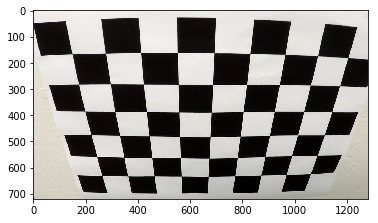

In [59]:
image = mpimg.imread('camera_cal/calibration2.jpg')
image_shape = image.shape
plt.imshow(image)

## Camera calibration and undistortion of the image

In this step I am doing camera calibaration using chessboard images. In this chessboard image thers 9 coners in row and 6 coners in column. With the help of these coners  I calculated the distortion matrix of the camera. I used this distortion matrix to obtain undisorted image.

[array([[ 0.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 2.,  0.,  0.],
       [ 3.,  0.,  0.],
       [ 4.,  0.,  0.],
       [ 5.,  0.,  0.],
       [ 6.,  0.,  0.],
       [ 7.,  0.,  0.],
       [ 8.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 1.,  1.,  0.],
       [ 2.,  1.,  0.],
       [ 3.,  1.,  0.],
       [ 4.,  1.,  0.],
       [ 5.,  1.,  0.],
       [ 6.,  1.,  0.],
       [ 7.,  1.,  0.],
       [ 8.,  1.,  0.],
       [ 0.,  2.,  0.],
       [ 1.,  2.,  0.],
       [ 2.,  2.,  0.],
       [ 3.,  2.,  0.],
       [ 4.,  2.,  0.],
       [ 5.,  2.,  0.],
       [ 6.,  2.,  0.],
       [ 7.,  2.,  0.],
       [ 8.,  2.,  0.],
       [ 0.,  3.,  0.],
       [ 1.,  3.,  0.],
       [ 2.,  3.,  0.],
       [ 3.,  3.,  0.],
       [ 4.,  3.,  0.],
       [ 5.,  3.,  0.],
       [ 6.,  3.,  0.],
       [ 7.,  3.,  0.],
       [ 8.,  3.,  0.],
       [ 0.,  4.,  0.],
       [ 1.,  4.,  0.],
       [ 2.,  4.,  0.],
       [ 3.,  4.,  0.],
       [ 4.,  4.,  0.],
       [ 5.,  4

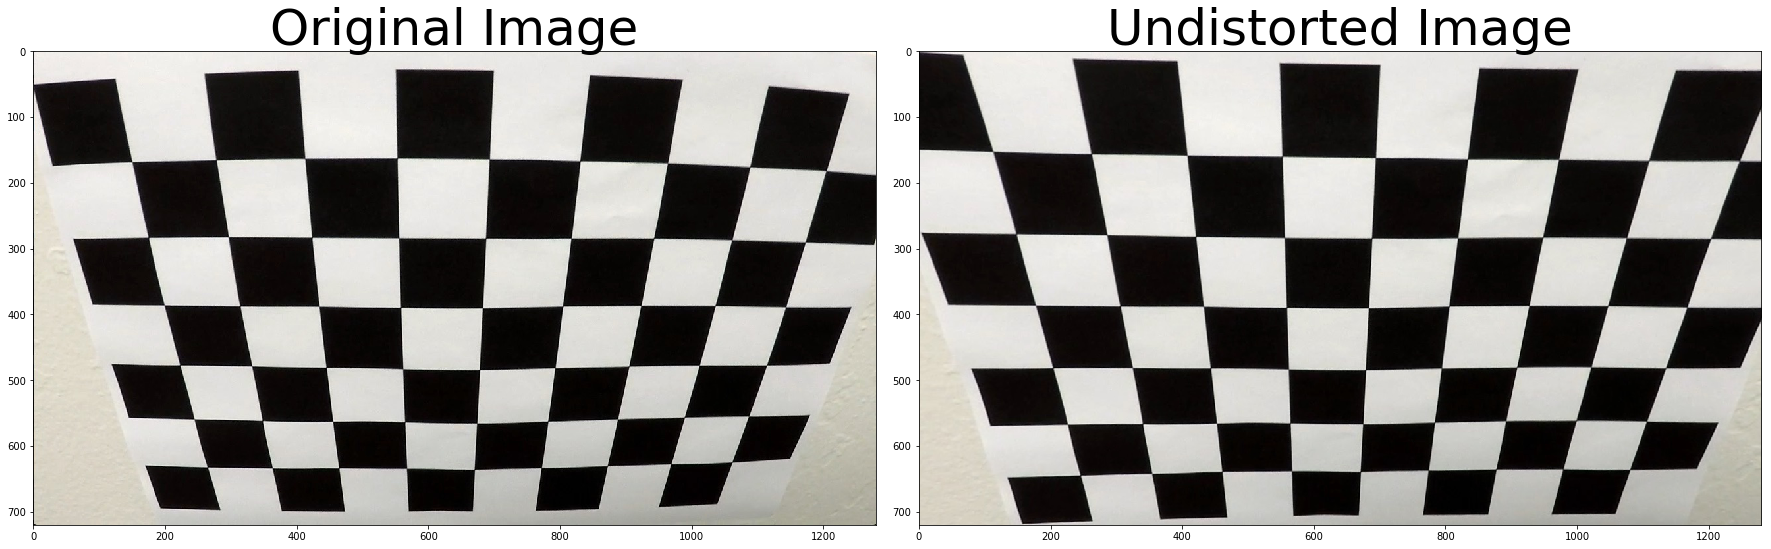

In [61]:

nx = 9
ny = 6

objpoints = []
imgpoints = []

objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

fnames = glob.glob("camera_cal/calibration*.jpg")

for fname in fnames:
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
    if ret:
        objpoints.append(objp)
        imgpoints.append(corners)
        
print(objpoints)
        
# use the object and image points to caliberate the camera and compute the camera matrix and distortion coefficients
ret, cameraMatrix, distortionCoeffs, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, image_shape[:2],None,None)

img = mpimg.imread('camera_cal/calibration2.jpg')
undistorted = cv2.undistort(img, cameraMatrix, distortionCoeffs, None, cameraMatrix)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


# Image Gradient and Color Threshold

The gradient thresold has been calculated by using Sobel operator in:
    - X axis
    - direction gradient with threshold of 30 and 90 degrees
    
## Note:-

Since the lane are vertical , so taking gradient along X-axis would be enough

## Color Threshold

The color thresholding has been done by selecting following color channels

   - R and G Channels threshold are used because of Yellow lanes are detected very well
   - L channel threshold avoid the edges due to the shadow
   - S channel threshold shows good performance in differenaiting white and yellow lanes  

In [62]:
def thresholded_image(img):
     
    img = cv2.undistort(img, cameraMatrix, distortionCoeffs, None, cameraMatrix)
    
    # convert to gray scale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    height, width = gray.shape
    
    # apply gradient threshold on the horizontal gradient
    sx_binary = abs_sobel_thresh(gray, 'x', 10, 200)
    
    # apply gradient direction threshold so that only edges closer to vertical are detected.
    dir_binary = dir_threshold(gray, thresh=(np.pi/6, np.pi/2))
    
    # combine the gradient and direction thresholds.
    combined_condition = ((sx_binary == 1) & (dir_binary == 1))
    
    # R & G thresholds so that yellow lanes are detected well.
    color_threshold = 150
    R = img[:,:,0]
    G = img[:,:,1]
    color_combined = np.zeros_like(R)
    r_g_condition = (R > color_threshold) & (G > color_threshold)
    
    
    # color channel thresholds
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    S = hls[:,:,2]
    L = hls[:,:,1]
    
    # S channel performs well for detecting bright yellow and white lanes
    s_thresh = (100, 255)
    s_condition = (S > s_thresh[0]) & (S <= s_thresh[1])
    
    # We put a threshold on the L channel to avoid pixels which have shadows and as a result darker.
    l_thresh = (120, 255)
    l_condition = (L > l_thresh[0]) & (L <= l_thresh[1])

    # combine all the thresholds
    # A pixel should either be a yellowish or whiteish
    # And it should also have a gradient, as per our thresholds
    color_combined[(r_g_condition & l_condition) & (s_condition | combined_condition)] = 1
    
    # apply the region of interest mask
    mask = np.zeros_like(color_combined)
    region_of_interest_vertices = np.array([[0,height-1], [width/2, int(0.5*height)], [width-1, height-1]], dtype=np.int32)
    cv2.fillPoly(mask, [region_of_interest_vertices], 1)
    thresholded = cv2.bitwise_and(color_combined, mask)
    
    return thresholded







def dir_threshold(gray, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    dir_output =  np.zeros_like(absgraddir)
    dir_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return dir_output


def mag_thresh(gray, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    mag_output = np.zeros_like(gradmag)
    mag_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return mag_output

def abs_sobel_thresh(gray, orient='x', thresh_min=0, thresh_max=255):
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    abs_sobel_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    abs_sobel_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return abs_sobel_output





## Binary Thresholded Image

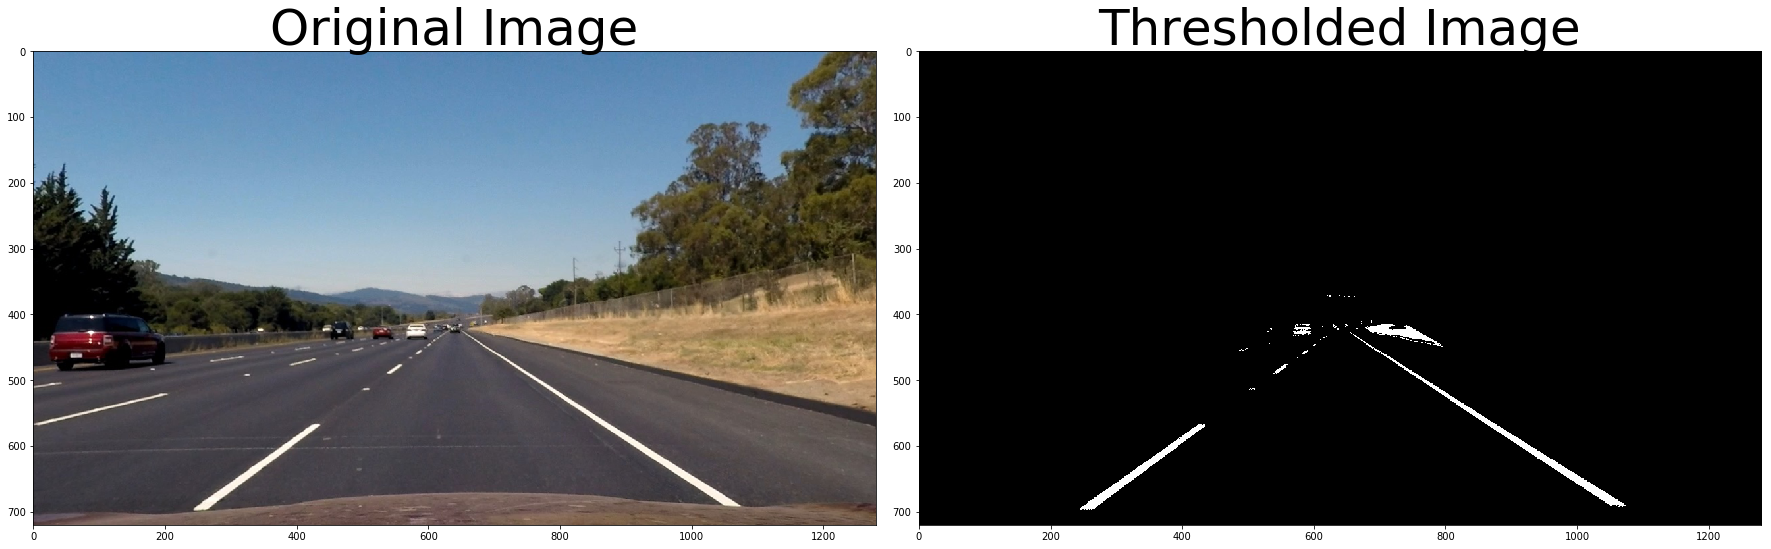

In [63]:
img = mpimg.imread('test_images/straight_lines2.jpg')
thresholded = thresholded_image(img)
img = cal_undistort(img, objpoints, imgpoints)
cv2.imwrite('thresholded.jpg',thresholded)

# Plot the 2 images side by side
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(thresholded, cmap='gray')
ax2.set_title('Thresholded Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Perspective Transform

- In this step I did the perspective transform .The polygon with the  vertices(src_pts) is drawn on the image for visualization. 
- Destination points are chosen so that lane looks parallel in perspective transform.
- I transform the binary image to show the birds eye view

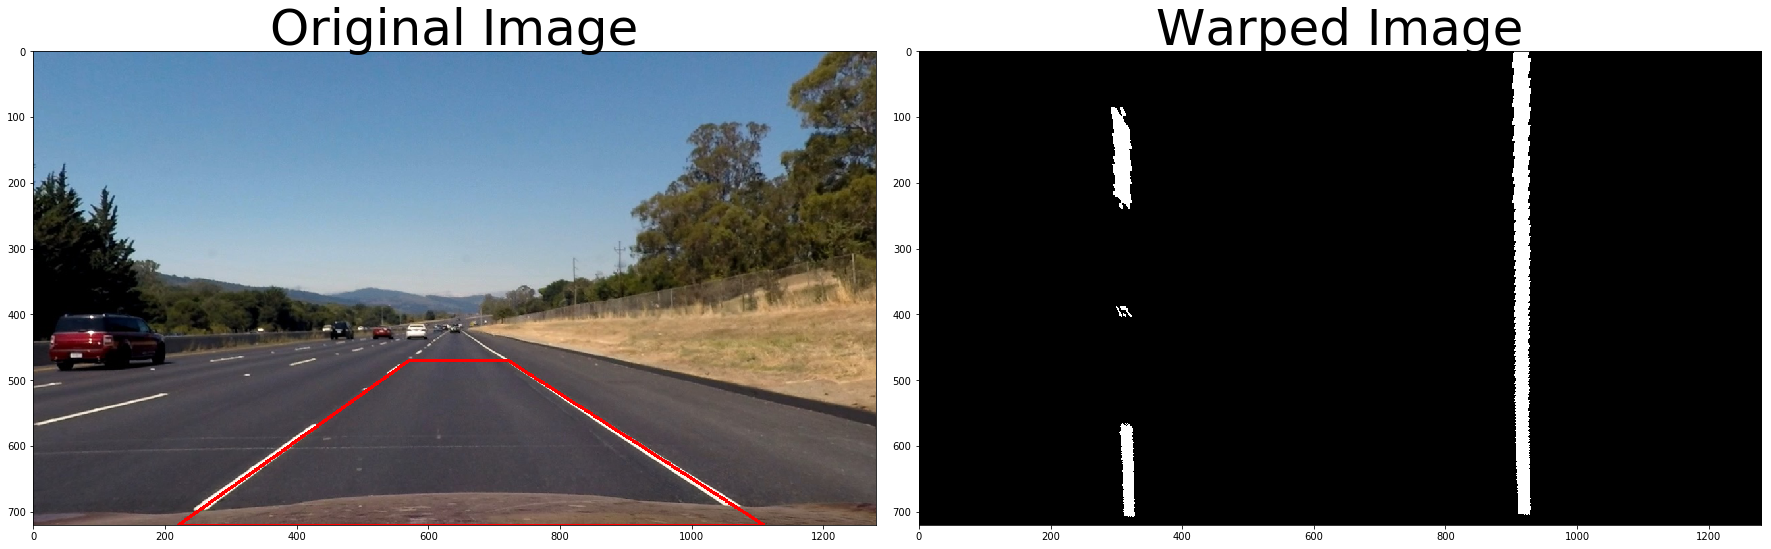

In [70]:
src_pts=[]
src_pts=[([220,720]), ([1110, 720]),([722, 470]),([570, 470])]

source = np.float32(src_pts)

pts = np.array(src_pts, np.int32)
pts = pts.reshape((-1,1,2))
copy = img.copy()
cv2.polylines(copy,[pts],True,(255,0,0), thickness=3)

# Destination points are chosen such that straight lanes appear more or less parallel in the transformed image.
bottom_left = [320,720]
bottom_right = [920, 720]
top_left = [320, 1]
top_right = [920, 1]

dst = np.float32([bottom_left,bottom_right,top_right,top_left])
M = cv2.getPerspectiveTransform(source, dst)
M_inv = cv2.getPerspectiveTransform(dst, source)
img_size = (image_shape[1], image_shape[0])

warped = cv2.warpPerspective(thresholded, M, img_size , flags=cv2.INTER_LINEAR)
    
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(copy)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(warped, cmap='gray')
ax2.set_title('Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Histogram

By applying histogram on the binary wraped image we can detect the position of the lane with the help of peaks. 

In [71]:
def hist(img):
    # Grab only the bottom half of the image
    # Lane lines are likely to be mostly vertical nearest to the car
    bottom_half = img[img.shape[0]//2:,:]

    # Sum across image pixels vertically - make sure to set an `axis`
    # i.e. the highest areas of vertical lines should be larger values
    histogram = np.sum(bottom_half, axis=0)
    half_width = np.int(histogram.shape[0]/2)
    leftx = np.argmax(histogram[:half_width])
    # Peak in the second half indicates the likely position of the right lane
    rightx = np.argmax(histogram[half_width:]) + half_width

    
    return histogram,leftx,rightx

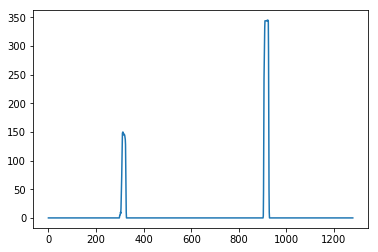

In [72]:
histogram,leftx_base,rightx_base = hist(warped)

# Visualize the resulting histogram
plt.plot(histogram)

# Identifying the lane pixels

## Sliding Window Search

As the staring point I took the position obatained from histogram.Then I  performed a sliding window search, I have used 9 windows of width 100 pixels.
Firstly the  x and y coordinates of non zeros pixels are found then I fit a polynomial on  these coordinates and the lane lines are drawn.

win_xleft_low ,win_y_low,win_xleft_high,win_y_high : 213 648 413 720
win_xright_low ,win_y_low,win_xright_high,win_y_high : 819 648 1019 720
win_xleft_low ,win_y_low,win_xleft_high,win_y_high : 218 576 418 648
win_xright_low ,win_y_low,win_xright_high,win_y_high : 817 576 1017 648
win_xleft_low ,win_y_low,win_xleft_high,win_y_high : 215 504 415 576
win_xright_low ,win_y_low,win_xright_high,win_y_high : 816 504 1016 576
win_xleft_low ,win_y_low,win_xleft_high,win_y_high : 214 432 414 504
win_xright_low ,win_y_low,win_xright_high,win_y_high : 815 432 1015 504
win_xleft_low ,win_y_low,win_xleft_high,win_y_high : 214 360 414 432
win_xright_low ,win_y_low,win_xright_high,win_y_high : 815 360 1015 432
win_xleft_low ,win_y_low,win_xleft_high,win_y_high : 209 288 409 360
win_xright_low ,win_y_low,win_xright_high,win_y_high : 815 288 1015 360
win_xleft_low ,win_y_low,win_xleft_high,win_y_high : 209 216 409 288
win_xright_low ,win_y_low,win_xright_high,win_y_high : 815 216 1015 288
win_xleft_low

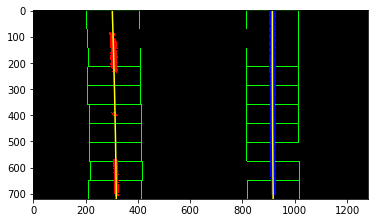

In [74]:
# Peak in the first half indicates the likely position of the left lane

def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 10
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        print ('win_xleft_low ,win_y_low,win_xleft_high,win_y_high :',win_xleft_low,win_y_low,win_xleft_high,win_y_high)
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        print ('win_xright_low ,win_y_low,win_xright_high,win_y_high :',win_xright_low,win_y_low,win_xright_high,win_y_high)
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

#def fit_polynomial(binary_warped):
    # Find our lane pixels first
binary_warped = warped
leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    #try:
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
   # except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
    #    print('The function failed to fit a line!')
       # left_fitx = 1*ploty**2 + 1*ploty
       # right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
out_img[lefty, leftx] = [255, 0, 0]
out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')

    #return out_img


#out_img = fit_polynomial(warped)

plt.imshow(out_img)

# Identifying the lane pixels

## Searching around a previously detected line.

In reality the consecutive frames  have lane lines in roughly similar positions,  so expolting this fact I search around a margin of 50 pixels of the previously detected lane lines.

(720, 0)

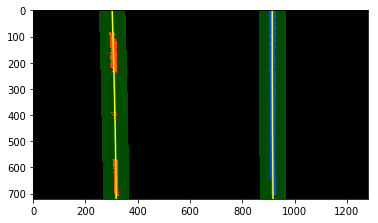

In [75]:
margin = 50
#margin = 100

    # Grab activated pixels
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
    
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                   left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                   left_fit[1]*nonzeroy + left_fit[2] + margin)))
right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds]

ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])

left_fit = np.polyfit(lefty, leftx, 2)
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]

rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]

right_fit = np.polyfit(righty, rightx, 2)
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin,ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))

right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin,ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, warped.shape[1])
plt.ylim(warped.shape[0],0)

# Computing the radius of curvature and center offset.

The radius of curvature is computed according to the formula and method described in the litreature. Since we perform the polynomial fit in pixels and whereas the curvature has to be calculated in real world meters, we have to use a pixel to meter transformation and recompute the fit again.

The mean of the lane pixels closest to the car gives us the center of the lane. The center of the image gives us the position of the car. The difference between the 2 is the offset from the center.

In [76]:
def measure_curvature_real(fit_values):
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    print (warped.shape[0])
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0])
    y_eval = np.max(ploty)
    # Fit new polynomials to x,y in world space
    fit_cr = np.polyfit(ploty*ym_per_pix, fit_values*xm_per_pix, 2)
    curverad = ((1 + (2*fit_cr[0]*y_eval*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
    return curverad


left_lane_curvature=measure_curvature_real (left_fitx)
right_lane_curvature=measure_curvature_real (right_fitx)
print ((left_lane_curvature+right_lane_curvature)/2)


lane_center = (right_fitx[719] + left_fitx[719])/2
xm_per_pix = 3.7/700 # meters per pixel in x dimension
center_offset_pixels = abs(img_size[0]/2 - lane_center)
center_offset_mtrs = xm_per_pix*center_offset_pixels
offset_string = "Center offset: %.2f m" % center_offset_mtrs
print(offset_string)

720
720
15388.4370099
Center offset: 0.12 m


# Inverse Transform

In this block of code I am doing the following:
1. Painting the lane area
2. Takeing inverse perspective transform
3. Drawing the processed image with the original image.

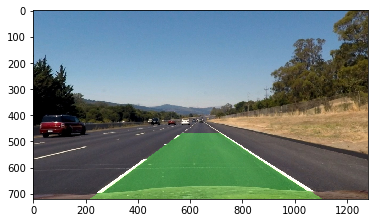

In [77]:
out_img = np.dstack((warped, warped, warped))*255
ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0])
left_window = np.array(np.transpose(np.vstack([left_fitx, ploty])))
right_window = np.array(np.flipud(np.transpose(np.vstack([right_fitx, ploty]))))
line_points = np.vstack((left_window, right_window))
cv2.fillPoly(out_img, np.int_([line_points]), [0,255, 0])
unwarped = cv2.warpPerspective(out_img, M_inv, img_size , flags=cv2.INTER_LINEAR)
result = cv2.addWeighted(img, 1, unwarped, 0.3, 0)
plt.imshow(result)

# Final PipeLine

In the we are detecting the lane line in the video. There are some use cases which are handled in the the final piple line.

## Figuring out bad frames
There will be some frames where no lanes will be detected or the lanes might not make sense. We determine the bad frames if any of the following conditions are met:

1. No pixels were detected using the sliding window search or search around the previously detected line.
2. The average gap between the lanes is less than 0.7 times pr greater than 1.3 times the globally maintained moving average of the lane gap.
3. In case of bad frame detected I performed a sliding window search again (this is done in the `window_search` method in the code block below
4. If this still results in a bad frame then we fall back to the previous well detected frame.

## Averaging lanes

The lane for each frame is a simple average of 12 previously computed lanes. This is done in the `averageing_lines` method in the code block below.


## Final Pipeline
We combine all the code described in the code block above, plus the averaging and fallback techniques described in this block. The final code is in the `pipeline_final` method.

In [111]:
left_fit =None
right_fit =None

buffer_right_lines = []
buffer_left_lines =[]

def poly_fit(nonzerox,nonzeroy,left_lane_inds,right_lane_inds,binary_warped):
  
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    #try:
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    print('polyfit_right in polyfit :' ,right_fit) 
    print('polyfit_left in polyfit :' ,left_fit) 
    
    return left_fitx,right_fitx

def window_search(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    #out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    nwindows = 9
    margin = 100
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    left_lane_inds =[]
    right_lane_inds=[]
    
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
   # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass
    
    left_fitx,right_fitx = poly_fit(nonzerox,nonzeroy,left_lane_inds,right_lane_inds,binary_warped)
    return left_fitx,right_fitx


left_fix,right_fitx =  window_search(warped)




def averageing_lines(former_line, new_line):
   
    # Number of frames to average over
    numofframes = 12
    
    if new_line is None:
        # No line was detected
        
        if len(former_line) == 0:
            return former_line, None
        else:
            return former_line, former_line[-1]
    else:
        if len(former_line) < numofframes:
            # we need at least num_frames frames to average over
            former_line.append(new_line)
            return former_line, new_line
        else:
            # average over the last num_frames frames
            former_line[0:numofframes-1] = former_line[1:]
            former_line[numofframes-1] = new_line
            new_line = np.zeros_like(new_line)
            for i in range(numofframes):
                new_line += former_line[i]
            new_line /= numofframes
            return former_line, new_line

def pipeline_final(img):
    # global variables to store the polynomial coefficients of the line detected in the last frame
    global right_fit
    global left_fit
    
    # global variables to store the line coordinates in previous n (=4) frames
    global buffer_right_lines
    global buffer_left_lines
    
    # global variable which contains running average of the mean difference between left and right lanes
    global running_mean_difference_between_lines
    
    img_shape = img.shape
    img_size = (image_shape[1], image_shape[0])
    
    
    # get thresholded image
    thresholded = thresholded_image(img)
    print (thresholded.shape)
    # perform a perspective transform
    warped = cv2.warpPerspective(thresholded, M, img_size , flags=cv2.INTER_LINEAR)
    
    out_img = np.dstack((warped, warped, warped))*255
    
    non_zeros = warped.nonzero()
    non_zeros_y = non_zeros[0]
    non_zeros_x = non_zeros[1]
    
    
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0])
    
    if (left_fit is None) or (right_fit is None):
        # If the polynomial coefficients of the previous frames are None then perform a window_search force search
        window_searching = True
        left_fitx, right_fitx = window_search(warped)
    else:
        # Else search in a margin of 100 pixels on each side of the pervious polynomial fit
        window_searching = False
        margin = 100
        left_fitx = left_fit[0]*non_zeros_y**2 + left_fit[1]*non_zeros_y + left_fit[2]
        left_coordinates = ((non_zeros_x >= left_fitx - margin) & (non_zeros_x <= left_fitx + margin)).nonzero()[0]

        right_fitx = right_fit[0]*non_zeros_y**2 + right_fit[1]*non_zeros_y + right_fit[2]
        right_coordinates = ((non_zeros_x >= right_fitx - margin) & (non_zeros_x <= right_fitx + margin)).nonzero()[0]
        
        left_fitx, right_fitx = poly_fit(non_zeros_x, non_zeros_y, left_coordinates, right_coordinates,warped)
    
    if (left_fitx is None or right_fitx is None):
        if not window_searching:
            left_fitx, right_fitx = window_search(warped)
            
    bad_lines = False
            
    if (left_fitx is None or right_fitx is None):
        bad_lines = True
    else:
        mean_difference = np.mean(right_fitx - left_fitx)
        
        if running_mean_difference_between_lines == 0:
            running_mean_difference_between_lines = mean_difference
        
        if (mean_difference < 0.7*running_mean_difference_between_lines or mean_difference > 1.3*running_mean_difference_between_lines):
            bad_lines = True
            if not window_search:
                left_fitx, right_fitx = window_search(warped)
                if (left_fitx is None or right_fitx is None):
                    bad_lines = True
                else:
                    mean_difference = np.mean(right_fitx - left_fitx)
                    if (mean_difference < 0.7*running_mean_difference_between_lines or mean_difference > 1.3*running_mean_difference_between_lines):
                        bad_lines = True
                    else:
                        bad_lines = False
        else:
            bad_lines = False
            
    if bad_lines:
        left_fit = None
        right_fit = None
        if len(buffer_left_lines) == 0 and len(buffer_right_lines) == 0:
            return img
        else:
            left_fitx = buffer_left_lines[-1]
            right_fitx = buffer_right_lines[-1]
    else:
        buffer_left_lines, left_fitx = averageing_lines(buffer_left_lines, left_fitx)
        buffer_right_lines, right_fitx = averageing_lines(buffer_right_lines, right_fitx)
        mean_difference = np.mean(right_fitx - left_fitx)
        running_mean_difference_between_lines = 0.9*running_mean_difference_between_lines + 0.1*mean_difference
    
    left_line_window = np.array(np.transpose(np.vstack([left_fitx, ploty])))
    right_line_window = np.array(np.flipud(np.transpose(np.vstack([right_fitx, ploty]))))
    
    # compute the radius of curvature
    left_curve_rad = measure_curvature_real(left_fitx)
    right_curve_rad = measure_curvature_real(right_fitx)
    print('polyfit_right:' ,right_fit) 
    print('polyfit_left:' ,left_fit) 
    average_curve_rad = (left_curve_rad + right_curve_rad)/2
    curvature_string = "Radius of curvature: %.2f m" % average_curve_rad
    
    # compute the offset from the center
    lane_center = (right_fitx[warped.shape[0]-1] + left_fitx[warped.shape[0]-1])/2
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    center_offset_pixels = abs(img_size[0]/2 - lane_center)
    center_offset_mtrs = xm_per_pix*center_offset_pixels
    offset_string = "Center offset: %.2f m" % center_offset_mtrs
    
    polploty = np.vstack([left_line_window, right_line_window])
    
    cv2.fillPoly(out_img, np.int_([polploty]), [0,255, 0])
    
    unwarped = cv2.warpPerspective(out_img, M_inv, img_size , flags=cv2.INTER_LINEAR)

    result = cv2.addWeighted(img, 1, unwarped, 0.3, 0)
    
    cv2.putText(result,curvature_string , (100, 90), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)
    cv2.putText(result, offset_string, (100, 150), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)
    return result

polyfit_right in polyfit : [  8.06998563e-06  -1.51383619e-03   9.14340906e+02]
polyfit_left in polyfit : [ -1.57509173e-05   3.26886481e-02   3.02379219e+02]


(720, 1280)
polyfit_right in polyfit : [  1.50896312e-05   1.15429751e-01   9.04020538e+02]
polyfit_left in polyfit : [ -1.24891481e-04   1.79692036e-01   3.02319547e+02]
720
720
polyfit_right: None
polyfit_left: None
processed :  (720, 1280, 3)


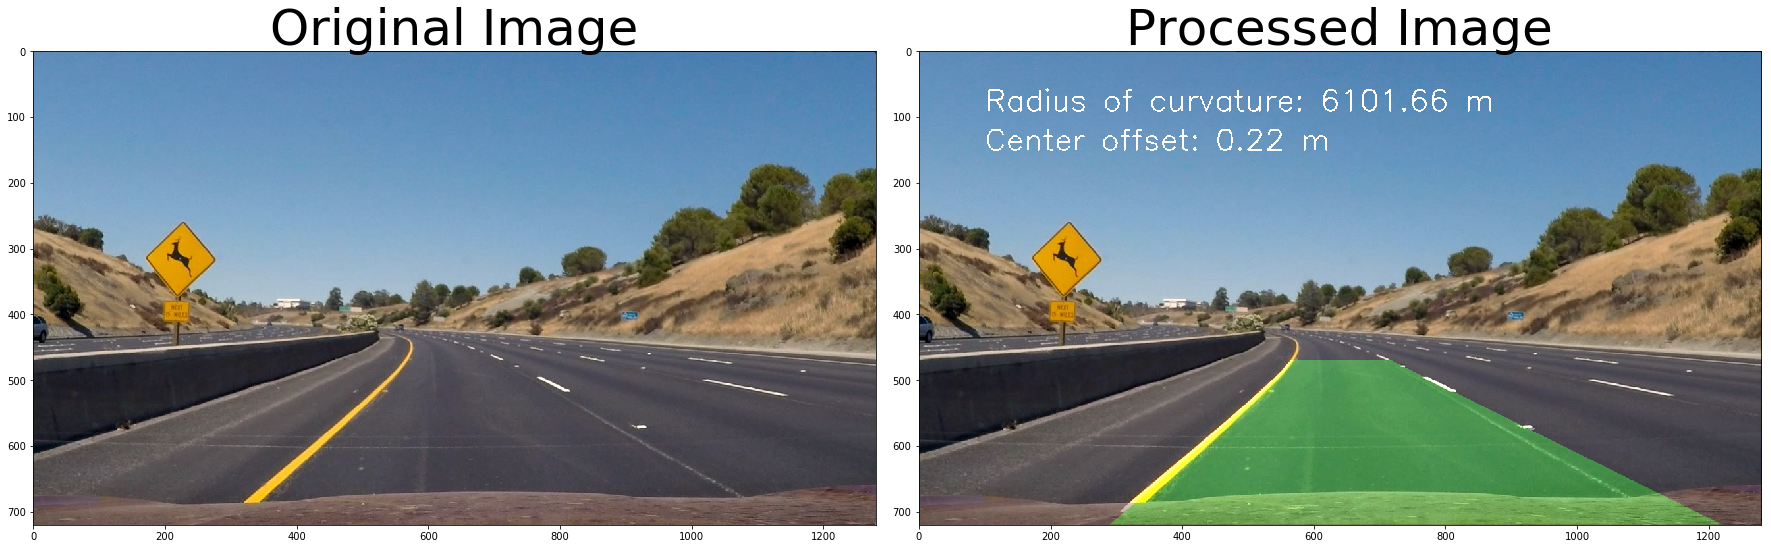

In [112]:
from moviepy.editor import VideoFileClip
img = mpimg.imread('test_images/test2.jpg')

# Reinitialize some global variables.
left_fit =None
right_fit =None

buffer_right_lines = []
buffer_left_lines =[]

running_mean_difference_between_lines = 0

# Apply pipeline
processed = pipeline_final(img)

print ('processed : ',processed.shape)
# Plot the 2 images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
#ax2.imshow(processed, cmap='gray')
ax2.imshow(processed)
ax2.set_title('Processed Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [113]:
# Reinitialize some global variables.
left_fit =None
right_fit =None

buffer_right_lines = []
buffer_left_lines =[]

running_mean_difference_between_lines = 0


output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(pipeline_final) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)

(720, 1280)
polyfit_right in polyfit : [ -8.13487481e-05   1.75251557e-01   8.98859005e+02]
polyfit_left in polyfit : [ -1.14729922e-04   1.67533329e-01   3.00987439e+02]
720
720
polyfit_right: None
polyfit_left: None
[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4



  0%|          | 0/1261 [00:00<?, ?it/s]

(720, 1280)



  0%|          | 1/1261 [00:00<03:40,  5.72it/s]

polyfit_right in polyfit : [ -8.13487481e-05   1.75251557e-01   8.98859005e+02]
polyfit_left in polyfit : [ -1.14729922e-04   1.67533329e-01   3.00987439e+02]
720
720
polyfit_right: None
polyfit_left: None


(720, 1280)
polyfit_right in polyfit : [ -6.62289488e-05   1.69428077e-01   8.95209743e+02]
polyfit_left in polyfit : [ -1.25268590e-04   1.75265909e-01   3.01068006e+02]
720
720
polyfit_right: None
polyfit_left: None



  0%|          | 2/1261 [00:00<03:45,  5.59it/s]

(720, 1280)
polyfit_right in polyfit : [ -6.47914237e-05   1.72273927e-01   8.91582079e+02]
polyfit_left in polyfit : [ -1.37884654e-04   1.84490261e-01   3.00489805e+02]
720
720
polyfit_right: None
polyfit_left: None



  0%|          | 3/1261 [00:00<03:40,  5.71it/s]

(720, 1280)



  0%|          | 4/1261 [00:00<03:39,  5.73it/s]

polyfit_right in polyfit : [ -7.46213969e-05   1.83551602e-01   8.87498999e+02]
polyfit_left in polyfit : [ -1.38406559e-04   1.85881642e-01   3.00799801e+02]
720
720
polyfit_right: None
polyfit_left: None
(720, 1280)
polyfit_right in polyfit : [ -1.14369441e-04   2.17587505e-01   8.81862071e+02]
polyfit_left in polyfit : [ -1.39294281e-04   1.89851810e-01   2.99625510e+02]
720
720
polyfit_right: None
polyfit_left: None



  0%|          | 6/1261 [00:01<03:27,  6.06it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.10317266e-04   2.19536194e-01   8.78169628e+02]
polyfit_left in polyfit : [ -1.40725508e-04   1.93293347e-01   2.99429176e+02]
720
720
polyfit_right: None
polyfit_left: None
(720, 1280)
polyfit_right in polyfit : [ -1.20819065e-04   2.27440758e-01   8.78175252e+02]
polyfit_left in polyfit : [ -1.38746858e-04   1.96495281e-01   2.97161905e+02]
720
720
polyfit_right: None
polyfit_left: None



  1%|          | 8/1261 [00:01<03:19,  6.28it/s]

(720, 1280)
polyfit_right in polyfit : [ -9.30519524e-05   2.19125850e-01   8.73842060e+02]
polyfit_left in polyfit : [ -1.43232334e-04   2.04255970e-01   2.95891958e+02]
720
720
polyfit_right: None
polyfit_left: None
(720, 1280)
polyfit_right in polyfit : [ -1.06354649e-04   2.24399421e-01   8.75202816e+02]
polyfit_left in polyfit : [ -1.38972631e-04   2.05565655e-01   2.92641823e+02]
720
720
polyfit_right: None
polyfit_left: None



  1%|          | 10/1261 [00:01<03:17,  6.32it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.28229779e-04   2.47199572e-01   8.69520001e+02]
polyfit_left in polyfit : [ -1.45069710e-04   2.14245545e-01   2.88999838e+02]
720
720
polyfit_right: None
polyfit_left: None
(720, 1280)
polyfit_right in polyfit : [ -1.16473725e-04   2.42358472e-01   8.66935271e+02]
polyfit_left in polyfit : [ -1.44855153e-04   2.16143997e-01   2.88115368e+02]
720
720
polyfit_right: None
polyfit_left: None



  1%|          | 12/1261 [00:01<03:16,  6.36it/s]

(720, 1280)
polyfit_right in polyfit : [ -9.04518152e-05   2.09342909e-01   8.81253049e+02]
polyfit_left in polyfit : [ -1.34897424e-04   2.16409822e-01   2.81593032e+02]
720
720
polyfit_right: None
polyfit_left: None
(720, 1280)
polyfit_right in polyfit : [ -5.40081070e-05   1.92404957e-01   8.78128305e+02]
polyfit_left in polyfit : [ -1.36228222e-04   2.20704991e-01   2.79662424e+02]
720
720
polyfit_right: None
polyfit_left: None



  1%|          | 14/1261 [00:02<03:17,  6.30it/s]

(720, 1280)
polyfit_right in polyfit : [ -4.35242743e-05   1.85808590e-01   8.76610473e+02]
polyfit_left in polyfit : [ -1.34271556e-04   2.21044373e-01   2.78539509e+02]
720
720
polyfit_right: None
polyfit_left: None
(720, 1280)
polyfit_right in polyfit : [ -3.33094439e-05   1.85134536e-01   8.68366776e+02]
polyfit_left in polyfit : [ -1.27295938e-04   2.14116673e-01   2.81151384e+02]
720
720
polyfit_right: None
polyfit_left: None



  1%|▏         | 16/1261 [00:02<03:18,  6.28it/s]

(720, 1280)
polyfit_right in polyfit : [ -2.60041977e-05   1.85076599e-01   8.60051483e+02]
polyfit_left in polyfit : [ -1.24692152e-04   2.10407023e-01   2.82756662e+02]
720
720
polyfit_right: None
polyfit_left: None
(720, 1280)
polyfit_right in polyfit : [ -3.42664471e-05   1.88676685e-01   8.58631724e+02]
polyfit_left in polyfit : [ -1.18271513e-04   2.05942222e-01   2.82162221e+02]
720
720
polyfit_right: None
polyfit_left: None



  1%|▏         | 18/1261 [00:02<03:17,  6.31it/s]

(720, 1280)
polyfit_right in polyfit : [ -3.74314721e-05   1.94654504e-01   8.54060447e+02]
polyfit_left in polyfit : [ -1.02127165e-04   1.93346218e-01   2.83878620e+02]
720
720
polyfit_right: None
polyfit_left: None
(720, 1280)
polyfit_right in polyfit : [ -2.33495220e-05   1.71197897e-01   8.63835434e+02]
polyfit_left in polyfit : [ -8.74965623e-05   1.85510989e-01   2.81642491e+02]
720
720
polyfit_right: None
polyfit_left: None



  2%|▏         | 20/1261 [00:03<03:17,  6.29it/s]

(720, 1280)
polyfit_right in polyfit : [ -2.68234194e-05   1.66123988e-01   8.68668735e+02]
polyfit_left in polyfit : [ -7.42488634e-05   1.76862094e-01   2.80539194e+02]
720
720
polyfit_right: None
polyfit_left: None
(720, 1280)
polyfit_right in polyfit : [ -7.05638622e-06   1.31664787e-01   8.82301307e+02]
polyfit_left in polyfit : [ -6.30902952e-05   1.70042281e-01   2.78999416e+02]
720
720
polyfit_right: None
polyfit_left: None



  2%|▏         | 22/1261 [00:03<03:14,  6.36it/s]

(720, 1280)
polyfit_right in polyfit : [  2.02123559e-05   1.01654448e-01   8.93826428e+02]
polyfit_left in polyfit : [ -4.99976043e-05   1.63081886e-01   2.76311804e+02]
720
720
polyfit_right: None
polyfit_left: None
(720, 1280)
polyfit_right in polyfit : [ -1.24791927e-04   2.14829617e-01   8.75530631e+02]
polyfit_left in polyfit : [ -4.52753926e-05   1.58393233e-01   2.74781782e+02]
720
720
polyfit_right: None
polyfit_left: None



  2%|▏         | 24/1261 [00:03<03:15,  6.34it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.14578196e-04   2.14933752e-01   8.71733558e+02]
polyfit_left in polyfit : [ -4.51145271e-05   1.52011402e-01   2.77764198e+02]
720
720
polyfit_right: None
polyfit_left: None
(720, 1280)
polyfit_right in polyfit : [ -1.06897130e-04   2.13695450e-01   8.69667321e+02]
polyfit_left in polyfit : [ -6.04448744e-05   1.59356449e-01   2.78057274e+02]
720
720
polyfit_right: None
polyfit_left: None



  2%|▏         | 26/1261 [00:04<03:13,  6.38it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.13839171e-04   2.06028249e-01   8.78610024e+02]
polyfit_left in polyfit : [ -5.15384120e-05   1.51683499e-01   2.77125639e+02]
720
720
polyfit_right: None
polyfit_left: None
(720, 1280)
polyfit_right in polyfit : [ -1.03138916e-04   1.97741406e-01   8.81550839e+02]
polyfit_left in polyfit : [ -5.62046151e-05   1.50980245e-01   2.77662416e+02]
720
720
polyfit_right: None
polyfit_left: None



  2%|▏         | 28/1261 [00:04<03:13,  6.37it/s]

(720, 1280)
polyfit_right in polyfit : [ -9.23894505e-05   1.80268169e-01   8.91493727e+02]
polyfit_left in polyfit : [ -6.51375729e-05   1.58843299e-01   2.73895427e+02]
720
720
polyfit_right: None
polyfit_left: None
(720, 1280)
polyfit_right in polyfit : [ -9.01658207e-05   1.86028775e-01   8.86549824e+02]
polyfit_left in polyfit : [ -7.29100309e-05   1.58379482e-01   2.76851416e+02]
720
720
polyfit_right: None
polyfit_left: None



  2%|▏         | 30/1261 [00:04<03:15,  6.30it/s]

(720, 1280)
polyfit_right in polyfit : [ -9.00059061e-05   1.91407559e-01   8.81313788e+02]
polyfit_left in polyfit : [ -9.21799685e-05   1.66152664e-01   2.79412679e+02]
720
720
polyfit_right: None
polyfit_left: None
(720, 1280)
polyfit_right in polyfit : [ -9.60219957e-05   2.06431980e-01   8.73848793e+02]
polyfit_left in polyfit : [ -1.09045487e-04   1.73759689e-01   2.82171106e+02]
720
720
polyfit_right: None
polyfit_left: None


  3%|▎         | 32/1261 [00:05<03:13,  6.34it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.08033277e-04   2.27763831e-01   8.62798559e+02]
polyfit_left in polyfit : [ -1.19691979e-04   1.76607232e-01   2.85966729e+02]
720
720
polyfit_right: None
polyfit_left: None
(720, 1280)
polyfit_right in polyfit : [ -8.12829723e-05   1.95607191e-01   8.74687763e+02]
polyfit_left in polyfit : [ -1.24747855e-04   1.81473719e-01   2.83941248e+02]
720
720
polyfit_right: None
polyfit_left: None


  3%|▎         | 34/1261 [00:05<03:09,  6.47it/s]

(720, 1280)
polyfit_right in polyfit : [ -7.66892118e-05   2.00648260e-01   8.70879550e+02]
polyfit_left in polyfit : [ -1.30510630e-04   1.85289157e-01   2.85389736e+02]
720
720
polyfit_right: None
polyfit_left: None
(720, 1280)
polyfit_right in polyfit : [ -1.57968118e-04   2.61733553e-01   8.59785947e+02]
polyfit_left in polyfit : [ -1.29567071e-04   1.84800989e-01   2.86508466e+02]
720
720
polyfit_right: None
polyfit_left: None


  3%|▎         | 36/1261 [00:05<03:07,  6.53it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.17186085e-04   2.49754222e-01   8.55071890e+02]
polyfit_left in polyfit : [ -1.35149533e-04   1.89774519e-01   2.87660645e+02]
720
720
polyfit_right: None
polyfit_left: None
(720, 1280)
polyfit_right in polyfit : [ -1.19718348e-04   2.46076929e-01   8.55848337e+02]
polyfit_left in polyfit : [ -1.39103674e-04   1.93624279e-01   2.87903560e+02]
720
720
polyfit_right: None
polyfit_left: None


  3%|▎         | 38/1261 [00:06<03:06,  6.57it/s]

(720, 1280)
polyfit_right in polyfit : [ -8.11365284e-05   2.28794739e-01   8.53458860e+02]
polyfit_left in polyfit : [ -1.43698103e-04   1.98007262e-01   2.88419448e+02]
720
720
polyfit_right: None
polyfit_left: None
(720, 1280)
polyfit_right in polyfit : [ -9.96050260e-05   2.43830107e-01   8.47117516e+02]
polyfit_left in polyfit : [ -1.55618868e-04   2.07342674e-01   2.88298082e+02]
720
720
polyfit_right: None
polyfit_left: None


  3%|▎         | 40/1261 [00:06<03:05,  6.58it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.17664503e-04   2.52587063e-01   8.48261320e+02]
polyfit_left in polyfit : [ -1.60364881e-04   2.13680575e-01   2.86026337e+02]
720
720
polyfit_right: None
polyfit_left: None
(720, 1280)
polyfit_right in polyfit : [ -1.04189108e-04   2.43245209e-01   8.48974161e+02]
polyfit_left in polyfit : [ -1.64019909e-04   2.18615262e-01   2.84901867e+02]
720
720
polyfit_right: None
polyfit_left: None


  3%|▎         | 42/1261 [00:06<03:05,  6.58it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.12433084e-04   2.47974806e-01   8.49814493e+02]
polyfit_left in polyfit : [ -1.69318956e-04   2.25657402e-01   2.83113317e+02]
720
720
polyfit_right: None
polyfit_left: None
(720, 1280)
polyfit_right in polyfit : [ -9.98381208e-05   2.33325642e-01   8.55341506e+02]
polyfit_left in polyfit : [ -1.71771422e-04   2.32542254e-01   2.80507255e+02]
720
720
polyfit_right: None
polyfit_left: None


  3%|▎         | 44/1261 [00:07<04:40,  4.34it/s]

(720, 1280)
polyfit_right in polyfit : [ -9.01114932e-05   2.14453672e-01   8.64499993e+02]
polyfit_left in polyfit : [ -1.68288896e-04   2.33660511e-01   2.77956432e+02]
720
720
polyfit_right: None
polyfit_left: None


  4%|▎         | 45/1261 [00:07<04:45,  4.26it/s]

(720, 1280)
polyfit_right in polyfit : [ -9.11032490e-05   2.11332211e-01   8.68381965e+02]
polyfit_left in polyfit : [ -1.69082450e-04   2.38564601e-01   2.75259007e+02]
720
720
polyfit_right: None
polyfit_left: None


  4%|▎         | 46/1261 [00:07<04:47,  4.23it/s]

(720, 1280)
polyfit_right in polyfit : [ -4.24641060e-05   1.82906278e-01   8.71904975e+02]
polyfit_left in polyfit : [ -1.68773657e-04   2.40870670e-01   2.73547502e+02]
720
720
polyfit_right: None
polyfit_left: None


  4%|▎         | 47/1261 [00:07<04:42,  4.30it/s]

(720, 1280)
polyfit_right in polyfit : [ -5.27349585e-05   1.83698477e-01   8.74476049e+02]
polyfit_left in polyfit : [ -1.64271036e-04   2.41238592e-01   2.70968815e+02]
720
720
polyfit_right: None
polyfit_left: None


  4%|▍         | 48/1261 [00:08<04:46,  4.24it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.39783404e-04   2.57740710e-01   8.57201669e+02]
polyfit_left in polyfit : [ -1.66766499e-04   2.45688536e-01   2.69653601e+02]
720
720
polyfit_right: None
polyfit_left: None


  4%|▍         | 49/1261 [00:08<04:37,  4.37it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.34109280e-04   2.47399825e-01   8.63235382e+02]
polyfit_left in polyfit : [ -1.62386386e-04   2.47237655e-01   2.66064505e+02]
720
720
polyfit_right: None
polyfit_left: None


  4%|▍         | 50/1261 [00:08<04:44,  4.26it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.37641243e-04   2.53796363e-01   8.60474367e+02]
polyfit_left in polyfit : [ -1.63371779e-04   2.51806945e-01   2.64162479e+02]
720
720
polyfit_right: None
polyfit_left: None


  4%|▍         | 51/1261 [00:08<04:34,  4.41it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.55752706e-04   2.63893990e-01   8.59676807e+02]
polyfit_left in polyfit : [ -1.55098664e-04   2.48859984e-01   2.62799356e+02]
720
720
polyfit_right: None
polyfit_left: None


  4%|▍         | 52/1261 [00:09<04:37,  4.36it/s]

(720, 1280)
polyfit_right in polyfit : [ -9.19490132e-05   2.33497284e-01   8.55155043e+02]
polyfit_left in polyfit : [ -1.53112734e-04   2.47208503e-01   2.63636219e+02]
720
720
polyfit_right: None
polyfit_left: None


  4%|▍         | 53/1261 [00:09<04:46,  4.21it/s]

(720, 1280)
polyfit_right in polyfit : [ -7.61800054e-05   2.21257911e-01   8.54244567e+02]
polyfit_left in polyfit : [ -1.45096761e-04   2.42794016e-01   2.63444724e+02]
720
720
polyfit_right: None
polyfit_left: None


  4%|▍         | 54/1261 [00:09<04:37,  4.35it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.02249284e-04   2.42900367e-01   8.49073157e+02]
polyfit_left in polyfit : [ -1.30418494e-04   2.30700739e-01   2.64734112e+02]
720
720
polyfit_right: None
polyfit_left: None


  4%|▍         | 55/1261 [00:09<04:45,  4.23it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.09951513e-04   2.47638306e-01   8.49430293e+02]
polyfit_left in polyfit : [ -1.21923837e-04   2.26028727e-01   2.63736504e+02]
720
720
polyfit_right: None
polyfit_left: None


  4%|▍         | 56/1261 [00:10<04:36,  4.36it/s]

(720, 1280)
polyfit_right in polyfit : [ -9.44790427e-05   2.29797359e-01   8.54731119e+02]
polyfit_left in polyfit : [ -1.08069967e-04   2.16210446e-01   2.63535592e+02]
720
720
polyfit_right: None
polyfit_left: None


  5%|▍         | 57/1261 [00:10<04:47,  4.20it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.06028826e-04   2.42099866e-01   8.51678455e+02]
polyfit_left in polyfit : [ -8.94149417e-05   1.99912252e-01   2.66001993e+02]
720
720
polyfit_right: None
polyfit_left: None


  5%|▍         | 58/1261 [00:10<04:37,  4.34it/s]

(720, 1280)
polyfit_right in polyfit : [ -8.32616476e-05   2.19591135e-01   8.56623749e+02]
polyfit_left in polyfit : [ -7.73082268e-05   1.90526446e-01   2.66282624e+02]
720
720
polyfit_right: None
polyfit_left: None


  5%|▍         | 59/1261 [00:10<04:46,  4.20it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.43190065e-04   2.81604841e-01   8.36704982e+02]
polyfit_left in polyfit : [ -7.18267234e-05   1.80330959e-01   2.71129259e+02]
720
720
polyfit_right: None
polyfit_left: None


  5%|▍         | 60/1261 [00:11<04:38,  4.32it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.54876118e-04   2.98569162e-01   8.26470097e+02]
polyfit_left in polyfit : [ -6.07796127e-05   1.65814546e-01   2.75894186e+02]
720
720
polyfit_right: None
polyfit_left: None


  5%|▍         | 61/1261 [00:11<05:09,  3.88it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.25484764e-04   2.81849218e-01   8.26167022e+02]
polyfit_left in polyfit : [ -5.45579132e-05   1.55519712e-01   2.78812401e+02]
720
720
polyfit_right: None
polyfit_left: None


  5%|▍         | 62/1261 [00:11<05:36,  3.57it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.00107283e-04   2.73682776e-01   8.21318722e+02]
polyfit_left in polyfit : [ -6.26265192e-05   1.56549587e-01   2.80818487e+02]
720
720
polyfit_right: None
polyfit_left: None


  5%|▍         | 63/1261 [00:11<05:32,  3.60it/s]

(720, 1280)
polyfit_right in polyfit : [ -4.93166309e-05   2.33816377e-01   8.28848361e+02]
polyfit_left in polyfit : [ -6.46127863e-05   1.56558067e-01   2.79891432e+02]
720
720
polyfit_right: None
polyfit_left: None


  5%|▌         | 64/1261 [00:12<05:08,  3.88it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.00596588e-04   2.65654029e-01   8.24075616e+02]
polyfit_left in polyfit : [ -7.55476844e-05   1.58804823e-01   2.81911769e+02]
720
720
polyfit_right: None
polyfit_left: None


  5%|▌         | 65/1261 [00:12<05:04,  3.92it/s]

(720, 1280)
polyfit_right in polyfit : [ -8.00439813e-05   2.41396694e-01   8.31167945e+02]
polyfit_left in polyfit : [ -8.52708134e-05   1.64143285e-01   2.80126324e+02]
720
720
polyfit_right: None
polyfit_left: None


  5%|▌         | 66/1261 [00:12<04:49,  4.13it/s]

(720, 1280)
polyfit_right in polyfit : [ -5.74376194e-05   2.22968486e-01   8.31829942e+02]
polyfit_left in polyfit : [ -1.00837317e-04   1.71921908e-01   2.80824935e+02]
720
720
polyfit_right: None
polyfit_left: None


  5%|▌         | 67/1261 [00:12<04:52,  4.08it/s]

(720, 1280)
polyfit_right in polyfit : [ -6.09075670e-05   2.19090297e-01   8.33849845e+02]
polyfit_left in polyfit : [ -1.11260012e-04   1.78449417e-01   2.79535594e+02]
720
720
polyfit_right: None
polyfit_left: None


  5%|▌         | 68/1261 [00:13<04:56,  4.03it/s]

(720, 1280)
polyfit_right in polyfit : [ -3.39614626e-05   1.87918721e-01   8.42138794e+02]
polyfit_left in polyfit : [ -1.23162702e-04   1.87790485e-01   2.76490744e+02]
720
720
polyfit_right: None
polyfit_left: None


  5%|▌         | 69/1261 [00:13<04:43,  4.21it/s]

(720, 1280)
polyfit_right in polyfit : [ -3.79482586e-05   1.93315092e-01   8.38250450e+02]
polyfit_left in polyfit : [ -1.38309415e-04   1.97158581e-01   2.76621164e+02]
720
720
polyfit_right: None
polyfit_left: None


  6%|▌         | 70/1261 [00:13<04:48,  4.14it/s]

(720, 1280)
polyfit_right in polyfit : [ -6.16747140e-05   2.06729911e-01   8.40079364e+02]
polyfit_left in polyfit : [ -1.39198895e-04   2.00250302e-01   2.73373602e+02]
720
720
polyfit_right: None
polyfit_left: None


  6%|▌         | 71/1261 [00:13<04:37,  4.29it/s]

(720, 1280)
polyfit_right in polyfit : [ -3.80087267e-05   1.81866779e-01   8.44909430e+02]
polyfit_left in polyfit : [ -1.38727449e-04   1.99659095e-01   2.73768679e+02]
720
720
polyfit_right: None
polyfit_left: None


  6%|▌         | 72/1261 [00:14<04:39,  4.26it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.32368680e-04   2.57037045e-01   8.31849104e+02]
polyfit_left in polyfit : [ -1.42692055e-04   2.06618285e-01   2.69992580e+02]
720
720
polyfit_right: None
polyfit_left: None


  6%|▌         | 73/1261 [00:14<04:53,  4.04it/s]

(720, 1280)
polyfit_right in polyfit : [ -8.43374300e-05   2.21829208e-01   8.38480164e+02]
polyfit_left in polyfit : [ -1.26646425e-04   1.96774861e-01   2.69539571e+02]
720
720
polyfit_right: None
polyfit_left: None


  6%|▌         | 74/1261 [00:14<04:53,  4.04it/s]

(720, 1280)
polyfit_right in polyfit : [ -6.60186540e-05   2.07531783e-01   8.39585189e+02]
polyfit_left in polyfit : [ -1.16972444e-04   1.91251862e-01   2.69239967e+02]
720
720
polyfit_right: None
polyfit_left: None


  6%|▌         | 75/1261 [00:14<04:44,  4.16it/s]

(720, 1280)
polyfit_right in polyfit : [ -7.74006388e-05   2.06535935e-01   8.44343652e+02]
polyfit_left in polyfit : [ -1.03624511e-04   1.85852594e-01   2.66268279e+02]
720
720
polyfit_right: None
polyfit_left: None


  6%|▌         | 76/1261 [00:15<04:49,  4.10it/s]

(720, 1280)
polyfit_right in polyfit : [ -9.61833375e-05   2.13430931e-01   8.44450804e+02]
polyfit_left in polyfit : [ -8.68024723e-05   1.72137562e-01   2.68676202e+02]
720
720
polyfit_right: None
polyfit_left: None


  6%|▌         | 77/1261 [00:15<04:37,  4.27it/s]

(720, 1280)
polyfit_right in polyfit : [ -5.06495955e-05   1.69731701e-01   8.58239497e+02]
polyfit_left in polyfit : [ -6.98640560e-05   1.65913745e-01   2.63675245e+02]
720
720
polyfit_right: None
polyfit_left: None


  6%|▌         | 78/1261 [00:15<04:44,  4.15it/s]

(720, 1280)
polyfit_right in polyfit : [ -9.15787012e-05   1.91880901e-01   8.59756633e+02]
polyfit_left in polyfit : [ -5.25038944e-05   1.52843468e-01   2.63853401e+02]
720
720
polyfit_right: None
polyfit_left: None


  6%|▋         | 79/1261 [00:15<04:34,  4.31it/s]

(720, 1280)
polyfit_right in polyfit : [ -8.86006370e-05   1.84721765e-01   8.63499219e+02]
polyfit_left in polyfit : [ -4.44461626e-05   1.47227768e-01   2.62199784e+02]
720
720
polyfit_right: None
polyfit_left: None


  6%|▋         | 80/1261 [00:15<04:38,  4.24it/s]

(720, 1280)
polyfit_right in polyfit : [ -8.19180393e-05   1.78489395e-01   8.63724569e+02]
polyfit_left in polyfit : [ -3.91608989e-05   1.39454504e-01   2.63215543e+02]
720
720
polyfit_right: None
polyfit_left: None


  6%|▋         | 81/1261 [00:16<04:36,  4.26it/s]

(720, 1280)
polyfit_right in polyfit : [ -5.12930810e-05   1.53999209e-01   8.64955608e+02]
polyfit_left in polyfit : [ -2.60878891e-05   1.24194203e-01   2.66890506e+02]
720
720
polyfit_right: None
polyfit_left: None


  7%|▋         | 82/1261 [00:16<04:38,  4.23it/s]

(720, 1280)
polyfit_right in polyfit : [ -6.87438606e-05   1.65389909e-01   8.64883920e+02]
polyfit_left in polyfit : [ -2.39129472e-05   1.20548686e-01   2.66107136e+02]
720
720
polyfit_right: None
polyfit_left: None


  7%|▋         | 83/1261 [00:16<04:28,  4.38it/s]

(720, 1280)
polyfit_right in polyfit : [ -8.10605508e-05   1.79497823e-01   8.62720969e+02]
polyfit_left in polyfit : [ -2.26968988e-05   1.15866917e-01   2.66696138e+02]
720
720
polyfit_right: None
polyfit_left: None


  7%|▋         | 84/1261 [00:16<04:35,  4.28it/s]

(720, 1280)
polyfit_right in polyfit : [ -8.60965433e-05   1.74340866e-01   8.71606395e+02]
polyfit_left in polyfit : [ -2.17816818e-05   1.17413166e-01   2.62005634e+02]
720
720
polyfit_right: None
polyfit_left: None


  7%|▋         | 85/1261 [00:17<04:27,  4.40it/s]

(720, 1280)
polyfit_right in polyfit : [ -5.94740318e-05   1.52129566e-01   8.76237644e+02]
polyfit_left in polyfit : [ -2.50184035e-05   1.14627707e-01   2.63887746e+02]
720
720
polyfit_right: None
polyfit_left: None


  7%|▋         | 86/1261 [00:17<04:34,  4.28it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.60752786e-04   2.35322004e-01   8.59781813e+02]
polyfit_left in polyfit : [ -3.47963665e-05   1.16258033e-01   2.65905780e+02]
720
720
polyfit_right: None
polyfit_left: None


  7%|▋         | 87/1261 [00:17<04:36,  4.25it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.25102055e-04   2.25535753e-01   8.52163118e+02]
polyfit_left in polyfit : [ -5.22108344e-05   1.17690613e-01   2.73581946e+02]
720
720
polyfit_right: None
polyfit_left: None


  7%|▋         | 88/1261 [00:17<04:40,  4.18it/s]

(720, 1280)
polyfit_right in polyfit : [ -7.48080537e-05   2.05798379e-01   8.45938758e+02]
polyfit_left in polyfit : [ -6.96232104e-05   1.23520053e-01   2.78001240e+02]
720
720
polyfit_right: None
polyfit_left: None


  7%|▋         | 89/1261 [00:18<04:30,  4.33it/s]

(720, 1280)
polyfit_right in polyfit : [ -8.31768054e-05   2.11158985e-01   8.42934427e+02]
polyfit_left in polyfit : [ -8.08718762e-05   1.25830290e-01   2.81745738e+02]
720
720
polyfit_right: None
polyfit_left: None


  7%|▋         | 90/1261 [00:18<04:42,  4.15it/s]

(720, 1280)
polyfit_right in polyfit : [ -8.64653380e-05   2.22738381e-01   8.33887435e+02]
polyfit_left in polyfit : [ -9.88944614e-05   1.33906962e-01   2.86396659e+02]
720
720
polyfit_right: None
polyfit_left: None


  7%|▋         | 91/1261 [00:18<04:35,  4.24it/s]

(720, 1280)
polyfit_right in polyfit : [ -7.74888826e-05   2.05571517e-01   8.42135934e+02]
polyfit_left in polyfit : [ -1.01090763e-04   1.38184436e-01   2.84314512e+02]
720
720
polyfit_right: None
polyfit_left: None


  7%|▋         | 92/1261 [00:18<04:38,  4.20it/s]

(720, 1280)
polyfit_right in polyfit : [ -5.91262440e-05   1.85601558e-01   8.46894401e+02]
polyfit_left in polyfit : [ -1.09965344e-04   1.46376476e-01   2.82977804e+02]
720
720
polyfit_right: None
polyfit_left: None


  7%|▋         | 93/1261 [00:19<04:43,  4.13it/s]

(720, 1280)
polyfit_right in polyfit : [ -5.10668712e-05   1.79157236e-01   8.45949203e+02]
polyfit_left in polyfit : [ -1.19526090e-04   1.50296521e-01   2.85677803e+02]
720
720
polyfit_right: None
polyfit_left: None


  7%|▋         | 94/1261 [00:19<04:32,  4.29it/s]

(720, 1280)
polyfit_right in polyfit : [ -6.18197084e-05   1.88085618e-01   8.43908890e+02]
polyfit_left in polyfit : [ -1.28980734e-04   1.58844202e-01   2.85494217e+02]
720
720
polyfit_right: None
polyfit_left: None


  8%|▊         | 95/1261 [00:19<04:37,  4.21it/s]

(720, 1280)
polyfit_right in polyfit : [ -2.44313230e-05   1.43679772e-01   8.55957210e+02]
polyfit_left in polyfit : [ -1.26032356e-04   1.58826860e-01   2.83902480e+02]
720
720
polyfit_right: None
polyfit_left: None


  8%|▊         | 96/1261 [00:19<04:26,  4.37it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.78810559e-05   1.44052507e-01   8.56068154e+02]
polyfit_left in polyfit : [ -1.29523306e-04   1.62803764e-01   2.83134766e+02]
720
720
polyfit_right: None
polyfit_left: None


  8%|▊         | 97/1261 [00:19<04:30,  4.31it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.48003210e-04   2.38720776e-01   8.39577322e+02]
polyfit_left in polyfit : [ -1.29345737e-04   1.64532790e-01   2.83158512e+02]
720
720
polyfit_right: None
polyfit_left: None


  8%|▊         | 98/1261 [00:20<04:29,  4.31it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.29897308e-04   2.19553275e-01   8.47538755e+02]
polyfit_left in polyfit : [ -1.23038061e-04   1.63442650e-01   2.81109213e+02]
720
720
polyfit_right: None
polyfit_left: None


  8%|▊         | 99/1261 [00:20<04:36,  4.20it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.18535213e-04   2.17530755e-01   8.44749993e+02]
polyfit_left in polyfit : [ -1.20108148e-04   1.61533404e-01   2.82942022e+02]
720
720
polyfit_right: None
polyfit_left: None


  8%|▊         | 100/1261 [00:20<04:27,  4.34it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.22813493e-04   2.15026233e-01   8.48913061e+02]
polyfit_left in polyfit : [ -1.18472200e-04   1.63032170e-01   2.81719613e+02]
720
720
polyfit_right: None
polyfit_left: None


  8%|▊         | 101/1261 [00:20<04:31,  4.27it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.27322871e-04   2.16872956e-01   8.49262524e+02]
polyfit_left in polyfit : [ -1.12729213e-04   1.59656804e-01   2.83149782e+02]
720
720
polyfit_right: None
polyfit_left: None


  8%|▊         | 102/1261 [00:21<04:40,  4.13it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.19042876e-04   2.13953034e-01   8.47401365e+02]
polyfit_left in polyfit : [ -1.12827423e-04   1.59414157e-01   2.84549067e+02]
720
720
polyfit_right: None
polyfit_left: None


  8%|▊         | 103/1261 [00:21<04:31,  4.27it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.34706841e-04   2.25442410e-01   8.47915373e+02]
polyfit_left in polyfit : [ -1.09873291e-04   1.57738484e-01   2.84972334e+02]
720
720
polyfit_right: None
polyfit_left: None


  8%|▊         | 104/1261 [00:21<04:33,  4.24it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.07554841e-04   2.04790216e-01   8.51406391e+02]
polyfit_left in polyfit : [ -9.91187096e-05   1.49385815e-01   2.87149737e+02]
720
720
polyfit_right: None
polyfit_left: None


  8%|▊         | 105/1261 [00:21<05:15,  3.67it/s]

(720, 1280)
polyfit_right in polyfit : [ -9.93439266e-05   1.88879717e-01   8.61528492e+02]
polyfit_left in polyfit : [ -9.65213528e-05   1.50119005e-01   2.84710745e+02]
720
720
polyfit_right: None
polyfit_left: None


  8%|▊         | 106/1261 [00:22<04:55,  3.90it/s]

(720, 1280)
polyfit_right in polyfit : [ -9.65513718e-05   1.81323870e-01   8.67742444e+02]
polyfit_left in polyfit : [ -9.48880544e-05   1.50916525e-01   2.83583457e+02]
720
720
polyfit_right: None
polyfit_left: None


  8%|▊         | 107/1261 [00:22<04:55,  3.90it/s]

(720, 1280)
polyfit_right in polyfit : [ -8.19685786e-05   1.63019887e-01   8.76445892e+02]
polyfit_left in polyfit : [ -9.82717928e-05   1.55397373e-01   2.81881248e+02]
720
720
polyfit_right: None
polyfit_left: None


  9%|▊         | 108/1261 [00:22<04:40,  4.12it/s]

(720, 1280)
polyfit_right in polyfit : [ -6.83924567e-05   1.58173871e-01   8.74332645e+02]
polyfit_left in polyfit : [ -9.79342065e-05   1.50324858e-01   2.87256851e+02]
720
720
polyfit_right: None
polyfit_left: None


  9%|▊         | 109/1261 [00:22<04:40,  4.11it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.22789254e-05   1.32998144e-01   8.77384500e+02]
polyfit_left in polyfit : [ -1.00023475e-04   1.50779605e-01   2.88018730e+02]
720
720
polyfit_right: None
polyfit_left: None


  9%|▊         | 110/1261 [00:23<04:29,  4.28it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.51788674e-05   1.21496137e-01   8.83301124e+02]
polyfit_left in polyfit : [ -1.06207288e-04   1.54767596e-01   2.88117879e+02]
720
720
polyfit_right: None
polyfit_left: None


  9%|▉         | 111/1261 [00:23<04:33,  4.20it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.07221743e-04   2.01685691e-01   8.66184395e+02]
polyfit_left in polyfit : [ -1.08898271e-04   1.56355260e-01   2.89076239e+02]
720
720
polyfit_right: None
polyfit_left: None


  9%|▉         | 112/1261 [00:23<04:24,  4.34it/s]

(720, 1280)
polyfit_right in polyfit : [ -9.92522841e-05   1.80173118e-01   8.79206579e+02]
polyfit_left in polyfit : [ -1.09305297e-04   1.61077593e-01   2.85027953e+02]
720
720
polyfit_right: None
polyfit_left: None


  9%|▉         | 113/1261 [00:23<04:33,  4.20it/s]

(720, 1280)
polyfit_right in polyfit : [ -8.85314820e-05   1.85842327e-01   8.71741315e+02]
polyfit_left in polyfit : [ -1.17118290e-04   1.64488539e-01   2.88039914e+02]
720
720
polyfit_right: None
polyfit_left: None


  9%|▉         | 114/1261 [00:24<04:24,  4.34it/s]

(720, 1280)
polyfit_right in polyfit : [ -8.67317120e-05   1.82944604e-01   8.72784557e+02]
polyfit_left in polyfit : [ -1.18136958e-04   1.63983120e-01   2.89694661e+02]
720
720
polyfit_right: None
polyfit_left: None


  9%|▉         | 115/1261 [00:24<04:32,  4.20it/s]

(720, 1280)
polyfit_right in polyfit : [ -5.81891787e-05   1.70698708e-01   8.69359630e+02]
polyfit_left in polyfit : [ -1.29511844e-04   1.70922146e-01   2.91649579e+02]
720
720
polyfit_right: None
polyfit_left: None


  9%|▉         | 116/1261 [00:24<04:23,  4.34it/s]

(720, 1280)
polyfit_right in polyfit : [ -9.03275098e-05   1.94412565e-01   8.64731760e+02]
polyfit_left in polyfit : [ -1.33524659e-04   1.73475141e-01   2.92287375e+02]
720
720
polyfit_right: None
polyfit_left: None


  9%|▉         | 117/1261 [00:24<04:32,  4.20it/s]

(720, 1280)
polyfit_right in polyfit : [ -6.31135112e-05   1.69812779e-01   8.69857971e+02]
polyfit_left in polyfit : [ -1.35267190e-04   1.76348332e-01   2.91254556e+02]
720
720
polyfit_right: None
polyfit_left: None


  9%|▉         | 118/1261 [00:24<04:24,  4.32it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.03097857e-04   2.02506360e-01   8.65048275e+02]
polyfit_left in polyfit : [ -1.33553049e-04   1.76509905e-01   2.91732971e+02]
720
720
polyfit_right: None
polyfit_left: None


  9%|▉         | 119/1261 [00:25<04:34,  4.17it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.30993345e-04   2.26343138e-01   8.61952783e+02]
polyfit_left in polyfit : [ -1.34360098e-04   1.78079731e-01   2.91943095e+02]
720
720
polyfit_right: None
polyfit_left: None


 10%|▉         | 120/1261 [00:25<04:26,  4.27it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.08863119e-04   2.15117598e-01   8.59389243e+02]
polyfit_left in polyfit : [ -1.40684106e-04   1.83056854e-01   2.93453056e+02]
720
720
polyfit_right: None
polyfit_left: None


 10%|▉         | 121/1261 [00:25<04:32,  4.18it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.23381786e-04   2.23112752e-01   8.62074715e+02]
polyfit_left in polyfit : [ -1.39241017e-04   1.85051571e-01   2.92184154e+02]
720
720
polyfit_right: None
polyfit_left: None


 10%|▉         | 122/1261 [00:25<04:36,  4.11it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.99030377e-04   2.91192098e-01   8.47445120e+02]
polyfit_left in polyfit : [ -1.44968120e-04   1.91226885e-01   2.91874404e+02]
720
720
polyfit_right: None
polyfit_left: None


 10%|▉         | 123/1261 [00:26<04:26,  4.28it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.58976326e-04   2.71007957e-01   8.45971592e+02]
polyfit_left in polyfit : [ -1.40885020e-04   1.86812232e-01   2.94680663e+02]
720
720
polyfit_right: None
polyfit_left: None


 10%|▉         | 124/1261 [00:26<04:32,  4.18it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.51288589e-04   2.69821515e-01   8.44953215e+02]
polyfit_left in polyfit : [ -1.44501422e-04   1.90940640e-01   2.94365057e+02]
720
720
polyfit_right: None
polyfit_left: None


 10%|▉         | 125/1261 [00:26<04:21,  4.35it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.55756748e-04   2.75135650e-01   8.43144583e+02]
polyfit_left in polyfit : [ -1.44008844e-04   1.91999890e-01   2.94740417e+02]
720
720
polyfit_right: None
polyfit_left: None


 10%|▉         | 126/1261 [00:26<04:25,  4.27it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.45413848e-04   2.55248297e-01   8.54009097e+02]
polyfit_left in polyfit : [ -1.40257787e-04   1.94394624e-01   2.91064922e+02]
720
720
polyfit_right: None
polyfit_left: None


 10%|█         | 127/1261 [00:27<04:16,  4.42it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.52853348e-04   2.68170103e-01   8.49174096e+02]
polyfit_left in polyfit : [ -1.43498757e-04   1.98143417e-01   2.91163904e+02]
720
720
polyfit_right: None
polyfit_left: None


 10%|█         | 128/1261 [00:27<04:26,  4.25it/s]

(720, 1280)
polyfit_right in polyfit : [ -9.78056985e-05   2.24643612e-01   8.57660727e+02]
polyfit_left in polyfit : [ -1.44700611e-04   2.01611210e-01   2.89337111e+02]
720
720
polyfit_right: None
polyfit_left: None


 10%|█         | 129/1261 [00:27<04:17,  4.40it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.27973499e-04   2.59296873e-01   8.44827399e+02]
polyfit_left in polyfit : [ -1.54042179e-04   2.07694001e-01   2.91209376e+02]
720
720
polyfit_right: None
polyfit_left: None


 10%|█         | 130/1261 [00:27<04:25,  4.26it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.12325448e-04   2.41452756e-01   8.49515850e+02]
polyfit_left in polyfit : [ -1.52192085e-04   2.08604502e-01   2.89615917e+02]
720
720
polyfit_right: None
polyfit_left: None


 10%|█         | 131/1261 [00:27<04:16,  4.41it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.04416585e-04   2.37628377e-01   8.49031030e+02]
polyfit_left in polyfit : [ -1.45340057e-04   2.05204800e-01   2.90006934e+02]
720
720
polyfit_right: None
polyfit_left: None


 10%|█         | 132/1261 [00:28<04:27,  4.23it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.10319125e-04   2.46090644e-01   8.45724749e+02]
polyfit_left in polyfit : [ -1.42297442e-04   2.02929726e-01   2.91828811e+02]
720
720
polyfit_right: None
polyfit_left: None


 11%|█         | 133/1261 [00:28<04:19,  4.34it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.06668680e-04   2.38814494e-01   8.50653904e+02]
polyfit_left in polyfit : [ -1.39120762e-04   2.02769775e-01   2.91201429e+02]
720
720
polyfit_right: None
polyfit_left: None


 11%|█         | 134/1261 [00:28<04:22,  4.29it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.88749459e-04   3.05910554e-01   8.37071461e+02]
polyfit_left in polyfit : [ -1.29593595e-04   1.95748740e-01   2.93299806e+02]
720
720
polyfit_right: None
polyfit_left: None


 11%|█         | 135/1261 [00:28<04:29,  4.17it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.56617488e-04   2.80563072e-01   8.43999953e+02]
polyfit_left in polyfit : [ -1.19044034e-04   1.89704002e-01   2.93819117e+02]
720
720
polyfit_right: None
polyfit_left: None


 11%|█         | 136/1261 [00:29<04:19,  4.34it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.21988590e-04   2.55153801e-01   8.51084091e+02]
polyfit_left in polyfit : [ -1.12192858e-04   1.86801268e-01   2.93225789e+02]
720
720
polyfit_right: None
polyfit_left: None


 11%|█         | 137/1261 [00:29<04:26,  4.22it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.23149245e-04   2.48241414e-01   8.56302137e+02]
polyfit_left in polyfit : [ -1.08419804e-04   1.84287250e-01   2.92696792e+02]
720
720
polyfit_right: None
polyfit_left: None


 11%|█         | 138/1261 [00:29<04:16,  4.38it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.27452651e-04   2.40542214e-01   8.64523637e+02]
polyfit_left in polyfit : [ -1.00110410e-04   1.78836342e-01   2.91547061e+02]
720
720
polyfit_right: None
polyfit_left: None


 11%|█         | 139/1261 [00:29<04:24,  4.24it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.00367844e-04   2.22537006e-01   8.66910711e+02]
polyfit_left in polyfit : [ -9.29166573e-05   1.72762274e-01   2.91629919e+02]
720
720
polyfit_right: None
polyfit_left: None


 11%|█         | 140/1261 [00:30<04:15,  4.38it/s]

(720, 1280)
polyfit_right in polyfit : [ -8.99640046e-05   2.04262071e-01   8.76059846e+02]
polyfit_left in polyfit : [ -9.16717914e-05   1.73753461e-01   2.88583675e+02]
720
720
polyfit_right: None
polyfit_left: None


 11%|█         | 141/1261 [00:30<04:24,  4.23it/s]

(720, 1280)
polyfit_right in polyfit : [ -8.17313779e-05   2.01748298e-01   8.73833504e+02]
polyfit_left in polyfit : [ -9.39872258e-05   1.73575454e-01   2.88901483e+02]
720
720
polyfit_right: None
polyfit_left: None


 11%|█▏        | 142/1261 [00:30<04:19,  4.32it/s]

(720, 1280)
polyfit_right in polyfit : [ -6.48607596e-05   1.87455339e-01   8.75205801e+02]
polyfit_left in polyfit : [ -1.01810582e-04   1.77549545e-01   2.88457059e+02]
720
720
polyfit_right: None
polyfit_left: None


 11%|█▏        | 143/1261 [00:30<04:21,  4.27it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.00172646e-04   2.24581696e-01   8.63414047e+02]
polyfit_left in polyfit : [ -1.01435607e-04   1.74272419e-01   2.91227513e+02]
720
720
polyfit_right: None
polyfit_left: None


 11%|█▏        | 144/1261 [00:31<04:22,  4.26it/s]

(720, 1280)
polyfit_right in polyfit : [ -8.37280455e-05   2.07834624e-01   8.65636467e+02]
polyfit_left in polyfit : [ -1.10618568e-04   1.80156565e-01   2.90197341e+02]
720
720
polyfit_right: None
polyfit_left: None


 11%|█▏        | 145/1261 [00:31<04:26,  4.19it/s]

(720, 1280)
polyfit_right in polyfit : [ -8.37327280e-05   2.07659408e-01   8.66381058e+02]
polyfit_left in polyfit : [ -1.10513622e-04   1.79259096e-01   2.90080916e+02]
720
720
polyfit_right: None
polyfit_left: None


 12%|█▏        | 146/1261 [00:31<04:18,  4.31it/s]

(720, 1280)
polyfit_right in polyfit : [ -4.65401159e-05   1.75325283e-01   8.70942502e+02]
polyfit_left in polyfit : [ -1.16575442e-04   1.81621675e-01   2.91327939e+02]
720
720
polyfit_right: None
polyfit_left: None


 12%|█▏        | 147/1261 [00:31<04:25,  4.20it/s]

(720, 1280)
polyfit_right in polyfit : [ -7.94053121e-05   2.06912402e-01   8.66969286e+02]
polyfit_left in polyfit : [ -1.14475029e-04   1.79974688e-01   2.91424499e+02]
720
720
polyfit_right: None
polyfit_left: None


 12%|█▏        | 148/1261 [00:31<04:17,  4.32it/s]

(720, 1280)
polyfit_right in polyfit : [ -8.94062728e-05   2.28040393e-01   8.53880491e+02]
polyfit_left in polyfit : [ -1.10704511e-04   1.71907881e-01   2.97806174e+02]
720
720
polyfit_right: None
polyfit_left: None


 12%|█▏        | 149/1261 [00:32<04:25,  4.19it/s]

(720, 1280)
polyfit_right in polyfit : [ -8.34344659e-05   2.26254741e-01   8.53929239e+02]
polyfit_left in polyfit : [ -1.00675771e-04   1.62696875e-01   2.99888717e+02]
720
720
polyfit_right: None
polyfit_left: None


 12%|█▏        | 150/1261 [00:32<04:19,  4.29it/s]

(720, 1280)
polyfit_right in polyfit : [ -7.57998246e-05   2.09799297e-01   8.61446150e+02]
polyfit_left in polyfit : [ -9.15925049e-05   1.59109206e-01   2.98274181e+02]
720
720
polyfit_right: None
polyfit_left: None


 12%|█▏        | 151/1261 [00:32<04:25,  4.19it/s]

(720, 1280)
polyfit_right in polyfit : [ -3.41619307e-05   1.78515613e-01   8.66918783e+02]
polyfit_left in polyfit : [ -8.36215587e-05   1.53728968e-01   2.97435561e+02]
720
720
polyfit_right: None
polyfit_left: None


 12%|█▏        | 152/1261 [00:32<04:22,  4.22it/s]

(720, 1280)
polyfit_right in polyfit : [ -5.79080008e-05   1.84180635e-01   8.70172871e+02]
polyfit_left in polyfit : [ -7.79053861e-05   1.51536253e-01   2.95129720e+02]
720
720
polyfit_right: None
polyfit_left: None


 12%|█▏        | 153/1261 [00:33<04:26,  4.16it/s]

(720, 1280)
polyfit_right in polyfit : [ -7.08136409e-05   1.97559694e-01   8.63736388e+02]
polyfit_left in polyfit : [ -7.94844458e-05   1.50124184e-01   2.97059868e+02]
720
720
polyfit_right: None
polyfit_left: None


 12%|█▏        | 154/1261 [00:33<04:16,  4.32it/s]

(720, 1280)
polyfit_right in polyfit : [ -5.65346826e-05   1.76016203e-01   8.73674180e+02]
polyfit_left in polyfit : [ -7.42817131e-05   1.48517627e-01   2.93943206e+02]
720
720
polyfit_right: None
polyfit_left: None


 12%|█▏        | 155/1261 [00:33<04:20,  4.25it/s]

(720, 1280)
polyfit_right in polyfit : [ -6.63020417e-05   1.77644339e-01   8.76982265e+02]
polyfit_left in polyfit : [ -6.56714147e-05   1.44094746e-01   2.91840509e+02]
720
720
polyfit_right: None
polyfit_left: None


 12%|█▏        | 156/1261 [00:33<04:12,  4.38it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.19065230e-04   2.23870859e-01   8.68040650e+02]
polyfit_left in polyfit : [ -6.50809554e-05   1.42682985e-01   2.91483780e+02]
720
720
polyfit_right: None
polyfit_left: None


 12%|█▏        | 157/1261 [00:34<04:15,  4.31it/s]

(720, 1280)
polyfit_right in polyfit : [ -8.57384679e-05   1.95203282e-01   8.71534333e+02]
polyfit_left in polyfit : [ -7.38109652e-05   1.50893958e-01   2.88660542e+02]
720
720
polyfit_right: None
polyfit_left: None


 13%|█▎        | 158/1261 [00:34<04:19,  4.25it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.21373395e-04   2.36330757e-01   8.56768556e+02]
polyfit_left in polyfit : [ -8.53623781e-05   1.54932376e-01   2.90335869e+02]
720
720
polyfit_right: None
polyfit_left: None


 13%|█▎        | 159/1261 [00:34<04:11,  4.39it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.23255102e-04   2.32027667e-01   8.59378230e+02]
polyfit_left in polyfit : [ -8.57430322e-05   1.55943784e-01   2.87818244e+02]
720
720
polyfit_right: None
polyfit_left: None


 13%|█▎        | 160/1261 [00:34<04:16,  4.29it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.41071558e-04   2.58794498e-01   8.49248809e+02]
polyfit_left in polyfit : [ -9.50446029e-05   1.61275159e-01   2.87279291e+02]
720
720
polyfit_right: None
polyfit_left: None


 13%|█▎        | 161/1261 [00:35<04:09,  4.41it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.33592793e-04   2.48886934e-01   8.54727531e+02]
polyfit_left in polyfit : [ -9.95781681e-05   1.68838509e-01   2.82710742e+02]
720
720
polyfit_right: None
polyfit_left: None


 13%|█▎        | 162/1261 [00:35<04:20,  4.22it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.03316196e-04   2.30011405e-01   8.57399404e+02]
polyfit_left in polyfit : [ -1.06439213e-04   1.76393934e-01   2.79563836e+02]
720
720
polyfit_right: None
polyfit_left: None


 13%|█▎        | 163/1261 [00:35<04:11,  4.36it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.02487867e-04   2.22646331e-01   8.62489420e+02]
polyfit_left in polyfit : [ -1.09646078e-04   1.82827444e-01   2.75540107e+02]
720
720
polyfit_right: None
polyfit_left: None


 13%|█▎        | 164/1261 [00:35<04:13,  4.33it/s]

(720, 1280)
polyfit_right in polyfit : [ -4.22397195e-05   1.93998550e-01   8.58415999e+02]
polyfit_left in polyfit : [ -1.14066376e-04   1.84494970e-01   2.76654494e+02]
720
720
polyfit_right: None
polyfit_left: None


 13%|█▎        | 165/1261 [00:35<04:16,  4.27it/s]

(720, 1280)
polyfit_right in polyfit : [ -3.91316196e-05   1.97463729e-01   8.50449535e+02]
polyfit_left in polyfit : [ -1.18776393e-04   1.84905577e-01   2.78862479e+02]
720
720
polyfit_right: None
polyfit_left: None


 13%|█▎        | 166/1261 [00:36<04:18,  4.24it/s]

(720, 1280)
polyfit_right in polyfit : [ -3.70178247e-05   1.88721601e-01   8.53254351e+02]
polyfit_left in polyfit : [ -1.17749260e-04   1.87345259e-01   2.76200134e+02]
720
720
polyfit_right: None
polyfit_left: None


 13%|█▎        | 167/1261 [00:36<04:08,  4.40it/s]

(720, 1280)
polyfit_right in polyfit : [ -6.44170711e-05   2.14087064e-01   8.45326688e+02]
polyfit_left in polyfit : [ -1.26230880e-04   1.91805536e-01   2.76935625e+02]
720
720
polyfit_right: None
polyfit_left: None


 13%|█▎        | 168/1261 [00:36<04:15,  4.28it/s]

(720, 1280)
polyfit_right in polyfit : [ -2.39989106e-05   1.66551282e-01   8.60512479e+02]
polyfit_left in polyfit : [ -1.18396180e-04   1.92853045e-01   2.71989514e+02]
720
720
polyfit_right: None
polyfit_left: None


 13%|█▎        | 169/1261 [00:36<04:06,  4.43it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.61801926e-05   1.52152375e-01   8.66516251e+02]
polyfit_left in polyfit : [ -1.20176059e-04   1.97867111e-01   2.68339704e+02]
720
720
polyfit_right: None
polyfit_left: None


 13%|█▎        | 170/1261 [00:37<04:13,  4.30it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.26928114e-05   1.36357559e-01   8.74971277e+02]
polyfit_left in polyfit : [ -1.19130257e-04   2.00806577e-01   2.63810038e+02]
720
720
polyfit_right: None
polyfit_left: None


 14%|█▎        | 171/1261 [00:37<04:05,  4.44it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.92122171e-05   1.33922393e-01   8.77153559e+02]
polyfit_left in polyfit : [ -1.19876563e-04   2.03927433e-01   2.61267973e+02]
720
720
polyfit_right: None
polyfit_left: None


 14%|█▎        | 172/1261 [00:37<04:12,  4.31it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.89456762e-05   1.34819047e-01   8.76615421e+02]
polyfit_left in polyfit : [ -1.18446847e-04   2.03723797e-01   2.60170769e+02]
720
720
polyfit_right: None
polyfit_left: None


 14%|█▎        | 173/1261 [00:37<04:03,  4.48it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.43338443e-04   2.37831926e-01   8.53708693e+02]
polyfit_left in polyfit : [ -1.12856905e-04   1.97865890e-01   2.61268033e+02]
720
720
polyfit_right: None
polyfit_left: None


 14%|█▍        | 174/1261 [00:38<04:11,  4.33it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.22704179e-04   2.43440201e-01   8.42977174e+02]
polyfit_left in polyfit : [ -9.67575670e-05   1.81737150e-01   2.65835226e+02]
720
720
polyfit_right: None
polyfit_left: None


 14%|█▍        | 175/1261 [00:38<04:04,  4.44it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.45552880e-04   2.59849948e-01   8.38849843e+02]
polyfit_left in polyfit : [ -8.07320180e-05   1.67092429e-01   2.69005081e+02]
720
720
polyfit_right: None
polyfit_left: None


 14%|█▍        | 176/1261 [00:38<04:14,  4.26it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.70583489e-04   2.76706161e-01   8.36470960e+02]
polyfit_left in polyfit : [ -7.32647072e-05   1.58422976e-01   2.70700564e+02]
720
720
polyfit_right: None
polyfit_left: None


 14%|█▍        | 177/1261 [00:38<04:06,  4.39it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.51706049e-04   2.52911953e-01   8.47150485e+02]
polyfit_left in polyfit : [ -5.94152184e-05   1.52177804e-01   2.67174727e+02]
720
720
polyfit_right: None
polyfit_left: None


 14%|█▍        | 178/1261 [00:38<04:11,  4.30it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.55979070e-04   2.55964892e-01   8.49645751e+02]
polyfit_left in polyfit : [ -5.13304739e-05   1.45062205e-01   2.67817666e+02]
720
720
polyfit_right: None
polyfit_left: None


 14%|█▍        | 179/1261 [00:39<04:14,  4.26it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.54134759e-04   2.55125796e-01   8.52119125e+02]
polyfit_left in polyfit : [ -5.85253858e-05   1.48140218e-01   2.67855487e+02]
720
720
polyfit_right: None
polyfit_left: None


 14%|█▍        | 180/1261 [00:39<04:19,  4.17it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.57844420e-04   2.53186510e-01   8.58081460e+02]
polyfit_left in polyfit : [ -5.11770403e-05   1.41230733e-01   2.68468230e+02]
720
720
polyfit_right: None
polyfit_left: None


 14%|█▍        | 181/1261 [00:39<04:12,  4.27it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.53860145e-04   2.58209151e-01   8.53534502e+02]
polyfit_left in polyfit : [ -6.93539591e-05   1.47782357e-01   2.71565537e+02]
720
720
polyfit_right: None
polyfit_left: None


 14%|█▍        | 182/1261 [00:39<04:17,  4.20it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.85647831e-04   2.81211953e-01   8.54442859e+02]
polyfit_left in polyfit : [ -7.21381351e-05   1.47616655e-01   2.70844345e+02]
720
720
polyfit_right: None
polyfit_left: None


 15%|█▍        | 183/1261 [00:40<04:07,  4.36it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.88857304e-04   2.94774381e-01   8.46749113e+02]
polyfit_left in polyfit : [ -8.94751305e-05   1.53720193e-01   2.74140276e+02]
720
720
polyfit_right: None
polyfit_left: None


 15%|█▍        | 184/1261 [00:40<04:12,  4.26it/s]

(720, 1280)
polyfit_right in polyfit : [ -2.32485564e-04   3.44643092e-01   8.30878111e+02]
polyfit_left in polyfit : [ -1.05069561e-04   1.59513384e-01   2.77132379e+02]
720
720
polyfit_right: None
polyfit_left: None


 15%|█▍        | 185/1261 [00:40<04:18,  4.17it/s]

(720, 1280)
polyfit_right in polyfit : [ -2.11221704e-04   3.41174639e-01   8.26450390e+02]
polyfit_left in polyfit : [ -1.32564838e-04   1.76364139e-01   2.77664416e+02]
720
720
polyfit_right: None
polyfit_left: None


 15%|█▍        | 186/1261 [00:40<04:07,  4.34it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.56556623e-04   3.31261349e-01   8.13013072e+02]
polyfit_left in polyfit : [ -1.56457223e-04   1.87315847e-01   2.82902582e+02]
720
720
polyfit_right: None
polyfit_left: None


 15%|█▍        | 187/1261 [00:41<04:10,  4.29it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.82673738e-04   3.46003624e-01   8.11301673e+02]
polyfit_left in polyfit : [ -1.70131576e-04   1.98408511e-01   2.82127675e+02]
720
720
polyfit_right: None
polyfit_left: None


 15%|█▍        | 188/1261 [00:41<04:15,  4.21it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.28586391e-04   3.20066182e-01   8.08347760e+02]
polyfit_left in polyfit : [ -1.85328236e-04   2.10528046e-01   2.82573968e+02]
720
720
polyfit_right: None
polyfit_left: None


 15%|█▍        | 189/1261 [00:41<04:06,  4.35it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.31044201e-04   3.15517634e-01   8.10462517e+02]
polyfit_left in polyfit : [ -1.87381136e-04   2.15261460e-01   2.82152282e+02]
720
720
polyfit_right: None
polyfit_left: None


 15%|█▌        | 190/1261 [00:41<04:14,  4.21it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.27736444e-04   3.10026426e-01   8.11237397e+02]
polyfit_left in polyfit : [ -1.87478405e-04   2.18152696e-01   2.82420267e+02]
720
720
polyfit_right: None
polyfit_left: None


 15%|█▌        | 191/1261 [00:41<04:06,  4.35it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.28137735e-04   3.13600076e-01   8.07077699e+02]
polyfit_left in polyfit : [ -1.85270435e-04   2.17922454e-01   2.84417279e+02]
720
720
polyfit_right: None
polyfit_left: None


 15%|█▌        | 192/1261 [00:42<04:16,  4.16it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.29704737e-04   3.05758105e-01   8.13066970e+02]
polyfit_left in polyfit : [ -1.70893238e-04   2.13993279e-01   2.82885161e+02]
720
720
polyfit_right: None
polyfit_left: None


 15%|█▌        | 193/1261 [00:42<04:07,  4.31it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.13508397e-04   2.96002699e-01   8.12005635e+02]
polyfit_left in polyfit : [ -1.66987352e-04   2.13510968e-01   2.84701593e+02]
720
720
polyfit_right: None
polyfit_left: None


 15%|█▌        | 194/1261 [00:42<04:11,  4.25it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.19257796e-04   2.95050718e-01   8.14666819e+02]
polyfit_left in polyfit : [ -1.58080213e-04   2.10854527e-01   2.84393605e+02]
720
720
polyfit_right: None
polyfit_left: None


 15%|█▌        | 195/1261 [00:43<04:39,  3.81it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.75732927e-04   3.48959509e-01   8.03973681e+02]
polyfit_left in polyfit : [ -1.54059849e-04   2.09624032e-01   2.83980408e+02]
720
720
polyfit_right: None
polyfit_left: None


 16%|█▌        | 196/1261 [00:43<04:26,  3.99it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.69599422e-04   3.06918853e-01   8.28174836e+02]
polyfit_left in polyfit : [ -1.39652766e-04   2.07287540e-01   2.76817495e+02]
720
720
polyfit_right: None
polyfit_left: None


 16%|█▌        | 197/1261 [00:43<04:29,  3.95it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.50561698e-04   2.73393771e-01   8.45971048e+02]
polyfit_left in polyfit : [ -1.29121199e-04   2.06198544e-01   2.69986244e+02]
720
720
polyfit_right: None
polyfit_left: None


 16%|█▌        | 198/1261 [00:43<04:17,  4.13it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.24895315e-04   2.37658731e-01   8.63266382e+02]
polyfit_left in polyfit : [ -1.17281324e-04   2.04230525e-01   2.62942384e+02]
720
720
polyfit_right: None
polyfit_left: None


 16%|█▌        | 199/1261 [00:43<04:20,  4.08it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.31077594e-04   2.23291039e-01   8.76579227e+02]
polyfit_left in polyfit : [ -1.14983770e-04   2.09136774e-01   2.55678595e+02]
720
720
polyfit_right: None
polyfit_left: None


 16%|█▌        | 200/1261 [00:44<04:09,  4.25it/s]

(720, 1280)
polyfit_right in polyfit : [ -9.24195990e-05   2.00384012e-01   8.76906987e+02]
polyfit_left in polyfit : [ -1.17051042e-04   2.10600169e-01   2.55080349e+02]
720
720
polyfit_right: None
polyfit_left: None


 16%|█▌        | 201/1261 [00:44<04:15,  4.14it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.07558011e-04   2.04865585e-01   8.78801959e+02]
polyfit_left in polyfit : [ -1.16161740e-04   2.11412313e-01   2.51985254e+02]
720
720
polyfit_right: None
polyfit_left: None


 16%|█▌        | 202/1261 [00:44<04:05,  4.32it/s]

(720, 1280)
polyfit_right in polyfit : [ -7.45142062e-05   1.97595323e-01   8.69520656e+02]
polyfit_left in polyfit : [ -1.13908717e-04   2.04128254e-01   2.55345163e+02]
720
720
polyfit_right: None
polyfit_left: None


 16%|█▌        | 203/1261 [00:44<04:10,  4.23it/s]

(720, 1280)
polyfit_right in polyfit : [ -7.03117834e-05   1.97033860e-01   8.65321317e+02]
polyfit_left in polyfit : [ -1.13766406e-04   2.00646924e-01   2.57136331e+02]
720
720
polyfit_right: None
polyfit_left: None


 16%|█▌        | 204/1261 [00:45<04:00,  4.39it/s]

(720, 1280)
polyfit_right in polyfit : [ -9.13710404e-05   2.13540620e-01   8.62196945e+02]
polyfit_left in polyfit : [ -1.11483681e-04   1.96738566e-01   2.57478259e+02]
720
720
polyfit_right: None
polyfit_left: None


 16%|█▋        | 205/1261 [00:45<04:09,  4.23it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.01456585e-04   2.30667836e-01   8.52839701e+02]
polyfit_left in polyfit : [ -1.01432027e-04   1.84754157e-01   2.62524170e+02]
720
720
polyfit_right: None
polyfit_left: None


 16%|█▋        | 206/1261 [00:45<04:00,  4.39it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.07610625e-04   2.38476700e-01   8.49668284e+02]
polyfit_left in polyfit : [ -1.02164520e-04   1.83880852e-01   2.64105826e+02]
720
720
polyfit_right: None
polyfit_left: None


 16%|█▋        | 207/1261 [00:45<04:09,  4.23it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.03348560e-04   2.48203905e-01   8.38748409e+02]
polyfit_left in polyfit : [ -1.00669544e-04   1.75822493e-01   2.71157570e+02]
720
720
polyfit_right: None
polyfit_left: None


 16%|█▋        | 208/1261 [00:46<04:02,  4.34it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.46838304e-04   2.94817659e-01   8.24809119e+02]
polyfit_left in polyfit : [ -1.10811749e-04   1.80828167e-01   2.73184804e+02]
720
720
polyfit_right: None
polyfit_left: None


 17%|█▋        | 209/1261 [00:46<04:12,  4.16it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.75413773e-04   3.13841020e-01   8.25762043e+02]
polyfit_left in polyfit : [ -1.04240693e-04   1.79616476e-01   2.71005170e+02]
720
720
polyfit_right: None
polyfit_left: None


 17%|█▋        | 210/1261 [00:46<04:06,  4.27it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.32632235e-04   2.71360195e-01   8.38016816e+02]
polyfit_left in polyfit : [ -1.04763456e-04   1.81416544e-01   2.69132212e+02]
720
720
polyfit_right: None
polyfit_left: None


 17%|█▋        | 211/1261 [00:46<04:15,  4.11it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.09753905e-04   2.43137586e-01   8.51097808e+02]
polyfit_left in polyfit : [ -1.04302554e-04   1.86687898e-01   2.63885953e+02]
720
720
polyfit_right: None
polyfit_left: None


 17%|█▋        | 212/1261 [00:47<04:05,  4.28it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.23872081e-04   2.55565620e-01   8.46825302e+02]
polyfit_left in polyfit : [ -1.12217785e-04   1.91940465e-01   2.64038753e+02]
720
720
polyfit_right: None
polyfit_left: None


 17%|█▋        | 213/1261 [00:47<04:11,  4.16it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.07207822e-04   2.44776160e-01   8.47524965e+02]
polyfit_left in polyfit : [ -1.23758170e-04   2.00543371e-01   2.62379003e+02]
720
720
polyfit_right: None
polyfit_left: None


 17%|█▋        | 214/1261 [00:47<04:02,  4.31it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.32159538e-04   2.66116480e-01   8.40889054e+02]
polyfit_left in polyfit : [ -1.31754606e-04   2.05407262e-01   2.62135307e+02]
720
720
polyfit_right: None
polyfit_left: None


 17%|█▋        | 215/1261 [00:47<04:08,  4.20it/s]

(720, 1280)
polyfit_right in polyfit : [ -9.43262130e-05   2.41246181e-01   8.40106736e+02]
polyfit_left in polyfit : [ -1.37079377e-04   2.08871542e-01   2.61365659e+02]
720
720
polyfit_right: None
polyfit_left: None


 17%|█▋        | 216/1261 [00:47<04:00,  4.34it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.11049400e-04   2.55430712e-01   8.35589718e+02]
polyfit_left in polyfit : [ -1.48039514e-04   2.18346661e-01   2.58576590e+02]
720
720
polyfit_right: None
polyfit_left: None


 17%|█▋        | 217/1261 [00:48<04:08,  4.20it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.26887057e-04   2.71392410e-01   8.29608970e+02]
polyfit_left in polyfit : [ -1.53637520e-04   2.23410427e-01   2.57571383e+02]
720
720
polyfit_right: None
polyfit_left: None


 17%|█▋        | 218/1261 [00:48<04:00,  4.35it/s]

(720, 1280)
polyfit_right in polyfit : [ -9.98204575e-05   2.38544676e-01   8.39117752e+02]
polyfit_left in polyfit : [ -1.47012359e-04   2.23357369e-01   2.53615557e+02]
720
720
polyfit_right: None
polyfit_left: None


 17%|█▋        | 219/1261 [00:48<04:07,  4.20it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.24413980e-04   2.72504464e-01   8.24998428e+02]
polyfit_left in polyfit : [ -1.52784221e-04   2.26335673e-01   2.55085034e+02]
720
720
polyfit_right: None
polyfit_left: None


 17%|█▋        | 220/1261 [00:48<03:59,  4.35it/s]

(720, 1280)
polyfit_right in polyfit : [ -8.25032710e-05   2.23253694e-01   8.39265581e+02]
polyfit_left in polyfit : [ -1.38016152e-04   2.22013578e-01   2.50688716e+02]
720
720
polyfit_right: None
polyfit_left: None


 18%|█▊        | 221/1261 [00:49<04:05,  4.23it/s]

(720, 1280)
polyfit_right in polyfit : [ -3.41378555e-05   1.98254267e-01   8.42103239e+02]
polyfit_left in polyfit : [ -1.33018254e-04   2.21838121e-01   2.49288594e+02]
720
720
polyfit_right: None
polyfit_left: None


 18%|█▊        | 222/1261 [00:49<03:57,  4.38it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.34464490e-04   2.70786625e-01   8.28373118e+02]
polyfit_left in polyfit : [ -1.31402969e-04   2.22619201e-01   2.48302843e+02]
720
720
polyfit_right: None
polyfit_left: None


 18%|█▊        | 223/1261 [00:49<04:08,  4.18it/s]

(720, 1280)
polyfit_right in polyfit : [ -8.27005719e-05   2.34529377e-01   8.34629058e+02]
polyfit_left in polyfit : [ -1.21867413e-04   2.17877028e-01   2.47334571e+02]
720
720
polyfit_right: None
polyfit_left: None


 18%|█▊        | 224/1261 [00:49<04:00,  4.31it/s]

(720, 1280)
polyfit_right in polyfit : [ -7.31768292e-05   2.35372237e-01   8.26627632e+02]
polyfit_left in polyfit : [ -1.23593900e-04   2.16160610e-01   2.50785310e+02]
720
720
polyfit_right: None
polyfit_left: None


 18%|█▊        | 225/1261 [00:50<04:10,  4.14it/s]

(720, 1280)
polyfit_right in polyfit : [ -4.94739071e-05   2.13069810e-01   8.32404703e+02]
polyfit_left in polyfit : [ -1.18462192e-04   2.12065260e-01   2.49990008e+02]
720
720
polyfit_right: None
polyfit_left: None


 18%|█▊        | 226/1261 [00:50<04:02,  4.27it/s]

(720, 1280)
polyfit_right in polyfit : [ -3.11491984e-05   2.05171800e-01   8.26932221e+02]
polyfit_left in polyfit : [ -1.21735319e-04   2.12529666e-01   2.51261312e+02]
720
720
polyfit_right: None
polyfit_left: None


 18%|█▊        | 227/1261 [00:50<04:06,  4.20it/s]

(720, 1280)
polyfit_right in polyfit : [ -3.20348269e-05   1.94647750e-01   8.31448075e+02]
polyfit_left in polyfit : [ -1.19396822e-04   2.10582257e-01   2.49971397e+02]
720
720
polyfit_right: None
polyfit_left: None


 18%|█▊        | 228/1261 [00:50<03:56,  4.36it/s]

(720, 1280)
polyfit_right in polyfit : [ -4.05021651e-05   1.92765626e-01   8.34252553e+02]
polyfit_left in polyfit : [ -1.14435917e-04   2.08308536e-01   2.47646238e+02]
720
720
polyfit_right: None
polyfit_left: None


 18%|█▊        | 229/1261 [00:51<04:04,  4.22it/s]

(720, 1280)
polyfit_right in polyfit : [ -2.16918017e-05   1.69736889e-01   8.38604801e+02]
polyfit_left in polyfit : [ -1.05206656e-04   2.01952828e-01   2.47255730e+02]
720
720
polyfit_right: None
polyfit_left: None


 18%|█▊        | 230/1261 [00:51<03:56,  4.35it/s]

(720, 1280)
polyfit_right in polyfit : [ -4.40200509e-05   1.77229720e-01   8.42397341e+02]
polyfit_left in polyfit : [ -9.73182851e-05   1.99504657e-01   2.43316621e+02]
720
720
polyfit_right: None
polyfit_left: None


 18%|█▊        | 231/1261 [00:51<04:03,  4.23it/s]

(720, 1280)
polyfit_right in polyfit : [ -7.03298533e-05   2.01625585e-01   8.35626293e+02]
polyfit_left in polyfit : [ -9.67599532e-05   1.97804189e-01   2.43614356e+02]
720
720
polyfit_right: None
polyfit_left: None


 18%|█▊        | 232/1261 [00:51<03:54,  4.39it/s]

(720, 1280)
polyfit_right in polyfit : [ -5.66984550e-05   1.78588405e-01   8.43842314e+02]
polyfit_left in polyfit : [ -9.41298648e-05   1.98946654e-01   2.39283867e+02]
720
720
polyfit_right: None
polyfit_left: None


 18%|█▊        | 233/1261 [00:51<04:02,  4.23it/s]

(720, 1280)
polyfit_right in polyfit : [ -4.92970479e-05   1.78629326e-01   8.41993655e+02]
polyfit_left in polyfit : [ -9.66938515e-05   2.01570807e-01   2.37186356e+02]
720
720
polyfit_right: None
polyfit_left: None


 19%|█▊        | 234/1261 [00:52<03:55,  4.37it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.17555059e-04   2.26765586e-01   8.32734855e+02]
polyfit_left in polyfit : [ -9.04381088e-05   1.96095327e-01   2.36902378e+02]
720
720
polyfit_right: None
polyfit_left: None


 19%|█▊        | 235/1261 [00:52<04:02,  4.24it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.35581044e-04   2.45255384e-01   8.28244480e+02]
polyfit_left in polyfit : [ -8.51487998e-05   1.90125241e-01   2.36845507e+02]
720
720
polyfit_right: None
polyfit_left: None


 19%|█▊        | 236/1261 [00:52<03:53,  4.40it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.23657207e-04   2.54150950e-01   8.17093278e+02]
polyfit_left in polyfit : [ -8.13250751e-05   1.80089323e-01   2.42201249e+02]
720
720
polyfit_right: None
polyfit_left: None


 19%|█▉        | 237/1261 [00:52<04:00,  4.26it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.46487930e-04   2.64611236e-01   8.17594021e+02]
polyfit_left in polyfit : [ -8.08615677e-05   1.79002134e-01   2.41428898e+02]
720
720
polyfit_right: None
polyfit_left: None


 19%|█▉        | 238/1261 [00:53<03:53,  4.39it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.30353340e-04   2.60618095e-01   8.14394580e+02]
polyfit_left in polyfit : [ -7.93461595e-05   1.73816008e-01   2.43631310e+02]
720
720
polyfit_right: None
polyfit_left: None


 19%|█▉        | 239/1261 [00:53<04:01,  4.23it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.27755419e-04   2.62187694e-01   8.11430330e+02]
polyfit_left in polyfit : [ -7.83118473e-05   1.68425372e-01   2.45714716e+02]
720
720
polyfit_right: None
polyfit_left: None


 19%|█▉        | 240/1261 [00:53<03:55,  4.34it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.08617294e-04   2.46524242e-01   8.14826526e+02]
polyfit_left in polyfit : [ -7.52637790e-05   1.65158897e-01   2.45410733e+02]
720
720
polyfit_right: None
polyfit_left: None


 19%|█▉        | 241/1261 [00:53<04:03,  4.18it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.16008603e-04   2.48658872e-01   8.15235489e+02]
polyfit_left in polyfit : [ -8.34004740e-05   1.70505427e-01   2.44599187e+02]
720
720
polyfit_right: None
polyfit_left: None


 19%|█▉        | 242/1261 [00:54<03:55,  4.33it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.07194741e-04   2.32852338e-01   8.24198630e+02]
polyfit_left in polyfit : [ -7.76320569e-05   1.68232600e-01   2.41142802e+02]
720
720
polyfit_right: None
polyfit_left: None


 19%|█▉        | 243/1261 [00:54<04:01,  4.21it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.12615077e-04   2.46060671e-01   8.16442222e+02]
polyfit_left in polyfit : [ -8.61750906e-05   1.67701325e-01   2.45505384e+02]
720
720
polyfit_right: None
polyfit_left: None


 19%|█▉        | 244/1261 [00:54<03:52,  4.38it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.17835285e-04   2.44782912e-01   8.18976654e+02]
polyfit_left in polyfit : [ -8.59566449e-05   1.67133541e-01   2.44448271e+02]
720
720
polyfit_right: None
polyfit_left: None


 19%|█▉        | 245/1261 [00:54<03:55,  4.31it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.83606412e-04   3.03811119e-01   8.02772216e+02]
polyfit_left in polyfit : [ -9.42787167e-05   1.68599978e-01   2.46712897e+02]
720
720
polyfit_right: None
polyfit_left: None


 20%|█▉        | 246/1261 [00:54<03:59,  4.24it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.66301407e-04   2.99648480e-01   7.99994776e+02]
polyfit_left in polyfit : [ -9.84810616e-05   1.68962353e-01   2.47884523e+02]
720
720
polyfit_right: None
polyfit_left: None


 20%|█▉        | 247/1261 [00:55<03:50,  4.40it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.62396056e-04   2.91049850e-01   8.03882551e+02]
polyfit_left in polyfit : [ -1.03436370e-04   1.73213835e-01   2.45892175e+02]
720
720
polyfit_right: None
polyfit_left: None


 20%|█▉        | 248/1261 [00:55<03:58,  4.24it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.32006089e-04   2.87330404e-01   7.95613283e+02]
polyfit_left in polyfit : [ -1.13722207e-04   1.77339670e-01   2.48943078e+02]
720
720
polyfit_right: None
polyfit_left: None


 20%|█▉        | 249/1261 [00:55<03:51,  4.37it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.29352783e-04   2.72603589e-01   8.04362070e+02]
polyfit_left in polyfit : [ -1.17362701e-04   1.83292665e-01   2.45373516e+02]
720
720
polyfit_right: None
polyfit_left: None


 20%|█▉        | 250/1261 [00:55<03:58,  4.24it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.11682740e-04   2.62097673e-01   8.04109214e+02]
polyfit_left in polyfit : [ -1.24568586e-04   1.88504101e-01   2.45485032e+02]
720
720
polyfit_right: None
polyfit_left: None


 20%|█▉        | 251/1261 [00:56<03:49,  4.40it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.02166564e-04   2.46225666e-01   8.10755770e+02]
polyfit_left in polyfit : [ -1.13342216e-04   1.79760981e-01   2.45506366e+02]
720
720
polyfit_right: None
polyfit_left: None


 20%|█▉        | 252/1261 [00:56<04:01,  4.17it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.16684755e-04   2.50212373e-01   8.13509772e+02]
polyfit_left in polyfit : [ -1.11240714e-04   1.79013003e-01   2.44904475e+02]
720
720
polyfit_right: None
polyfit_left: None


 20%|██        | 253/1261 [00:56<03:53,  4.32it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.15096169e-04   2.47792879e-01   8.13563059e+02]
polyfit_left in polyfit : [ -1.15260316e-04   1.81208263e-01   2.45142486e+02]
720
720
polyfit_right: None
polyfit_left: None


 20%|██        | 254/1261 [00:56<03:57,  4.23it/s]

(720, 1280)
polyfit_right in polyfit : [ -9.77180719e-05   2.23702398e-01   8.23122588e+02]
polyfit_left in polyfit : [ -1.02661341e-04   1.73441191e-01   2.44567370e+02]
720
720
polyfit_right: None
polyfit_left: None


 20%|██        | 255/1261 [00:57<03:49,  4.39it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.16473143e-04   2.45402668e-01   8.16359846e+02]
polyfit_left in polyfit : [ -1.09412990e-04   1.72719180e-01   2.49063508e+02]
720
720
polyfit_right: None
polyfit_left: None


 20%|██        | 256/1261 [00:57<03:49,  4.39it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.05476263e-04   2.31339983e-01   8.20621002e+02]
polyfit_left in polyfit : [ -1.05078130e-04   1.67865601e-01   2.50131331e+02]
720
720
polyfit_right: None
polyfit_left: None


 20%|██        | 257/1261 [00:57<03:52,  4.32it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.34617041e-04   2.62862919e-01   8.13068823e+02]
polyfit_left in polyfit : [ -1.04184432e-04   1.62812770e-01   2.53845378e+02]
720
720
polyfit_right: None
polyfit_left: None


 20%|██        | 258/1261 [00:57<03:57,  4.23it/s]

(720, 1280)
polyfit_right in polyfit : [ -9.92353338e-05   2.39215842e-01   8.15861965e+02]
polyfit_left in polyfit : [ -1.05096539e-04   1.59772460e-01   2.57037920e+02]
720
720
polyfit_right: None
polyfit_left: None


 21%|██        | 259/1261 [00:57<03:48,  4.39it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.05476497e-04   2.35231963e-01   8.20866000e+02]
polyfit_left in polyfit : [ -1.01709735e-04   1.56679316e-01   2.57758871e+02]
720
720
polyfit_right: None
polyfit_left: None


 21%|██        | 260/1261 [00:58<03:56,  4.23it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.02458066e-04   2.35910618e-01   8.18850679e+02]
polyfit_left in polyfit : [ -1.00023554e-04   1.51416375e-01   2.62282201e+02]
720
720
polyfit_right: None
polyfit_left: None


 21%|██        | 261/1261 [00:58<03:49,  4.37it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.09246205e-04   2.23549982e-01   8.30676475e+02]
polyfit_left in polyfit : [ -9.32241111e-05   1.50734832e-01   2.59676970e+02]
720
720
polyfit_right: None
polyfit_left: None


 21%|██        | 262/1261 [00:58<03:56,  4.22it/s]

(720, 1280)
polyfit_right in polyfit : [ -9.46845670e-05   2.12577310e-01   8.33213978e+02]
polyfit_left in polyfit : [ -9.19660266e-05   1.46784732e-01   2.62834401e+02]
720
720
polyfit_right: None
polyfit_left: None


 21%|██        | 263/1261 [00:58<03:49,  4.35it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.10962162e-04   2.16259080e-01   8.36520341e+02]
polyfit_left in polyfit : [ -8.07227502e-05   1.36823007e-01   2.64895131e+02]
720
720
polyfit_right: None
polyfit_left: None


 21%|██        | 264/1261 [00:59<03:58,  4.19it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.02105519e-04   2.06512244e-01   8.40536145e+02]
polyfit_left in polyfit : [ -8.07195716e-05   1.34409643e-01   2.65744992e+02]
720
720
polyfit_right: None
polyfit_left: None


 21%|██        | 265/1261 [00:59<03:48,  4.36it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.02054418e-04   2.00572512e-01   8.44410761e+02]
polyfit_left in polyfit : [ -8.35867432e-05   1.35588672e-01   2.65841313e+02]
720
720
polyfit_right: None
polyfit_left: None


 21%|██        | 266/1261 [00:59<03:57,  4.19it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.00939797e-04   1.90539863e-01   8.53051223e+02]
polyfit_left in polyfit : [ -8.85423028e-05   1.41387156e-01   2.62203764e+02]
720
720
polyfit_right: None
polyfit_left: None


 21%|██        | 267/1261 [00:59<03:48,  4.35it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.10488979e-04   2.03252456e-01   8.49065888e+02]
polyfit_left in polyfit : [ -9.33204936e-05   1.40646182e-01   2.65645613e+02]
720
720
polyfit_right: None
polyfit_left: None


 21%|██▏       | 268/1261 [01:00<03:56,  4.19it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.03132993e-04   1.91792123e-01   8.54061027e+02]
polyfit_left in polyfit : [ -9.32529094e-05   1.39860324e-01   2.65460652e+02]
720
720
polyfit_right: None
polyfit_left: None


 21%|██▏       | 269/1261 [01:00<03:48,  4.34it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.15045399e-04   1.95425413e-01   8.58543325e+02]
polyfit_left in polyfit : [ -9.14381866e-05   1.39331656e-01   2.63749949e+02]
720
720
polyfit_right: None
polyfit_left: None


 21%|██▏       | 270/1261 [01:00<03:57,  4.18it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.51405323e-04   2.28429707e-01   8.50940951e+02]
polyfit_left in polyfit : [ -9.43346040e-05   1.38598016e-01   2.65365323e+02]
720
720
polyfit_right: None
polyfit_left: None


 21%|██▏       | 271/1261 [01:00<03:51,  4.28it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.09637955e-04   2.08436675e-01   8.50620096e+02]
polyfit_left in polyfit : [ -9.09057837e-05   1.32341184e-01   2.69157111e+02]
720
720
polyfit_right: None
polyfit_left: None


 22%|██▏       | 272/1261 [01:01<03:57,  4.16it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.26064356e-04   2.31929861e-01   8.40033648e+02]
polyfit_left in polyfit : [ -9.88249985e-05   1.32450325e-01   2.75032058e+02]
720
720
polyfit_right: None
polyfit_left: None


 22%|██▏       | 273/1261 [01:01<03:49,  4.31it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.01094303e-04   2.13135552e-01   8.42795716e+02]
polyfit_left in polyfit : [ -9.60698305e-05   1.29908315e-01   2.76787867e+02]
720
720
polyfit_right: None
polyfit_left: None


 22%|██▏       | 274/1261 [01:01<03:58,  4.14it/s]

(720, 1280)
polyfit_right in polyfit : [ -4.22845864e-05   1.84117005e-01   8.39962385e+02]
polyfit_left in polyfit : [ -1.02577321e-04   1.30478169e-01   2.81442041e+02]
720
720
polyfit_right: None
polyfit_left: None


 22%|██▏       | 275/1261 [01:01<03:47,  4.34it/s]

(720, 1280)
polyfit_right in polyfit : [ -6.23053348e-05   1.85287200e-01   8.45807246e+02]
polyfit_left in polyfit : [ -9.48712747e-05   1.26388287e-01   2.81422903e+02]
720
720
polyfit_right: None
polyfit_left: None


 22%|██▏       | 276/1261 [01:01<03:52,  4.25it/s]

(720, 1280)
polyfit_right in polyfit : [ -6.07206419e-05   1.74432428e-01   8.53892305e+02]
polyfit_left in polyfit : [ -8.96208700e-05   1.24398053e-01   2.80350861e+02]
720
720
polyfit_right: None
polyfit_left: None


 22%|██▏       | 277/1261 [01:02<03:42,  4.43it/s]

(720, 1280)
polyfit_right in polyfit : [ -6.24484134e-05   1.70244766e-01   8.56629306e+02]
polyfit_left in polyfit : [ -8.96357497e-05   1.24120015e-01   2.80835391e+02]
720
720
polyfit_right: None
polyfit_left: None


 22%|██▏       | 278/1261 [01:02<03:47,  4.32it/s]

(720, 1280)
polyfit_right in polyfit : [ -8.16258986e-05   1.76147193e-01   8.61805394e+02]
polyfit_left in polyfit : [ -9.65144211e-05   1.32843351e-01   2.77935254e+02]
720
720
polyfit_right: None
polyfit_left: None


 22%|██▏       | 279/1261 [01:02<03:40,  4.46it/s]

(720, 1280)
polyfit_right in polyfit : [ -9.76063791e-05   1.96184823e-01   8.54313650e+02]
polyfit_left in polyfit : [ -9.30165010e-05   1.25797646e-01   2.83256016e+02]
720
720
polyfit_right: None
polyfit_left: None


 22%|██▏       | 280/1261 [01:02<03:45,  4.34it/s]

(720, 1280)
polyfit_right in polyfit : [ -6.97424376e-05   1.65373596e-01   8.61649232e+02]
polyfit_left in polyfit : [ -9.74999680e-05   1.28351421e-01   2.84204247e+02]
720
720
polyfit_right: None
polyfit_left: None


 22%|██▏       | 281/1261 [01:03<03:39,  4.47it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.34104867e-04   2.18122384e-01   8.53353604e+02]
polyfit_left in polyfit : [ -9.46463755e-05   1.25904941e-01   2.85638490e+02]
720
720
polyfit_right: None
polyfit_left: None


 22%|██▏       | 282/1261 [01:03<03:50,  4.24it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.16699390e-04   2.10179817e-01   8.52384130e+02]
polyfit_left in polyfit : [ -9.19419711e-05   1.20860678e-01   2.89694115e+02]
720
720
polyfit_right: None
polyfit_left: None


 22%|██▏       | 283/1261 [01:03<03:42,  4.40it/s]

(720, 1280)
polyfit_right in polyfit : [ -9.65557874e-05   1.90680692e-01   8.60921611e+02]
polyfit_left in polyfit : [ -8.83701401e-05   1.19983410e-01   2.89150951e+02]
720
720
polyfit_right: None
polyfit_left: None


 23%|██▎       | 284/1261 [01:03<03:45,  4.33it/s]

(720, 1280)
polyfit_right in polyfit : [ -9.63633200e-05   1.89103541e-01   8.62481524e+02]
polyfit_left in polyfit : [ -8.31904370e-05   1.14161626e-01   2.92617201e+02]
720
720
polyfit_right: None
polyfit_left: None


 23%|██▎       | 285/1261 [01:04<03:44,  4.34it/s]

(720, 1280)
polyfit_right in polyfit : [ -8.42254487e-05   1.71142930e-01   8.71273316e+02]
polyfit_left in polyfit : [ -7.96125939e-05   1.13337787e-01   2.92322593e+02]
720
720
polyfit_right: None
polyfit_left: None


 23%|██▎       | 286/1261 [01:04<03:44,  4.33it/s]

(720, 1280)
polyfit_right in polyfit : [ -6.63288765e-05   1.52128374e-01   8.80084403e+02]
polyfit_left in polyfit : [ -7.21152579e-05   1.08998739e-01   2.91876524e+02]
720
720
polyfit_right: None
polyfit_left: None


 23%|██▎       | 287/1261 [01:04<03:41,  4.39it/s]

(720, 1280)
polyfit_right in polyfit : [ -4.78351732e-05   1.36325268e-01   8.83013127e+02]
polyfit_left in polyfit : [ -7.44416772e-05   1.08659205e-01   2.93729658e+02]
720
720
polyfit_right: None
polyfit_left: None


 23%|██▎       | 288/1261 [01:04<03:42,  4.37it/s]

(720, 1280)
polyfit_right in polyfit : [ -5.85468529e-05   1.35435420e-01   8.89646647e+02]
polyfit_left in polyfit : [ -7.02185072e-05   1.04113896e-01   2.94437138e+02]
720
720
polyfit_right: None
polyfit_left: None


 23%|██▎       | 289/1261 [01:04<03:45,  4.31it/s]

(720, 1280)
polyfit_right in polyfit : [ -4.01409943e-05   1.27219854e-01   8.85747594e+02]
polyfit_left in polyfit : [ -7.19599321e-05   1.00320876e-01   3.00655883e+02]
720
720
polyfit_right: None
polyfit_left: None


 23%|██▎       | 290/1261 [01:05<03:38,  4.45it/s]

(720, 1280)
polyfit_right in polyfit : [ -3.02712967e-05   1.11649168e-01   8.92602806e+02]
polyfit_left in polyfit : [ -6.66270840e-05   9.59457978e-02   3.01274238e+02]
720
720
polyfit_right: None
polyfit_left: None


 23%|██▎       | 291/1261 [01:05<03:44,  4.31it/s]

(720, 1280)
polyfit_right in polyfit : [ -2.77441098e-05   1.13470890e-01   8.89165069e+02]
polyfit_left in polyfit : [ -6.51882045e-05   8.81493715e-02   3.07857042e+02]
720
720
polyfit_right: None
polyfit_left: None


 23%|██▎       | 292/1261 [01:05<03:38,  4.43it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.47685989e-05   1.00231038e-01   8.91392584e+02]
polyfit_left in polyfit : [ -5.66121156e-05   7.87689909e-02   3.11921584e+02]
720
720
polyfit_right: None
polyfit_left: None


 23%|██▎       | 293/1261 [01:05<03:38,  4.44it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.87334233e-05   1.07602029e-01   8.92161412e+02]
polyfit_left in polyfit : [ -5.21153734e-05   7.63470128e-02   3.12010952e+02]
720
720
polyfit_right: None
polyfit_left: None


 23%|██▎       | 294/1261 [01:06<03:35,  4.49it/s]

(720, 1280)
polyfit_right in polyfit : [ -8.71967720e-05   1.72047839e-01   8.76500981e+02]
polyfit_left in polyfit : [ -5.01450668e-05   7.28606229e-02   3.14872618e+02]
720
720
polyfit_right: None
polyfit_left: None
(720, 1280)


 23%|██▎       | 295/1261 [01:06<03:26,  4.69it/s]

polyfit_right in polyfit : [ -8.09526136e-05   1.61911834e-01   8.81458129e+02]
polyfit_left in polyfit : [ -5.32347549e-05   7.81296148e-02   3.12878317e+02]
720
720
polyfit_right: None
polyfit_left: None


 23%|██▎       | 296/1261 [01:06<03:34,  4.49it/s]

(720, 1280)
polyfit_right in polyfit : [ -9.08575734e-05   1.72563778e-01   8.77603897e+02]
polyfit_left in polyfit : [ -5.15948949e-05   7.48109181e-02   3.15246614e+02]
720
720
polyfit_right: None
polyfit_left: None


 24%|██▎       | 297/1261 [01:06<03:30,  4.58it/s]

(720, 1280)
polyfit_right in polyfit : [ -7.09398648e-05   1.56250605e-01   8.81474316e+02]
polyfit_left in polyfit : [ -5.20062470e-05   7.71117703e-02   3.13339061e+02]
720
720
polyfit_right: None
polyfit_left: None


 24%|██▎       | 298/1261 [01:06<03:39,  4.38it/s]

(720, 1280)
polyfit_right in polyfit : [ -5.99497303e-05   1.45989957e-01   8.84591169e+02]
polyfit_left in polyfit : [ -4.80863413e-05   7.63856751e-02   3.11772246e+02]
720
720
polyfit_right: None
polyfit_left: None


 24%|██▎       | 299/1261 [01:07<03:33,  4.50it/s]

(720, 1280)
polyfit_right in polyfit : [ -5.21484295e-05   1.37392641e-01   8.86724863e+02]
polyfit_left in polyfit : [ -5.07246660e-05   8.09494614e-02   3.09907952e+02]
720
720
polyfit_right: None
polyfit_left: None


 24%|██▍       | 300/1261 [01:07<03:45,  4.26it/s]

(720, 1280)
polyfit_right in polyfit : [ -5.98337516e-05   1.37991083e-01   8.90818181e+02]
polyfit_left in polyfit : [ -4.91940645e-05   8.20406194e-02   3.07202878e+02]
720
720
polyfit_right: None
polyfit_left: None


 24%|██▍       | 301/1261 [01:07<03:39,  4.36it/s]

(720, 1280)
polyfit_right in polyfit : [ -4.13288836e-05   1.25598008e-01   8.90448574e+02]
polyfit_left in polyfit : [ -5.47468939e-05   8.47631449e-02   3.07358590e+02]
720
720
polyfit_right: None
polyfit_left: None


 24%|██▍       | 302/1261 [01:07<03:48,  4.20it/s]

(720, 1280)
polyfit_right in polyfit : [ -7.63666978e-05   1.47685981e-01   8.92561919e+02]
polyfit_left in polyfit : [ -5.34242779e-05   9.07006441e-02   3.01529335e+02]
720
720
polyfit_right: None
polyfit_left: None


 24%|██▍       | 303/1261 [01:08<03:40,  4.34it/s]

(720, 1280)
polyfit_right in polyfit : [ -3.59869221e-05   1.15511423e-01   8.96128419e+02]
polyfit_left in polyfit : [ -5.26331658e-05   8.90898556e-02   3.01935586e+02]
720
720
polyfit_right: None
polyfit_left: None


 24%|██▍       | 304/1261 [01:08<03:47,  4.20it/s]

(720, 1280)
polyfit_right in polyfit : [ -7.61704205e-05   1.53768361e-01   8.87750440e+02]
polyfit_left in polyfit : [ -5.62292756e-05   9.10178926e-02   3.01986298e+02]
720
720
polyfit_right: None
polyfit_left: None


 24%|██▍       | 305/1261 [01:08<03:39,  4.36it/s]

(720, 1280)
polyfit_right in polyfit : [ -5.95044593e-05   1.40592985e-01   8.93133072e+02]
polyfit_left in polyfit : [ -5.64536948e-05   9.38715567e-02   2.99471104e+02]
720
720
polyfit_right: None
polyfit_left: None


 24%|██▍       | 306/1261 [01:08<03:45,  4.24it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.08714597e-04   1.84418589e-01   8.78381698e+02]
polyfit_left in polyfit : [ -4.43562749e-05   7.65871047e-02   3.07676786e+02]
720
720
polyfit_right: None
polyfit_left: None


 24%|██▍       | 307/1261 [01:09<03:37,  4.39it/s]

(720, 1280)
polyfit_right in polyfit : [ -6.98617475e-05   1.53457809e-01   8.88657689e+02]
polyfit_left in polyfit : [ -4.13229362e-05   7.90648919e-02   3.04413073e+02]
720
720
polyfit_right: None
polyfit_left: None


 24%|██▍       | 308/1261 [01:09<03:43,  4.26it/s]

(720, 1280)
polyfit_right in polyfit : [ -5.36109280e-05   1.57322860e-01   8.79322625e+02]
polyfit_left in polyfit : [ -3.53266959e-05   6.27767313e-02   3.15708114e+02]
720
720
polyfit_right: None
polyfit_left: None


 25%|██▍       | 309/1261 [01:09<03:37,  4.39it/s]

(720, 1280)
polyfit_right in polyfit : [ -3.13955873e-05   1.35854176e-01   8.85176166e+02]
polyfit_left in polyfit : [ -3.14784664e-05   5.99333100e-02   3.16625538e+02]
720
720
polyfit_right: None
polyfit_left: None


 25%|██▍       | 310/1261 [01:09<03:43,  4.25it/s]

(720, 1280)
polyfit_right in polyfit : [  1.78735318e-05   1.03001434e-01   8.88155759e+02]
polyfit_left in polyfit : [ -2.59986228e-05   5.14083800e-02   3.20924440e+02]
720
720
polyfit_right: None
polyfit_left: None


 25%|██▍       | 311/1261 [01:09<03:36,  4.38it/s]

(720, 1280)
polyfit_right in polyfit : [  9.92238060e-06   1.05297667e-01   8.85155407e+02]
polyfit_left in polyfit : [ -3.26327558e-05   5.07763762e-02   3.25533521e+02]
720
720
polyfit_right: None
polyfit_left: None


 25%|██▍       | 312/1261 [01:10<03:45,  4.21it/s]

(720, 1280)
polyfit_right in polyfit : [  1.72004679e-05   9.22762297e-02   8.89395844e+02]
polyfit_left in polyfit : [ -2.44465219e-05   4.24238758e-02   3.27936492e+02]
720
720
polyfit_right: None
polyfit_left: None


 25%|██▍       | 313/1261 [01:10<03:36,  4.37it/s]

(720, 1280)
polyfit_right in polyfit : [  1.21147203e-06   1.10261713e-01   8.80346244e+02]
polyfit_left in polyfit : [ -2.65551855e-05   3.43654750e-02   3.36455471e+02]
720
720
polyfit_right: None
polyfit_left: None


 25%|██▍       | 314/1261 [01:10<03:43,  4.24it/s]

(720, 1280)
polyfit_right in polyfit : [  1.33502531e-05   8.91651719e-02   8.88869142e+02]
polyfit_left in polyfit : [ -2.36226520e-05   3.37817711e-02   3.35797524e+02]
720
720
polyfit_right: None
polyfit_left: None


 25%|██▍       | 315/1261 [01:10<03:37,  4.35it/s]

(720, 1280)
polyfit_right in polyfit : [  3.96783456e-05   5.82944258e-02   8.97423659e+02]
polyfit_left in polyfit : [ -2.54645211e-05   3.40297277e-02   3.36535354e+02]
720
720
polyfit_right: None
polyfit_left: None


 25%|██▌       | 316/1261 [01:11<03:43,  4.23it/s]

(720, 1280)
polyfit_right in polyfit : [  4.56375476e-05   4.14258536e-02   9.06062537e+02]
polyfit_left in polyfit : [ -2.29000798e-05   3.29899964e-02   3.35836582e+02]
720
720
polyfit_right: None
polyfit_left: None


 25%|██▌       | 317/1261 [01:11<03:35,  4.39it/s]

(720, 1280)
polyfit_right in polyfit : [  3.60710859e-05   4.72123001e-02   9.09293267e+02]
polyfit_left in polyfit : [ -2.16761685e-05   3.39380564e-02   3.34841034e+02]
720
720
polyfit_right: None
polyfit_left: None


 25%|██▌       | 318/1261 [01:11<03:40,  4.27it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.40056654e-05   9.86545988e-02   8.92974379e+02]
polyfit_left in polyfit : [ -1.59786030e-05   2.09831410e-02   3.42848563e+02]
720
720
polyfit_right: None
polyfit_left: None


 25%|██▌       | 319/1261 [01:11<03:33,  4.42it/s]

(720, 1280)
polyfit_right in polyfit : [ -4.63010730e-06   8.50000881e-02   8.99129005e+02]
polyfit_left in polyfit : [ -1.76972087e-05   2.36810879e-02   3.41623541e+02]
720
720
polyfit_right: None
polyfit_left: None


 25%|██▌       | 320/1261 [01:12<03:40,  4.27it/s]

(720, 1280)
polyfit_right in polyfit : [  1.03944343e-06   8.38380379e-02   8.96578708e+02]
polyfit_left in polyfit : [ -1.21853274e-05   1.39630212e-02   3.47119355e+02]
720
720
polyfit_right: None
polyfit_left: None


 25%|██▌       | 321/1261 [01:12<03:32,  4.42it/s]

(720, 1280)
polyfit_right in polyfit : [  1.31776386e-05   6.76998935e-02   9.03399457e+02]
polyfit_left in polyfit : [ -3.66951149e-06   1.02366470e-02   3.46135324e+02]
720
720
polyfit_right: None
polyfit_left: None


 26%|██▌       | 322/1261 [01:12<03:40,  4.25it/s]

(720, 1280)
polyfit_right in polyfit : [ -2.29942021e-05   8.58717963e-02   9.04176311e+02]
polyfit_left in polyfit : [  2.83222391e-06   5.32195374e-03   3.46923652e+02]
720
720
polyfit_right: None
polyfit_left: None


 26%|██▌       | 323/1261 [01:12<03:39,  4.27it/s]

(720, 1280)
polyfit_right in polyfit : [ -8.18990804e-06   7.24080810e-02   9.06950356e+02]
polyfit_left in polyfit : [  4.39478413e-06   3.58983789e-03   3.47753268e+02]
720
720
polyfit_right: None
polyfit_left: None


 26%|██▌       | 324/1261 [01:12<03:34,  4.37it/s]

(720, 1280)
polyfit_right in polyfit : [ -3.28634649e-06   5.63063775e-02   9.17686541e+02]
polyfit_left in polyfit : [  8.08011928e-06   5.29214274e-03   3.43331000e+02]
720
720
polyfit_right: None
polyfit_left: None


 26%|██▌       | 325/1261 [01:13<03:41,  4.22it/s]

(720, 1280)
polyfit_right in polyfit : [  8.50510477e-06   4.79062117e-02   9.17312818e+02]
polyfit_left in polyfit : [  8.76861123e-06   7.66670485e-04   3.46127563e+02]
720
720
polyfit_right: None
polyfit_left: None


 26%|██▌       | 326/1261 [01:13<03:33,  4.38it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.21734322e-05   6.38452528e-02   9.15625238e+02]
polyfit_left in polyfit : [  1.20822438e-05  -3.37024490e-03   3.47090204e+02]
720
720
polyfit_right: None
polyfit_left: None


 26%|██▌       | 327/1261 [01:13<03:40,  4.23it/s]

(720, 1280)
polyfit_right in polyfit : [  1.09412913e-06   4.40880488e-02   9.24372451e+02]
polyfit_left in polyfit : [  1.21393161e-05  -2.01143330e-03   3.44429058e+02]
720
720
polyfit_right: None
polyfit_left: None


 26%|██▌       | 328/1261 [01:13<03:32,  4.39it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.18131956e-05   5.47100519e-02   9.23262415e+02]
polyfit_left in polyfit : [  1.24659707e-05  -3.85447730e-03   3.44668187e+02]
720
720
polyfit_right: None
polyfit_left: None


 26%|██▌       | 329/1261 [01:14<03:36,  4.31it/s]

(720, 1280)
polyfit_right in polyfit : [  3.30593691e-05   1.91418982e-02   9.37225239e+02]
polyfit_left in polyfit : [  1.34955548e-05   1.43317624e-03   3.38415620e+02]
720
720
polyfit_right: None
polyfit_left: None


 26%|██▌       | 330/1261 [01:14<03:31,  4.41it/s]

(720, 1280)
polyfit_right in polyfit : [ -9.55868213e-05   1.19737316e-01   9.14881806e+02]
polyfit_left in polyfit : [  1.33114424e-05  -4.84429551e-03   3.43665203e+02]
720
720
polyfit_right: None
polyfit_left: None


 26%|██▌       | 331/1261 [01:14<03:42,  4.18it/s]

(720, 1280)
polyfit_right in polyfit : [ -4.84492904e-05   9.64340067e-02   9.14930218e+02]
polyfit_left in polyfit : [  1.59002021e-05  -1.20866730e-02   3.47522905e+02]
720
720
polyfit_right: None
polyfit_left: None


 26%|██▋       | 332/1261 [01:14<03:35,  4.31it/s]

(720, 1280)
polyfit_right in polyfit : [ -3.04485255e-05   1.01527086e-01   9.03257191e+02]
polyfit_left in polyfit : [  1.22538251e-05  -1.91335103e-02   3.55652826e+02]
720
720
polyfit_right: None
polyfit_left: None


 26%|██▋       | 333/1261 [01:15<03:42,  4.18it/s]

(720, 1280)
polyfit_right in polyfit : [ -3.14645207e-05   1.02397028e-01   9.00486056e+02]
polyfit_left in polyfit : [  1.12243028e-05  -2.33483567e-02   3.59005535e+02]
720
720
polyfit_right: None
polyfit_left: None


 26%|██▋       | 334/1261 [01:15<03:35,  4.30it/s]

(720, 1280)
polyfit_right in polyfit : [ -2.49634437e-05   9.61186422e-02   9.02405697e+02]
polyfit_left in polyfit : [  9.02114395e-06  -1.97884246e-02   3.57765615e+02]
720
720
polyfit_right: None
polyfit_left: None


 27%|██▋       | 335/1261 [01:15<03:41,  4.18it/s]

(720, 1280)
polyfit_right in polyfit : [ -3.00226876e-05   9.94038328e-02   9.02642041e+02]
polyfit_left in polyfit : [  8.47673120e-06  -1.89075218e-02   3.57763921e+02]
720
720
polyfit_right: None
polyfit_left: None


 27%|██▋       | 336/1261 [01:15<03:33,  4.33it/s]

(720, 1280)
polyfit_right in polyfit : [  8.54344328e-08   6.07335431e-02   9.19406156e+02]
polyfit_left in polyfit : [  7.52396455e-06  -7.56913097e-03   3.49371888e+02]
720
720
polyfit_right: None
polyfit_left: None


 27%|██▋       | 337/1261 [01:16<03:41,  4.18it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.79116901e-05   7.26729850e-02   9.18987332e+02]
polyfit_left in polyfit : [ -2.32972913e-06  -1.42586402e-03   3.49045546e+02]
720
720
polyfit_right: None
polyfit_left: None


 27%|██▋       | 338/1261 [01:16<03:33,  4.32it/s]

(720, 1280)
polyfit_right in polyfit : [ -5.50641748e-06   5.81914203e-02   9.23371586e+02]
polyfit_left in polyfit : [ -4.36228985e-06   1.23470941e-03   3.48443653e+02]
720
720
polyfit_right: None
polyfit_left: None


 27%|██▋       | 339/1261 [01:16<03:42,  4.15it/s]

(720, 1280)
polyfit_right in polyfit : [ -7.99114458e-06   6.21635368e-02   9.21512174e+02]
polyfit_left in polyfit : [ -7.54323090e-06   2.41433291e-03   3.49118304e+02]
720
720
polyfit_right: None
polyfit_left: None


 27%|██▋       | 340/1261 [01:16<03:33,  4.31it/s]

(720, 1280)
polyfit_right in polyfit : [  2.22654876e-05   3.92903671e-02   9.21699356e+02]
polyfit_left in polyfit : [ -1.23484339e-05   8.40594157e-04   3.53657090e+02]
720
720
polyfit_right: None
polyfit_left: None


 27%|██▋       | 341/1261 [01:16<03:40,  4.17it/s]

(720, 1280)
polyfit_right in polyfit : [ -3.23824867e-05   8.89436473e-02   9.12810240e+02]
polyfit_left in polyfit : [ -1.57816809e-05   4.07649856e-03   3.53394605e+02]
720
720
polyfit_right: None
polyfit_left: None


 27%|██▋       | 342/1261 [01:17<03:32,  4.32it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.37275513e-05   8.74950002e-02   9.05652835e+02]
polyfit_left in polyfit : [ -1.35884718e-05  -4.40470404e-03   3.60334362e+02]
720
720
polyfit_right: None
polyfit_left: None


 27%|██▋       | 343/1261 [01:17<03:41,  4.15it/s]

(720, 1280)
polyfit_right in polyfit : [ -4.83475026e-07   7.22268951e-02   9.11525309e+02]
polyfit_left in polyfit : [ -6.45148523e-06  -5.30973429e-03   3.57402913e+02]
720
720
polyfit_right: None
polyfit_left: None


 27%|██▋       | 344/1261 [01:17<03:34,  4.28it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.11408972e-05   7.15779238e-02   9.15532742e+02]
polyfit_left in polyfit : [  2.61511298e-06  -6.64894712e-03   3.54198769e+02]
720
720
polyfit_right: None
polyfit_left: None


 27%|██▋       | 345/1261 [01:17<03:39,  4.18it/s]

(720, 1280)
polyfit_right in polyfit : [  1.23269447e-05   5.22319844e-02   9.19473720e+02]
polyfit_left in polyfit : [  8.46842017e-06  -7.49314647e-03   3.52648619e+02]
720
720
polyfit_right: None
polyfit_left: None


 27%|██▋       | 346/1261 [01:18<03:31,  4.33it/s]

(720, 1280)
polyfit_right in polyfit : [  1.28619588e-05   4.30635803e-02   9.26069831e+02]
polyfit_left in polyfit : [  1.47901803e-05  -7.88140257e-03   3.49508460e+02]
720
720
polyfit_right: None
polyfit_left: None


 28%|██▊       | 347/1261 [01:18<03:35,  4.24it/s]

(720, 1280)
polyfit_right in polyfit : [  1.18814611e-05   4.68009208e-02   9.22259050e+02]
polyfit_left in polyfit : [  2.23348951e-05  -1.74704957e-02   3.53881277e+02]
720
720
polyfit_right: None
polyfit_left: None


 28%|██▊       | 348/1261 [01:18<03:27,  4.39it/s]

(720, 1280)
polyfit_right in polyfit : [  5.66789464e-06   4.18738864e-02   9.29115947e+02]
polyfit_left in polyfit : [  2.73255270e-05  -1.60455333e-02   3.50146388e+02]
720
720
polyfit_right: None
polyfit_left: None


 28%|██▊       | 349/1261 [01:18<03:34,  4.26it/s]

(720, 1280)
polyfit_right in polyfit : [  1.32923087e-05   3.97401055e-02   9.26366077e+02]
polyfit_left in polyfit : [  3.12847755e-05  -2.56851673e-02   3.54806220e+02]
720
720
polyfit_right: None
polyfit_left: None


 28%|██▊       | 350/1261 [01:19<03:26,  4.41it/s]

(720, 1280)
polyfit_right in polyfit : [  3.93526913e-06   3.95394013e-02   9.31198576e+02]
polyfit_left in polyfit : [  3.64933368e-05  -2.61782034e-02   3.52043594e+02]
720
720
polyfit_right: None
polyfit_left: None


 28%|██▊       | 351/1261 [01:19<03:32,  4.29it/s]

(720, 1280)
polyfit_right in polyfit : [  1.30187607e-05   3.16342605e-02   9.32270810e+02]
polyfit_left in polyfit : [  3.49878916e-05  -2.84228911e-02   3.53653000e+02]
720
720
polyfit_right: None
polyfit_left: None


 28%|██▊       | 352/1261 [01:19<03:25,  4.43it/s]

(720, 1280)
polyfit_right in polyfit : [  3.92095941e-05   3.92068485e-03   9.38644405e+02]
polyfit_left in polyfit : [  2.83725516e-05  -2.53109304e-02   3.53587061e+02]
720
720
polyfit_right: None
polyfit_left: None


 28%|██▊       | 353/1261 [01:19<03:30,  4.30it/s]

(720, 1280)
polyfit_right in polyfit : [  2.22818758e-05   1.17434335e-02   9.42554737e+02]
polyfit_left in polyfit : [  2.38539636e-05  -1.87797429e-02   3.49406028e+02]
720
720
polyfit_right: None
polyfit_left: None


 28%|██▊       | 354/1261 [01:19<03:24,  4.44it/s]

(720, 1280)
polyfit_right in polyfit : [ -6.89633216e-05   8.02673297e-02   9.28583691e+02]
polyfit_left in polyfit : [  9.04464339e-06  -1.13502453e-02   3.50487858e+02]
720
720
polyfit_right: None
polyfit_left: None


 28%|██▊       | 355/1261 [01:20<03:33,  4.25it/s]

(720, 1280)
polyfit_right in polyfit : [ -3.14174457e-06   4.32546856e-02   9.34528401e+02]
polyfit_left in polyfit : [ -9.22515712e-06   3.24377282e-03   3.47342651e+02]
720
720
polyfit_right: None
polyfit_left: None


 28%|██▊       | 356/1261 [01:20<03:28,  4.35it/s]

(720, 1280)
polyfit_right in polyfit : [  8.44526184e-06   3.76407587e-02   9.33962000e+02]
polyfit_left in polyfit : [ -1.86930034e-05   8.91177058e-03   3.47709669e+02]
720
720
polyfit_right: None
polyfit_left: None


 28%|██▊       | 357/1261 [01:20<03:24,  4.41it/s]

(720, 1280)
polyfit_right in polyfit : [  1.47906027e-06   4.52647246e-02   9.28681277e+02]
polyfit_left in polyfit : [ -3.73841773e-05   1.93409236e-02   3.50168222e+02]
720
720
polyfit_right: None
polyfit_left: None


 28%|██▊       | 358/1261 [01:20<03:34,  4.20it/s]

(720, 1280)
polyfit_right in polyfit : [ -2.59182142e-05   5.70172109e-02   9.30829689e+02]
polyfit_left in polyfit : [ -4.68304198e-05   3.09447816e-02   3.46474600e+02]
720
720
polyfit_right: None
polyfit_left: None


 28%|██▊       | 359/1261 [01:21<03:27,  4.35it/s]

(720, 1280)
polyfit_right in polyfit : [ -2.61614047e-06   4.83172197e-02   9.26953740e+02]
polyfit_left in polyfit : [ -5.24843299e-05   3.33537168e-02   3.49591192e+02]
720
720
polyfit_right: None
polyfit_left: None


 29%|██▊       | 360/1261 [01:21<03:35,  4.18it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.41970477e-05   5.09978517e-02   9.30423570e+02]
polyfit_left in polyfit : [ -5.68332695e-05   4.13345858e-02   3.46276416e+02]
720
720
polyfit_right: None
polyfit_left: None


 29%|██▊       | 361/1261 [01:21<03:30,  4.29it/s]

(720, 1280)
polyfit_right in polyfit : [ -3.36650443e-06   4.12807728e-02   9.32298367e+02]
polyfit_left in polyfit : [ -6.45499215e-05   5.11560225e-02   3.43902109e+02]
720
720
polyfit_right: None
polyfit_left: None


 29%|██▊       | 362/1261 [01:21<03:39,  4.10it/s]

(720, 1280)
polyfit_right in polyfit : [ -2.84825488e-05   6.64479435e-02   9.24717225e+02]
polyfit_left in polyfit : [ -5.16623470e-05   4.20357381e-02   3.46688008e+02]
720
720
polyfit_right: None
polyfit_left: None


 29%|██▉       | 363/1261 [01:22<03:31,  4.25it/s]

(720, 1280)
polyfit_right in polyfit : [  1.75317357e-06   3.55991604e-02   9.32755319e+02]
polyfit_left in polyfit : [ -3.90121866e-05   3.66468960e-02   3.46325306e+02]
720
720
polyfit_right: None
polyfit_left: None


 29%|██▉       | 364/1261 [01:22<03:35,  4.16it/s]

(720, 1280)
polyfit_right in polyfit : [  6.18372388e-06   4.27904029e-02   9.24174033e+02]
polyfit_left in polyfit : [ -1.23890301e-05   1.02608014e-02   3.55332530e+02]
720
720
polyfit_right: None
polyfit_left: None


 29%|██▉       | 365/1261 [01:22<03:26,  4.34it/s]

(720, 1280)
polyfit_right in polyfit : [ -6.65134940e-05   9.63276992e-02   9.17733482e+02]
polyfit_left in polyfit : [ -2.32568664e-08   5.41745976e-03   3.53493933e+02]
720
720
polyfit_right: None
polyfit_left: None


 29%|██▉       | 366/1261 [01:22<03:34,  4.18it/s]

(720, 1280)
polyfit_right in polyfit : [ -3.03644030e-05   7.60077740e-02   9.20153456e+02]
polyfit_left in polyfit : [  2.01600538e-05  -1.05923819e-02   3.56137572e+02]
720
720
polyfit_right: None
polyfit_left: None


 29%|██▉       | 367/1261 [01:23<03:26,  4.32it/s]

(720, 1280)
polyfit_right in polyfit : [ -3.21197206e-05   7.24215150e-02   9.23505025e+02]
polyfit_left in polyfit : [  3.95347789e-05  -2.23279736e-02   3.55217384e+02]
720
720
polyfit_right: None
polyfit_left: None


 29%|██▉       | 368/1261 [01:23<03:33,  4.19it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.40473669e-05   5.75537309e-02   9.28224515e+02]
polyfit_left in polyfit : [  5.99415339e-05  -3.48547235e-02   3.54193216e+02]
720
720
polyfit_right: None
polyfit_left: None


 29%|██▉       | 369/1261 [01:23<03:24,  4.36it/s]

(720, 1280)
polyfit_right in polyfit : [ -5.77815266e-06   5.83615757e-02   9.22341850e+02]
polyfit_left in polyfit : [  8.13368309e-05  -5.96395597e-02   3.61812656e+02]
720
720
polyfit_right: None
polyfit_left: None


 29%|██▉       | 370/1261 [01:23<03:31,  4.21it/s]

(720, 1280)
polyfit_right in polyfit : [ -6.78668626e-06   5.39629934e-02   9.26563415e+02]
polyfit_left in polyfit : [  9.09895677e-05  -6.51478070e-02   3.59770153e+02]
720
720
polyfit_right: None
polyfit_left: None


 29%|██▉       | 371/1261 [01:23<03:24,  4.35it/s]

(720, 1280)
polyfit_right in polyfit : [  2.13444894e-05   3.57109631e-02   9.27678787e+02]
polyfit_left in polyfit : [  9.99083582e-05  -7.70757308e-02   3.62081262e+02]
720
720
polyfit_right: None
polyfit_left: None


 30%|██▉       | 372/1261 [01:24<03:35,  4.12it/s]

(720, 1280)
polyfit_right in polyfit : [ -4.33235589e-06   4.62852744e-02   9.30176584e+02]
polyfit_left in polyfit : [  9.96705531e-05  -7.60976311e-02   3.58908065e+02]
720
720
polyfit_right: None
polyfit_left: None


 30%|██▉       | 373/1261 [01:24<03:28,  4.26it/s]

(720, 1280)
polyfit_right in polyfit : [  2.23005717e-05   2.25691312e-02   9.34703917e+02]
polyfit_left in polyfit : [  9.95561923e-05  -7.88540914e-02   3.58324076e+02]
720
720
polyfit_right: None
polyfit_left: None


 30%|██▉       | 374/1261 [01:24<03:31,  4.19it/s]

(720, 1280)
polyfit_right in polyfit : [  2.98485192e-05   1.92044898e-02   9.31070883e+02]
polyfit_left in polyfit : [  9.57218419e-05  -8.40879811e-02   3.62047012e+02]
720
720
polyfit_right: None
polyfit_left: None


 30%|██▉       | 375/1261 [01:24<03:30,  4.21it/s]

(720, 1280)
polyfit_right in polyfit : [  3.60933986e-05   1.34633987e-02   9.31062726e+02]
polyfit_left in polyfit : [  8.41327200e-05  -8.30458315e-02   3.64608436e+02]
720
720
polyfit_right: None
polyfit_left: None


 30%|██▉       | 376/1261 [01:25<03:29,  4.21it/s]

(720, 1280)
polyfit_right in polyfit : [ -9.05422769e-06   6.52976248e-02   9.13983077e+02]
polyfit_left in polyfit : [  7.12101201e-05  -8.64522680e-02   3.72170412e+02]
720
720
polyfit_right: None
polyfit_left: None


 30%|██▉       | 377/1261 [01:25<03:33,  4.14it/s]

(720, 1280)
polyfit_right in polyfit : [ -3.73408170e-05   8.48033907e-02   9.10984100e+02]
polyfit_left in polyfit : [  5.53737241e-05  -7.61974472e-02   3.70707166e+02]
720
720
polyfit_right: None
polyfit_left: None


 30%|██▉       | 378/1261 [01:25<03:25,  4.30it/s]

(720, 1280)
polyfit_right in polyfit : [ -4.01460845e-06   6.61052019e-02   9.12266108e+02]
polyfit_left in polyfit : [  3.41377814e-05  -6.41342027e-02   3.71191966e+02]
720
720
polyfit_right: None
polyfit_left: None


 30%|███       | 379/1261 [01:25<03:32,  4.15it/s]

(720, 1280)
polyfit_right in polyfit : [  1.40622287e-07   5.70931938e-02   9.17982518e+02]
polyfit_left in polyfit : [  2.38050575e-05  -5.40534476e-02   3.68005258e+02]
720
720
polyfit_right: None
polyfit_left: None


 30%|███       | 380/1261 [01:26<03:24,  4.31it/s]

(720, 1280)
polyfit_right in polyfit : [  5.35935048e-06   5.06175498e-02   9.22253325e+02]
polyfit_left in polyfit : [  6.01368943e-06  -3.70918311e-02   3.64156846e+02]
720
720
polyfit_right: None
polyfit_left: None


 30%|███       | 381/1261 [01:26<03:30,  4.18it/s]

(720, 1280)
polyfit_right in polyfit : [  1.03946096e-05   4.20874140e-02   9.26394859e+02]
polyfit_left in polyfit : [ -2.39224283e-06  -2.72984657e-02   3.61241498e+02]
720
720
polyfit_right: None
polyfit_left: None


 30%|███       | 382/1261 [01:26<03:23,  4.33it/s]

(720, 1280)
polyfit_right in polyfit : [  3.97372442e-05   1.70739022e-02   9.30799500e+02]
polyfit_left in polyfit : [ -1.53385728e-05  -1.59303485e-02   3.58982769e+02]
720
720
polyfit_right: None
polyfit_left: None


 30%|███       | 383/1261 [01:26<03:26,  4.25it/s]

(720, 1280)
polyfit_right in polyfit : [  2.42319796e-05   2.92411260e-02   9.27136084e+02]
polyfit_left in polyfit : [ -2.46250151e-05  -1.06884607e-02   3.60387291e+02]
720
720
polyfit_right: None
polyfit_left: None


 30%|███       | 384/1261 [01:27<03:31,  4.14it/s]

(720, 1280)
polyfit_right in polyfit : [  4.10928460e-05   1.47421575e-02   9.29112172e+02]
polyfit_left in polyfit : [ -3.10500252e-05  -4.86204195e-03   3.59912240e+02]
720
720
polyfit_right: None
polyfit_left: None


 31%|███       | 385/1261 [01:27<03:24,  4.28it/s]

(720, 1280)
polyfit_right in polyfit : [  2.28879152e-05   2.75153701e-02   9.28095579e+02]
polyfit_left in polyfit : [ -3.41618552e-05   1.49938728e-03   3.57737197e+02]
720
720
polyfit_right: None
polyfit_left: None


 31%|███       | 386/1261 [01:27<03:30,  4.16it/s]

(720, 1280)
polyfit_right in polyfit : [  8.26017952e-06   3.52680248e-02   9.29177210e+02]
polyfit_left in polyfit : [ -3.99039025e-05   1.13356354e-02   3.53343438e+02]
720
720
polyfit_right: None
polyfit_left: None


 31%|███       | 387/1261 [01:27<03:22,  4.31it/s]

(720, 1280)
polyfit_right in polyfit : [  3.54211733e-05   3.29745454e-03   9.39564723e+02]
polyfit_left in polyfit : [ -3.59688094e-05   1.65161560e-02   3.47970932e+02]
720
720
polyfit_right: None
polyfit_left: None


 31%|███       | 388/1261 [01:28<03:30,  4.14it/s]

(720, 1280)
polyfit_right in polyfit : [  3.27944156e-05   8.56289732e-03   9.36253478e+02]
polyfit_left in polyfit : [ -3.48143115e-05   1.60748779e-02   3.49012605e+02]
720
720
polyfit_right: None
polyfit_left: None


 31%|███       | 389/1261 [01:28<03:22,  4.30it/s]

(720, 1280)
polyfit_right in polyfit : [  8.66544458e-07   3.49598996e-02   9.33218140e+02]
polyfit_left in polyfit : [ -2.57624856e-05   1.54361574e-02   3.45462604e+02]
720
720
polyfit_right: None
polyfit_left: None


 31%|███       | 390/1261 [01:28<03:30,  4.13it/s]

(720, 1280)
polyfit_right in polyfit : [  6.43128727e-05  -2.15026185e-02   9.45762563e+02]
polyfit_left in polyfit : [ -1.89158402e-05   1.58803700e-02   3.42087642e+02]
720
720
polyfit_right: None
polyfit_left: None


 31%|███       | 391/1261 [01:28<03:25,  4.23it/s]

(720, 1280)
polyfit_right in polyfit : [ -2.40610907e-05   5.07571120e-02   9.30784377e+02]
polyfit_left in polyfit : [ -8.80271905e-06   1.07950139e-02   3.41356933e+02]
720
720
polyfit_right: None
polyfit_left: None


 31%|███       | 392/1261 [01:28<03:31,  4.10it/s]

(720, 1280)
polyfit_right in polyfit : [ -2.63781463e-05   5.11453928e-02   9.31509987e+02]
polyfit_left in polyfit : [  2.10450529e-07   8.52657296e-03   3.38663553e+02]
720
720
polyfit_right: None
polyfit_left: None


 31%|███       | 393/1261 [01:29<03:23,  4.27it/s]

(720, 1280)
polyfit_right in polyfit : [ -2.56418684e-05   5.79050262e-02   9.24644024e+02]
polyfit_left in polyfit : [  4.06884315e-06   4.23446991e-03   3.41486626e+02]
720
720
polyfit_right: None
polyfit_left: None


 31%|███       | 394/1261 [01:29<03:30,  4.11it/s]

(720, 1280)
polyfit_right in polyfit : [  2.77673047e-05   2.50037780e-02   9.28292593e+02]
polyfit_left in polyfit : [  1.02024545e-05   4.49119178e-03   3.37849178e+02]
720
720
polyfit_right: None
polyfit_left: None


 31%|███▏      | 395/1261 [01:29<03:23,  4.26it/s]

(720, 1280)
polyfit_right in polyfit : [  3.30807712e-05   2.19762874e-02   9.26368039e+02]
polyfit_left in polyfit : [  1.33328998e-05   1.28605220e-03   3.38210970e+02]
720
720
polyfit_right: None
polyfit_left: None


 31%|███▏      | 396/1261 [01:29<03:28,  4.14it/s]

(720, 1280)
polyfit_right in polyfit : [  4.58744609e-05   9.20207574e-03   9.27878800e+02]
polyfit_left in polyfit : [  1.16339258e-05   2.86832742e-03   3.36891282e+02]
720
720
polyfit_right: None
polyfit_left: None


 31%|███▏      | 397/1261 [01:30<03:21,  4.28it/s]

(720, 1280)
polyfit_right in polyfit : [  1.13759640e-05   3.12078606e-02   9.27695405e+02]
polyfit_left in polyfit : [  1.50927719e-06   1.32246087e-02   3.32602426e+02]
720
720
polyfit_right: None
polyfit_left: None


 32%|███▏      | 398/1261 [01:30<03:27,  4.16it/s]

(720, 1280)
polyfit_right in polyfit : [  1.50928625e-05   2.80456864e-02   9.27479587e+02]
polyfit_left in polyfit : [ -9.09387175e-06   2.20287531e-02   3.30548299e+02]
720
720
polyfit_right: None
polyfit_left: None


 32%|███▏      | 399/1261 [01:30<03:19,  4.31it/s]

(720, 1280)
polyfit_right in polyfit : [  2.44949138e-05   1.50876537e-02   9.32139434e+02]
polyfit_left in polyfit : [ -2.38825545e-05   3.51639494e-02   3.26708526e+02]
720
720
polyfit_right: None
polyfit_left: None


 32%|███▏      | 400/1261 [01:30<03:24,  4.20it/s]

(720, 1280)
polyfit_right in polyfit : [  2.29343972e-05   1.85475399e-02   9.30162924e+02]
polyfit_left in polyfit : [ -3.21623266e-05   4.03257636e-02   3.26556631e+02]
720
720
polyfit_right: None
polyfit_left: None


 32%|███▏      | 401/1261 [01:31<03:18,  4.32it/s]

(720, 1280)
polyfit_right in polyfit : [  4.96125539e-05  -1.01344484e-02   9.37929035e+02]
polyfit_left in polyfit : [ -3.89235096e-05   4.76246571e-02   3.23652360e+02]
720
720
polyfit_right: None
polyfit_left: None


 32%|███▏      | 402/1261 [01:31<03:19,  4.30it/s]

(720, 1280)
polyfit_right in polyfit : [  7.85937257e-05  -2.26760211e-02   9.38972712e+02]
polyfit_left in polyfit : [ -3.79575941e-05   4.82365871e-02   3.22404340e+02]
720
720
polyfit_right: None
polyfit_left: None


 32%|███▏      | 403/1261 [01:31<03:27,  4.13it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.27913569e-06   4.87102220e-02   9.20391601e+02]
polyfit_left in polyfit : [ -3.56121193e-05   4.67589401e-02   3.23371222e+02]
720
720
polyfit_right: None
polyfit_left: None


 32%|███▏      | 404/1261 [01:31<03:20,  4.27it/s]

(720, 1280)
polyfit_right in polyfit : [  1.72653719e-05   2.72679775e-02   9.27160665e+02]
polyfit_left in polyfit : [ -3.33316343e-05   4.93562099e-02   3.19561402e+02]
720
720
polyfit_right: None
polyfit_left: None


 32%|███▏      | 405/1261 [01:32<03:25,  4.17it/s]

(720, 1280)
polyfit_right in polyfit : [  1.87004583e-05   2.63788940e-02   9.24444892e+02]
polyfit_left in polyfit : [ -2.72379259e-05   4.25372773e-02   3.22128691e+02]
720
720
polyfit_right: None
polyfit_left: None


 32%|███▏      | 406/1261 [01:32<03:28,  4.11it/s]

(720, 1280)
polyfit_right in polyfit : [  8.76081856e-06   2.64664649e-02   9.27169801e+02]
polyfit_left in polyfit : [ -1.44441939e-05   3.71273443e-02   3.19361826e+02]
720
720
polyfit_right: None
polyfit_left: None


 32%|███▏      | 407/1261 [01:32<03:20,  4.25it/s]

(720, 1280)
polyfit_right in polyfit : [  3.28069256e-05   9.63696536e-03   9.28999209e+02]
polyfit_left in polyfit : [ -7.66302804e-06   3.42277514e-02   3.17628527e+02]
720
720
polyfit_right: None
polyfit_left: None


 32%|███▏      | 408/1261 [01:32<03:22,  4.21it/s]

(720, 1280)
polyfit_right in polyfit : [  5.94161105e-05  -1.30313139e-02   9.31314330e+02]
polyfit_left in polyfit : [  5.65796428e-06   2.35848976e-02   3.18653744e+02]
720
720
polyfit_right: None
polyfit_left: None


 32%|███▏      | 409/1261 [01:33<03:22,  4.22it/s]

(720, 1280)
polyfit_right in polyfit : [  3.81216478e-05  -2.80730245e-04   9.30166339e+02]
polyfit_left in polyfit : [  1.34859767e-05   1.80282625e-02   3.18172016e+02]
720
720
polyfit_right: None
polyfit_left: None


 33%|███▎      | 410/1261 [01:33<03:24,  4.16it/s]

(720, 1280)
polyfit_right in polyfit : [  4.55699050e-05  -4.09050185e-03   9.27690321e+02]
polyfit_left in polyfit : [  2.02115171e-05   8.42937643e-03   3.21496683e+02]
720
720
polyfit_right: None
polyfit_left: None


 33%|███▎      | 411/1261 [01:33<03:18,  4.29it/s]

(720, 1280)
polyfit_right in polyfit : [  1.92693806e-05   1.56252726e-02   9.25475065e+02]
polyfit_left in polyfit : [  2.29048173e-05   6.20598899e-03   3.20322025e+02]
720
720
polyfit_right: None
polyfit_left: None


 33%|███▎      | 412/1261 [01:33<03:19,  4.25it/s]

(720, 1280)
polyfit_right in polyfit : [  5.39021339e-05  -1.60867809e-02   9.30477388e+02]
polyfit_left in polyfit : [  2.36598494e-05   4.27219185e-03   3.20628018e+02]
720
720
polyfit_right: None
polyfit_left: None


 33%|███▎      | 413/1261 [01:33<03:18,  4.27it/s]

(720, 1280)
polyfit_right in polyfit : [ -3.19410872e-06   3.25567414e-02   9.21172581e+02]
polyfit_left in polyfit : [  2.33403058e-05   1.96571941e-03   3.21029425e+02]
720
720
polyfit_right: None
polyfit_left: None


 33%|███▎      | 414/1261 [01:34<03:23,  4.15it/s]

(720, 1280)
polyfit_right in polyfit : [ -4.03367476e-05   6.37050561e-02   9.14449600e+02]
polyfit_left in polyfit : [  1.82918780e-05   3.46081099e-03   3.21407162e+02]
720
720
polyfit_right: None
polyfit_left: None


 33%|███▎      | 415/1261 [01:34<03:18,  4.26it/s]

(720, 1280)
polyfit_right in polyfit : [ -5.36386130e-05   8.17783670e-02   9.05615238e+02]
polyfit_left in polyfit : [  1.33227355e-05  -2.59433040e-03   3.27181534e+02]
720
720
polyfit_right: None
polyfit_left: None


 33%|███▎      | 416/1261 [01:34<03:25,  4.11it/s]

(720, 1280)
polyfit_right in polyfit : [ -3.28773727e-05   5.61696985e-02   9.15620867e+02]
polyfit_left in polyfit : [  3.79443948e-06   9.87334756e-03   3.20687110e+02]
720
720
polyfit_right: None
polyfit_left: None


 33%|███▎      | 417/1261 [01:34<03:17,  4.26it/s]

(720, 1280)
polyfit_right in polyfit : [ -7.02467347e-06   4.68763489e-02   9.12334453e+02]
polyfit_left in polyfit : [ -3.90496002e-06   1.10710292e-02   3.22713746e+02]
720
720
polyfit_right: None
polyfit_left: None


 33%|███▎      | 418/1261 [01:35<03:24,  4.12it/s]

(720, 1280)
polyfit_right in polyfit : [  1.76695928e-05   2.96055332e-02   9.15045960e+02]
polyfit_left in polyfit : [ -7.30036576e-06   1.55017201e-02   3.20442020e+02]
720
720
polyfit_right: None
polyfit_left: None


 33%|███▎      | 419/1261 [01:35<03:17,  4.26it/s]

(720, 1280)
polyfit_right in polyfit : [  5.57982909e-05   1.87069539e-03   9.19039582e+02]
polyfit_left in polyfit : [ -1.64382726e-05   2.47873068e-02   3.17460030e+02]
720
720
polyfit_right: None
polyfit_left: None


 33%|███▎      | 420/1261 [01:35<03:26,  4.07it/s]

(720, 1280)
polyfit_right in polyfit : [  3.56486789e-05   1.65137358e-02   9.14295643e+02]
polyfit_left in polyfit : [ -2.04556511e-05   2.40799188e-02   3.20832324e+02]
720
720
polyfit_right: None
polyfit_left: None


 33%|███▎      | 421/1261 [01:35<03:21,  4.18it/s]

(720, 1280)
polyfit_right in polyfit : [  3.36761651e-05   1.35409704e-02   9.15724857e+02]
polyfit_left in polyfit : [ -2.31742633e-05   2.61635913e-02   3.19845672e+02]
720
720
polyfit_right: None
polyfit_left: None


 33%|███▎      | 422/1261 [01:36<03:25,  4.09it/s]

(720, 1280)
polyfit_right in polyfit : [  4.94333963e-05   4.88786831e-03   9.12266811e+02]
polyfit_left in polyfit : [ -3.05482869e-05   2.73672905e-02   3.23114325e+02]
720
720
polyfit_right: None
polyfit_left: None


 34%|███▎      | 423/1261 [01:36<03:27,  4.03it/s]

(720, 1280)
polyfit_right in polyfit : [  2.52065215e-05   1.97938444e-02   9.12592108e+02]
polyfit_left in polyfit : [ -3.06025171e-05   3.15888642e-02   3.18889007e+02]
720
720
polyfit_right: None
polyfit_left: None


 34%|███▎      | 424/1261 [01:36<03:19,  4.20it/s]

(720, 1280)
polyfit_right in polyfit : [  1.78666223e-05   2.46379196e-02   9.11912782e+02]
polyfit_left in polyfit : [ -3.14539269e-05   3.39339614e-02   3.16791959e+02]
720
720
polyfit_right: None
polyfit_left: None


 34%|███▎      | 425/1261 [01:36<03:19,  4.19it/s]

(720, 1280)
polyfit_right in polyfit : [  5.75040892e-05  -1.47433640e-02   9.19326585e+02]
polyfit_left in polyfit : [ -3.09139994e-05   3.54098895e-02   3.15435508e+02]
720
720
polyfit_right: None
polyfit_left: None


 34%|███▍      | 426/1261 [01:37<03:23,  4.10it/s]

(720, 1280)
polyfit_right in polyfit : [  9.13026157e-05  -4.82864030e-02   9.31221253e+02]
polyfit_left in polyfit : [ -3.10631055e-05   4.37240755e-02   3.08101748e+02]
720
720
polyfit_right: None
polyfit_left: None


 34%|███▍      | 427/1261 [01:37<03:15,  4.27it/s]

(720, 1280)
polyfit_right in polyfit : [ -2.06929801e-05   4.81975898e-02   9.09444938e+02]
polyfit_left in polyfit : [ -2.72711994e-05   3.94934842e-02   3.09619607e+02]
720
720
polyfit_right: None
polyfit_left: None


 34%|███▍      | 428/1261 [01:37<03:21,  4.13it/s]

(720, 1280)
polyfit_right in polyfit : [ -3.47278584e-06   3.74558302e-02   9.09788780e+02]
polyfit_left in polyfit : [ -2.77063747e-05   4.07045334e-02   3.08504076e+02]
720
720
polyfit_right: None
polyfit_left: None


 34%|███▍      | 429/1261 [01:37<03:14,  4.27it/s]

(720, 1280)
polyfit_right in polyfit : [ -9.71362677e-06   4.07429808e-02   9.07235150e+02]
polyfit_left in polyfit : [ -2.08732135e-05   3.37436764e-02   3.10309446e+02]
720
720
polyfit_right: None
polyfit_left: None


 34%|███▍      | 430/1261 [01:38<03:21,  4.13it/s]

(720, 1280)
polyfit_right in polyfit : [  8.59619844e-06   2.68266637e-02   9.08685144e+02]
polyfit_left in polyfit : [ -1.91383767e-05   3.43392546e-02   3.08724165e+02]
720
720
polyfit_right: None
polyfit_left: None


 34%|███▍      | 431/1261 [01:38<03:14,  4.27it/s]

(720, 1280)
polyfit_right in polyfit : [  3.89744478e-05   2.24887481e-03   9.14917776e+02]
polyfit_left in polyfit : [ -1.58229072e-05   3.82122956e-02   3.02881289e+02]
720
720
polyfit_right: None
polyfit_left: None


 34%|███▍      | 432/1261 [01:38<03:14,  4.26it/s]

(720, 1280)
polyfit_right in polyfit : [  3.37590581e-05   4.31424610e-03   9.14249059e+02]
polyfit_left in polyfit : [ -1.24407125e-05   3.51107254e-02   3.03330810e+02]
720
720
polyfit_right: None
polyfit_left: None


 34%|███▍      | 433/1261 [01:38<03:22,  4.09it/s]

(720, 1280)
polyfit_right in polyfit : [  1.24206469e-05   1.09945597e-02   9.19459496e+02]
polyfit_left in polyfit : [ -1.05444581e-05   3.96128495e-02   2.97104634e+02]
720
720
polyfit_right: None
polyfit_left: None


 34%|███▍      | 434/1261 [01:38<03:15,  4.24it/s]

(720, 1280)
polyfit_right in polyfit : [  3.39596957e-05  -4.86775963e-03   9.19890866e+02]
polyfit_left in polyfit : [ -7.76227171e-06   3.40815757e-02   2.99532114e+02]
720
720
polyfit_right: None
polyfit_left: None


 34%|███▍      | 435/1261 [01:39<03:20,  4.11it/s]

(720, 1280)
polyfit_right in polyfit : [  1.79079141e-05   7.53625903e-03   9.18261097e+02]
polyfit_left in polyfit : [ -9.33256845e-06   3.50774086e-02   2.98999037e+02]
720
720
polyfit_right: None
polyfit_left: None


 35%|███▍      | 436/1261 [01:39<03:13,  4.25it/s]

(720, 1280)
polyfit_right in polyfit : [  2.05393608e-05   7.13561208e-03   9.16515155e+02]
polyfit_left in polyfit : [ -6.33514002e-06   2.79969266e-02   3.02142161e+02]
720
720
polyfit_right: None
polyfit_left: None


 35%|███▍      | 437/1261 [01:39<03:13,  4.25it/s]

(720, 1280)
polyfit_right in polyfit : [  8.92698815e-05  -4.43759396e-02   9.21620057e+02]
polyfit_left in polyfit : [ -6.24087254e-06   2.14713189e-02   3.07598889e+02]
720
720
polyfit_right: None
polyfit_left: None


 35%|███▍      | 438/1261 [01:39<03:16,  4.18it/s]

(720, 1280)
polyfit_right in polyfit : [  3.18276682e-05  -8.07034929e-03   9.19435028e+02]
polyfit_left in polyfit : [ -5.67567868e-06   2.51568856e-02   3.03082920e+02]
720
720
polyfit_right: None
polyfit_left: None


 35%|███▍      | 439/1261 [01:40<03:09,  4.33it/s]

(720, 1280)
polyfit_right in polyfit : [ -4.25063125e-05   6.96791272e-02   8.97615246e+02]
polyfit_left in polyfit : [  2.19471256e-06   1.10471058e-02   3.10564055e+02]
720
720
polyfit_right: None
polyfit_left: None


 35%|███▍      | 440/1261 [01:40<03:14,  4.21it/s]

(720, 1280)
polyfit_right in polyfit : [ -9.32607859e-06   5.55920203e-02   8.94055357e+02]
polyfit_left in polyfit : [  1.23240469e-05  -4.51574948e-03   3.17577452e+02]
720
720
polyfit_right: None
polyfit_left: None


 35%|███▍      | 441/1261 [01:40<03:07,  4.38it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.87573682e-05   5.81787114e-02   8.96779091e+02]
polyfit_left in polyfit : [  1.90865074e-05  -6.70749572e-03   3.15233207e+02]
720
720
polyfit_right: None
polyfit_left: None


 35%|███▌      | 442/1261 [01:40<03:13,  4.22it/s]

(720, 1280)
polyfit_right in polyfit : [  3.28215319e-06   4.09450615e-02   8.99511212e+02]
polyfit_left in polyfit : [  2.37484619e-05  -1.03264201e-02   3.15081985e+02]
720
720
polyfit_right: None
polyfit_left: None


 35%|███▌      | 443/1261 [01:41<03:07,  4.36it/s]

(720, 1280)
polyfit_right in polyfit : [ -2.30849540e-06   2.84547458e-02   9.11606347e+02]
polyfit_left in polyfit : [  2.33642186e-05   2.19721983e-03   3.03571555e+02]
720
720
polyfit_right: None
polyfit_left: None


 35%|███▌      | 444/1261 [01:41<03:12,  4.23it/s]

(720, 1280)
polyfit_right in polyfit : [  5.13683864e-06   2.52217685e-02   9.10172641e+02]
polyfit_left in polyfit : [  3.15846756e-05  -8.44052612e-03   3.06170713e+02]
720
720
polyfit_right: None
polyfit_left: None


 35%|███▌      | 445/1261 [01:41<03:06,  4.37it/s]

(720, 1280)
polyfit_right in polyfit : [  7.18037463e-06   1.97766604e-02   9.12993886e+02]
polyfit_left in polyfit : [  3.57314354e-05  -1.02202300e-02   3.03241381e+02]
720
720
polyfit_right: None
polyfit_left: None


 35%|███▌      | 446/1261 [01:41<03:11,  4.26it/s]

(720, 1280)
polyfit_right in polyfit : [  3.12442757e-05   9.88725125e-04   9.14305304e+02]
polyfit_left in polyfit : [  4.10716630e-05  -2.08277634e-02   3.07326624e+02]
720
720
polyfit_right: None
polyfit_left: None


 35%|███▌      | 447/1261 [01:42<03:05,  4.39it/s]

(720, 1280)
polyfit_right in polyfit : [  1.30519537e-05   2.38602054e-02   9.05238195e+02]
polyfit_left in polyfit : [  4.45197920e-05  -3.27735035e-02   3.14310768e+02]
720
720
polyfit_right: None
polyfit_left: None


 36%|███▌      | 448/1261 [01:42<03:14,  4.19it/s]

(720, 1280)
polyfit_right in polyfit : [ -4.75746095e-06   3.76444312e-02   9.04595341e+02]
polyfit_left in polyfit : [  4.02080973e-05  -3.02351102e-02   3.13015211e+02]
720
720
polyfit_right: None
polyfit_left: None


 36%|███▌      | 449/1261 [01:42<03:05,  4.38it/s]

(720, 1280)
polyfit_right in polyfit : [  8.80839530e-05  -2.40857166e-02   9.12417396e+02]
polyfit_left in polyfit : [  3.27799800e-05  -3.23035113e-02   3.17206314e+02]
720
720
polyfit_right: None
polyfit_left: None


 36%|███▌      | 450/1261 [01:42<03:12,  4.20it/s]

(720, 1280)
polyfit_right in polyfit : [ -4.35896778e-05   7.12823173e-02   8.96747791e+02]
polyfit_left in polyfit : [  3.40129915e-05  -3.45782360e-02   3.16957166e+02]
720
720
polyfit_right: None
polyfit_left: None


 36%|███▌      | 451/1261 [01:42<03:07,  4.32it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.83264506e-05   5.83321030e-02   8.97285591e+02]
polyfit_left in polyfit : [  2.30714787e-05  -2.98148914e-02   3.17655543e+02]
720
720
polyfit_right: None
polyfit_left: None


 36%|███▌      | 452/1261 [01:43<03:13,  4.19it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.30333932e-05   5.21493066e-02   8.99274455e+02]
polyfit_left in polyfit : [  2.02180335e-05  -2.88087265e-02   3.17892129e+02]
720
720
polyfit_right: None
polyfit_left: None


 36%|███▌      | 453/1261 [01:43<03:06,  4.33it/s]

(720, 1280)
polyfit_right in polyfit : [ -2.63558555e-05   5.30585038e-02   9.03933486e+02]
polyfit_left in polyfit : [  1.60472957e-05  -2.46344499e-02   3.15845462e+02]
720
720
polyfit_right: None
polyfit_left: None


 36%|███▌      | 454/1261 [01:43<03:08,  4.28it/s]

(720, 1280)
polyfit_right in polyfit : [  1.83691699e-05   3.30964536e-02   9.00799693e+02]
polyfit_left in polyfit : [  1.63860946e-05  -3.29565491e-02   3.23402275e+02]
720
720
polyfit_right: None
polyfit_left: None


 36%|███▌      | 455/1261 [01:43<03:10,  4.23it/s]

(720, 1280)
polyfit_right in polyfit : [  7.32181893e-06   3.53095400e-02   9.02541731e+02]
polyfit_left in polyfit : [  1.43950271e-05  -3.41781990e-02   3.25340011e+02]
720
720
polyfit_right: None
polyfit_left: None


 36%|███▌      | 456/1261 [01:44<03:03,  4.39it/s]

(720, 1280)
polyfit_right in polyfit : [  8.13985044e-06   3.20030913e-02   9.04649154e+02]
polyfit_left in polyfit : [  1.60928269e-05  -3.69859996e-02   3.27067519e+02]
720
720
polyfit_right: None
polyfit_left: None


 36%|███▌      | 457/1261 [01:44<03:12,  4.19it/s]

(720, 1280)
polyfit_right in polyfit : [  1.80908040e-05   2.20131778e-02   9.06411239e+02]
polyfit_left in polyfit : [  1.39132570e-05  -3.71800538e-02   3.29378754e+02]
720
720
polyfit_right: None
polyfit_left: None


 36%|███▋      | 458/1261 [01:44<03:06,  4.31it/s]

(720, 1280)
polyfit_right in polyfit : [  3.51690235e-07   3.40497727e-02   9.06738303e+02]
polyfit_left in polyfit : [  1.53549446e-05  -3.79731670e-02   3.30280870e+02]
720
720
polyfit_right: None
polyfit_left: None


 36%|███▋      | 459/1261 [01:44<03:10,  4.20it/s]

(720, 1280)
polyfit_right in polyfit : [  2.96295913e-06   3.75278245e-02   9.01989033e+02]
polyfit_left in polyfit : [  1.44257820e-05  -4.56186654e-02   3.37761604e+02]
720
720
polyfit_right: None
polyfit_left: None


 36%|███▋      | 460/1261 [01:45<03:04,  4.34it/s]

(720, 1280)
polyfit_right in polyfit : [  1.18183831e-05   2.36541913e-02   9.07248735e+02]
polyfit_left in polyfit : [  1.20307091e-05  -4.12688581e-02   3.35520149e+02]
720
720
polyfit_right: None
polyfit_left: None


 37%|███▋      | 461/1261 [01:45<03:10,  4.21it/s]

(720, 1280)
polyfit_right in polyfit : [  7.51882297e-07   2.91021133e-02   9.07751557e+02]
polyfit_left in polyfit : [  1.32017414e-05  -4.15611550e-02   3.35809536e+02]
720
720
polyfit_right: None
polyfit_left: None


 37%|███▋      | 462/1261 [01:45<03:03,  4.34it/s]

(720, 1280)
polyfit_right in polyfit : [ -6.34933383e-05   7.59857224e-02   9.03128027e+02]
polyfit_left in polyfit : [  1.37549447e-05  -3.85521805e-02   3.32606298e+02]
720
720
polyfit_right: None
polyfit_left: None


 37%|███▋      | 463/1261 [01:45<03:13,  4.12it/s]

(720, 1280)
polyfit_right in polyfit : [ -3.95877811e-05   5.38143096e-02   9.11570262e+02]
polyfit_left in polyfit : [  4.82743285e-06  -2.51268022e-02   3.26726648e+02]
720
720
polyfit_right: None
polyfit_left: None


 37%|███▋      | 464/1261 [01:46<03:07,  4.26it/s]

(720, 1280)
polyfit_right in polyfit : [ -8.81306380e-06   3.99517243e-02   9.07952607e+02]
polyfit_left in polyfit : [  2.25337814e-06  -3.09686509e-02   3.33574620e+02]
720
720
polyfit_right: None
polyfit_left: None


 37%|███▋      | 465/1261 [01:46<03:12,  4.13it/s]

(720, 1280)
polyfit_right in polyfit : [ -3.12184597e-06   3.56086150e-02   9.08734042e+02]
polyfit_left in polyfit : [ -6.21192559e-06  -2.39071378e-02   3.32550490e+02]
720
720
polyfit_right: None
polyfit_left: None


 37%|███▋      | 466/1261 [01:46<03:05,  4.29it/s]

(720, 1280)
polyfit_right in polyfit : [  4.17930055e-05   1.28799212e-02   9.06671894e+02]
polyfit_left in polyfit : [ -1.79352483e-05  -1.91473781e-02   3.35399896e+02]
720
720
polyfit_right: None
polyfit_left: None


 37%|███▋      | 467/1261 [01:46<03:10,  4.17it/s]

(720, 1280)
polyfit_right in polyfit : [  3.89904183e-05   7.46918248e-03   9.09617153e+02]
polyfit_left in polyfit : [ -2.65978640e-05  -9.04146950e-03   3.32607301e+02]
720
720
polyfit_right: None
polyfit_left: None


 37%|███▋      | 468/1261 [01:46<03:04,  4.29it/s]

(720, 1280)
polyfit_right in polyfit : [  5.60919077e-05  -8.07627326e-03   9.11991516e+02]
polyfit_left in polyfit : [ -3.25304857e-05  -3.20185760e-03   3.31835332e+02]
720
720
polyfit_right: None
polyfit_left: None


 37%|███▋      | 469/1261 [01:47<03:11,  4.13it/s]

(720, 1280)
polyfit_right in polyfit : [  3.27737428e-05   8.02950970e-03   9.09491785e+02]
polyfit_left in polyfit : [ -4.05871010e-05   5.04859927e-03   3.30762152e+02]
720
720
polyfit_right: None
polyfit_left: None


 37%|███▋      | 470/1261 [01:47<03:05,  4.27it/s]

(720, 1280)
polyfit_right in polyfit : [  5.93074503e-05  -2.74693440e-02   9.22093268e+02]
polyfit_left in polyfit : [ -4.11411656e-05   1.57052229e-02   3.23027294e+02]
720
720
polyfit_right: None
polyfit_left: None


 37%|███▋      | 471/1261 [01:47<03:10,  4.15it/s]

(720, 1280)
polyfit_right in polyfit : [  6.20323402e-05  -2.41040005e-02   9.17084421e+02]
polyfit_left in polyfit : [ -4.50737205e-05   1.63337745e-02   3.25866814e+02]
720
720
polyfit_right: None
polyfit_left: None


 37%|███▋      | 472/1261 [01:47<03:02,  4.33it/s]

(720, 1280)
polyfit_right in polyfit : [  7.19968789e-05  -3.99463310e-02   9.22702961e+02]
polyfit_left in polyfit : [ -4.84373795e-05   2.37543603e-02   3.22562053e+02]
720
720
polyfit_right: None
polyfit_left: None


 38%|███▊      | 473/1261 [01:48<03:07,  4.19it/s]

(720, 1280)
polyfit_right in polyfit : [  6.86565846e-05  -3.05710217e-02   9.21072203e+02]
polyfit_left in polyfit : [ -4.73346471e-05   2.73158342e-02   3.21139800e+02]
720
720
polyfit_right: None
polyfit_left: None


 38%|███▊      | 474/1261 [01:48<03:01,  4.34it/s]

(720, 1280)
polyfit_right in polyfit : [  3.37370699e-06   1.52482992e-02   9.11552393e+02]
polyfit_left in polyfit : [ -4.33063936e-05   2.41772371e-02   3.23031005e+02]
720
720
polyfit_right: None
polyfit_left: None


 38%|███▊      | 475/1261 [01:48<03:07,  4.20it/s]

(720, 1280)
polyfit_right in polyfit : [  1.56129266e-05   6.56423720e-04   9.20213148e+02]
polyfit_left in polyfit : [ -4.26008975e-05   3.37991184e-02   3.15212786e+02]
720
720
polyfit_right: None
polyfit_left: None


 38%|███▊      | 476/1261 [01:48<03:00,  4.34it/s]

(720, 1280)
polyfit_right in polyfit : [  2.98924094e-06   3.64993003e-03   9.21044321e+02]
polyfit_left in polyfit : [ -3.32850803e-05   2.77567927e-02   3.16910597e+02]
720
720
polyfit_right: None
polyfit_left: None


 38%|███▊      | 477/1261 [01:49<03:06,  4.20it/s]

(720, 1280)
polyfit_right in polyfit : [  3.29396179e-05  -1.85783657e-02   9.27873114e+02]
polyfit_left in polyfit : [ -2.49592727e-05   2.79466237e-02   3.12517313e+02]
720
720
polyfit_right: None
polyfit_left: None


 38%|███▊      | 478/1261 [01:49<02:59,  4.36it/s]

(720, 1280)
polyfit_right in polyfit : [  1.05341787e-05  -1.11492814e-02   9.31596234e+02]
polyfit_left in polyfit : [ -1.34508484e-05   2.36754728e-02   3.10938566e+02]
720
720
polyfit_right: None
polyfit_left: None


 38%|███▊      | 479/1261 [01:49<03:06,  4.20it/s]

(720, 1280)
polyfit_right in polyfit : [  4.11095615e-05  -3.51123528e-02   9.36284638e+02]
polyfit_left in polyfit : [  3.92346196e-06   1.16436965e-02   3.11573855e+02]
720
720
polyfit_right: None
polyfit_left: None


 38%|███▊      | 480/1261 [01:49<03:01,  4.30it/s]

(720, 1280)
polyfit_right in polyfit : [  3.27521278e-05  -3.66115013e-02   9.42353030e+02]
polyfit_left in polyfit : [  1.31298157e-05   9.67009975e-03   3.07957399e+02]
720
720
polyfit_right: None
polyfit_left: None


 38%|███▊      | 481/1261 [01:50<03:08,  4.13it/s]

(720, 1280)
polyfit_right in polyfit : [  3.71212877e-05  -3.80943748e-02   9.40964571e+02]
polyfit_left in polyfit : [  2.12284762e-05  -1.48716231e-03   3.12396087e+02]
720
720
polyfit_right: None
polyfit_left: None


 38%|███▊      | 482/1261 [01:50<03:02,  4.27it/s]

(720, 1280)
polyfit_right in polyfit : [  1.95271433e-05  -3.11774835e-02   9.45252527e+02]
polyfit_left in polyfit : [  2.57194546e-05  -1.15410726e-03   3.08108436e+02]
720
720
polyfit_right: None
polyfit_left: None


 38%|███▊      | 483/1261 [01:50<03:07,  4.15it/s]

(720, 1280)
polyfit_right in polyfit : [  2.00254927e-05  -3.41907515e-02   9.48084853e+02]
polyfit_left in polyfit : [  3.03415740e-05  -4.49279250e-03   3.07008568e+02]
720
720
polyfit_right: None
polyfit_left: None


 38%|███▊      | 484/1261 [01:50<03:00,  4.31it/s]

(720, 1280)
polyfit_right in polyfit : [ -2.38603063e-06  -9.56924201e-03   9.41145624e+02]
polyfit_left in polyfit : [  2.47417293e-05  -6.45827174e-03   3.10832279e+02]
720
720
polyfit_right: None
polyfit_left: None


 38%|███▊      | 485/1261 [01:50<03:07,  4.14it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.83954261e-05   4.19272524e-03   9.39166212e+02]
polyfit_left in polyfit : [  1.94783176e-05  -4.54057485e-03   3.10706389e+02]
720
720
polyfit_right: None
polyfit_left: None


 39%|███▊      | 486/1261 [01:51<03:00,  4.30it/s]

(720, 1280)
polyfit_right in polyfit : [ -2.27973026e-05   1.79248877e-02   9.31313399e+02]
polyfit_left in polyfit : [  1.78599173e-05  -1.19516777e-02   3.17286649e+02]
720
720
polyfit_right: None
polyfit_left: None


 39%|███▊      | 487/1261 [01:51<03:07,  4.13it/s]

(720, 1280)
polyfit_right in polyfit : [ -4.50543077e-05   3.84852562e-02   9.27327568e+02]
polyfit_left in polyfit : [  1.48541608e-05  -1.27399883e-02   3.19182101e+02]
720
720
polyfit_right: None
polyfit_left: None


 39%|███▊      | 488/1261 [01:51<03:01,  4.27it/s]

(720, 1280)
polyfit_right in polyfit : [ -3.79530624e-06   1.91835470e-02   9.24957161e+02]
polyfit_left in polyfit : [  1.14328276e-05  -1.89741345e-02   3.25904010e+02]
720
720
polyfit_right: None
polyfit_left: None


 39%|███▉      | 489/1261 [01:51<02:56,  4.37it/s]

(720, 1280)
polyfit_right in polyfit : [ -2.42163903e-06   1.99531702e-02   9.22443270e+02]
polyfit_left in polyfit : [  6.65254370e-06  -2.03142130e-02   3.29670095e+02]
720
720
polyfit_right: None
polyfit_left: None


 39%|███▉      | 490/1261 [01:52<03:05,  4.16it/s]

(720, 1280)
polyfit_right in polyfit : [  2.10312628e-05   4.84833263e-03   9.24395275e+02]
polyfit_left in polyfit : [  6.93028875e-06  -2.00195955e-02   3.29335740e+02]
720
720
polyfit_right: None
polyfit_left: None


 39%|███▉      | 491/1261 [01:52<03:00,  4.27it/s]

(720, 1280)
polyfit_right in polyfit : [  3.85795384e-05  -7.59366557e-03   9.24832701e+02]
polyfit_left in polyfit : [  1.15588203e-06  -1.70379289e-02   3.30771639e+02]
720
720
polyfit_right: None
polyfit_left: None


 39%|███▉      | 492/1261 [01:52<02:56,  4.35it/s]

(720, 1280)
polyfit_right in polyfit : [  2.93958724e-05  -1.07195476e-02   9.30731123e+02]
polyfit_left in polyfit : [  5.10366763e-07  -1.00336098e-02   3.25843961e+02]
720
720
polyfit_right: None
polyfit_left: None


 39%|███▉      | 493/1261 [01:52<03:07,  4.10it/s]

(720, 1280)
polyfit_right in polyfit : [  1.02659492e-05   4.89416749e-03   9.28128978e+02]
polyfit_left in polyfit : [ -1.94660717e-07  -9.05180244e-03   3.25519905e+02]
720
720
polyfit_right: None
polyfit_left: None


 39%|███▉      | 494/1261 [01:53<03:00,  4.25it/s]

(720, 1280)
polyfit_right in polyfit : [  1.65095184e-05  -9.01766454e-03   9.35650034e+02]
polyfit_left in polyfit : [ -2.69018322e-07  -1.13781538e-03   3.19514092e+02]
720
720
polyfit_right: None
polyfit_left: None


 39%|███▉      | 495/1261 [01:53<03:06,  4.12it/s]

(720, 1280)
polyfit_right in polyfit : [  3.19273060e-05  -2.64910749e-02   9.40853787e+02]
polyfit_left in polyfit : [ -4.40607575e-07   1.72519523e-03   3.17125955e+02]
720
720
polyfit_right: None
polyfit_left: None


 39%|███▉      | 496/1261 [01:53<02:57,  4.30it/s]

(720, 1280)
polyfit_right in polyfit : [  5.28828884e-05  -4.69457351e-02   9.43640498e+02]
polyfit_left in polyfit : [  2.51347529e-06  -2.09709243e-03   3.18747514e+02]
720
720
polyfit_right: None
polyfit_left: None


 39%|███▉      | 497/1261 [01:53<03:02,  4.20it/s]

(720, 1280)
polyfit_right in polyfit : [ -5.23340072e-05   3.74308493e-02   9.28438321e+02]
polyfit_left in polyfit : [ -2.18460646e-06   1.58957140e-03   3.18078468e+02]
720
720
polyfit_right: None
polyfit_left: None


 39%|███▉      | 498/1261 [01:54<02:54,  4.36it/s]

(720, 1280)
polyfit_right in polyfit : [  1.65246473e-05  -1.13953066e-02   9.34374676e+02]
polyfit_left in polyfit : [  3.25188538e-06  -6.21193146e-03   3.21843062e+02]
720
720
polyfit_right: None
polyfit_left: None


 40%|███▉      | 499/1261 [01:54<02:56,  4.32it/s]

(720, 1280)
polyfit_right in polyfit : [ -6.88621126e-05   6.01903053e-02   9.22431861e+02]
polyfit_left in polyfit : [  4.09086127e-06  -2.54516489e-03   3.17687911e+02]
720
720
polyfit_right: None
polyfit_left: None


 40%|███▉      | 500/1261 [01:54<02:58,  4.25it/s]

(720, 1280)
polyfit_right in polyfit : [ -3.57308660e-05   3.32731090e-02   9.31367405e+02]
polyfit_left in polyfit : [  1.91345350e-06   5.56303298e-03   3.11779805e+02]
720
720
polyfit_right: None
polyfit_left: None


 40%|███▉      | 501/1261 [01:54<02:53,  4.38it/s]

(720, 1280)
polyfit_right in polyfit : [ -2.85004966e-05   2.69032115e-02   9.36056708e+02]
polyfit_left in polyfit : [  4.91570581e-06   8.95467006e-03   3.07858930e+02]
720
720
polyfit_right: None
polyfit_left: None


 40%|███▉      | 502/1261 [01:54<02:59,  4.23it/s]

(720, 1280)
polyfit_right in polyfit : [ -3.96678557e-05   2.36936454e-02   9.44796368e+02]
polyfit_left in polyfit : [  2.20709241e-06   1.91131197e-02   3.01603329e+02]
720
720
polyfit_right: None
polyfit_left: None


 40%|███▉      | 503/1261 [01:55<02:54,  4.35it/s]

(720, 1280)
polyfit_right in polyfit : [  1.14634329e-05   1.22349172e-03   9.40410536e+02]
polyfit_left in polyfit : [  4.67741789e-06   9.79872146e-03   3.08702842e+02]
720
720
polyfit_right: None
polyfit_left: None


 40%|███▉      | 504/1261 [01:55<03:00,  4.20it/s]

(720, 1280)
polyfit_right in polyfit : [ -8.41104481e-06   1.23600643e-02   9.40771077e+02]
polyfit_left in polyfit : [  3.37169290e-06   1.06300162e-02   3.08464945e+02]
720
720
polyfit_right: None
polyfit_left: None


 40%|████      | 505/1261 [01:55<02:54,  4.34it/s]

(720, 1280)
polyfit_right in polyfit : [  2.84564677e-05  -1.60463486e-02   9.44423241e+02]
polyfit_left in polyfit : [  4.48388233e-06   9.12270899e-03   3.08921814e+02]
720
720
polyfit_right: None
polyfit_left: None


 40%|████      | 506/1261 [01:55<03:01,  4.16it/s]

(720, 1280)
polyfit_right in polyfit : [  8.41868254e-06   1.02591090e-03   9.41185455e+02]
polyfit_left in polyfit : [  2.18036735e-06   1.04382076e-02   3.09360423e+02]
720
720
polyfit_right: None
polyfit_left: None


 40%|████      | 507/1261 [01:56<02:55,  4.29it/s]

(720, 1280)
polyfit_right in polyfit : [  2.29013873e-05  -1.42712411e-02   9.45551416e+02]
polyfit_left in polyfit : [  2.35070347e-06   1.31301445e-02   3.06376318e+02]
720
720
polyfit_right: None
polyfit_left: None


 40%|████      | 508/1261 [01:56<03:02,  4.13it/s]

(720, 1280)
polyfit_right in polyfit : [  3.92552316e-05  -2.59407388e-02   9.44967545e+02]
polyfit_left in polyfit : [ -1.59653705e-06   1.47808356e-02   3.07140309e+02]
720
720
polyfit_right: None
polyfit_left: None


 40%|████      | 509/1261 [01:56<02:55,  4.28it/s]

(720, 1280)
polyfit_right in polyfit : [  7.73843504e-05  -4.04559747e-02   9.46902196e+02]
polyfit_left in polyfit : [ -1.66717463e-05   2.93402291e-02   3.02238263e+02]
720
720
polyfit_right: None
polyfit_left: None


 40%|████      | 510/1261 [01:56<03:03,  4.10it/s]

(720, 1280)
polyfit_right in polyfit : [  3.25193783e-05  -7.00408432e-03   9.38674741e+02]
polyfit_left in polyfit : [ -2.14988577e-05   3.28382811e-02   3.02298182e+02]
720
720
polyfit_right: None
polyfit_left: None


 41%|████      | 511/1261 [01:57<02:57,  4.23it/s]

(720, 1280)
polyfit_right in polyfit : [  8.68120912e-05  -5.85964696e-02   9.48461842e+02]
polyfit_left in polyfit : [ -1.84594296e-05   3.08845092e-02   3.02290736e+02]
720
720
polyfit_right: None
polyfit_left: None


 41%|████      | 512/1261 [01:57<03:04,  4.06it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.09407721e-07   1.85517386e-02   9.29703695e+02]
polyfit_left in polyfit : [ -2.03665669e-05   3.18275670e-02   3.03218696e+02]
720
720
polyfit_right: None
polyfit_left: None


 41%|████      | 513/1261 [01:57<02:58,  4.20it/s]

(720, 1280)
polyfit_right in polyfit : [ -3.96719028e-05   4.43394367e-02   9.21925240e+02]
polyfit_left in polyfit : [ -1.65398485e-05   2.40686195e-02   3.08790303e+02]
720
720
polyfit_right: None
polyfit_left: None


 41%|████      | 514/1261 [01:57<03:02,  4.09it/s]

(720, 1280)
polyfit_right in polyfit : [ -2.49641169e-05   3.27072090e-02   9.24803116e+02]
polyfit_left in polyfit : [ -1.00890490e-05   2.47114148e-02   3.05478277e+02]
720
720
polyfit_right: None
polyfit_left: None


 41%|████      | 515/1261 [01:58<02:55,  4.24it/s]

(720, 1280)
polyfit_right in polyfit : [ -3.77672718e-06   2.36977936e-02   9.23309839e+02]
polyfit_left in polyfit : [ -8.86643667e-07   1.72123518e-02   3.07317730e+02]
720
720
polyfit_right: None
polyfit_left: None


 41%|████      | 516/1261 [01:58<03:01,  4.11it/s]

(720, 1280)
polyfit_right in polyfit : [  1.18453524e-05   6.22591277e-03   9.29034038e+02]
polyfit_left in polyfit : [  2.01576405e-07   2.02890738e-02   3.03918923e+02]
720
720
polyfit_right: None
polyfit_left: None


 41%|████      | 517/1261 [01:58<02:55,  4.23it/s]

(720, 1280)
polyfit_right in polyfit : [  1.80724104e-05  -3.88341240e-03   9.33564214e+02]
polyfit_left in polyfit : [  9.34849830e-06   1.64683034e-02   3.01964409e+02]
720
720
polyfit_right: None
polyfit_left: None


 41%|████      | 518/1261 [01:58<03:00,  4.13it/s]

(720, 1280)
polyfit_right in polyfit : [  8.20289710e-06   2.80423075e-03   9.32320453e+02]
polyfit_left in polyfit : [  8.91799991e-06   1.40129899e-02   3.04057380e+02]
720
720
polyfit_right: None
polyfit_left: None


 41%|████      | 519/1261 [01:59<02:53,  4.27it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.33820173e-06   3.35508894e-03   9.37584939e+02]
polyfit_left in polyfit : [  1.21515344e-05   1.40522684e-02   3.02323974e+02]
720
720
polyfit_right: None
polyfit_left: None


 41%|████      | 520/1261 [01:59<03:00,  4.11it/s]

(720, 1280)
polyfit_right in polyfit : [ -4.58699519e-06   1.20621678e-02   9.32614159e+02]
polyfit_left in polyfit : [  9.30739998e-06   9.57930977e-03   3.07711695e+02]
720
720
polyfit_right: None
polyfit_left: None


 41%|████▏     | 521/1261 [01:59<02:52,  4.28it/s]

(720, 1280)
polyfit_right in polyfit : [  1.10177075e-04  -6.43548636e-02   9.45898836e+02]
polyfit_left in polyfit : [  1.87312396e-05  -7.16017039e-04   3.10808415e+02]
720
720
polyfit_right: None
polyfit_left: None


 41%|████▏     | 522/1261 [01:59<03:03,  4.04it/s]

(720, 1280)
polyfit_right in polyfit : [  6.00509503e-05  -3.76307279e-02   9.44642475e+02]
polyfit_left in polyfit : [  3.14430205e-05  -1.40329492e-02   3.14622095e+02]
720
720
polyfit_right: None
polyfit_left: None


 41%|████▏     | 523/1261 [01:59<02:56,  4.18it/s]

(720, 1280)
polyfit_right in polyfit : [  2.53193722e-05  -7.62606253e-03   9.37978829e+02]
polyfit_left in polyfit : [  2.30694695e-05  -1.13223472e-02   3.16854566e+02]
720
720
polyfit_right: None
polyfit_left: None


 42%|████▏     | 524/1261 [02:00<03:01,  4.07it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.28274135e-05   2.87310525e-02   9.27753462e+02]
polyfit_left in polyfit : [  1.27350838e-05  -9.96683761e-03   3.20388704e+02]
720
720
polyfit_right: None
polyfit_left: None


 42%|████▏     | 525/1261 [02:00<02:54,  4.23it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.33335786e-05   2.81186457e-02   9.26130486e+02]
polyfit_left in polyfit : [  4.64870616e-06  -1.04714645e-02   3.24623294e+02]
720
720
polyfit_right: None
polyfit_left: None


 42%|████▏     | 526/1261 [02:00<02:59,  4.10it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.62662459e-06   1.13922686e-02   9.34774481e+02]
polyfit_left in polyfit : [  3.53402298e-06  -2.22849291e-03   3.17593166e+02]
720
720
polyfit_right: None
polyfit_left: None


 42%|████▏     | 527/1261 [02:00<02:52,  4.25it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.02909798e-05   1.19981339e-02   9.37768424e+02]
polyfit_left in polyfit : [  1.07921857e-05  -4.97538498e-03   3.15306576e+02]
720
720
polyfit_right: None
polyfit_left: None


 42%|████▏     | 528/1261 [02:01<02:58,  4.10it/s]

(720, 1280)
polyfit_right in polyfit : [  1.06678673e-05  -1.22591849e-02   9.46706493e+02]
polyfit_left in polyfit : [  4.62695350e-06   7.51559360e-03   3.08185823e+02]
720
720
polyfit_right: None
polyfit_left: None


 42%|████▏     | 529/1261 [02:01<02:52,  4.24it/s]

(720, 1280)
polyfit_right in polyfit : [  5.62171251e-06  -6.20821031e-03   9.43709118e+02]
polyfit_left in polyfit : [ -2.34772448e-06   8.35872944e-03   3.11226091e+02]
720
720
polyfit_right: None
polyfit_left: None


 42%|████▏     | 530/1261 [02:01<02:58,  4.10it/s]

(720, 1280)
polyfit_right in polyfit : [  4.67388654e-06   4.62205668e-03   9.33970910e+02]
polyfit_left in polyfit : [ -6.11846388e-06   3.24583030e-03   3.19086689e+02]
720
720
polyfit_right: None
polyfit_left: None


 42%|████▏     | 531/1261 [02:01<02:52,  4.24it/s]

(720, 1280)
polyfit_right in polyfit : [  1.05323168e-06   1.24314906e-02   9.28736037e+02]
polyfit_left in polyfit : [ -7.06557336e-06  -7.23102200e-04   3.23836516e+02]
720
720
polyfit_right: None
polyfit_left: None


 42%|████▏     | 532/1261 [02:02<02:53,  4.20it/s]

(720, 1280)
polyfit_right in polyfit : [ -2.43933086e-05   4.93529695e-02   9.12647793e+02]
polyfit_left in polyfit : [ -5.07710541e-07  -1.67458879e-02   3.34600805e+02]
720
720
polyfit_right: None
polyfit_left: None


 42%|████▏     | 533/1261 [02:02<02:54,  4.17it/s]

(720, 1280)
polyfit_right in polyfit : [ -3.31588709e-05   5.72504186e-02   9.11230149e+02]
polyfit_left in polyfit : [  6.34371091e-06  -2.29135094e-02   3.36204516e+02]
720
720
polyfit_right: None
polyfit_left: None


 42%|████▏     | 534/1261 [02:02<02:54,  4.17it/s]

(720, 1280)
polyfit_right in polyfit : [ -9.39730490e-05   9.40957951e-02   9.07132366e+02]
polyfit_left in polyfit : [ -4.24157069e-07  -1.51684736e-02   3.34519025e+02]
720
720
polyfit_right: None
polyfit_left: None


 42%|████▏     | 535/1261 [02:02<02:55,  4.15it/s]

(720, 1280)
polyfit_right in polyfit : [ -9.37942639e-05   8.40775597e-02   9.14769235e+02]
polyfit_left in polyfit : [  6.38328004e-07  -9.59996620e-03   3.30187646e+02]
720
720
polyfit_right: None
polyfit_left: None


 43%|████▎     | 536/1261 [02:03<02:58,  4.07it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.53211661e-04   1.15363914e-01   9.18226834e+02]
polyfit_left in polyfit : [ -1.08299884e-06   2.74749896e-04   3.23975856e+02]
720
720
polyfit_right: None
polyfit_left: None


 43%|████▎     | 537/1261 [02:03<02:52,  4.20it/s]

(720, 1280)
polyfit_right in polyfit : [ -2.89285511e-04   2.15052187e-01   9.04326815e+02]
polyfit_left in polyfit : [ -5.88683478e-06   6.10257232e-03   3.23277327e+02]
720
720
polyfit_right: None
polyfit_left: None


 43%|████▎     | 538/1261 [02:03<02:55,  4.11it/s]

(720, 1280)
polyfit_right in polyfit : [ -3.37672622e-04   2.32256431e-01   9.11227983e+02]
polyfit_left in polyfit : [ -1.47245124e-05   1.98651317e-02   3.17058350e+02]
720
720
polyfit_right: None
polyfit_left: None


 43%|████▎     | 539/1261 [02:03<02:49,  4.25it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.49239086e-04   1.34029231e-01   9.13003542e+02]
polyfit_left in polyfit : [ -4.85321780e-05   4.49036406e-02   3.15171858e+02]
720
720
polyfit_right: None
polyfit_left: None


 43%|████▎     | 540/1261 [02:04<02:54,  4.14it/s]

(720, 1280)
polyfit_right in polyfit : [  2.20838441e-05   1.00986795e-02   9.29048628e+02]
polyfit_left in polyfit : [ -1.16846571e-06   4.46337787e-03   3.22061396e+02]
720
720
polyfit_right: None
polyfit_left: None


 43%|████▎     | 541/1261 [02:04<02:54,  4.13it/s]

(720, 1280)
polyfit_right in polyfit : [ -9.31935357e-05   1.04370727e-01   9.12881730e+02]
polyfit_left in polyfit : [  4.02262283e-05  -3.06171539e-02   3.28877926e+02]
720
720
polyfit_right: None
polyfit_left: None


 43%|████▎     | 542/1261 [02:04<02:51,  4.20it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.41514963e-04   1.48202679e-01   9.03512382e+02]
polyfit_left in polyfit : [  5.14064685e-05  -4.37450873e-02   3.33460071e+02]
720
720
polyfit_right: None
polyfit_left: None


 43%|████▎     | 543/1261 [02:04<02:46,  4.32it/s]

(720, 1280)
polyfit_right in polyfit : [ -5.80328896e-05   8.22702071e-02   9.11747940e+02]
polyfit_left in polyfit : [  6.56386088e-05  -5.57469369e-02   3.35009962e+02]
720
720
polyfit_right: None
polyfit_left: None


 43%|████▎     | 544/1261 [02:04<02:44,  4.36it/s]

(720, 1280)
polyfit_right in polyfit : [ -5.67031073e-06   4.34592157e-02   9.14806193e+02]
polyfit_left in polyfit : [  5.58945954e-05  -5.82403515e-02   3.40624867e+02]
720
720
polyfit_right: None
polyfit_left: None


 43%|████▎     | 545/1261 [02:05<02:40,  4.46it/s]

(720, 1280)
polyfit_right in polyfit : [  1.94849289e-04  -6.56806908e-02   9.27695043e+02]
polyfit_left in polyfit : [  9.07936272e-05  -8.77156184e-02   3.44163201e+02]
720
720
polyfit_right: None
polyfit_left: None


 43%|████▎     | 546/1261 [02:05<02:43,  4.37it/s]

(720, 1280)
polyfit_right in polyfit : [  4.53890278e-04  -2.33228983e-01   9.46318008e+02]
polyfit_left in polyfit : [  4.58698489e-05  -5.19530460e-02   3.39172613e+02]
720
720
polyfit_right: None
polyfit_left: None


 43%|████▎     | 547/1261 [02:05<02:52,  4.14it/s]

(720, 1280)
polyfit_right in polyfit : [  6.50307632e-04  -3.62426133e-01   9.61862621e+02]
polyfit_left in polyfit : [  2.04772434e-05  -3.40512267e-02   3.36120026e+02]
720
720
polyfit_right: None
polyfit_left: None


 43%|████▎     | 548/1261 [02:05<02:47,  4.25it/s]

(720, 1280)
polyfit_right in polyfit : [  5.06014046e-04  -3.16419704e-01   9.67428823e+02]
polyfit_left in polyfit : [ -1.03932092e-05  -5.22602555e-03   3.29299386e+02]
720
720
polyfit_right: None
polyfit_left: None


 44%|████▎     | 549/1261 [02:06<02:53,  4.10it/s]

(720, 1280)
polyfit_right in polyfit : [  4.45782881e-04  -3.07412966e-01   9.71371559e+02]
polyfit_left in polyfit : [ -1.63734596e-05   3.09781542e-04   3.27954608e+02]
720
720
polyfit_right: None
polyfit_left: None


 44%|████▎     | 550/1261 [02:06<02:57,  4.00it/s]

(720, 1280)
polyfit_right in polyfit : [  3.00663355e-04  -2.30651177e-01   9.74019997e+02]
polyfit_left in polyfit : [ -3.65161848e-05   3.39609691e-02   3.12574663e+02]
720
720
polyfit_right: None
polyfit_left: None


 44%|████▎     | 551/1261 [02:06<02:52,  4.11it/s]

(720, 1280)
polyfit_right in polyfit : [  2.00948383e-04  -1.66559216e-01   9.66209808e+02]
polyfit_left in polyfit : [ -2.75965970e-05   3.53685139e-02   3.09246623e+02]
720
720
polyfit_right: None
polyfit_left: None


 44%|████▍     | 552/1261 [02:06<03:05,  3.82it/s]

(720, 1280)
polyfit_right in polyfit : [  1.55697983e-04  -1.49091019e-01   9.70325755e+02]
polyfit_left in polyfit : [ -8.49359993e-06   2.68442463e-02   3.06790420e+02]
720
720
polyfit_right: None
polyfit_left: None


 44%|████▍     | 553/1261 [02:07<02:58,  3.96it/s]

(720, 1280)
polyfit_right in polyfit : [  1.59896546e-04  -1.73322497e-01   9.81217048e+02]
polyfit_left in polyfit : [  1.41483270e-05   1.47739236e-02   3.07475864e+02]
720
720
polyfit_right: None
polyfit_left: None


 44%|████▍     | 554/1261 [02:07<03:06,  3.80it/s]

(720, 1280)
polyfit_right in polyfit : [  1.08950847e-04  -1.53882840e-01   9.85756569e+02]
polyfit_left in polyfit : [  2.72750431e-05   7.46676519e-03   3.05403954e+02]
720
720
polyfit_right: None
polyfit_left: None


 44%|████▍     | 555/1261 [02:07<02:58,  3.96it/s]

(720, 1280)
polyfit_right in polyfit : [  1.52019699e-05  -9.10277035e-02   9.77094444e+02]
polyfit_left in polyfit : [  3.83314096e-05  -5.21510174e-03   3.09581348e+02]
720
720
polyfit_right: None
polyfit_left: None


 44%|████▍     | 556/1261 [02:08<03:05,  3.80it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.59132558e-04   4.82733077e-02   9.52308241e+02]
polyfit_left in polyfit : [  1.98439459e-05   9.03620303e-04   3.14815963e+02]
720
720
polyfit_right: None
polyfit_left: None


 44%|████▍     | 557/1261 [02:08<02:59,  3.92it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.26174651e-04   3.06939973e-02   9.54073784e+02]
polyfit_left in polyfit : [  5.37118162e-06   5.54857113e-03   3.15129980e+02]
720
720
polyfit_right: None
polyfit_left: None


 44%|████▍     | 558/1261 [02:08<03:06,  3.77it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.04477962e-04   2.28782616e-02   9.58266684e+02]
polyfit_left in polyfit : [ -1.62693000e-05   2.20832186e-02   3.09385827e+02]
720
720
polyfit_right: None
polyfit_left: None


 44%|████▍     | 559/1261 [02:08<02:59,  3.92it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.60068798e-04   4.25449090e-02   9.77607861e+02]
polyfit_left in polyfit : [  6.63106025e-06   2.08352851e-02   2.95164850e+02]
720
720
polyfit_right: None
polyfit_left: None


 44%|████▍     | 560/1261 [02:09<03:06,  3.76it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.40202719e-04  -1.87898216e-04   1.01607432e+03]
polyfit_left in polyfit : [ -1.21129022e-05   7.00318614e-02   2.61904226e+02]
720
720
polyfit_right: None
polyfit_left: None


 44%|████▍     | 561/1261 [02:09<03:00,  3.89it/s]

(720, 1280)
polyfit_right in polyfit : [ -8.43157461e-05  -4.20381962e-02   1.02636993e+03]
polyfit_left in polyfit : [ -6.71416743e-05   1.23555292e-01   2.44533960e+02]
720
720
polyfit_right: None
polyfit_left: None


 45%|████▍     | 562/1261 [02:09<03:06,  3.75it/s]

(720, 1280)
polyfit_right in polyfit : [ -3.98781325e-05  -8.10655219e-02   1.04365168e+03]
polyfit_left in polyfit : [ -4.92911409e-05   1.21241321e-01   2.37298939e+02]
720
720
polyfit_right: None
polyfit_left: None


 45%|████▍     | 563/1261 [02:09<02:59,  3.89it/s]

(720, 1280)
polyfit_right in polyfit : [  5.21836912e-05  -1.09771487e-01   1.01661966e+03]
polyfit_left in polyfit : [ -4.28991230e-05   7.84499942e-02   2.65220104e+02]
720
720
polyfit_right: None
polyfit_left: None


 45%|████▍     | 564/1261 [02:10<03:04,  3.79it/s]

(720, 1280)
polyfit_right in polyfit : [  4.39038301e-05  -6.70247521e-02   9.84036275e+02]
polyfit_left in polyfit : [ -2.84875947e-05   3.60759447e-02   2.92111881e+02]
720
720
polyfit_right: None
polyfit_left: None


 45%|████▍     | 565/1261 [02:10<02:57,  3.93it/s]

(720, 1280)
polyfit_right in polyfit : [  1.29483874e-04  -1.31506036e-01   9.85483377e+02]
polyfit_left in polyfit : [ -2.21428680e-05   2.38717368e-02   3.02544244e+02]
720
720
polyfit_right: None
polyfit_left: None


 45%|████▍     | 566/1261 [02:10<03:02,  3.81it/s]

(720, 1280)
polyfit_right in polyfit : [  9.13442627e-05  -9.45778169e-02   9.68932019e+02]
polyfit_left in polyfit : [  1.72844908e-05  -2.24089240e-02   3.21702190e+02]
720
720
polyfit_right: None
polyfit_left: None


 45%|████▍     | 567/1261 [02:10<02:55,  3.95it/s]

(720, 1280)
polyfit_right in polyfit : [ -8.54056025e-05   3.12782083e-02   9.44683586e+02]
polyfit_left in polyfit : [ -8.92721493e-06  -3.19109107e-03   3.23822627e+02]
720
720
polyfit_right: None
polyfit_left: None


 45%|████▌     | 568/1261 [02:11<03:02,  3.79it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.24655088e-04   6.40038512e-02   9.42347711e+02]
polyfit_left in polyfit : [  1.10874856e-05  -1.45039307e-02   3.24449451e+02]
720
720
polyfit_right: None
polyfit_left: None


 45%|████▌     | 569/1261 [02:11<02:56,  3.92it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.52974218e-04   7.30880135e-02   9.51299971e+02]
polyfit_left in polyfit : [  1.37252816e-05  -9.83543065e-03   3.17851416e+02]
720
720
polyfit_right: None
polyfit_left: None


 45%|████▌     | 570/1261 [02:11<03:02,  3.79it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.55769149e-04   7.51313036e-02   9.55961758e+02]
polyfit_left in polyfit : [  2.07493053e-05  -1.28196467e-02   3.17046678e+02]
720
720
polyfit_right: None
polyfit_left: None


 45%|████▌     | 571/1261 [02:11<02:57,  3.90it/s]

(720, 1280)
polyfit_right in polyfit : [ -4.53014830e-05  -5.53090500e-04   9.70432725e+02]
polyfit_left in polyfit : [  3.88307900e-05  -1.88758835e-02   3.11372692e+02]
720
720
polyfit_right: None
polyfit_left: None


 45%|████▌     | 572/1261 [02:12<03:02,  3.77it/s]

(720, 1280)
polyfit_right in polyfit : [  2.09450226e-05  -5.16463887e-02   9.77044813e+02]
polyfit_left in polyfit : [  2.35402133e-05  -9.52349210e-03   3.12138505e+02]
720
720
polyfit_right: None
polyfit_left: None


 45%|████▌     | 573/1261 [02:12<02:56,  3.90it/s]

(720, 1280)
polyfit_right in polyfit : [  6.40680894e-05  -9.60423049e-02   9.89749211e+02]
polyfit_left in polyfit : [  2.46340505e-05  -6.17513291e-03   3.07796761e+02]
720
720
polyfit_right: None
polyfit_left: None


 46%|████▌     | 574/1261 [02:12<03:00,  3.80it/s]

(720, 1280)
polyfit_right in polyfit : [  1.31840651e-04  -1.48576188e-01   9.97939730e+02]
polyfit_left in polyfit : [  2.61941836e-05  -6.72714512e-03   3.10323431e+02]
720
720
polyfit_right: None
polyfit_left: None


 46%|████▌     | 575/1261 [02:12<02:55,  3.90it/s]

(720, 1280)
polyfit_right in polyfit : [  3.34961497e-05  -7.28491735e-02   9.88849541e+02]
polyfit_left in polyfit : [  6.89205078e-05  -4.93135874e-02   3.21292367e+02]
720
720
polyfit_right: None
polyfit_left: None


 46%|████▌     | 576/1261 [02:13<02:58,  3.83it/s]

(720, 1280)
polyfit_right in polyfit : [  1.98288461e-05  -6.77446210e-02   9.85696688e+02]
polyfit_left in polyfit : [  1.06090612e-04  -9.12989208e-02   3.34153184e+02]
720
720
polyfit_right: None
polyfit_left: None


 46%|████▌     | 577/1261 [02:13<02:52,  3.96it/s]

(720, 1280)
polyfit_right in polyfit : [  3.83740047e-05  -5.04465803e-02   9.73261488e+02]
polyfit_left in polyfit : [  8.76167242e-05  -7.85373625e-02   3.34543805e+02]
720
720
polyfit_right: None
polyfit_left: None


 46%|████▌     | 578/1261 [02:13<02:58,  3.84it/s]

(720, 1280)
polyfit_right in polyfit : [ -2.19926775e-04   1.70389237e-01   9.27333747e+02]
polyfit_left in polyfit : [  2.75520887e-05  -3.48017579e-02   3.30779928e+02]
720
720
polyfit_right: None
polyfit_left: None


 46%|████▌     | 579/1261 [02:13<02:52,  3.95it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.50148210e-04   1.30936967e-01   9.27430417e+02]
polyfit_left in polyfit : [  4.71036643e-05  -5.58797267e-02   3.37774138e+02]
720
720
polyfit_right: None
polyfit_left: None


 46%|████▌     | 580/1261 [02:14<02:58,  3.81it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.46540705e-04   1.30865685e-01   9.27926388e+02]
polyfit_left in polyfit : [ -2.01198102e-07  -1.17020193e-02   3.28215595e+02]
720
720
polyfit_right: None
polyfit_left: None


 46%|████▌     | 581/1261 [02:14<02:53,  3.91it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.26212011e-04   1.15615533e-01   9.30837747e+02]
polyfit_left in polyfit : [ -8.46041903e-05   6.57297751e-02   3.12106463e+02]
720
720
polyfit_right: None
polyfit_left: None


 46%|████▌     | 582/1261 [02:14<02:53,  3.91it/s]

(720, 1280)
polyfit_right in polyfit : [ -3.55978962e-06   4.19949843e-02   9.35234823e+02]
polyfit_left in polyfit : [ -8.83429937e-05   7.12633030e-02   3.09314237e+02]
720
720
polyfit_right: None
polyfit_left: None


 46%|████▌     | 583/1261 [02:15<03:02,  3.71it/s]

(720, 1280)
polyfit_right in polyfit : [  1.45987008e-05   3.44627464e-02   9.30476318e+02]
polyfit_left in polyfit : [ -1.00673536e-04   8.27905914e-02   3.07715163e+02]
720
720
polyfit_right: None
polyfit_left: None


 46%|████▋     | 584/1261 [02:15<03:03,  3.69it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.65728070e-05   6.74278148e-02   9.17716107e+02]
polyfit_left in polyfit : [ -1.13496502e-04   9.04348755e-02   3.08779405e+02]
720
720
polyfit_right: None
polyfit_left: None


 46%|████▋     | 585/1261 [02:15<02:54,  3.87it/s]

(720, 1280)
polyfit_right in polyfit : [ -8.30597247e-06   4.95219204e-02   9.25150863e+02]
polyfit_left in polyfit : [ -3.80275764e-05   3.56951255e-02   3.11102994e+02]
720
720
polyfit_right: None
polyfit_left: None


 46%|████▋     | 586/1261 [02:15<02:57,  3.80it/s]

(720, 1280)
polyfit_right in polyfit : [ -2.88612116e-05   7.70175399e-02   9.15331603e+02]
polyfit_left in polyfit : [ -6.19673520e-05   5.41694894e-02   3.11955038e+02]
720
720
polyfit_right: None
polyfit_left: None


 47%|████▋     | 587/1261 [02:16<02:49,  3.97it/s]

(720, 1280)
polyfit_right in polyfit : [ -2.15863378e-05   6.74980828e-02   9.17516200e+02]
polyfit_left in polyfit : [ -8.63560760e-05   8.15894582e-02   3.01799890e+02]
720
720
polyfit_right: None
polyfit_left: None


 47%|████▋     | 588/1261 [02:16<02:48,  3.99it/s]

(720, 1280)
polyfit_right in polyfit : [  8.93855191e-05  -2.25522813e-02   9.32502643e+02]
polyfit_left in polyfit : [ -2.86451466e-05   3.24484224e-02   3.12802320e+02]
720
720
polyfit_right: None
polyfit_left: None


 47%|████▋     | 589/1261 [02:16<02:47,  4.02it/s]

(720, 1280)
polyfit_right in polyfit : [  1.74429971e-04  -7.75638148e-02   9.41963568e+02]
polyfit_left in polyfit : [ -2.66203972e-05   3.60039317e-02   3.09304534e+02]
720
720
polyfit_right: None
polyfit_left: None


 47%|████▋     | 590/1261 [02:16<02:45,  4.05it/s]

(720, 1280)
polyfit_right in polyfit : [  1.96947625e-04  -1.17819940e-01   9.59269730e+02]
polyfit_left in polyfit : [ -6.95578200e-05   8.28366890e-02   2.93017016e+02]
720
720
polyfit_right: None
polyfit_left: None


 47%|████▋     | 591/1261 [02:17<02:44,  4.06it/s]

(720, 1280)
polyfit_right in polyfit : [  9.05503615e-05  -5.39949616e-02   9.52703999e+02]
polyfit_left in polyfit : [ -4.03639490e-05   6.70448113e-02   2.89665687e+02]
720
720
polyfit_right: None
polyfit_left: None


 47%|████▋     | 592/1261 [02:17<02:43,  4.09it/s]

(720, 1280)
polyfit_right in polyfit : [  1.05698572e-04  -6.14767500e-02   9.50358822e+02]
polyfit_left in polyfit : [ -9.37283617e-06   3.41384129e-02   2.97498813e+02]
720
720
polyfit_right: None
polyfit_left: None


 47%|████▋     | 593/1261 [02:17<02:46,  4.02it/s]

(720, 1280)
polyfit_right in polyfit : [  5.53737795e-05  -4.28169786e-02   9.51471943e+02]
polyfit_left in polyfit : [ -4.29678988e-05   6.98972765e-02   2.85924794e+02]
720
720
polyfit_right: None
polyfit_left: None


 47%|████▋     | 594/1261 [02:17<02:45,  4.02it/s]

(720, 1280)
polyfit_right in polyfit : [  4.92743993e-05  -4.61622120e-02   9.54780681e+02]
polyfit_left in polyfit : [ -4.32086664e-05   7.30233511e-02   2.82237853e+02]
720
720
polyfit_right: None
polyfit_left: None


 47%|████▋     | 595/1261 [02:18<02:47,  3.99it/s]

(720, 1280)
polyfit_right in polyfit : [  1.51794761e-04  -1.16379809e-01   9.59313023e+02]
polyfit_left in polyfit : [ -3.51785234e-05   6.36888733e-02   2.85204262e+02]
720
720
polyfit_right: None
polyfit_left: None


 47%|████▋     | 596/1261 [02:18<02:47,  3.96it/s]

(720, 1280)
polyfit_right in polyfit : [  1.18492516e-04  -1.06342011e-01   9.65990043e+02]
polyfit_left in polyfit : [ -1.66154785e-05   5.22932054e-02   2.83037526e+02]
720
720
polyfit_right: None
polyfit_left: None


 47%|████▋     | 597/1261 [02:18<02:49,  3.93it/s]

(720, 1280)
polyfit_right in polyfit : [  2.04048536e-04  -1.81700799e-01   9.79920371e+02]
polyfit_left in polyfit : [ -4.40745908e-05   8.10765535e-02   2.74108136e+02]
720
720
polyfit_right: None
polyfit_left: None


 47%|████▋     | 598/1261 [02:18<02:47,  3.96it/s]

(720, 1280)
polyfit_right in polyfit : [  1.39879563e-04  -1.41882545e-01   9.79510703e+02]
polyfit_left in polyfit : [ -2.36670739e-05   6.49386624e-02   2.74262615e+02]
720
720
polyfit_right: None
polyfit_left: None


 48%|████▊     | 599/1261 [02:19<02:48,  3.92it/s]

(720, 1280)
polyfit_right in polyfit : [  9.36532294e-05  -1.06144230e-01   9.75589505e+02]
polyfit_left in polyfit : [ -3.50700660e-05   7.63336280e-02   2.70064698e+02]
720
720
polyfit_right: None
polyfit_left: None


 48%|████▊     | 600/1261 [02:19<02:51,  3.86it/s]

(720, 1280)
polyfit_right in polyfit : [  1.13998496e-04  -1.21182916e-01   9.79453176e+02]
polyfit_left in polyfit : [ -1.49768901e-04   1.78795868e-01   2.48996538e+02]
720
720
polyfit_right: None
polyfit_left: None


 48%|████▊     | 601/1261 [02:19<02:50,  3.86it/s]

(720, 1280)
polyfit_right in polyfit : [  1.12148038e-04  -1.31515559e-01   9.89178576e+02]
polyfit_left in polyfit : [ -4.16675729e-05   8.27850738e-02   2.63201359e+02]
720
720
polyfit_right: None
polyfit_left: None


 48%|████▊     | 602/1261 [02:19<02:53,  3.80it/s]

(720, 1280)
polyfit_right in polyfit : [  5.29960764e-05  -9.69262291e-02   9.90222954e+02]
polyfit_left in polyfit : [ -8.33278256e-05   1.27653849e-01   2.49703183e+02]
720
720
polyfit_right: None
polyfit_left: None


 48%|████▊     | 603/1261 [02:20<02:46,  3.94it/s]

(720, 1280)
polyfit_right in polyfit : [  5.47662304e-05  -7.91878408e-02   9.84211820e+02]
polyfit_left in polyfit : [ -1.11009813e-04   1.47220108e-01   2.46373030e+02]
720
720
polyfit_right: None
polyfit_left: None


 48%|████▊     | 604/1261 [02:20<02:48,  3.89it/s]

(720, 1280)
polyfit_right in polyfit : [  6.36560739e-05  -9.03958712e-02   9.85886929e+02]
polyfit_left in polyfit : [  7.99986061e-06   3.10910191e-02   2.72885938e+02]
720
720
polyfit_right: None
polyfit_left: None


 48%|████▊     | 605/1261 [02:20<02:55,  3.73it/s]

(720, 1280)
polyfit_right in polyfit : [  6.85033539e-06  -2.54644966e-02   9.61789796e+02]
polyfit_left in polyfit : [  1.09529217e-05   1.56953296e-02   2.82507089e+02]
720
720
polyfit_right: None
polyfit_left: None


 48%|████▊     | 606/1261 [02:20<02:51,  3.83it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.23210891e-05   6.03622451e-03   9.43943237e+02]
polyfit_left in polyfit : [  7.83196878e-06  -5.44296282e-03   2.97715053e+02]
720
720
polyfit_right: None
polyfit_left: None


 48%|████▊     | 607/1261 [02:21<02:52,  3.80it/s]

(720, 1280)
polyfit_right in polyfit : [  3.09320028e-05  -1.68848927e-02   9.38729656e+02]
polyfit_left in polyfit : [  1.41540759e-05  -2.00093313e-02   3.04063419e+02]
720
720
polyfit_right: None
polyfit_left: None


 48%|████▊     | 608/1261 [02:21<02:59,  3.64it/s]

(720, 1280)
polyfit_right in polyfit : [  2.67271364e-05  -2.42129540e-02   9.44516615e+02]
polyfit_left in polyfit : [ -6.04393310e-06   3.45596188e-03   2.92856878e+02]
720
720
polyfit_right: None
polyfit_left: None


 48%|████▊     | 609/1261 [02:21<02:51,  3.80it/s]

(720, 1280)
polyfit_right in polyfit : [  4.18919963e-05  -3.88744730e-02   9.46611584e+02]
polyfit_left in polyfit : [  8.14697276e-06   2.26353800e-03   2.87038171e+02]
720
720
polyfit_right: None
polyfit_left: None


 48%|████▊     | 610/1261 [02:21<02:54,  3.73it/s]

(720, 1280)
polyfit_right in polyfit : [  9.30861207e-05  -8.03846596e-02   9.51435998e+02]
polyfit_left in polyfit : [  2.39496124e-05  -9.17020417e-03   2.87368968e+02]
720
720
polyfit_right: None
polyfit_left: None


 48%|████▊     | 611/1261 [02:22<02:47,  3.89it/s]

(720, 1280)
polyfit_right in polyfit : [  1.53484289e-04  -1.29304582e-01   9.54860110e+02]
polyfit_left in polyfit : [  5.48163106e-05  -3.29552307e-02   2.88027753e+02]
720
720
polyfit_right: None
polyfit_left: None


 49%|████▊     | 612/1261 [02:22<02:48,  3.86it/s]

(720, 1280)
polyfit_right in polyfit : [  1.89547805e-04  -1.54240292e-01   9.54579154e+02]
polyfit_left in polyfit : [  1.10559833e-04  -9.06460532e-02   3.04561612e+02]
720
720
polyfit_right: None
polyfit_left: None


 49%|████▊     | 613/1261 [02:22<02:55,  3.70it/s]

(720, 1280)
polyfit_right in polyfit : [  2.21544731e-04  -1.81524895e-01   9.59161696e+02]
polyfit_left in polyfit : [  1.33743085e-04  -1.17562298e-01   3.10970870e+02]
720
720
polyfit_right: None
polyfit_left: None


 49%|████▊     | 614/1261 [02:23<02:55,  3.68it/s]

(720, 1280)
polyfit_right in polyfit : [  2.11946661e-04  -1.87452520e-01   9.60180830e+02]
polyfit_left in polyfit : [  1.63437194e-04  -1.50785359e-01   3.18946490e+02]
720
720
polyfit_right: None
polyfit_left: None


 49%|████▉     | 615/1261 [02:23<02:47,  3.86it/s]

(720, 1280)
polyfit_right in polyfit : [  2.35746824e-04  -2.08066776e-01   9.67020899e+02]
polyfit_left in polyfit : [  1.78488779e-04  -1.66878050e-01   3.20363688e+02]
720
720
polyfit_right: None
polyfit_left: None


 49%|████▉     | 616/1261 [02:23<02:49,  3.81it/s]

(720, 1280)
polyfit_right in polyfit : [  2.67241476e-04  -2.51840259e-01   9.75139836e+02]
polyfit_left in polyfit : [  1.99651398e-04  -2.01577460e-01   3.34056803e+02]
720
720
polyfit_right: None
polyfit_left: None


 49%|████▉     | 617/1261 [02:23<02:43,  3.94it/s]

(720, 1280)
polyfit_right in polyfit : [  3.23830319e-04  -2.99670599e-01   9.83321585e+02]
polyfit_left in polyfit : [  2.03235980e-04  -2.21352120e-01   3.44827676e+02]
720
720
polyfit_right: None
polyfit_left: None


 49%|████▉     | 618/1261 [02:24<02:45,  3.88it/s]

(720, 1280)
polyfit_right in polyfit : [  9.40867694e-05  -1.22443141e-01   9.52419408e+02]
polyfit_left in polyfit : [  1.79276882e-04  -2.08004221e-01   3.44834508e+02]
720
720
polyfit_right: None
polyfit_left: None


 49%|████▉     | 619/1261 [02:24<02:47,  3.83it/s]

(720, 1280)
polyfit_right in polyfit : [  1.05720826e-04  -1.31748886e-01   9.50192591e+02]
polyfit_left in polyfit : [  1.67694116e-04  -2.22112508e-01   3.60767597e+02]
720
720
polyfit_right: None
polyfit_left: None


 49%|████▉     | 620/1261 [02:24<02:42,  3.95it/s]

(720, 1280)
polyfit_right in polyfit : [  1.00179163e-04  -1.37581858e-01   9.57164097e+02]
polyfit_left in polyfit : [  1.23555038e-04  -1.85644155e-01   3.54272598e+02]
720
720
polyfit_right: None
polyfit_left: None


 49%|████▉     | 621/1261 [02:24<02:49,  3.77it/s]

(720, 1280)
polyfit_right in polyfit : [  1.20861372e-04  -1.53044990e-01   9.60109653e+02]
polyfit_left in polyfit : [  1.06457770e-04  -1.87685966e-01   3.62556064e+02]
720
720
polyfit_right: None
polyfit_left: None


 49%|████▉     | 622/1261 [02:25<02:43,  3.90it/s]

(720, 1280)
polyfit_right in polyfit : [  8.58623589e-05  -1.43242280e-01   9.69582693e+02]
polyfit_left in polyfit : [  1.15717561e-04  -1.90635549e-01   3.61090285e+02]
720
720
polyfit_right: None
polyfit_left: None


 49%|████▉     | 623/1261 [02:25<02:50,  3.73it/s]

(720, 1280)
polyfit_right in polyfit : [  1.27071725e-04  -1.76022741e-01   9.79319420e+02]
polyfit_left in polyfit : [  1.17902158e-04  -1.97026328e-01   3.66884194e+02]
720
720
polyfit_right: None
polyfit_left: None


 49%|████▉     | 624/1261 [02:25<02:44,  3.87it/s]

(720, 1280)
polyfit_right in polyfit : [  9.33720480e-05  -1.62848995e-01   9.84370091e+02]
polyfit_left in polyfit : [  1.41272076e-04  -2.20918401e-01   3.75418869e+02]
720
720
polyfit_right: None
polyfit_left: None


 50%|████▉     | 625/1261 [02:25<02:48,  3.77it/s]

(720, 1280)
polyfit_right in polyfit : [  1.17835594e-04  -1.67385538e-01   9.75039660e+02]
polyfit_left in polyfit : [  1.81528242e-04  -2.88053043e-01   4.11481433e+02]
720
720
polyfit_right: None
polyfit_left: None


 50%|████▉     | 626/1261 [02:26<02:42,  3.92it/s]

(720, 1280)
polyfit_right in polyfit : [  1.07590539e-04  -1.66877901e-01   9.80248721e+02]
polyfit_left in polyfit : [  2.01204752e-04  -3.09357578e-01   4.21283918e+02]
720
720
polyfit_right: None
polyfit_left: None


 50%|████▉     | 627/1261 [02:26<02:43,  3.88it/s]

(720, 1280)
polyfit_right in polyfit : [  1.00858047e-04  -1.65962739e-01   9.84161721e+02]
polyfit_left in polyfit : [  2.12433158e-04  -3.22689006e-01   4.26863065e+02]
720
720
polyfit_right: None
polyfit_left: None


 50%|████▉     | 628/1261 [02:26<02:45,  3.83it/s]

(720, 1280)
polyfit_right in polyfit : [  4.56390606e-05  -1.05629409e-01   9.67621731e+02]
polyfit_left in polyfit : [  2.02599126e-04  -3.35264414e-01   4.44070484e+02]
720
720
polyfit_right: None
polyfit_left: None


 50%|████▉     | 629/1261 [02:26<02:37,  4.00it/s]

(720, 1280)
polyfit_right in polyfit : [  4.04110490e-05  -1.12649676e-01   9.77523854e+02]
polyfit_left in polyfit : [  1.85872902e-04  -3.18198745e-01   4.38747608e+02]
720
720
polyfit_right: None
polyfit_left: None


 50%|████▉     | 630/1261 [02:27<02:41,  3.90it/s]

(720, 1280)
polyfit_right in polyfit : [  3.40854534e-04  -3.77794609e-01   1.04683347e+03]
polyfit_left in polyfit : [  1.54335385e-04  -2.63093141e-01   4.11114068e+02]
720
720
polyfit_right: None
polyfit_left: None


 50%|█████     | 631/1261 [02:27<02:35,  4.05it/s]

(720, 1280)
polyfit_right in polyfit : [  2.47202660e-04  -3.27828976e-01   1.05141694e+03]
polyfit_left in polyfit : [  1.26335609e-04  -2.22661820e-01   3.90432188e+02]
720
720
polyfit_right: None
polyfit_left: None


 50%|█████     | 632/1261 [02:27<02:40,  3.91it/s]

(720, 1280)
polyfit_right in polyfit : [  2.17749748e-05  -1.37614992e-01   1.01768883e+03]
polyfit_left in polyfit : [  1.14988370e-04  -2.00478224e-01   3.77383209e+02]
720
720
polyfit_right: None
polyfit_left: None


 50%|█████     | 633/1261 [02:27<02:36,  4.02it/s]

(720, 1280)
polyfit_right in polyfit : [  2.98392843e-05  -1.40171494e-01   1.01653931e+03]
polyfit_left in polyfit : [  1.00735739e-04  -1.89410271e-01   3.74746381e+02]
720
720
polyfit_right: None
polyfit_left: None


 50%|█████     | 634/1261 [02:28<02:40,  3.92it/s]

(720, 1280)
polyfit_right in polyfit : [  4.04730379e-05  -1.36587932e-01   1.00785196e+03]
polyfit_left in polyfit : [  9.43356431e-05  -1.98380499e-01   3.85498719e+02]
720
720
polyfit_right: None
polyfit_left: None


 50%|█████     | 635/1261 [02:28<02:34,  4.06it/s]

(720, 1280)
polyfit_right in polyfit : [  1.00319164e-04  -1.55764251e-01   9.94065591e+02]
polyfit_left in polyfit : [  1.03932822e-04  -2.30090362e-01   4.07605099e+02]
720
720
polyfit_right: None
polyfit_left: None


 50%|█████     | 636/1261 [02:28<02:38,  3.94it/s]

(720, 1280)
polyfit_right in polyfit : [  9.69008987e-05  -1.39844919e-01   9.80167601e+02]
polyfit_left in polyfit : [  1.16175631e-04  -2.62243171e-01   4.30364073e+02]
720
720
polyfit_right: None
polyfit_left: None


 51%|█████     | 637/1261 [02:28<02:32,  4.08it/s]

(720, 1280)
polyfit_right in polyfit : [  1.23524534e-04  -1.44918328e-01   9.68945193e+02]
polyfit_left in polyfit : [  1.25969764e-04  -2.95389855e-01   4.55862877e+02]
720
720
polyfit_right: None
polyfit_left: None


 51%|█████     | 638/1261 [02:29<02:37,  3.95it/s]

(720, 1280)
polyfit_right in polyfit : [  1.05159173e-04  -1.29900473e-01   9.67536522e+02]
polyfit_left in polyfit : [  1.27778865e-04  -2.96198175e-01   4.59285658e+02]
720
720
polyfit_right: None
polyfit_left: None


 51%|█████     | 639/1261 [02:29<02:41,  3.85it/s]

(720, 1280)
polyfit_right in polyfit : [  1.16794241e-04  -1.50485870e-01   9.79530108e+02]
polyfit_left in polyfit : [  1.14597190e-04  -2.70126122e-01   4.47904916e+02]
720
720
polyfit_right: None
polyfit_left: None


 51%|█████     | 640/1261 [02:29<02:35,  3.99it/s]

(720, 1280)
polyfit_right in polyfit : [  1.20424074e-04  -1.73484218e-01   9.98646633e+02]
polyfit_left in polyfit : [  1.01942930e-04  -2.35322127e-01   4.28473545e+02]
720
720
polyfit_right: None
polyfit_left: None


 51%|█████     | 641/1261 [02:29<02:37,  3.93it/s]

(720, 1280)
polyfit_right in polyfit : [  1.16625959e-04  -1.88106185e-01   1.01603885e+03]
polyfit_left in polyfit : [  9.20027342e-05  -2.00990129e-01   4.07866913e+02]
720
720
polyfit_right: None
polyfit_left: None


 51%|█████     | 642/1261 [02:30<02:31,  4.10it/s]

(720, 1280)
polyfit_right in polyfit : [  1.68831027e-04  -2.33738969e-01   1.02898207e+03]
polyfit_left in polyfit : [  8.91003717e-05  -1.90958849e-01   4.03168756e+02]
720
720
polyfit_right: None
polyfit_left: None


 51%|█████     | 643/1261 [02:30<02:38,  3.91it/s]

(720, 1280)
polyfit_right in polyfit : [  9.86988890e-05  -1.75211849e-01   1.01569036e+03]
polyfit_left in polyfit : [  8.18636106e-05  -1.90874486e-01   4.09169721e+02]
720
720
polyfit_right: None
polyfit_left: None


 51%|█████     | 644/1261 [02:30<02:32,  4.06it/s]

(720, 1280)
polyfit_right in polyfit : [  7.62192679e-05  -1.46098677e-01   1.00506004e+03]
polyfit_left in polyfit : [  8.25430040e-05  -2.00119064e-01   4.19069991e+02]
720
720
polyfit_right: None
polyfit_left: None


 51%|█████     | 645/1261 [02:30<02:35,  3.97it/s]

(720, 1280)
polyfit_right in polyfit : [  7.32668542e-05  -1.44793882e-01   1.00390906e+03]
polyfit_left in polyfit : [  7.77185637e-05  -1.98635396e-01   4.22553456e+02]
720
720
polyfit_right: None
polyfit_left: None


 51%|█████     | 646/1261 [02:31<02:28,  4.13it/s]

(720, 1280)
polyfit_right in polyfit : [  1.16083465e-04  -1.59809976e-01   9.98614071e+02]
polyfit_left in polyfit : [  7.36070590e-05  -2.02160674e-01   4.30042343e+02]
720
720
polyfit_right: None
polyfit_left: None


 51%|█████▏    | 647/1261 [02:31<02:29,  4.10it/s]

(720, 1280)
polyfit_right in polyfit : [  1.49302368e-04  -1.82951231e-01   1.00184307e+03]
polyfit_left in polyfit : [  6.38811985e-05  -1.90057003e-01   4.27106064e+02]
720
720
polyfit_right: None
polyfit_left: None


 51%|█████▏    | 648/1261 [02:31<02:33,  3.98it/s]

(720, 1280)
polyfit_right in polyfit : [  1.18243440e-04  -1.64225067e-01   1.00059705e+03]
polyfit_left in polyfit : [  5.56959342e-05  -1.78941689e-01   4.24188595e+02]
720
720
polyfit_right: None
polyfit_left: None


 51%|█████▏    | 649/1261 [02:31<02:27,  4.14it/s]

(720, 1280)
polyfit_right in polyfit : [  1.21800204e-04  -1.66796194e-01   9.99598849e+02]
polyfit_left in polyfit : [  5.47788938e-05  -1.74863214e-01   4.23454129e+02]
720
720
polyfit_right: None
polyfit_left: None


 52%|█████▏    | 650/1261 [02:32<02:30,  4.06it/s]

(720, 1280)
polyfit_right in polyfit : [  1.01482807e-04  -1.54510939e-01   1.00092314e+03]
polyfit_left in polyfit : [  5.42225551e-05  -1.64886550e-01   4.17010318e+02]
720
720
polyfit_right: None
polyfit_left: None


 52%|█████▏    | 651/1261 [02:32<02:28,  4.09it/s]

(720, 1280)
polyfit_right in polyfit : [  1.40974539e-04  -1.84561207e-01   1.00368063e+03]
polyfit_left in polyfit : [  5.15081533e-05  -1.60405548e-01   4.16501652e+02]
720
720
polyfit_right: None
polyfit_left: None


 52%|█████▏    | 652/1261 [02:32<02:28,  4.10it/s]

(720, 1280)
polyfit_right in polyfit : [  1.48440497e-04  -1.93822779e-01   1.00631512e+03]
polyfit_left in polyfit : [  4.95152970e-05  -1.54563654e-01   4.14396829e+02]
720
720
polyfit_right: None
polyfit_left: None


 52%|█████▏    | 653/1261 [02:32<02:28,  4.09it/s]

(720, 1280)
polyfit_right in polyfit : [  1.53143867e-04  -1.96267180e-01   1.00529471e+03]
polyfit_left in polyfit : [  5.03890916e-05  -1.54597781e-01   4.16087623e+02]
720
720
polyfit_right: None
polyfit_left: None


 52%|█████▏    | 654/1261 [02:33<02:31,  4.02it/s]

(720, 1280)
polyfit_right in polyfit : [  1.98281300e-04  -2.35228836e-01   1.01418916e+03]
polyfit_left in polyfit : [  5.90975722e-05  -1.56750771e-01   4.16202186e+02]
720
720
polyfit_right: None
polyfit_left: None


 52%|█████▏    | 655/1261 [02:33<02:25,  4.16it/s]

(720, 1280)
polyfit_right in polyfit : [  4.31337402e-05  -1.10596485e-01   9.89989963e+02]
polyfit_left in polyfit : [  7.17947895e-05  -1.64378858e-01   4.18276586e+02]
720
720
polyfit_right: None
polyfit_left: None


 52%|█████▏    | 656/1261 [02:33<02:26,  4.14it/s]

(720, 1280)
polyfit_right in polyfit : [  7.97729778e-05  -1.37873657e-01   9.96525153e+02]
polyfit_left in polyfit : [  8.46930824e-05  -1.71043419e-01   4.18611497e+02]
720
720
polyfit_right: None
polyfit_left: None


 52%|█████▏    | 657/1261 [02:33<02:29,  4.05it/s]

(720, 1280)
polyfit_right in polyfit : [  9.68072789e-05  -1.45338774e-01   9.97146226e+02]
polyfit_left in polyfit : [  9.49414374e-05  -1.76653677e-01   4.19421650e+02]
720
720
polyfit_right: None
polyfit_left: None


 52%|█████▏    | 658/1261 [02:34<02:23,  4.21it/s]

(720, 1280)
polyfit_right in polyfit : [  1.10139077e-04  -1.52442326e-01   9.96072951e+02]
polyfit_left in polyfit : [  1.06991352e-04  -1.89365667e-01   4.24195305e+02]
720
720
polyfit_right: None
polyfit_left: None


 52%|█████▏    | 659/1261 [02:34<02:24,  4.17it/s]

(720, 1280)
polyfit_right in polyfit : [  1.10417094e-04  -1.58420236e-01   9.99710870e+02]
polyfit_left in polyfit : [  1.10132891e-04  -1.86042722e-01   4.19999977e+02]
720
720
polyfit_right: None
polyfit_left: None


 52%|█████▏    | 660/1261 [02:34<02:24,  4.15it/s]

(720, 1280)
polyfit_right in polyfit : [  9.01166010e-05  -1.43041170e-01   9.96337251e+02]
polyfit_left in polyfit : [  1.14700668e-04  -1.91873761e-01   4.22172625e+02]
720
720
polyfit_right: None
polyfit_left: None


 52%|█████▏    | 661/1261 [02:34<02:26,  4.09it/s]

(720, 1280)
polyfit_right in polyfit : [  1.14573978e-04  -1.64179713e-01   1.00197671e+03]
polyfit_left in polyfit : [  1.24225121e-04  -1.93628604e-01   4.18606740e+02]
720
720
polyfit_right: None
polyfit_left: None


 52%|█████▏    | 662/1261 [02:35<02:26,  4.08it/s]

(720, 1280)
polyfit_right in polyfit : [  9.87093666e-05  -1.53929819e-01   1.00286702e+03]
polyfit_left in polyfit : [  1.28698772e-04  -1.92060533e-01   4.15112461e+02]
720
720
polyfit_right: None
polyfit_left: None


 53%|█████▎    | 663/1261 [02:35<02:26,  4.08it/s]

(720, 1280)
polyfit_right in polyfit : [  8.30301755e-05  -1.39657667e-01   1.00075613e+03]
polyfit_left in polyfit : [  1.30671075e-04  -1.95235155e-01   4.15691354e+02]
720
720
polyfit_right: None
polyfit_left: None


 53%|█████▎    | 664/1261 [02:35<02:27,  4.05it/s]

(720, 1280)
polyfit_right in polyfit : [  8.15379729e-05  -1.37170853e-01   1.00072306e+03]
polyfit_left in polyfit : [  1.32459587e-04  -1.97414615e-01   4.15717043e+02]
720
720
polyfit_right: None
polyfit_left: None


 53%|█████▎    | 665/1261 [02:35<02:26,  4.06it/s]

(720, 1280)
polyfit_right in polyfit : [  9.88704006e-05  -1.48168173e-01   1.00086350e+03]
polyfit_left in polyfit : [  1.29618447e-04  -2.00242892e-01   4.18855880e+02]
720
720
polyfit_right: None
polyfit_left: None


 53%|█████▎    | 666/1261 [02:36<02:26,  4.05it/s]

(720, 1280)
polyfit_right in polyfit : [  8.64241994e-05  -1.31849530e-01   9.94938551e+02]
polyfit_left in polyfit : [  1.25176508e-04  -2.03402864e-01   4.22939386e+02]
720
720
polyfit_right: None
polyfit_left: None


 53%|█████▎    | 667/1261 [02:36<02:26,  4.05it/s]

(720, 1280)
polyfit_right in polyfit : [  5.96044858e-05  -1.04884270e-01   9.88593441e+02]
polyfit_left in polyfit : [  1.26861667e-04  -2.08589673e-01   4.25898665e+02]
720
720
polyfit_right: None
polyfit_left: None


 53%|█████▎    | 668/1261 [02:36<02:27,  4.02it/s]

(720, 1280)
polyfit_right in polyfit : [  8.15311003e-05  -1.19494921e-01   9.94130646e+02]
polyfit_left in polyfit : [  1.19614643e-04  -1.99278842e-01   4.21991672e+02]
720
720
polyfit_right: None
polyfit_left: None


 53%|█████▎    | 669/1261 [02:36<02:27,  4.03it/s]

(720, 1280)
polyfit_right in polyfit : [  7.31970877e-05  -1.17655377e-01   9.96844850e+02]
polyfit_left in polyfit : [  1.16707971e-04  -1.96357405e-01   4.20665783e+02]
720
720
polyfit_right: None
polyfit_left: None


 53%|█████▎    | 670/1261 [02:37<02:28,  3.99it/s]

(720, 1280)
polyfit_right in polyfit : [  7.92334703e-05  -1.21488981e-01   9.97922444e+02]
polyfit_left in polyfit : [  1.12760528e-04  -1.93317619e-01   4.20046215e+02]
720
720
polyfit_right: None
polyfit_left: None


 53%|█████▎    | 671/1261 [02:37<02:26,  4.02it/s]

(720, 1280)
polyfit_right in polyfit : [  4.29409725e-05  -1.03919228e-01   9.99163865e+02]
polyfit_left in polyfit : [  1.06354141e-04  -1.86933363e-01   4.18417069e+02]
720
720
polyfit_right: None
polyfit_left: None


 53%|█████▎    | 672/1261 [02:37<02:33,  3.84it/s]

(720, 1280)
polyfit_right in polyfit : [  9.36732456e-05  -1.27330306e-01   9.95994650e+02]
polyfit_left in polyfit : [  1.04516054e-04  -1.92732647e-01   4.23994230e+02]
720
720
polyfit_right: None
polyfit_left: None


 53%|█████▎    | 673/1261 [02:37<02:28,  3.96it/s]

(720, 1280)
polyfit_right in polyfit : [  8.95393345e-05  -1.27825217e-01   9.97672297e+02]
polyfit_left in polyfit : [  9.67452927e-05  -1.85886286e-01   4.22427938e+02]
720
720
polyfit_right: None
polyfit_left: None


 53%|█████▎    | 674/1261 [02:38<02:29,  3.92it/s]

(720, 1280)
polyfit_right in polyfit : [  6.91626623e-05  -1.10771995e-01   9.94563113e+02]
polyfit_left in polyfit : [  9.67898419e-05  -1.88094153e-01   4.24539138e+02]
720
720
polyfit_right: None
polyfit_left: None


 54%|█████▎    | 675/1261 [02:38<02:23,  4.08it/s]

(720, 1280)
polyfit_right in polyfit : [  7.45595400e-05  -1.13428353e-01   9.93948224e+02]
polyfit_left in polyfit : [  9.26481447e-05  -1.85652216e-01   4.25348844e+02]
720
720
polyfit_right: None
polyfit_left: None


 54%|█████▎    | 676/1261 [02:38<02:28,  3.94it/s]

(720, 1280)
polyfit_right in polyfit : [  1.02015743e-04  -1.33106450e-01   9.94851531e+02]
polyfit_left in polyfit : [  8.54919616e-05  -1.82569998e-01   4.27191407e+02]
720
720
polyfit_right: None
polyfit_left: None


 54%|█████▎    | 677/1261 [02:38<02:23,  4.06it/s]

(720, 1280)
polyfit_right in polyfit : [  9.86762286e-05  -1.28042071e-01   9.93177670e+02]
polyfit_left in polyfit : [  7.53827972e-05  -1.75552971e-01   4.27182046e+02]
720
720
polyfit_right: None
polyfit_left: None


 54%|█████▍    | 678/1261 [02:39<02:28,  3.94it/s]

(720, 1280)
polyfit_right in polyfit : [  9.18614374e-05  -1.24162672e-01   9.94474752e+02]
polyfit_left in polyfit : [  6.74704166e-05  -1.64931676e-01   4.23788057e+02]
720
720
polyfit_right: None
polyfit_left: None


 54%|█████▍    | 679/1261 [02:39<02:22,  4.08it/s]

(720, 1280)
polyfit_right in polyfit : [  1.41661368e-04  -1.59030484e-01   9.98889956e+02]
polyfit_left in polyfit : [  5.95860400e-05  -1.58097685e-01   4.23871240e+02]
720
720
polyfit_right: None
polyfit_left: None


 54%|█████▍    | 680/1261 [02:39<02:27,  3.95it/s]

(720, 1280)
polyfit_right in polyfit : [  8.40216033e-05  -1.09355282e-01   9.88863123e+02]
polyfit_left in polyfit : [  6.06541965e-05  -1.56239255e-01   4.22585150e+02]
720
720
polyfit_right: None
polyfit_left: None


 54%|█████▍    | 681/1261 [02:39<02:21,  4.09it/s]

(720, 1280)
polyfit_right in polyfit : [  9.60650293e-05  -1.16393669e-01   9.88912449e+02]
polyfit_left in polyfit : [  6.26236987e-05  -1.56475601e-01   4.22929390e+02]
720
720
polyfit_right: None
polyfit_left: None


 54%|█████▍    | 682/1261 [02:40<02:24,  4.02it/s]

(720, 1280)
polyfit_right in polyfit : [  8.63862045e-05  -1.15084901e-01   9.90226213e+02]
polyfit_left in polyfit : [  6.66080944e-05  -1.58337973e-01   4.22621408e+02]
720
720
polyfit_right: None
polyfit_left: None


 54%|█████▍    | 683/1261 [02:40<02:28,  3.89it/s]

(720, 1280)
polyfit_right in polyfit : [  1.11330625e-04  -1.28681448e-01   9.91024048e+02]
polyfit_left in polyfit : [  6.64422834e-05  -1.54786323e-01   4.20993384e+02]
720
720
polyfit_right: None
polyfit_left: None


 54%|█████▍    | 684/1261 [02:40<02:21,  4.07it/s]

(720, 1280)
polyfit_right in polyfit : [  1.35075486e-04  -1.47323616e-01   9.94971804e+02]
polyfit_left in polyfit : [  6.32531935e-05  -1.47287597e-01   4.17215488e+02]
720
720
polyfit_right: None
polyfit_left: None


 54%|█████▍    | 685/1261 [02:40<02:24,  4.00it/s]

(720, 1280)
polyfit_right in polyfit : [  1.35135909e-04  -1.49813278e-01   9.95538547e+02]
polyfit_left in polyfit : [  6.60807669e-05  -1.48237734e-01   4.17439986e+02]
720
720
polyfit_right: None
polyfit_left: None


 54%|█████▍    | 686/1261 [02:41<02:21,  4.07it/s]

(720, 1280)
polyfit_right in polyfit : [  1.10744264e-04  -1.30854636e-01   9.90403419e+02]
polyfit_left in polyfit : [  6.54571703e-05  -1.49294799e-01   4.19717164e+02]
720
720
polyfit_right: None
polyfit_left: None


 54%|█████▍    | 687/1261 [02:41<02:21,  4.06it/s]

(720, 1280)
polyfit_right in polyfit : [  1.23959862e-04  -1.41911592e-01   9.91285493e+02]
polyfit_left in polyfit : [  6.33670162e-05  -1.46842825e-01   4.18778442e+02]
720
720
polyfit_right: None
polyfit_left: None


 55%|█████▍    | 688/1261 [02:41<02:19,  4.11it/s]

(720, 1280)
polyfit_right in polyfit : [  1.20004903e-04  -1.43885437e-01   9.94424634e+02]
polyfit_left in polyfit : [  6.47792140e-05  -1.41581274e-01   4.14808111e+02]
720
720
polyfit_right: None
polyfit_left: None


 55%|█████▍    | 689/1261 [02:41<02:18,  4.13it/s]

(720, 1280)
polyfit_right in polyfit : [  1.31704607e-04  -1.62146252e-01   1.00238133e+03]
polyfit_left in polyfit : [  6.53779855e-05  -1.33543012e-01   4.08268339e+02]
720
720
polyfit_right: None
polyfit_left: None


 55%|█████▍    | 690/1261 [02:42<02:20,  4.06it/s]

(720, 1280)
polyfit_right in polyfit : [  1.16701115e-04  -1.46808437e-01   9.98460954e+02]
polyfit_left in polyfit : [  6.67901750e-05  -1.33942227e-01   4.08413195e+02]
720
720
polyfit_right: None
polyfit_left: None


 55%|█████▍    | 691/1261 [02:42<02:15,  4.21it/s]

(720, 1280)
polyfit_right in polyfit : [  1.12331909e-04  -1.44109713e-01   9.97785039e+02]
polyfit_left in polyfit : [  6.47440149e-05  -1.32203309e-01   4.08058774e+02]
720
720
polyfit_right: None
polyfit_left: None


 55%|█████▍    | 692/1261 [02:42<02:18,  4.10it/s]

(720, 1280)
polyfit_right in polyfit : [  6.72739642e-05  -1.00004330e-01   9.86693446e+02]
polyfit_left in polyfit : [  7.11956960e-05  -1.39927334e-01   4.11354959e+02]
720
720
polyfit_right: None
polyfit_left: None


 55%|█████▍    | 693/1261 [02:42<02:13,  4.26it/s]

(720, 1280)
polyfit_right in polyfit : [  8.78038296e-05  -1.14147175e-01   9.88547703e+02]
polyfit_left in polyfit : [  7.41094861e-05  -1.40911261e-01   4.10725120e+02]
720
720
polyfit_right: None
polyfit_left: None


 55%|█████▌    | 694/1261 [02:42<02:15,  4.17it/s]

(720, 1280)
polyfit_right in polyfit : [  8.18775132e-05  -1.11507601e-01   9.88639855e+02]
polyfit_left in polyfit : [  8.65204612e-05  -1.50112404e-01   4.10952038e+02]
720
720
polyfit_right: None
polyfit_left: None


 55%|█████▌    | 695/1261 [02:43<02:10,  4.34it/s]

(720, 1280)
polyfit_right in polyfit : [  4.95111366e-05  -9.40617376e-02   9.87247347e+02]
polyfit_left in polyfit : [  9.28764656e-05  -1.54988989e-01   4.11508270e+02]
720
720
polyfit_right: None
polyfit_left: None


 55%|█████▌    | 696/1261 [02:43<02:11,  4.31it/s]

(720, 1280)
polyfit_right in polyfit : [  7.52015943e-05  -1.08514114e-01   9.88284958e+02]
polyfit_left in polyfit : [  1.05404582e-04  -1.64183720e-01   4.11866158e+02]
720
720
polyfit_right: None
polyfit_left: None


 55%|█████▌    | 697/1261 [02:43<02:13,  4.22it/s]

(720, 1280)
polyfit_right in polyfit : [  7.55589322e-05  -1.05856025e-01   9.85402787e+02]
polyfit_left in polyfit : [  1.16928135e-04  -1.76744189e-01   4.16097649e+02]
720
720
polyfit_right: None
polyfit_left: None


 55%|█████▌    | 698/1261 [02:43<02:09,  4.36it/s]

(720, 1280)
polyfit_right in polyfit : [  6.53315038e-05  -9.49898965e-02   9.81610654e+02]
polyfit_left in polyfit : [  1.32510723e-04  -1.92720231e-01   4.20338913e+02]
720
720
polyfit_right: None
polyfit_left: None


 55%|█████▌    | 699/1261 [02:44<02:12,  4.26it/s]

(720, 1280)
polyfit_right in polyfit : [  6.22159430e-05  -9.05508571e-02   9.80126458e+02]
polyfit_left in polyfit : [  1.42404610e-04  -2.03094813e-01   4.23502269e+02]
720
720
polyfit_right: None
polyfit_left: None


 56%|█████▌    | 700/1261 [02:44<02:07,  4.41it/s]

(720, 1280)
polyfit_right in polyfit : [  8.89411033e-05  -1.06806758e-01   9.78932836e+02]
polyfit_left in polyfit : [  1.50064947e-04  -2.15312798e-01   4.28805668e+02]
720
720
polyfit_right: None
polyfit_left: None


 56%|█████▌    | 701/1261 [02:44<02:09,  4.31it/s]

(720, 1280)
polyfit_right in polyfit : [  8.69585061e-05  -1.03656475e-01   9.76933242e+02]
polyfit_left in polyfit : [  1.53805234e-04  -2.22522243e-01   4.31676959e+02]
720
720
polyfit_right: None
polyfit_left: None


 56%|█████▌    | 702/1261 [02:44<02:05,  4.45it/s]

(720, 1280)
polyfit_right in polyfit : [  8.95793359e-05  -1.10841899e-01   9.80927207e+02]
polyfit_left in polyfit : [  1.47841295e-04  -2.16200224e-01   4.28480278e+02]
720
720
polyfit_right: None
polyfit_left: None


 56%|█████▌    | 703/1261 [02:45<02:12,  4.21it/s]

(720, 1280)
polyfit_right in polyfit : [  8.70642334e-05  -1.07787485e-01   9.80235034e+02]
polyfit_left in polyfit : [  1.34987424e-04  -2.09334531e-01   4.28280571e+02]
720
720
polyfit_right: None
polyfit_left: None


 56%|█████▌    | 704/1261 [02:45<02:08,  4.35it/s]

(720, 1280)
polyfit_right in polyfit : [  1.03801616e-04  -1.09343744e-01   9.78499958e+02]
polyfit_left in polyfit : [  1.30632409e-04  -2.08010712e-01   4.28692946e+02]
720
720
polyfit_right: None
polyfit_left: None


 56%|█████▌    | 705/1261 [02:45<02:12,  4.18it/s]

(720, 1280)
polyfit_right in polyfit : [  1.06819817e-04  -1.10811619e-01   9.77165365e+02]
polyfit_left in polyfit : [  1.20031815e-04  -2.04026038e-01   4.29725637e+02]
720
720
polyfit_right: None
polyfit_left: None


 56%|█████▌    | 706/1261 [02:45<02:07,  4.35it/s]

(720, 1280)
polyfit_right in polyfit : [  1.06223310e-04  -1.13985499e-01   9.79113914e+02]
polyfit_left in polyfit : [  1.11364021e-04  -1.97162421e-01   4.27547827e+02]
720
720
polyfit_right: None
polyfit_left: None


 56%|█████▌    | 707/1261 [02:45<02:10,  4.23it/s]

(720, 1280)
polyfit_right in polyfit : [  1.34171846e-04  -1.32892612e-01   9.81482073e+02]
polyfit_left in polyfit : [  1.06394267e-04  -1.92633065e-01   4.25690964e+02]
720
720
polyfit_right: None
polyfit_left: None


 56%|█████▌    | 708/1261 [02:46<02:06,  4.39it/s]

(720, 1280)
polyfit_right in polyfit : [  1.70381760e-04  -1.57483455e-01   9.83672688e+02]
polyfit_left in polyfit : [  1.02931452e-04  -1.90792167e-01   4.25249606e+02]
720
720
polyfit_right: None
polyfit_left: None


 56%|█████▌    | 709/1261 [02:46<02:10,  4.24it/s]

(720, 1280)
polyfit_right in polyfit : [  1.32299465e-04  -1.34986457e-01   9.79615558e+02]
polyfit_left in polyfit : [  1.01564650e-04  -1.92224827e-01   4.27011169e+02]
720
720
polyfit_right: None
polyfit_left: None


 56%|█████▋    | 710/1261 [02:46<02:05,  4.39it/s]

(720, 1280)
polyfit_right in polyfit : [  1.46376268e-04  -1.47672775e-01   9.81211591e+02]
polyfit_left in polyfit : [  1.05479391e-04  -1.97558576e-01   4.28927012e+02]
720
720
polyfit_right: None
polyfit_left: None


 56%|█████▋    | 711/1261 [02:46<02:09,  4.25it/s]

(720, 1280)
polyfit_right in polyfit : [  1.32181332e-04  -1.41493136e-01   9.82088941e+02]
polyfit_left in polyfit : [  1.00890810e-04  -1.91212855e-01   4.27169904e+02]
720
720
polyfit_right: None
polyfit_left: None


 56%|█████▋    | 712/1261 [02:47<02:05,  4.38it/s]

(720, 1280)
polyfit_right in polyfit : [  1.44123173e-04  -1.57035265e-01   9.86623751e+02]
polyfit_left in polyfit : [  1.04521567e-04  -1.90048137e-01   4.24381655e+02]
720
720
polyfit_right: None
polyfit_left: None


 57%|█████▋    | 713/1261 [02:47<02:08,  4.27it/s]

(720, 1280)
polyfit_right in polyfit : [  1.32861095e-04  -1.54068165e-01   9.88691046e+02]
polyfit_left in polyfit : [  1.10310268e-04  -1.92454795e-01   4.23470485e+02]
720
720
polyfit_right: None
polyfit_left: None


 57%|█████▋    | 714/1261 [02:47<02:03,  4.42it/s]

(720, 1280)
polyfit_right in polyfit : [  1.28426878e-04  -1.47169732e-01   9.84542322e+02]
polyfit_left in polyfit : [  1.06603548e-04  -1.93910070e-01   4.27008317e+02]
720
720
polyfit_right: None
polyfit_left: None


 57%|█████▋    | 715/1261 [02:47<02:08,  4.25it/s]

(720, 1280)
polyfit_right in polyfit : [  1.24750962e-04  -1.45799408e-01   9.83716523e+02]
polyfit_left in polyfit : [  1.05204064e-04  -1.97963363e-01   4.31038450e+02]
720
720
polyfit_right: None
polyfit_left: None


 57%|█████▋    | 716/1261 [02:48<02:04,  4.38it/s]

(720, 1280)
polyfit_right in polyfit : [  6.19704539e-05  -9.90567425e-02   9.76893477e+02]
polyfit_left in polyfit : [  1.07760771e-04  -1.98745755e-01   4.31376765e+02]
720
720
polyfit_right: None
polyfit_left: None


 57%|█████▋    | 717/1261 [02:48<02:07,  4.27it/s]

(720, 1280)
polyfit_right in polyfit : [  1.00352141e-04  -1.30389711e-01   9.85875357e+02]
polyfit_left in polyfit : [  1.04481729e-04  -1.92473820e-01   4.28131739e+02]
720
720
polyfit_right: None
polyfit_left: None


 57%|█████▋    | 718/1261 [02:48<02:02,  4.42it/s]

(720, 1280)
polyfit_right in polyfit : [  1.07497837e-04  -1.35633100e-01   9.89960164e+02]
polyfit_left in polyfit : [  1.00734812e-04  -1.87836920e-01   4.26087077e+02]
720
720
polyfit_right: None
polyfit_left: None


 57%|█████▋    | 719/1261 [02:48<02:06,  4.27it/s]

(720, 1280)
polyfit_right in polyfit : [  8.54052432e-05  -1.28784647e-01   9.92068214e+02]
polyfit_left in polyfit : [  9.57794486e-05  -1.85331853e-01   4.27101084e+02]
720
720
polyfit_right: None
polyfit_left: None


 57%|█████▋    | 720/1261 [02:48<02:03,  4.40it/s]

(720, 1280)
polyfit_right in polyfit : [  1.11676177e-04  -1.47913236e-01   9.96844911e+02]
polyfit_left in polyfit : [  8.49286071e-05  -1.74982333e-01   4.24649833e+02]
720
720
polyfit_right: None
polyfit_left: None


 57%|█████▋    | 721/1261 [02:49<02:08,  4.22it/s]

(720, 1280)
polyfit_right in polyfit : [  1.25864163e-04  -1.60961114e-01   1.00130816e+03]
polyfit_left in polyfit : [  7.91309222e-05  -1.70544110e-01   4.24487253e+02]
720
720
polyfit_right: None
polyfit_left: None


 57%|█████▋    | 722/1261 [02:49<02:03,  4.38it/s]

(720, 1280)
polyfit_right in polyfit : [  1.29317056e-04  -1.69553376e-01   1.00578109e+03]
polyfit_left in polyfit : [  7.88008558e-05  -1.69798462e-01   4.24387242e+02]
720
720
polyfit_right: None
polyfit_left: None


 57%|█████▋    | 723/1261 [02:49<02:08,  4.18it/s]

(720, 1280)
polyfit_right in polyfit : [  1.48721108e-04  -1.87297600e-01   1.01056394e+03]
polyfit_left in polyfit : [  7.63245652e-05  -1.67375089e-01   4.24663780e+02]
720
720
polyfit_right: None
polyfit_left: None


 57%|█████▋    | 724/1261 [02:49<02:04,  4.31it/s]

(720, 1280)
polyfit_right in polyfit : [  1.33908283e-04  -1.82437059e-01   1.01307022e+03]
polyfit_left in polyfit : [  7.94719355e-05  -1.68973416e-01   4.24890737e+02]
720
720
polyfit_right: None
polyfit_left: None


 57%|█████▋    | 725/1261 [02:50<02:01,  4.42it/s]

(720, 1280)
polyfit_right in polyfit : [  1.33160218e-04  -1.90429416e-01   1.02033179e+03]
polyfit_left in polyfit : [  7.61770397e-05  -1.61356141e-01   4.21085822e+02]
720
720
polyfit_right: None
polyfit_left: None


 58%|█████▊    | 726/1261 [02:50<02:08,  4.17it/s]

(720, 1280)
polyfit_right in polyfit : [  1.24548581e-04  -1.82782695e-01   1.01890377e+03]
polyfit_left in polyfit : [  8.20841291e-05  -1.68275382e-01   4.24779029e+02]
720
720
polyfit_right: None
polyfit_left: None


 58%|█████▊    | 727/1261 [02:50<02:05,  4.25it/s]

(720, 1280)
polyfit_right in polyfit : [  1.00448849e-04  -1.60412546e-01   1.01567578e+03]
polyfit_left in polyfit : [  9.13702936e-05  -1.79922197e-01   4.28992348e+02]
720
720
polyfit_right: None
polyfit_left: None


 58%|█████▊    | 728/1261 [02:50<02:00,  4.41it/s]

(720, 1280)
polyfit_right in polyfit : [  1.87778452e-04  -2.29972184e-01   1.02948266e+03]
polyfit_left in polyfit : [  9.62239361e-05  -1.84433843e-01   4.31812047e+02]
720
720
polyfit_right: None
polyfit_left: None


 58%|█████▊    | 729/1261 [02:51<01:56,  4.56it/s]

(720, 1280)
polyfit_right in polyfit : [  5.02736317e-05  -1.29073688e-01   1.01232386e+03]
polyfit_left in polyfit : [  1.00780563e-04  -1.90758697e-01   4.34687196e+02]
720
720
polyfit_right: None
polyfit_left: None


 58%|█████▊    | 730/1261 [02:51<02:03,  4.28it/s]

(720, 1280)
polyfit_right in polyfit : [  6.47510523e-05  -1.35729296e-01   1.01517628e+03]
polyfit_left in polyfit : [  9.67836040e-05  -1.87125377e-01   4.35214902e+02]
720
720
polyfit_right: None
polyfit_left: None


 58%|█████▊    | 731/1261 [02:51<02:00,  4.38it/s]

(720, 1280)
polyfit_right in polyfit : [  8.76973276e-05  -1.46443397e-01   1.01490087e+03]
polyfit_left in polyfit : [  1.05461875e-04  -1.97549166e-01   4.40135818e+02]
720
720
polyfit_right: None
polyfit_left: None


 58%|█████▊    | 732/1261 [02:51<01:58,  4.46it/s]

(720, 1280)
polyfit_right in polyfit : [  9.51096201e-05  -1.48193981e-01   1.01230793e+03]
polyfit_left in polyfit : [  1.14149313e-04  -2.10898422e-01   4.46667752e+02]
720
720
polyfit_right: None
polyfit_left: None


 58%|█████▊    | 733/1261 [02:51<02:08,  4.10it/s]

(720, 1280)
polyfit_right in polyfit : [  1.19992212e-04  -1.61165995e-01   1.01120209e+03]
polyfit_left in polyfit : [  1.19344585e-04  -2.20957818e-01   4.52794098e+02]
720
720
polyfit_right: None
polyfit_left: None


 58%|█████▊    | 734/1261 [02:52<02:05,  4.21it/s]

(720, 1280)
polyfit_right in polyfit : [  1.32374081e-04  -1.71712043e-01   1.01300053e+03]
polyfit_left in polyfit : [  1.26422864e-04  -2.27400158e-01   4.54429346e+02]
720
720
polyfit_right: None
polyfit_left: None


 58%|█████▊    | 735/1261 [02:52<02:13,  3.94it/s]

(720, 1280)
polyfit_right in polyfit : [  1.12804572e-04  -1.61832726e-01   1.01452956e+03]
polyfit_left in polyfit : [  1.28532459e-04  -2.28140494e-01   4.54551369e+02]
720
720
polyfit_right: None
polyfit_left: None


 58%|█████▊    | 736/1261 [02:52<02:08,  4.10it/s]

(720, 1280)
polyfit_right in polyfit : [  8.94878172e-05  -1.42961189e-01   1.01232206e+03]
polyfit_left in polyfit : [  1.27552056e-04  -2.28369790e-01   4.55912752e+02]
720
720
polyfit_right: None
polyfit_left: None


 58%|█████▊    | 737/1261 [02:52<02:09,  4.04it/s]

(720, 1280)
polyfit_right in polyfit : [  1.13260390e-04  -1.66616572e-01   1.01809727e+03]
polyfit_left in polyfit : [  1.23427076e-04  -2.25568910e-01   4.55742579e+02]
720
720
polyfit_right: None
polyfit_left: None


 59%|█████▊    | 738/1261 [02:53<02:03,  4.22it/s]

(720, 1280)
polyfit_right in polyfit : [  1.09270324e-04  -1.60644555e-01   1.01621208e+03]
polyfit_left in polyfit : [  1.15645965e-04  -2.22894007e-01   4.57995434e+02]
720
720
polyfit_right: None
polyfit_left: None


 59%|█████▊    | 739/1261 [02:53<01:59,  4.36it/s]

(720, 1280)
polyfit_right in polyfit : [  1.16413540e-04  -1.71785856e-01   1.02186398e+03]
polyfit_left in polyfit : [  1.15531327e-04  -2.19869094e-01   4.56302598e+02]
720
720
polyfit_right: None
polyfit_left: None


 59%|█████▊    | 740/1261 [02:53<02:05,  4.15it/s]

(720, 1280)
polyfit_right in polyfit : [  8.66317931e-05  -1.36187737e-01   1.01152414e+03]
polyfit_left in polyfit : [  1.14163945e-04  -2.24295590e-01   4.61357102e+02]
720
720
polyfit_right: None
polyfit_left: None


 59%|█████▉    | 741/1261 [02:53<02:01,  4.28it/s]

(720, 1280)
polyfit_right in polyfit : [  8.78179319e-05  -1.34669950e-01   1.01087913e+03]
polyfit_left in polyfit : [  1.17164753e-04  -2.27623733e-01   4.62843621e+02]
720
720
polyfit_right: None
polyfit_left: None


 59%|█████▉    | 742/1261 [02:54<01:57,  4.40it/s]

(720, 1280)
polyfit_right in polyfit : [  1.10089598e-04  -1.46605151e-01   1.01120645e+03]
polyfit_left in polyfit : [  1.17967281e-04  -2.31626443e-01   4.66572936e+02]
720
720
polyfit_right: None
polyfit_left: None


 59%|█████▉    | 743/1261 [02:54<02:03,  4.18it/s]

(720, 1280)
polyfit_right in polyfit : [  1.36973189e-04  -1.64453232e-01   1.01303977e+03]
polyfit_left in polyfit : [  1.18428543e-04  -2.31247118e-01   4.67289064e+02]
720
720
polyfit_right: None
polyfit_left: None


 59%|█████▉    | 744/1261 [02:54<02:00,  4.29it/s]

(720, 1280)
polyfit_right in polyfit : [  1.43415183e-04  -1.71672957e-01   1.01379907e+03]
polyfit_left in polyfit : [  1.17663387e-04  -2.32945483e-01   4.69569699e+02]
720
720
polyfit_right: None
polyfit_left: None


 59%|█████▉    | 745/1261 [02:54<01:58,  4.36it/s]

(720, 1280)
polyfit_right in polyfit : [  1.59252789e-04  -1.85924092e-01   1.01815541e+03]
polyfit_left in polyfit : [  1.08054878e-04  -2.21826020e-01   4.67051334e+02]
720
720
polyfit_right: None
polyfit_left: None


 59%|█████▉    | 746/1261 [02:55<02:04,  4.15it/s]

(720, 1280)
polyfit_right in polyfit : [  1.32837848e-04  -1.73170650e-01   1.01981249e+03]
polyfit_left in polyfit : [  1.05785636e-04  -2.18546626e-01   4.66089436e+02]
720
720
polyfit_right: None
polyfit_left: None


 59%|█████▉    | 747/1261 [02:55<02:00,  4.28it/s]

(720, 1280)
polyfit_right in polyfit : [  1.56756501e-04  -1.97242710e-01   1.02718171e+03]
polyfit_left in polyfit : [  9.93560673e-05  -2.10196101e-01   4.64950102e+02]
720
720
polyfit_right: None
polyfit_left: None


 59%|█████▉    | 748/1261 [02:55<02:03,  4.16it/s]

(720, 1280)
polyfit_right in polyfit : [  1.51728461e-04  -1.99451893e-01   1.03149368e+03]
polyfit_left in polyfit : [  9.72014237e-05  -2.05378186e-01   4.63342570e+02]
720
720
polyfit_right: None
polyfit_left: None


 59%|█████▉    | 749/1261 [02:55<01:59,  4.29it/s]

(720, 1280)
polyfit_right in polyfit : [  1.38724953e-04  -1.97062409e-01   1.03614181e+03]
polyfit_left in polyfit : [  9.22877010e-05  -1.98213009e-01   4.61634714e+02]
720
720
polyfit_right: None
polyfit_left: None


 59%|█████▉    | 750/1261 [02:56<02:04,  4.11it/s]

(720, 1280)
polyfit_right in polyfit : [  1.29170257e-04  -1.89978514e-01   1.03651949e+03]
polyfit_left in polyfit : [  9.61538603e-05  -2.04035756e-01   4.64941203e+02]
720
720
polyfit_right: None
polyfit_left: None


 60%|█████▉    | 751/1261 [02:56<01:59,  4.25it/s]

(720, 1280)
polyfit_right in polyfit : [  1.69240246e-04  -2.34210936e-01   1.04826062e+03]
polyfit_left in polyfit : [  9.60733705e-05  -2.05471506e-01   4.67148228e+02]
720
720
polyfit_right: None
polyfit_left: None


 60%|█████▉    | 752/1261 [02:56<02:03,  4.12it/s]

(720, 1280)
polyfit_right in polyfit : [  1.80598258e-04  -2.34325393e-01   1.05076379e+03]
polyfit_left in polyfit : [  9.56757185e-05  -2.02787729e-01   4.66626828e+02]
720
720
polyfit_right: None
polyfit_left: None


 60%|█████▉    | 753/1261 [02:56<01:59,  4.26it/s]

(720, 1280)
polyfit_right in polyfit : [  8.35165915e-05  -1.66981488e-01   1.04084565e+03]
polyfit_left in polyfit : [  9.76199757e-05  -2.07488538e-01   4.70546948e+02]
720
720
polyfit_right: None
polyfit_left: None


 60%|█████▉    | 754/1261 [02:56<02:02,  4.15it/s]

(720, 1280)
polyfit_right in polyfit : [  1.03543871e-04  -1.73054962e-01   1.03934924e+03]
polyfit_left in polyfit : [  9.47726219e-05  -2.12262034e-01   4.77302970e+02]
720
720
polyfit_right: None
polyfit_left: None


 60%|█████▉    | 755/1261 [02:57<01:56,  4.33it/s]

(720, 1280)
polyfit_right in polyfit : [  1.14953059e-04  -1.80499276e-01   1.04187886e+03]
polyfit_left in polyfit : [  8.97983132e-05  -2.09507135e-01   4.79637015e+02]
720
720
polyfit_right: None
polyfit_left: None


 60%|█████▉    | 756/1261 [02:57<02:01,  4.17it/s]

(720, 1280)
polyfit_right in polyfit : [  1.30871359e-04  -1.98014402e-01   1.04987770e+03]
polyfit_left in polyfit : [  8.47976860e-05  -2.00636221e-01   4.76676150e+02]
720
720
polyfit_right: None
polyfit_left: None


 60%|██████    | 757/1261 [02:57<01:57,  4.30it/s]

(720, 1280)
polyfit_right in polyfit : [  1.33868220e-04  -2.04015087e-01   1.05409128e+03]
polyfit_left in polyfit : [  8.06423525e-05  -1.93140389e-01   4.74923346e+02]
720
720
polyfit_right: None
polyfit_left: None


 60%|██████    | 758/1261 [02:57<01:59,  4.19it/s]

(720, 1280)
polyfit_right in polyfit : [  1.53580503e-04  -2.22738366e-01   1.05904237e+03]
polyfit_left in polyfit : [  8.15997512e-05  -1.89580715e-01   4.72780297e+02]
720
720
polyfit_right: None
polyfit_left: None


 60%|██████    | 759/1261 [02:58<01:55,  4.34it/s]

(720, 1280)
polyfit_right in polyfit : [  1.49054489e-04  -2.22460160e-01   1.06137087e+03]
polyfit_left in polyfit : [  8.04589374e-05  -1.83686028e-01   4.71055055e+02]
720
720
polyfit_right: None
polyfit_left: None


 60%|██████    | 760/1261 [02:58<01:58,  4.23it/s]

(720, 1280)
polyfit_right in polyfit : [  1.24526722e-04  -2.05034935e-01   1.06029174e+03]
polyfit_left in polyfit : [  8.15773122e-05  -1.82219110e-01   4.70689179e+02]
720
720
polyfit_right: None
polyfit_left: None


 60%|██████    | 761/1261 [02:58<01:54,  4.35it/s]

(720, 1280)
polyfit_right in polyfit : [  1.32097785e-04  -2.11464237e-01   1.06111219e+03]
polyfit_left in polyfit : [  8.10035903e-05  -1.79833762e-01   4.69850106e+02]
720
720
polyfit_right: None
polyfit_left: None


 60%|██████    | 762/1261 [02:58<02:01,  4.11it/s]

(720, 1280)
polyfit_right in polyfit : [  1.18925562e-04  -2.02189843e-01   1.06277914e+03]
polyfit_left in polyfit : [  7.67700511e-05  -1.68973026e-01   4.64487717e+02]
720
720
polyfit_right: None
polyfit_left: None


 61%|██████    | 763/1261 [02:59<01:56,  4.27it/s]

(720, 1280)
polyfit_right in polyfit : [  1.37059943e-04  -2.18654216e-01   1.06620740e+03]
polyfit_left in polyfit : [  7.48497072e-05  -1.65883738e-01   4.63200188e+02]
720
720
polyfit_right: None
polyfit_left: None


 61%|██████    | 764/1261 [02:59<02:00,  4.13it/s]

(720, 1280)
polyfit_right in polyfit : [  1.54843382e-04  -2.29787975e-01   1.07007535e+03]
polyfit_left in polyfit : [  7.38851908e-05  -1.61023980e-01   4.60825584e+02]
720
720
polyfit_right: None
polyfit_left: None


 61%|██████    | 765/1261 [02:59<01:55,  4.28it/s]

(720, 1280)
polyfit_right in polyfit : [  1.45130390e-04  -2.21286456e-01   1.06950068e+03]
polyfit_left in polyfit : [  8.22502334e-05  -1.65309621e-01   4.60499905e+02]
720
720
polyfit_right: None
polyfit_left: None


 61%|██████    | 766/1261 [02:59<02:00,  4.11it/s]

(720, 1280)
polyfit_right in polyfit : [  4.78450064e-05  -1.41092831e-01   1.05234406e+03]
polyfit_left in polyfit : [  8.94067061e-05  -1.72812448e-01   4.63234800e+02]
720
720
polyfit_right: None
polyfit_left: None


 61%|██████    | 767/1261 [03:00<01:55,  4.28it/s]

(720, 1280)
polyfit_right in polyfit : [  6.54831195e-05  -1.50263411e-01   1.05418568e+03]
polyfit_left in polyfit : [  9.96441887e-05  -1.76952510e-01   4.61928253e+02]
720
720
polyfit_right: None
polyfit_left: None


 61%|██████    | 768/1261 [03:00<01:59,  4.14it/s]

(720, 1280)
polyfit_right in polyfit : [  6.50334234e-05  -1.47205713e-01   1.05259545e+03]
polyfit_left in polyfit : [  1.12637355e-04  -1.88113863e-01   4.64696155e+02]
720
720
polyfit_right: None
polyfit_left: None


 61%|██████    | 769/1261 [03:00<01:55,  4.27it/s]

(720, 1280)
polyfit_right in polyfit : [  8.92603004e-05  -1.56303100e-01   1.04998359e+03]
polyfit_left in polyfit : [  1.27369615e-04  -2.02782565e-01   4.69829051e+02]
720
720
polyfit_right: None
polyfit_left: None


 61%|██████    | 770/1261 [03:00<01:58,  4.14it/s]

(720, 1280)
polyfit_right in polyfit : [  9.39918023e-05  -1.56727923e-01   1.04917338e+03]
polyfit_left in polyfit : [  1.34228006e-04  -2.09962220e-01   4.72336996e+02]
720
720
polyfit_right: None
polyfit_left: None


 61%|██████    | 771/1261 [03:00<01:55,  4.25it/s]

(720, 1280)
polyfit_right in polyfit : [  8.77044141e-05  -1.53389931e-01   1.05135636e+03]
polyfit_left in polyfit : [  1.38305789e-04  -2.12904110e-01   4.72488031e+02]
720
720
polyfit_right: None
polyfit_left: None


 61%|██████    | 772/1261 [03:01<01:52,  4.36it/s]

(720, 1280)
polyfit_right in polyfit : [  7.38032672e-05  -1.45175623e-01   1.05433656e+03]
polyfit_left in polyfit : [  1.40598085e-04  -2.09688390e-01   4.68692398e+02]
720
720
polyfit_right: None
polyfit_left: None


 61%|██████▏   | 773/1261 [03:01<01:57,  4.17it/s]

(720, 1280)
polyfit_right in polyfit : [  6.16825926e-05  -1.35614436e-01   1.05399353e+03]
polyfit_left in polyfit : [  1.42165528e-04  -2.11165252e-01   4.67568187e+02]
720
720
polyfit_right: None
polyfit_left: None


 61%|██████▏   | 774/1261 [03:01<01:52,  4.32it/s]

(720, 1280)
polyfit_right in polyfit : [  1.05805152e-04  -1.69372714e-01   1.05856106e+03]
polyfit_left in polyfit : [  1.42480456e-04  -2.13704884e-01   4.68637760e+02]
720
720
polyfit_right: None
polyfit_left: None


 61%|██████▏   | 775/1261 [03:01<01:56,  4.17it/s]

(720, 1280)
polyfit_right in polyfit : [  1.07883895e-04  -1.69356307e-01   1.05876968e+03]
polyfit_left in polyfit : [  1.37383397e-04  -2.11697431e-01   4.68328883e+02]
720
720
polyfit_right: None
polyfit_left: None


 62%|██████▏   | 776/1261 [03:02<01:52,  4.32it/s]

(720, 1280)
polyfit_right in polyfit : [  1.26512361e-04  -1.69102013e-01   1.05437668e+03]
polyfit_left in polyfit : [  1.34380785e-04  -2.14836404e-01   4.72039298e+02]
720
720
polyfit_right: None
polyfit_left: None


 62%|██████▏   | 777/1261 [03:02<01:55,  4.21it/s]

(720, 1280)
polyfit_right in polyfit : [  3.65039663e-05  -9.17943988e-02   1.03743232e+03]
polyfit_left in polyfit : [  1.30284530e-04  -2.14912424e-01   4.73911799e+02]
720
720
polyfit_right: None
polyfit_left: None


 62%|██████▏   | 778/1261 [03:02<01:49,  4.39it/s]

(720, 1280)
polyfit_right in polyfit : [  7.04039991e-05  -1.10542048e-01   1.03600577e+03]
polyfit_left in polyfit : [  1.17663229e-04  -2.10663189e-01   4.76516902e+02]
720
720
polyfit_right: None
polyfit_left: None


 62%|██████▏   | 779/1261 [03:02<01:54,  4.19it/s]

(720, 1280)
polyfit_right in polyfit : [  7.13889819e-05  -1.09789488e-01   1.03531085e+03]
polyfit_left in polyfit : [  1.09615269e-04  -2.05063373e-01   4.76226835e+02]
720
720
polyfit_right: None
polyfit_left: None


 62%|██████▏   | 780/1261 [03:03<01:52,  4.27it/s]

(720, 1280)
polyfit_right in polyfit : [  9.80502728e-05  -1.27345026e-01   1.03772549e+03]
polyfit_left in polyfit : [  1.03066389e-04  -1.97080702e-01   4.73706587e+02]
720
720
polyfit_right: None
polyfit_left: None


 62%|██████▏   | 781/1261 [03:03<01:56,  4.13it/s]

(720, 1280)
polyfit_right in polyfit : [  1.03984503e-04  -1.29248668e-01   1.03838958e+03]
polyfit_left in polyfit : [  9.27648169e-05  -1.84798442e-01   4.69702702e+02]
720
720
polyfit_right: None
polyfit_left: None


 62%|██████▏   | 782/1261 [03:03<01:52,  4.27it/s]

(720, 1280)
polyfit_right in polyfit : [  1.22853197e-04  -1.48204419e-01   1.04443027e+03]
polyfit_left in polyfit : [  8.66779417e-05  -1.71381843e-01   4.62010109e+02]
720
720
polyfit_right: None
polyfit_left: None


 62%|██████▏   | 783/1261 [03:03<01:54,  4.18it/s]

(720, 1280)
polyfit_right in polyfit : [  8.59563412e-05  -1.19625709e-01   1.03774672e+03]
polyfit_left in polyfit : [  8.97918969e-05  -1.73842539e-01   4.62588619e+02]
720
720
polyfit_right: None
polyfit_left: None


 62%|██████▏   | 784/1261 [03:04<01:49,  4.35it/s]

(720, 1280)
polyfit_right in polyfit : [  9.98070230e-05  -1.30984115e-01   1.03954671e+03]
polyfit_left in polyfit : [  9.00169575e-05  -1.70201403e-01   4.59674997e+02]
720
720
polyfit_right: None
polyfit_left: None


 62%|██████▏   | 785/1261 [03:04<01:54,  4.14it/s]

(720, 1280)
polyfit_right in polyfit : [  9.10105996e-05  -1.24786730e-01   1.03951024e+03]
polyfit_left in polyfit : [  8.41723816e-05  -1.59443555e-01   4.54504029e+02]
720
720
polyfit_right: None
polyfit_left: None


 62%|██████▏   | 786/1261 [03:04<01:50,  4.30it/s]

(720, 1280)
polyfit_right in polyfit : [  1.38134136e-04  -1.60850473e-01   1.04253983e+03]
polyfit_left in polyfit : [  8.34679821e-05  -1.61188616e-01   4.56662541e+02]
720
720
polyfit_right: None
polyfit_left: None


 62%|██████▏   | 787/1261 [03:04<01:54,  4.15it/s]

(720, 1280)
polyfit_right in polyfit : [  1.34151170e-04  -1.58357943e-01   1.04255859e+03]
polyfit_left in polyfit : [  7.42966591e-05  -1.53444754e-01   4.54913427e+02]
720
720
polyfit_right: None
polyfit_left: None


 62%|██████▏   | 788/1261 [03:04<01:49,  4.31it/s]

(720, 1280)
polyfit_right in polyfit : [  1.72566636e-04  -1.79266602e-01   1.04350997e+03]
polyfit_left in polyfit : [  7.69553344e-05  -1.56038344e-01   4.56623326e+02]
720
720
polyfit_right: None
polyfit_left: None


 63%|██████▎   | 789/1261 [03:05<01:53,  4.16it/s]

(720, 1280)
polyfit_right in polyfit : [  5.85071667e-05  -9.08802942e-02   1.02447310e+03]
polyfit_left in polyfit : [  7.98843293e-05  -1.60134030e-01   4.59328135e+02]
720
720
polyfit_right: None
polyfit_left: None


 63%|██████▎   | 790/1261 [03:05<01:49,  4.29it/s]

(720, 1280)
polyfit_right in polyfit : [  1.05833139e-04  -1.15756237e-01   1.02486798e+03]
polyfit_left in polyfit : [  8.40411782e-05  -1.63791197e-01   4.60910671e+02]
720
720
polyfit_right: None
polyfit_left: None


 63%|██████▎   | 791/1261 [03:05<01:52,  4.17it/s]

(720, 1280)
polyfit_right in polyfit : [  9.19550673e-05  -1.12161122e-01   1.02684764e+03]
polyfit_left in polyfit : [  8.78335885e-05  -1.64495841e-01   4.60490874e+02]
720
720
polyfit_right: None
polyfit_left: None


 63%|██████▎   | 792/1261 [03:05<01:49,  4.29it/s]

(720, 1280)
polyfit_right in polyfit : [  1.07154932e-04  -1.25694399e-01   1.03005708e+03]
polyfit_left in polyfit : [  9.27896484e-05  -1.64351419e-01   4.58180291e+02]
720
720
polyfit_right: None
polyfit_left: None


 63%|██████▎   | 793/1261 [03:06<01:55,  4.07it/s]

(720, 1280)
polyfit_right in polyfit : [  1.34011638e-04  -1.43586786e-01   1.02940256e+03]
polyfit_left in polyfit : [  9.68982155e-05  -1.71264418e-01   4.61498698e+02]
720
720
polyfit_right: None
polyfit_left: None


 63%|██████▎   | 794/1261 [03:06<01:51,  4.20it/s]

(720, 1280)
polyfit_right in polyfit : [  1.30000742e-04  -1.40361413e-01   1.02737086e+03]
polyfit_left in polyfit : [  9.07417119e-05  -1.65329151e-01   4.59966683e+02]
720
720
polyfit_right: None
polyfit_left: None
(720, 1280)


 63%|██████▎   | 795/1261 [03:06<01:45,  4.41it/s]

polyfit_right in polyfit : [  1.54758764e-04  -1.60299875e-01   1.02714659e+03]
polyfit_left in polyfit : [  8.75000911e-05  -1.64175382e-01   4.61319184e+02]
720
720
polyfit_right: None
polyfit_left: None


 63%|██████▎   | 796/1261 [03:06<01:47,  4.31it/s]

(720, 1280)
polyfit_right in polyfit : [  1.35581876e-04  -1.42471246e-01   1.02122974e+03]
polyfit_left in polyfit : [  8.26147622e-05  -1.61303147e-01   4.62351555e+02]
720
720
polyfit_right: None
polyfit_left: None


 63%|██████▎   | 797/1261 [03:07<01:44,  4.43it/s]

(720, 1280)
polyfit_right in polyfit : [  1.09285414e-04  -1.21980770e-01   1.01880846e+03]
polyfit_left in polyfit : [  7.57775436e-05  -1.51279732e-01   4.58177147e+02]
720
720
polyfit_right: None
polyfit_left: None


 63%|██████▎   | 798/1261 [03:07<01:47,  4.32it/s]

(720, 1280)
polyfit_right in polyfit : [  1.09340319e-04  -1.24252083e-01   1.01944535e+03]
polyfit_left in polyfit : [  6.98951896e-05  -1.44474145e-01   4.56121791e+02]
720
720
polyfit_right: None
polyfit_left: None


 63%|██████▎   | 799/1261 [03:07<01:49,  4.23it/s]

(720, 1280)
polyfit_right in polyfit : [  1.07451843e-04  -1.26914723e-01   1.02383252e+03]
polyfit_left in polyfit : [  5.42739765e-05  -1.24625963e-01   4.48160300e+02]
720
720
polyfit_right: None
polyfit_left: None


 63%|██████▎   | 800/1261 [03:07<01:45,  4.37it/s]

(720, 1280)
polyfit_right in polyfit : [  8.63473522e-05  -1.12319061e-01   1.02273414e+03]
polyfit_left in polyfit : [  4.83093739e-05  -1.13043138e-01   4.42420005e+02]
720
720
polyfit_right: None
polyfit_left: None


 64%|██████▎   | 801/1261 [03:08<01:49,  4.20it/s]

(720, 1280)
polyfit_right in polyfit : [  2.29966870e-05  -6.24813867e-02   1.01454903e+03]
polyfit_left in polyfit : [  3.82914634e-05  -1.00008814e-01   4.37053458e+02]
720
720
polyfit_right: None
polyfit_left: None


 64%|██████▎   | 802/1261 [03:08<01:45,  4.34it/s]

(720, 1280)
polyfit_right in polyfit : [  5.36515443e-05  -8.24079429e-02   1.01791544e+03]
polyfit_left in polyfit : [  2.63444494e-05  -8.56656221e-02   4.31478003e+02]
720
720
polyfit_right: None
polyfit_left: None


 64%|██████▎   | 803/1261 [03:08<01:49,  4.18it/s]

(720, 1280)
polyfit_right in polyfit : [  4.58660532e-05  -7.62973435e-02   1.01654660e+03]
polyfit_left in polyfit : [  2.12697760e-05  -8.08799726e-02   4.29922287e+02]
720
720
polyfit_right: None
polyfit_left: None


 64%|██████▍   | 804/1261 [03:08<01:47,  4.26it/s]

(720, 1280)
polyfit_right in polyfit : [  7.79279236e-05  -8.23956716e-02   1.00741565e+03]
polyfit_left in polyfit : [  2.30005117e-05  -8.53518763e-02   4.33503531e+02]
720
720
polyfit_right: None
polyfit_left: None


 64%|██████▍   | 805/1261 [03:08<01:45,  4.32it/s]

(720, 1280)
polyfit_right in polyfit : [  5.75163808e-05  -6.31911314e-02   9.99148976e+02]
polyfit_left in polyfit : [  2.81543244e-05  -9.16884675e-02   4.36834532e+02]
720
720
polyfit_right: None
polyfit_left: None


 64%|██████▍   | 806/1261 [03:09<01:49,  4.15it/s]

(720, 1280)
polyfit_right in polyfit : [  6.07436922e-05  -6.27149064e-02   9.96743015e+02]
polyfit_left in polyfit : [  3.44169995e-05  -9.21305058e-02   4.34925974e+02]
720
720
polyfit_right: None
polyfit_left: None


 64%|██████▍   | 807/1261 [03:09<01:45,  4.30it/s]

(720, 1280)
polyfit_right in polyfit : [  8.64844247e-05  -8.27843531e-02   9.99453733e+02]
polyfit_left in polyfit : [  4.35630775e-05  -9.32003174e-02   4.31940667e+02]
720
720
polyfit_right: None
polyfit_left: None


 64%|██████▍   | 808/1261 [03:09<01:49,  4.14it/s]

(720, 1280)
polyfit_right in polyfit : [  5.52282251e-05  -5.30726999e-02   9.92177937e+02]
polyfit_left in polyfit : [  5.61475815e-05  -1.00064722e-01   4.32160802e+02]
720
720
polyfit_right: None
polyfit_left: None


 64%|██████▍   | 809/1261 [03:09<01:45,  4.29it/s]

(720, 1280)
polyfit_right in polyfit : [  4.57194343e-05  -5.13671136e-02   9.96341685e+02]
polyfit_left in polyfit : [  6.27687580e-05  -9.58682214e-02   4.25497357e+02]
720
720
polyfit_right: None
polyfit_left: None


 64%|██████▍   | 810/1261 [03:10<01:50,  4.07it/s]

(720, 1280)
polyfit_right in polyfit : [  4.50725861e-05  -5.49321880e-02   9.99044080e+02]
polyfit_left in polyfit : [  6.79125192e-05  -9.35234312e-02   4.20225084e+02]
720
720
polyfit_right: None
polyfit_left: None


 64%|██████▍   | 811/1261 [03:10<01:48,  4.16it/s]

(720, 1280)
polyfit_right in polyfit : [  3.30276500e-05  -3.97806368e-02   9.96136542e+02]
polyfit_left in polyfit : [  7.37679098e-05  -9.37414365e-02   4.16438885e+02]
720
720
polyfit_right: None
polyfit_left: None


 64%|██████▍   | 812/1261 [03:10<01:45,  4.26it/s]

(720, 1280)
polyfit_right in polyfit : [  4.29322800e-05  -4.96170651e-02   1.00210034e+03]
polyfit_left in polyfit : [  7.49138069e-05  -8.72581008e-02   4.08899680e+02]
720
720
polyfit_right: None
polyfit_left: None


 64%|██████▍   | 813/1261 [03:10<01:46,  4.20it/s]

(720, 1280)
polyfit_right in polyfit : [  7.74072420e-06  -1.78416365e-02   9.95267438e+02]
polyfit_left in polyfit : [  7.80252065e-05  -8.75598134e-02   4.05605068e+02]
720
720
polyfit_right: None
polyfit_left: None


 65%|██████▍   | 814/1261 [03:11<01:50,  4.04it/s]

(720, 1280)
polyfit_right in polyfit : [  2.01068801e-05  -2.52220821e-02   9.95565897e+02]
polyfit_left in polyfit : [  8.01831924e-05  -8.81931189e-02   4.02588010e+02]
720
720
polyfit_right: None
polyfit_left: None


 65%|██████▍   | 815/1261 [03:11<01:46,  4.18it/s]

(720, 1280)
polyfit_right in polyfit : [  3.99880705e-05  -3.80397273e-02   9.94149497e+02]
polyfit_left in polyfit : [  8.45264075e-05  -9.45744891e-02   4.02506797e+02]
720
720
polyfit_right: None
polyfit_left: None


 65%|██████▍   | 816/1261 [03:11<01:44,  4.27it/s]

(720, 1280)
polyfit_right in polyfit : [  8.15879246e-05  -5.34258469e-02   9.85658454e+02]
polyfit_left in polyfit : [  1.00501184e-04  -1.16489573e-01   4.09919375e+02]
720
720
polyfit_right: None
polyfit_left: None


 65%|██████▍   | 817/1261 [03:11<01:48,  4.09it/s]

(720, 1280)
polyfit_right in polyfit : [  1.23166048e-04  -7.26433667e-02   9.77596321e+02]
polyfit_left in polyfit : [  1.18462636e-04  -1.42385807e-01   4.18990098e+02]
720
720
polyfit_right: None
polyfit_left: None


 65%|██████▍   | 818/1261 [03:12<01:46,  4.17it/s]

(720, 1280)
polyfit_right in polyfit : [  1.24935322e-04  -7.59867495e-02   9.76353149e+02]
polyfit_left in polyfit : [  1.23142887e-04  -1.48979924e-01   4.20538586e+02]
720
720
polyfit_right: None
polyfit_left: None


 65%|██████▍   | 819/1261 [03:12<01:43,  4.28it/s]

(720, 1280)
polyfit_right in polyfit : [  1.09356370e-04  -6.96509895e-02   9.77512803e+02]
polyfit_left in polyfit : [  1.26249805e-04  -1.47816029e-01   4.17133599e+02]
720
720
polyfit_right: None
polyfit_left: None


 65%|██████▌   | 820/1261 [03:12<01:44,  4.20it/s]

(720, 1280)
polyfit_right in polyfit : [  1.33335794e-04  -9.73184899e-02   9.83172848e+02]
polyfit_left in polyfit : [  1.26463372e-04  -1.49541484e-01   4.16098185e+02]
720
720
polyfit_right: None
polyfit_left: None


 65%|██████▌   | 821/1261 [03:12<01:45,  4.17it/s]

(720, 1280)
polyfit_right in polyfit : [  1.28731444e-04  -9.89921985e-02   9.85414116e+02]
polyfit_left in polyfit : [  1.26538464e-04  -1.47203070e-01   4.12437768e+02]
720
720
polyfit_right: None
polyfit_left: None


 65%|██████▌   | 822/1261 [03:13<01:41,  4.32it/s]

(720, 1280)
polyfit_right in polyfit : [  1.31166324e-04  -1.12112126e-01   9.92858890e+02]
polyfit_left in polyfit : [  1.19526377e-04  -1.37784072e-01   4.05589856e+02]
720
720
polyfit_right: None
polyfit_left: None


 65%|██████▌   | 823/1261 [03:13<01:46,  4.10it/s]

(720, 1280)
polyfit_right in polyfit : [  1.55585512e-04  -1.44666455e-01   1.00083521e+03]
polyfit_left in polyfit : [  1.03509242e-04  -1.27178872e-01   4.02961913e+02]
720
720
polyfit_right: None
polyfit_left: None


 65%|██████▌   | 824/1261 [03:13<01:43,  4.23it/s]

(720, 1280)
polyfit_right in polyfit : [  1.92481501e-04  -1.66393738e-01   1.00240288e+03]
polyfit_left in polyfit : [  8.18221802e-05  -1.13438559e-01   4.00786549e+02]
720
720
polyfit_right: None
polyfit_left: None


 65%|██████▌   | 825/1261 [03:13<01:45,  4.13it/s]

(720, 1280)
polyfit_right in polyfit : [  8.61574184e-05  -8.26738260e-02   9.83838763e+02]
polyfit_left in polyfit : [  7.29103846e-05  -1.11902104e-01   4.01559691e+02]
720
720
polyfit_right: None
polyfit_left: None


 66%|██████▌   | 826/1261 [03:13<01:40,  4.31it/s]

(720, 1280)
polyfit_right in polyfit : [  1.14375363e-04  -1.04864784e-01   9.84654336e+02]
polyfit_left in polyfit : [  6.56611580e-05  -1.10511327e-01   4.03312912e+02]
720
720
polyfit_right: None
polyfit_left: None


 66%|██████▌   | 827/1261 [03:14<01:44,  4.14it/s]

(720, 1280)
polyfit_right in polyfit : [  1.06607193e-04  -1.02981007e-01   9.83289705e+02]
polyfit_left in polyfit : [  6.08543891e-05  -1.09106743e-01   4.03590516e+02]
720
720
polyfit_right: None
polyfit_left: None


 66%|██████▌   | 828/1261 [03:14<01:41,  4.27it/s]

(720, 1280)
polyfit_right in polyfit : [  1.22086286e-04  -1.16241163e-01   9.84504401e+02]
polyfit_left in polyfit : [  5.28617701e-05  -1.03348922e-01   4.02494040e+02]
720
720
polyfit_right: None
polyfit_left: None


 66%|██████▌   | 829/1261 [03:14<01:42,  4.22it/s]

(720, 1280)
polyfit_right in polyfit : [  1.23523968e-04  -1.17120588e-01   9.82698267e+02]
polyfit_left in polyfit : [  5.06365412e-05  -1.01681714e-01   4.02350407e+02]
720
720
polyfit_right: None
polyfit_left: None


 66%|██████▌   | 830/1261 [03:14<01:45,  4.08it/s]

(720, 1280)
polyfit_right in polyfit : [  1.21865087e-04  -1.23562108e-01   9.85470681e+02]
polyfit_left in polyfit : [  5.59807118e-05  -1.02568641e-01   3.99956072e+02]
720
720
polyfit_right: None
polyfit_left: None


 66%|██████▌   | 831/1261 [03:15<01:43,  4.17it/s]

(720, 1280)
polyfit_right in polyfit : [  1.20819300e-04  -1.25337545e-01   9.86320117e+02]
polyfit_left in polyfit : [  6.03616727e-05  -1.01933885e-01   3.97764450e+02]
720
720
polyfit_right: None
polyfit_left: None


 66%|██████▌   | 832/1261 [03:15<01:40,  4.28it/s]

(720, 1280)
polyfit_right in polyfit : [  1.11881830e-04  -1.22269913e-01   9.86982143e+02]
polyfit_left in polyfit : [  6.89635796e-05  -1.04036497e-01   3.94912135e+02]
720
720
polyfit_right: None
polyfit_left: None


 66%|██████▌   | 833/1261 [03:15<01:45,  4.07it/s]

(720, 1280)
polyfit_right in polyfit : [  1.32238711e-04  -1.43697444e-01   9.90638390e+02]
polyfit_left in polyfit : [  7.41887218e-05  -1.07240875e-01   3.94120840e+02]
720
720
polyfit_right: None
polyfit_left: None


 66%|██████▌   | 834/1261 [03:15<01:42,  4.16it/s]

(720, 1280)
polyfit_right in polyfit : [  1.02226912e-04  -1.21793413e-01   9.89702763e+02]
polyfit_left in polyfit : [  7.23129377e-05  -9.80516535e-02   3.86643818e+02]
720
720
polyfit_right: None
polyfit_left: None


 66%|██████▌   | 835/1261 [03:16<01:40,  4.23it/s]

(720, 1280)
polyfit_right in polyfit : [  1.83313079e-04  -1.83257699e-01   1.00042758e+03]
polyfit_left in polyfit : [  7.94981227e-05  -1.01335647e-01   3.84029997e+02]
720
720
polyfit_right: None
polyfit_left: None


 66%|██████▋   | 836/1261 [03:16<01:45,  4.03it/s]

(720, 1280)
polyfit_right in polyfit : [  1.42372349e-04  -1.62355564e-01   1.00077888e+03]
polyfit_left in polyfit : [  8.18668889e-05  -9.58418366e-02   3.77199680e+02]
720
720
polyfit_right: None
polyfit_left: None


 66%|██████▋   | 837/1261 [03:16<01:42,  4.13it/s]

(720, 1280)
polyfit_right in polyfit : [  1.43526164e-04  -1.69824132e-01   1.00503977e+03]
polyfit_left in polyfit : [  8.76979660e-05  -9.46504087e-02   3.71240685e+02]
720
720
polyfit_right: None
polyfit_left: None


 66%|██████▋   | 838/1261 [03:16<01:40,  4.22it/s]

(720, 1280)
polyfit_right in polyfit : [  8.93039719e-05  -1.24650624e-01   9.93358213e+02]
polyfit_left in polyfit : [  9.62261175e-05  -1.04640879e-01   3.72761970e+02]
720
720
polyfit_right: None
polyfit_left: None


 67%|██████▋   | 839/1261 [03:17<01:44,  4.02it/s]

(720, 1280)
polyfit_right in polyfit : [  1.10596797e-04  -1.36274680e-01   9.91718856e+02]
polyfit_left in polyfit : [  9.75596225e-05  -1.07788592e-01   3.72997475e+02]
720
720
polyfit_right: None
polyfit_left: None


 67%|██████▋   | 840/1261 [03:17<01:42,  4.11it/s]

(720, 1280)
polyfit_right in polyfit : [  1.25636988e-04  -1.46885193e-01   9.90389086e+02]
polyfit_left in polyfit : [  1.04984833e-04  -1.19190584e-01   3.75174612e+02]
720
720
polyfit_right: None
polyfit_left: None


 67%|██████▋   | 841/1261 [03:17<01:40,  4.16it/s]

(720, 1280)
polyfit_right in polyfit : [  1.36591319e-04  -1.58670369e-01   9.93344251e+02]
polyfit_left in polyfit : [  1.02358824e-04  -1.15519368e-01   3.71541369e+02]
720
720
polyfit_right: None
polyfit_left: None


 67%|██████▋   | 842/1261 [03:17<01:43,  4.04it/s]

(720, 1280)
polyfit_right in polyfit : [  1.30925609e-04  -1.64649164e-01   9.99382853e+02]
polyfit_left in polyfit : [  1.10496832e-04  -1.14147005e-01   3.63993894e+02]
720
720
polyfit_right: None
polyfit_left: None


 67%|██████▋   | 843/1261 [03:18<01:39,  4.18it/s]

(720, 1280)
polyfit_right in polyfit : [  1.30187962e-04  -1.68560400e-01   1.00015710e+03]
polyfit_left in polyfit : [  1.22122101e-04  -1.24009400e-01   3.63603602e+02]
720
720
polyfit_right: None
polyfit_left: None


 67%|██████▋   | 844/1261 [03:18<01:42,  4.08it/s]

(720, 1280)
polyfit_right in polyfit : [  1.27479966e-04  -1.70432310e-01   1.00241943e+03]
polyfit_left in polyfit : [  1.26485232e-04  -1.25198093e-01   3.59622348e+02]
720
720
polyfit_right: None
polyfit_left: None


 67%|██████▋   | 845/1261 [03:18<01:37,  4.25it/s]

(720, 1280)
polyfit_right in polyfit : [  1.25786436e-04  -1.71533386e-01   1.00255024e+03]
polyfit_left in polyfit : [  1.23734536e-04  -1.27793213e-01   3.59952925e+02]
720
720
polyfit_right: None
polyfit_left: None


 67%|██████▋   | 846/1261 [03:18<01:38,  4.20it/s]

(720, 1280)
polyfit_right in polyfit : [  1.40161418e-04  -1.83571227e-01   1.00269643e+03]
polyfit_left in polyfit : [  1.17961783e-04  -1.32490122e-01   3.64733804e+02]
720
720
polyfit_right: None
polyfit_left: None


 67%|██████▋   | 847/1261 [03:19<01:38,  4.19it/s]

(720, 1280)
polyfit_right in polyfit : [  1.19804520e-04  -1.64852387e-01   9.99726278e+02]
polyfit_left in polyfit : [  1.21555951e-04  -1.38713929e-01   3.65107606e+02]
720
720
polyfit_right: None
polyfit_left: None


 67%|██████▋   | 848/1261 [03:19<01:40,  4.10it/s]

(720, 1280)
polyfit_right in polyfit : [  1.54210223e-04  -2.04075077e-01   1.01262881e+03]
polyfit_left in polyfit : [  1.17988978e-04  -1.34272691e-01   3.60945856e+02]
720
720
polyfit_right: None
polyfit_left: None


 67%|██████▋   | 849/1261 [03:19<01:37,  4.20it/s]

(720, 1280)
polyfit_right in polyfit : [  8.65713386e-05  -1.45623211e-01   1.00186130e+03]
polyfit_left in polyfit : [  1.17862957e-04  -1.38066650e-01   3.62133148e+02]
720
720
polyfit_right: None
polyfit_left: None


 67%|██████▋   | 850/1261 [03:19<01:35,  4.30it/s]

(720, 1280)
polyfit_right in polyfit : [  7.72128323e-05  -1.39896175e-01   1.00146989e+03]
polyfit_left in polyfit : [  1.19901410e-04  -1.46559560e-01   3.65693469e+02]
720
720
polyfit_right: None
polyfit_left: None


 67%|██████▋   | 851/1261 [03:20<01:38,  4.15it/s]

(720, 1280)
polyfit_right in polyfit : [  3.94518087e-05  -1.23673967e-01   1.00287828e+03]
polyfit_left in polyfit : [  1.18565529e-04  -1.52653043e-01   3.70294008e+02]
720
720
polyfit_right: None
polyfit_left: None


 68%|██████▊   | 852/1261 [03:20<01:35,  4.29it/s]

(720, 1280)
polyfit_right in polyfit : [  5.43982314e-05  -1.33910515e-01   1.00701374e+03]
polyfit_left in polyfit : [  1.11239118e-04  -1.50292821e-01   3.70731043e+02]
720
720
polyfit_right: None
polyfit_left: None


 68%|██████▊   | 853/1261 [03:20<01:39,  4.10it/s]

(720, 1280)
polyfit_right in polyfit : [  8.03729499e-05  -1.49439970e-01   1.00728031e+03]
polyfit_left in polyfit : [  1.11705957e-04  -1.60739550e-01   3.77069828e+02]
720
720
polyfit_right: None
polyfit_left: None


 68%|██████▊   | 854/1261 [03:20<01:35,  4.25it/s]

(720, 1280)
polyfit_right in polyfit : [  8.64643553e-05  -1.57606084e-01   1.01222721e+03]
polyfit_left in polyfit : [  1.05088107e-04  -1.53300564e-01   3.74334282e+02]
720
720
polyfit_right: None
polyfit_left: None


 68%|██████▊   | 855/1261 [03:20<01:38,  4.14it/s]

(720, 1280)
polyfit_right in polyfit : [  7.07477411e-05  -1.48671072e-01   1.01373746e+03]
polyfit_left in polyfit : [  9.37949614e-05  -1.44605160e-01   3.72310057e+02]
720
720
polyfit_right: None
polyfit_left: None


 68%|██████▊   | 856/1261 [03:21<01:34,  4.30it/s]

(720, 1280)
polyfit_right in polyfit : [  7.93375788e-05  -1.54013668e-01   1.01362196e+03]
polyfit_left in polyfit : [  8.64276727e-05  -1.40972045e-01   3.73976347e+02]
720
720
polyfit_right: None
polyfit_left: None


 68%|██████▊   | 857/1261 [03:21<01:36,  4.17it/s]

(720, 1280)
polyfit_right in polyfit : [  7.83764008e-05  -1.51376004e-01   1.01271540e+03]
polyfit_left in polyfit : [  7.43882480e-05  -1.32783528e-01   3.73205259e+02]
720
720
polyfit_right: None
polyfit_left: None


 68%|██████▊   | 858/1261 [03:21<01:33,  4.32it/s]

(720, 1280)
polyfit_right in polyfit : [  9.26311155e-05  -1.59176886e-01   1.01073836e+03]
polyfit_left in polyfit : [  5.57732398e-05  -1.23412020e-01   3.74627558e+02]
720
720
polyfit_right: None
polyfit_left: None


 68%|██████▊   | 859/1261 [03:21<01:36,  4.17it/s]

(720, 1280)
polyfit_right in polyfit : [  1.51894062e-04  -1.93428621e-01   1.01349294e+03]
polyfit_left in polyfit : [  5.23224946e-05  -1.21501046e-01   3.76018696e+02]
720
720
polyfit_right: None
polyfit_left: None


 68%|██████▊   | 860/1261 [03:22<01:32,  4.34it/s]

(720, 1280)
polyfit_right in polyfit : [  1.61371085e-04  -2.12702013e-01   1.01886958e+03]
polyfit_left in polyfit : [  4.43330998e-05  -1.13365876e-01   3.73773060e+02]
720
720
polyfit_right: None
polyfit_left: None


 68%|██████▊   | 861/1261 [03:22<01:34,  4.22it/s]

(720, 1280)
polyfit_right in polyfit : [  6.61875271e-05  -1.24077103e-01   9.97668550e+02]
polyfit_left in polyfit : [  4.21818383e-05  -1.11052895e-01   3.74668094e+02]
720
720
polyfit_right: None
polyfit_left: None


 68%|██████▊   | 862/1261 [03:22<01:31,  4.38it/s]

(720, 1280)
polyfit_right in polyfit : [  8.87853527e-05  -1.41368336e-01   1.00129322e+03]
polyfit_left in polyfit : [  4.64380933e-05  -1.07531168e-01   3.71331915e+02]
720
720
polyfit_right: None
polyfit_left: None


 68%|██████▊   | 863/1261 [03:22<01:33,  4.25it/s]

(720, 1280)
polyfit_right in polyfit : [  8.97721294e-05  -1.47345960e-01   1.00355673e+03]
polyfit_left in polyfit : [  5.42788075e-05  -1.10727621e-01   3.70439018e+02]
720
720
polyfit_right: None
polyfit_left: None


 69%|██████▊   | 864/1261 [03:23<01:30,  4.40it/s]

(720, 1280)
polyfit_right in polyfit : [  9.98242180e-05  -1.56869342e-01   1.00759042e+03]
polyfit_left in polyfit : [  6.72425587e-05  -1.11289200e-01   3.66269678e+02]
720
720
polyfit_right: None
polyfit_left: None


 69%|██████▊   | 865/1261 [03:23<01:33,  4.24it/s]

(720, 1280)
polyfit_right in polyfit : [  1.15390465e-04  -1.73921417e-01   1.01347134e+03]
polyfit_left in polyfit : [  7.90213267e-05  -1.12943054e-01   3.61734683e+02]
720
720
polyfit_right: None
polyfit_left: None


 69%|██████▊   | 866/1261 [03:23<01:30,  4.37it/s]

(720, 1280)
polyfit_right in polyfit : [  1.34899790e-04  -1.89494760e-01   1.01371998e+03]
polyfit_left in polyfit : [  8.66228517e-05  -1.23119303e-01   3.66307938e+02]
720
720
polyfit_right: None
polyfit_left: None


 69%|██████▉   | 867/1261 [03:23<01:32,  4.24it/s]

(720, 1280)
polyfit_right in polyfit : [  1.23341533e-04  -1.90813841e-01   1.01991352e+03]
polyfit_left in polyfit : [  9.27171558e-05  -1.19547449e-01   3.60549175e+02]
720
720
polyfit_right: None
polyfit_left: None


 69%|██████▉   | 868/1261 [03:23<01:29,  4.38it/s]

(720, 1280)
polyfit_right in polyfit : [  1.44474198e-04  -2.10198650e-01   1.02238583e+03]
polyfit_left in polyfit : [  9.02804054e-05  -1.21118655e-01   3.62449566e+02]
720
720
polyfit_right: None
polyfit_left: None


 69%|██████▉   | 869/1261 [03:24<01:32,  4.24it/s]

(720, 1280)
polyfit_right in polyfit : [  1.16831918e-04  -1.85090811e-01   1.01685462e+03]
polyfit_left in polyfit : [  8.30308813e-05  -1.20208326e-01   3.65444666e+02]
720
720
polyfit_right: None
polyfit_left: None


 69%|██████▉   | 870/1261 [03:24<01:30,  4.33it/s]

(720, 1280)
polyfit_right in polyfit : [  1.36931291e-04  -2.07574578e-01   1.02378215e+03]
polyfit_left in polyfit : [  6.72544408e-05  -1.07413164e-01   3.62313761e+02]
720
720
polyfit_right: None
polyfit_left: None


 69%|██████▉   | 871/1261 [03:24<01:33,  4.17it/s]

(720, 1280)
polyfit_right in polyfit : [  1.79432869e-04  -2.46379000e-01   1.03194189e+03]
polyfit_left in polyfit : [  5.96725841e-05  -1.04114135e-01   3.63747168e+02]
720
720
polyfit_right: None
polyfit_left: None


 69%|██████▉   | 872/1261 [03:24<01:29,  4.32it/s]

(720, 1280)
polyfit_right in polyfit : [  1.39027086e-04  -2.15277868e-01   1.03066467e+03]
polyfit_left in polyfit : [  4.92870432e-05  -8.89084979e-02   3.56722677e+02]
720
720
polyfit_right: None
polyfit_left: None


 69%|██████▉   | 873/1261 [03:25<01:33,  4.17it/s]

(720, 1280)
polyfit_right in polyfit : [  1.36791735e-04  -2.20049148e-01   1.03275126e+03]
polyfit_left in polyfit : [  5.06644851e-05  -9.03885967e-02   3.56775539e+02]
720
720
polyfit_right: None
polyfit_left: None


 69%|██████▉   | 874/1261 [03:25<01:29,  4.32it/s]

(720, 1280)
polyfit_right in polyfit : [  6.40212908e-05  -1.57766470e-01   1.02243977e+03]
polyfit_left in polyfit : [  4.78107362e-05  -8.21119624e-02   3.51628944e+02]
720
720
polyfit_right: None
polyfit_left: None


 69%|██████▉   | 875/1261 [03:25<01:31,  4.21it/s]

(720, 1280)
polyfit_right in polyfit : [  5.87498087e-05  -1.66790216e-01   1.02793896e+03]
polyfit_left in polyfit : [  6.07287529e-05  -9.30784201e-02   3.53883167e+02]
720
720
polyfit_right: None
polyfit_left: None


 69%|██████▉   | 876/1261 [03:25<01:28,  4.35it/s]

(720, 1280)
polyfit_right in polyfit : [  7.69272868e-05  -1.71802468e-01   1.02511030e+03]
polyfit_left in polyfit : [  6.74324971e-05  -1.04360887e-01   3.60239695e+02]
720
720
polyfit_right: None
polyfit_left: None


 70%|██████▉   | 877/1261 [03:26<01:30,  4.25it/s]

(720, 1280)
polyfit_right in polyfit : [  8.50478936e-05  -1.79541224e-01   1.02897058e+03]
polyfit_left in polyfit : [  7.36971298e-05  -1.02354054e-01   3.56701914e+02]
720
720
polyfit_right: None
polyfit_left: None


 70%|██████▉   | 878/1261 [03:26<01:31,  4.18it/s]

(720, 1280)
polyfit_right in polyfit : [  1.15018159e-04  -2.03535206e-01   1.03339407e+03]
polyfit_left in polyfit : [  8.53552229e-05  -1.09799506e-01   3.56540022e+02]
720
720
polyfit_right: None
polyfit_left: None


 70%|██████▉   | 879/1261 [03:26<01:28,  4.33it/s]

(720, 1280)
polyfit_right in polyfit : [  1.08677377e-04  -1.97357230e-01   1.03194175e+03]
polyfit_left in polyfit : [  9.83523766e-05  -1.23577315e-01   3.61161637e+02]
720
720
polyfit_right: None
polyfit_left: None


 70%|██████▉   | 880/1261 [03:26<01:30,  4.19it/s]

(720, 1280)
polyfit_right in polyfit : [  1.09614466e-04  -1.98142523e-01   1.03243759e+03]
polyfit_left in polyfit : [  1.02279998e-04  -1.28032942e-01   3.62004754e+02]
720
720
polyfit_right: None
polyfit_left: None


 70%|██████▉   | 881/1261 [03:27<01:27,  4.36it/s]

(720, 1280)
polyfit_right in polyfit : [  1.06260659e-04  -1.95289841e-01   1.03253350e+03]
polyfit_left in polyfit : [  1.04112736e-04  -1.33320915e-01   3.64508128e+02]
720
720
polyfit_right: None
polyfit_left: None


 70%|██████▉   | 882/1261 [03:27<01:31,  4.13it/s]

(720, 1280)
polyfit_right in polyfit : [  1.03857976e-04  -1.91872046e-01   1.03518143e+03]
polyfit_left in polyfit : [  9.14695028e-05  -1.18577779e-01   3.57279979e+02]
720
720
polyfit_right: None
polyfit_left: None


 70%|███████   | 883/1261 [03:27<01:28,  4.29it/s]

(720, 1280)
polyfit_right in polyfit : [  1.03081587e-04  -1.94410072e-01   1.03420802e+03]
polyfit_left in polyfit : [  9.98262991e-05  -1.31928195e-01   3.62036031e+02]
720
720
polyfit_right: None
polyfit_left: None


 70%|███████   | 884/1261 [03:27<01:30,  4.17it/s]

(720, 1280)
polyfit_right in polyfit : [  1.58574241e-04  -2.37914730e-01   1.04106299e+03]
polyfit_left in polyfit : [  1.13218757e-04  -1.50866699e-01   3.69349793e+02]
720
720
polyfit_right: None
polyfit_left: None


 70%|███████   | 885/1261 [03:27<01:27,  4.32it/s]

(720, 1280)
polyfit_right in polyfit : [  5.69776728e-05  -1.43860776e-01   1.01911761e+03]
polyfit_left in polyfit : [  1.16696623e-04  -1.60802292e-01   3.74361018e+02]
720
720
polyfit_right: None
polyfit_left: None


 70%|███████   | 886/1261 [03:28<01:29,  4.19it/s]

(720, 1280)
polyfit_right in polyfit : [  5.01461551e-05  -1.22908174e-01   1.00704674e+03]
polyfit_left in polyfit : [  1.14892770e-04  -1.72047746e-01   3.84366308e+02]
720
720
polyfit_right: None
polyfit_left: None


 70%|███████   | 887/1261 [03:28<01:25,  4.35it/s]

(720, 1280)
polyfit_right in polyfit : [  5.70452949e-05  -1.28881024e-01   1.00922980e+03]
polyfit_left in polyfit : [  1.08180162e-04  -1.65070570e-01   3.82665262e+02]
720
720
polyfit_right: None
polyfit_left: None


 70%|███████   | 888/1261 [03:28<01:27,  4.25it/s]

(720, 1280)
polyfit_right in polyfit : [  1.25910258e-04  -1.69807115e-01   1.00830741e+03]
polyfit_left in polyfit : [  9.47996851e-05  -1.60628920e-01   3.85702416e+02]
720
720
polyfit_right: None
polyfit_left: None


 70%|███████   | 889/1261 [03:28<01:24,  4.41it/s]

(720, 1280)
polyfit_right in polyfit : [  1.34995753e-04  -1.76529367e-01   1.00808456e+03]
polyfit_left in polyfit : [  8.59451734e-05  -1.54575508e-01   3.86781881e+02]
720
720
polyfit_right: None
polyfit_left: None


 71%|███████   | 890/1261 [03:29<01:26,  4.26it/s]

(720, 1280)
polyfit_right in polyfit : [  1.09729081e-04  -1.66923372e-01   1.01206827e+03]
polyfit_left in polyfit : [  7.81587252e-05  -1.44165659e-01   3.81996562e+02]
720
720
polyfit_right: None
polyfit_left: None


 71%|███████   | 891/1261 [03:29<01:24,  4.39it/s]

(720, 1280)
polyfit_right in polyfit : [  1.14716664e-04  -1.75035771e-01   1.01595656e+03]
polyfit_left in polyfit : [  6.96890443e-05  -1.34738875e-01   3.79471488e+02]
720
720
polyfit_right: None
polyfit_left: None


 71%|███████   | 892/1261 [03:29<01:25,  4.32it/s]

(720, 1280)
polyfit_right in polyfit : [  1.40956948e-04  -2.01560221e-01   1.02361863e+03]
polyfit_left in polyfit : [  5.80112243e-05  -1.21733961e-01   3.75753305e+02]
720
720
polyfit_right: None
polyfit_left: None


 71%|███████   | 893/1261 [03:29<01:26,  4.23it/s]

(720, 1280)
polyfit_right in polyfit : [  1.05163264e-04  -1.69661567e-01   1.01795907e+03]
polyfit_left in polyfit : [  5.23250326e-05  -1.19688675e-01   3.77713903e+02]
720
720
polyfit_right: None
polyfit_left: None


 71%|███████   | 894/1261 [03:30<01:24,  4.37it/s]

(720, 1280)
polyfit_right in polyfit : [  3.08594266e-04  -3.22024512e-01   1.04496270e+03]
polyfit_left in polyfit : [  3.92418778e-05  -1.10246299e-01   3.78268976e+02]
720
720
polyfit_right: None
polyfit_left: None


 71%|███████   | 895/1261 [03:30<01:26,  4.22it/s]

(720, 1280)
polyfit_right in polyfit : [  1.73939894e-04  -2.18829935e-01   1.02545291e+03]
polyfit_left in polyfit : [  2.75530144e-05  -1.05761872e-01   3.82247621e+02]
720
720
polyfit_right: None
polyfit_left: None


 71%|███████   | 896/1261 [03:30<01:23,  4.36it/s]

(720, 1280)
polyfit_right in polyfit : [  1.54285786e-04  -2.01851060e-01   1.02227367e+03]
polyfit_left in polyfit : [  2.02602505e-05  -1.00325346e-01   3.84363390e+02]
720
720
polyfit_right: None
polyfit_left: None


 71%|███████   | 897/1261 [03:30<01:26,  4.21it/s]

(720, 1280)
polyfit_right in polyfit : [  6.30621482e-05  -1.38134380e-01   1.01490481e+03]
polyfit_left in polyfit : [  2.41013017e-05  -9.64727860e-02   3.81519408e+02]
720
720
polyfit_right: None
polyfit_left: None


 71%|███████   | 898/1261 [03:30<01:23,  4.35it/s]

(720, 1280)
polyfit_right in polyfit : [ -2.24687608e-05  -9.08352986e-02   1.01191523e+03]
polyfit_left in polyfit : [  2.91839694e-05  -9.73675677e-02   3.81863900e+02]
720
720
polyfit_right: None
polyfit_left: None


 71%|███████▏  | 899/1261 [03:31<01:26,  4.20it/s]

(720, 1280)
polyfit_right in polyfit : [  2.18810079e-05  -1.11553247e-01   1.01303959e+03]
polyfit_left in polyfit : [  3.69607262e-05  -9.79298706e-02   3.80204087e+02]
720
720
polyfit_right: None
polyfit_left: None


 71%|███████▏  | 900/1261 [03:31<01:24,  4.28it/s]

(720, 1280)
polyfit_right in polyfit : [  5.10260593e-05  -1.24173307e-01   1.01054395e+03]
polyfit_left in polyfit : [  4.14304115e-05  -1.03558579e-01   3.83875503e+02]
720
720
polyfit_right: None
polyfit_left: None


 71%|███████▏  | 901/1261 [03:31<01:27,  4.12it/s]

(720, 1280)
polyfit_right in polyfit : [  4.28118455e-05  -1.12780940e-01   1.00570725e+03]
polyfit_left in polyfit : [  4.89751835e-05  -1.11737948e-01   3.88559854e+02]
720
720
polyfit_right: None
polyfit_left: None


 72%|███████▏  | 902/1261 [03:31<01:24,  4.26it/s]

(720, 1280)
polyfit_right in polyfit : [  6.38906589e-05  -1.29020295e-01   1.00968746e+03]
polyfit_left in polyfit : [  4.65365578e-05  -1.03498166e-01   3.83345181e+02]
720
720
polyfit_right: None
polyfit_left: None


 72%|███████▏  | 903/1261 [03:32<01:25,  4.17it/s]

(720, 1280)
polyfit_right in polyfit : [  6.81987826e-05  -1.32660884e-01   1.01041651e+03]
polyfit_left in polyfit : [  5.04270583e-05  -1.02597766e-01   3.81491550e+02]
720
720
polyfit_right: None
polyfit_left: None


 72%|███████▏  | 904/1261 [03:32<01:26,  4.11it/s]

(720, 1280)
polyfit_right in polyfit : [  9.49917704e-05  -1.55710933e-01   1.01598385e+03]
polyfit_left in polyfit : [  5.07725191e-05  -9.58798806e-02   3.76463648e+02]
720
720
polyfit_right: None
polyfit_left: None


 72%|███████▏  | 905/1261 [03:32<01:23,  4.25it/s]

(720, 1280)
polyfit_right in polyfit : [  8.86476906e-05  -1.51852038e-01   1.01698949e+03]
polyfit_left in polyfit : [  5.38712544e-05  -9.31495643e-02   3.72610599e+02]
720
720
polyfit_right: None
polyfit_left: None


 72%|███████▏  | 906/1261 [03:32<01:26,  4.10it/s]

(720, 1280)
polyfit_right in polyfit : [  9.89506877e-05  -1.48728414e-01   1.01363771e+03]
polyfit_left in polyfit : [  5.76246161e-05  -9.50662860e-02   3.72951738e+02]
720
720
polyfit_right: None
polyfit_left: None


 72%|███████▏  | 907/1261 [03:33<01:22,  4.27it/s]

(720, 1280)
polyfit_right in polyfit : [  1.37065487e-04  -1.78247126e-01   1.01978772e+03]
polyfit_left in polyfit : [  6.23022948e-05  -9.40204697e-02   3.69394016e+02]
720
720
polyfit_right: None
polyfit_left: None


 72%|███████▏  | 908/1261 [03:33<01:23,  4.22it/s]

(720, 1280)
polyfit_right in polyfit : [  1.31883448e-04  -1.72581999e-01   1.01420783e+03]
polyfit_left in polyfit : [  5.88553379e-05  -9.49361856e-02   3.71948080e+02]
720
720
polyfit_right: None
polyfit_left: None


 72%|███████▏  | 909/1261 [03:33<01:25,  4.14it/s]

(720, 1280)
polyfit_right in polyfit : [  1.00039054e-04  -1.44084570e-01   1.00626471e+03]
polyfit_left in polyfit : [  5.35423423e-05  -9.04498288e-02   3.70887152e+02]
720
720
polyfit_right: None
polyfit_left: None


 72%|███████▏  | 910/1261 [03:33<01:21,  4.32it/s]

(720, 1280)
polyfit_right in polyfit : [  9.72385364e-05  -1.47072798e-01   1.00529112e+03]
polyfit_left in polyfit : [  5.62861624e-05  -9.78278035e-02   3.74607689e+02]
720
720
polyfit_right: None
polyfit_left: None


 72%|███████▏  | 911/1261 [03:34<01:22,  4.26it/s]

(720, 1280)
polyfit_right in polyfit : [  1.11250625e-04  -1.56098653e-01   1.00552696e+03]
polyfit_left in polyfit : [  5.01014865e-05  -9.00369145e-02   3.72418096e+02]
720
720
polyfit_right: None
polyfit_left: None


 72%|███████▏  | 912/1261 [03:34<01:25,  4.10it/s]

(720, 1280)
polyfit_right in polyfit : [  1.41852296e-04  -1.80750162e-01   1.01094621e+03]
polyfit_left in polyfit : [  5.01297129e-05  -8.44502349e-02   3.67051371e+02]
720
720
polyfit_right: None
polyfit_left: None


 72%|███████▏  | 913/1261 [03:34<01:22,  4.22it/s]

(720, 1280)
polyfit_right in polyfit : [  1.40861301e-04  -1.82858658e-01   1.00889725e+03]
polyfit_left in polyfit : [  6.79910204e-05  -1.01894186e-01   3.72208304e+02]
720
720
polyfit_right: None
polyfit_left: None


 72%|███████▏  | 914/1261 [03:34<01:22,  4.21it/s]

(720, 1280)
polyfit_right in polyfit : [  1.48054447e-04  -1.92402731e-01   1.01057082e+03]
polyfit_left in polyfit : [  7.81898067e-05  -1.08313436e-01   3.71938151e+02]
720
720
polyfit_right: None
polyfit_left: None


 73%|███████▎  | 915/1261 [03:35<01:21,  4.24it/s]

(720, 1280)
polyfit_right in polyfit : [  1.62726007e-04  -2.11043090e-01   1.01656383e+03]
polyfit_left in polyfit : [  9.18415151e-05  -1.14604919e-01   3.69543844e+02]
720
720
polyfit_right: None
polyfit_left: None


 73%|███████▎  | 916/1261 [03:35<01:21,  4.26it/s]

(720, 1280)
polyfit_right in polyfit : [  1.36576971e-04  -1.89452127e-01   1.01329504e+03]
polyfit_left in polyfit : [  1.04045211e-04  -1.25765806e-01   3.72159304e+02]
720
720
polyfit_right: None
polyfit_left: None


 73%|███████▎  | 917/1261 [03:35<01:20,  4.30it/s]

(720, 1280)
polyfit_right in polyfit : [  1.36728518e-04  -1.96051462e-01   1.01779083e+03]
polyfit_left in polyfit : [  1.05659578e-04  -1.24213042e-01   3.68515918e+02]
720
720
polyfit_right: None
polyfit_left: None


 73%|███████▎  | 918/1261 [03:35<01:19,  4.32it/s]

(720, 1280)
polyfit_right in polyfit : [  8.48994871e-05  -1.62486998e-01   1.01240695e+03]
polyfit_left in polyfit : [  1.05315302e-04  -1.27423046e-01   3.70007016e+02]
720
720
polyfit_right: None
polyfit_left: None


 73%|███████▎  | 919/1261 [03:35<01:19,  4.30it/s]

(720, 1280)
polyfit_right in polyfit : [  1.80184317e-04  -2.44332842e-01   1.03100078e+03]
polyfit_left in polyfit : [  1.10194140e-04  -1.30918725e-01   3.68565236e+02]
720
720
polyfit_right: None
polyfit_left: None


 73%|███████▎  | 920/1261 [03:36<01:19,  4.30it/s]

(720, 1280)
polyfit_right in polyfit : [  6.76003508e-05  -1.42828093e-01   1.00707691e+03]
polyfit_left in polyfit : [  1.16040825e-04  -1.43637661e-01   3.73487680e+02]
720
720
polyfit_right: None
polyfit_left: None


 73%|███████▎  | 921/1261 [03:36<01:20,  4.22it/s]

(720, 1280)
polyfit_right in polyfit : [  7.56219565e-05  -1.48798614e-01   1.00719216e+03]
polyfit_left in polyfit : [  1.23505928e-04  -1.56328819e-01   3.78154328e+02]
720
720
polyfit_right: None
polyfit_left: None


 73%|███████▎  | 922/1261 [03:36<01:17,  4.38it/s]

(720, 1280)
polyfit_right in polyfit : [  6.89110820e-05  -1.47176230e-01   1.00858596e+03]
polyfit_left in polyfit : [  1.26215124e-04  -1.60588809e-01   3.77821093e+02]
720
720
polyfit_right: None
polyfit_left: None


 73%|███████▎  | 923/1261 [03:36<01:22,  4.10it/s]

(720, 1280)
polyfit_right in polyfit : [  9.86180433e-05  -1.61886276e-01   1.00810018e+03]
polyfit_left in polyfit : [  1.27804575e-04  -1.67035313e-01   3.80477986e+02]
720
720
polyfit_right: None
polyfit_left: None


 73%|███████▎  | 924/1261 [03:37<01:20,  4.20it/s]

(720, 1280)
polyfit_right in polyfit : [  9.37194262e-05  -1.61392213e-01   1.00958252e+03]
polyfit_left in polyfit : [  1.31707782e-04  -1.71526325e-01   3.81162239e+02]
720
720
polyfit_right: None
polyfit_left: None


 73%|███████▎  | 925/1261 [03:37<01:17,  4.31it/s]

(720, 1280)
polyfit_right in polyfit : [  1.02767389e-04  -1.60937508e-01   1.00413946e+03]
polyfit_left in polyfit : [  1.26685560e-04  -1.79386849e-01   3.88229659e+02]
720
720
polyfit_right: None
polyfit_left: None


 73%|███████▎  | 926/1261 [03:37<01:21,  4.14it/s]

(720, 1280)
polyfit_right in polyfit : [  9.55011262e-05  -1.52374984e-01   1.00142642e+03]
polyfit_left in polyfit : [  1.26937495e-04  -1.84063189e-01   3.91129570e+02]
720
720
polyfit_right: None
polyfit_left: None


 74%|███████▎  | 927/1261 [03:37<01:17,  4.29it/s]

(720, 1280)
polyfit_right in polyfit : [  9.60047609e-05  -1.56710872e-01   1.00518314e+03]
polyfit_left in polyfit : [  1.17434430e-04  -1.74094302e-01   3.87112011e+02]
720
720
polyfit_right: None
polyfit_left: None


 74%|███████▎  | 928/1261 [03:38<01:20,  4.14it/s]

(720, 1280)
polyfit_right in polyfit : [  8.80141453e-05  -1.50253270e-01   1.00518628e+03]
polyfit_left in polyfit : [  1.07348204e-04  -1.68088874e-01   3.86566641e+02]
720
720
polyfit_right: None
polyfit_left: None


 74%|███████▎  | 929/1261 [03:38<01:17,  4.28it/s]

(720, 1280)
polyfit_right in polyfit : [  8.87698136e-05  -1.54652788e-01   1.00860970e+03]
polyfit_left in polyfit : [  1.00151392e-04  -1.60531785e-01   3.83767509e+02]
720
720
polyfit_right: None
polyfit_left: None


 74%|███████▍  | 930/1261 [03:38<01:20,  4.12it/s]

(720, 1280)
polyfit_right in polyfit : [  1.18186940e-04  -1.73102002e-01   1.01082329e+03]
polyfit_left in polyfit : [  8.86043938e-05  -1.56135391e-01   3.85788484e+02]
720
720
polyfit_right: None
polyfit_left: None


 74%|███████▍  | 931/1261 [03:38<01:17,  4.26it/s]

(720, 1280)
polyfit_right in polyfit : [  4.38484365e-05  -1.05897673e-01   9.95937579e+02]
polyfit_left in polyfit : [  7.84051094e-05  -1.52364460e-01   3.87944914e+02]
720
720
polyfit_right: None
polyfit_left: None


 74%|███████▍  | 932/1261 [03:39<01:20,  4.11it/s]

(720, 1280)
polyfit_right in polyfit : [  5.21834106e-05  -1.15295165e-01   9.99428815e+02]
polyfit_left in polyfit : [  6.66275146e-05  -1.44056432e-01   3.87586456e+02]
720
720
polyfit_right: None
polyfit_left: None


 74%|███████▍  | 933/1261 [03:39<01:17,  4.21it/s]

(720, 1280)
polyfit_right in polyfit : [  6.60946227e-05  -1.22907891e-01   9.99722184e+02]
polyfit_left in polyfit : [  5.71996814e-05  -1.41324420e-01   3.91241039e+02]
720
720
polyfit_right: None
polyfit_left: None


 74%|███████▍  | 934/1261 [03:39<01:16,  4.28it/s]

(720, 1280)
polyfit_right in polyfit : [  9.60284624e-05  -1.41955011e-01   1.00354247e+03]
polyfit_left in polyfit : [  4.90584680e-05  -1.30190735e-01   3.88149660e+02]
720
720
polyfit_right: None
polyfit_left: None


 74%|███████▍  | 935/1261 [03:39<01:18,  4.14it/s]

(720, 1280)
polyfit_right in polyfit : [  1.18725295e-04  -1.56840892e-01   1.00352879e+03]
polyfit_left in polyfit : [  4.65145902e-05  -1.31555827e-01   3.91832015e+02]
720
720
polyfit_right: None
polyfit_left: None


 74%|███████▍  | 936/1261 [03:40<01:15,  4.30it/s]

(720, 1280)
polyfit_right in polyfit : [  1.34503407e-04  -1.70775928e-01   1.00563907e+03]
polyfit_left in polyfit : [  4.26721695e-05  -1.25909598e-01   3.92428017e+02]
720
720
polyfit_right: None
polyfit_left: None


 74%|███████▍  | 937/1261 [03:40<01:18,  4.13it/s]

(720, 1280)
polyfit_right in polyfit : [  1.48555613e-04  -1.86378250e-01   1.00981115e+03]
polyfit_left in polyfit : [  4.69339410e-05  -1.24686357e-01   3.91033699e+02]
720
720
polyfit_right: None
polyfit_left: None


 74%|███████▍  | 938/1261 [03:40<01:15,  4.29it/s]

(720, 1280)
polyfit_right in polyfit : [  1.12475336e-04  -1.58119814e-01   1.00579490e+03]
polyfit_left in polyfit : [  4.80331631e-05  -1.24884285e-01   3.92439154e+02]
720
720
polyfit_right: None
polyfit_left: None


 74%|███████▍  | 939/1261 [03:40<01:17,  4.17it/s]

(720, 1280)
polyfit_right in polyfit : [  1.35744457e-04  -1.83234251e-01   1.01147216e+03]
polyfit_left in polyfit : [  5.06217695e-05  -1.23641753e-01   3.90892377e+02]
720
720
polyfit_right: None
polyfit_left: None


 75%|███████▍  | 940/1261 [03:40<01:14,  4.32it/s]

(720, 1280)
polyfit_right in polyfit : [  1.61156712e-04  -2.10372404e-01   1.01660207e+03]
polyfit_left in polyfit : [  5.54640992e-05  -1.27662451e-01   3.91924536e+02]
720
720
polyfit_right: None
polyfit_left: None


 75%|███████▍  | 941/1261 [03:41<01:15,  4.23it/s]

(720, 1280)
polyfit_right in polyfit : [  1.95168921e-04  -2.22996921e-01   1.01814468e+03]
polyfit_left in polyfit : [  6.77998134e-05  -1.35001379e-01   3.92589030e+02]
720
720
polyfit_right: None
polyfit_left: None


 75%|███████▍  | 942/1261 [03:41<01:18,  4.07it/s]

(720, 1280)
polyfit_right in polyfit : [  2.36670803e-04  -2.67317639e-01   1.02946881e+03]
polyfit_left in polyfit : [  7.49314548e-05  -1.37853762e-01   3.90654864e+02]
720
720
polyfit_right: None
polyfit_left: None


 75%|███████▍  | 943/1261 [03:41<01:14,  4.24it/s]

(720, 1280)
polyfit_right in polyfit : [  1.28476722e-04  -1.81950469e-01   1.01161306e+03]
polyfit_left in polyfit : [  9.28481672e-05  -1.54703199e-01   3.95311175e+02]
720
720
polyfit_right: None
polyfit_left: None


 75%|███████▍  | 944/1261 [03:41<01:17,  4.09it/s]

(720, 1280)
polyfit_right in polyfit : [  1.21839529e-04  -1.81156300e-01   1.01607121e+03]
polyfit_left in polyfit : [  1.00489013e-04  -1.50863086e-01   3.87651312e+02]
720
720
polyfit_right: None
polyfit_left: None


 75%|███████▍  | 945/1261 [03:42<01:15,  4.18it/s]

(720, 1280)
polyfit_right in polyfit : [  1.36761109e-04  -1.93641676e-01   1.01594265e+03]
polyfit_left in polyfit : [  1.11798153e-04  -1.66798493e-01   3.94319171e+02]
720
720
polyfit_right: None
polyfit_left: None


 75%|███████▌  | 946/1261 [03:42<01:17,  4.05it/s]

(720, 1280)
polyfit_right in polyfit : [  1.21455891e-04  -1.86581948e-01   1.01709454e+03]
polyfit_left in polyfit : [  1.24879282e-04  -1.76900064e-01   3.96088583e+02]
720
720
polyfit_right: None
polyfit_left: None


 75%|███████▌  | 947/1261 [03:42<01:13,  4.25it/s]

(720, 1280)
polyfit_right in polyfit : [  1.41369668e-04  -2.07204442e-01   1.02415391e+03]
polyfit_left in polyfit : [  1.24797060e-04  -1.72890164e-01   3.92359702e+02]
720
720
polyfit_right: None
polyfit_left: None


 75%|███████▌  | 948/1261 [03:42<01:16,  4.08it/s]

(720, 1280)
polyfit_right in polyfit : [  1.48247253e-04  -2.12266397e-01   1.02320632e+03]
polyfit_left in polyfit : [  1.32031575e-04  -1.86948002e-01   3.99529984e+02]
720
720
polyfit_right: None
polyfit_left: None


 75%|███████▌  | 949/1261 [03:43<01:14,  4.19it/s]

(720, 1280)
polyfit_right in polyfit : [  1.44889027e-04  -2.17342940e-01   1.02857738e+03]
polyfit_left in polyfit : [  1.24028653e-04  -1.77832443e-01   3.95663318e+02]
720
720
polyfit_right: None
polyfit_left: None


 75%|███████▌  | 950/1261 [03:43<01:12,  4.27it/s]

(720, 1280)
polyfit_right in polyfit : [  1.50064233e-04  -2.25735515e-01   1.03114108e+03]
polyfit_left in polyfit : [  1.13984202e-04  -1.73274518e-01   3.96112840e+02]
720
720
polyfit_right: None
polyfit_left: None


 75%|███████▌  | 951/1261 [03:43<01:16,  4.07it/s]

(720, 1280)
polyfit_right in polyfit : [  9.71283229e-05  -1.83561428e-01   1.02705060e+03]
polyfit_left in polyfit : [  1.00544151e-04  -1.62637019e-01   3.93271025e+02]
720
720
polyfit_right: None
polyfit_left: None


 75%|███████▌  | 952/1261 [03:43<01:13,  4.18it/s]

(720, 1280)
polyfit_right in polyfit : [  1.10745353e-04  -2.03577225e-01   1.03713792e+03]
polyfit_left in polyfit : [  9.09952839e-05  -1.48289517e-01   3.85286669e+02]
720
720
polyfit_right: None
polyfit_left: None


 76%|███████▌  | 953/1261 [03:44<01:11,  4.28it/s]

(720, 1280)
polyfit_right in polyfit : [  1.34988167e-04  -2.08964536e-01   1.03428303e+03]
polyfit_left in polyfit : [  8.16010181e-05  -1.52091259e-01   3.92592625e+02]
720
720
polyfit_right: None
polyfit_left: None


 76%|███████▌  | 954/1261 [03:44<01:14,  4.10it/s]

(720, 1280)
polyfit_right in polyfit : [  1.38290122e-04  -2.22622628e-01   1.04294184e+03]
polyfit_left in polyfit : [  7.23847197e-05  -1.40025583e-01   3.87458675e+02]
720
720
polyfit_right: None
polyfit_left: None


 76%|███████▌  | 955/1261 [03:44<01:12,  4.23it/s]

(720, 1280)
polyfit_right in polyfit : [  1.55387981e-04  -2.42106916e-01   1.04746587e+03]
polyfit_left in polyfit : [  7.27710204e-05  -1.47805615e-01   3.92832922e+02]
720
720
polyfit_right: None
polyfit_left: None


 76%|███████▌  | 956/1261 [03:44<01:14,  4.08it/s]

(720, 1280)
polyfit_right in polyfit : [  8.46206072e-05  -1.69221318e-01   1.02824779e+03]
polyfit_left in polyfit : [  7.54224306e-05  -1.56928002e-01   3.99534867e+02]
720
720
polyfit_right: None
polyfit_left: None


 76%|███████▌  | 957/1261 [03:45<01:11,  4.23it/s]

(720, 1280)
polyfit_right in polyfit : [  5.84178063e-05  -1.58654385e-01   1.03206189e+03]
polyfit_left in polyfit : [  7.48097488e-05  -1.53106751e-01   3.97545552e+02]
720
720
polyfit_right: None
polyfit_left: None


 76%|███████▌  | 958/1261 [03:45<01:14,  4.09it/s]

(720, 1280)
polyfit_right in polyfit : [  5.45635401e-05  -1.51775468e-01   1.02969846e+03]
polyfit_left in polyfit : [  7.78930228e-05  -1.62140025e-01   4.04800189e+02]
720
720
polyfit_right: None
polyfit_left: None


 76%|███████▌  | 959/1261 [03:45<01:11,  4.24it/s]

(720, 1280)
polyfit_right in polyfit : [  6.76685690e-05  -1.62676016e-01   1.03551279e+03]
polyfit_left in polyfit : [  8.47923991e-05  -1.62050570e-01   4.03044562e+02]
720
720
polyfit_right: None
polyfit_left: None


 76%|███████▌  | 960/1261 [03:45<01:15,  4.00it/s]

(720, 1280)
polyfit_right in polyfit : [  6.40203088e-05  -1.53112815e-01   1.03066367e+03]
polyfit_left in polyfit : [  8.94657276e-05  -1.75132867e-01   4.12408343e+02]
720
720
polyfit_right: None
polyfit_left: None


 76%|███████▌  | 961/1261 [03:46<01:12,  4.12it/s]

(720, 1280)
polyfit_right in polyfit : [  8.11491624e-05  -1.66612884e-01   1.03454650e+03]
polyfit_left in polyfit : [  9.00848715e-05  -1.75553858e-01   4.14483264e+02]
720
720
polyfit_right: None
polyfit_left: None


 76%|███████▋  | 962/1261 [03:46<01:15,  3.98it/s]

(720, 1280)
polyfit_right in polyfit : [  6.52904496e-05  -1.53298726e-01   1.03552981e+03]
polyfit_left in polyfit : [  8.59592624e-05  -1.70270033e-01   4.14184463e+02]
720
720
polyfit_right: None
polyfit_left: None


 76%|███████▋  | 963/1261 [03:46<01:12,  4.13it/s]

(720, 1280)
polyfit_right in polyfit : [  8.39396597e-05  -1.66008426e-01   1.03703183e+03]
polyfit_left in polyfit : [  8.67407486e-05  -1.77881568e-01   4.20673284e+02]
720
720
polyfit_right: None
polyfit_left: None


 76%|███████▋  | 964/1261 [03:46<01:14,  4.00it/s]

(720, 1280)
polyfit_right in polyfit : [  6.47966740e-05  -1.50880411e-01   1.03840467e+03]
polyfit_left in polyfit : [  7.85171105e-05  -1.67734628e-01   4.18355405e+02]
720
720
polyfit_right: None
polyfit_left: None


 77%|███████▋  | 965/1261 [03:47<01:10,  4.17it/s]

(720, 1280)
polyfit_right in polyfit : [  9.33285052e-05  -1.63181442e-01   1.03778746e+03]
polyfit_left in polyfit : [  8.31298894e-05  -1.76870808e-01   4.24158853e+02]
720
720
polyfit_right: None
polyfit_left: None


 77%|███████▋  | 966/1261 [03:47<01:13,  4.03it/s]

(720, 1280)
polyfit_right in polyfit : [  1.25502955e-05  -9.99155635e-02   1.02386880e+03]
polyfit_left in polyfit : [  7.58046907e-05  -1.74151963e-01   4.27555321e+02]
720
720
polyfit_right: None
polyfit_left: None


 77%|███████▋  | 967/1261 [03:47<01:10,  4.15it/s]

(720, 1280)
polyfit_right in polyfit : [  4.50813660e-05  -1.14683803e-01   1.02556664e+03]
polyfit_left in polyfit : [  7.10196499e-05  -1.67760415e-01   4.26073213e+02]
720
720
polyfit_right: None
polyfit_left: None


 77%|███████▋  | 968/1261 [03:47<01:12,  4.02it/s]

(720, 1280)
polyfit_right in polyfit : [  6.55355288e-05  -1.23394498e-01   1.02411391e+03]
polyfit_left in polyfit : [  7.71440718e-05  -1.76476429e-01   4.31229853e+02]
720
720
polyfit_right: None
polyfit_left: None


 77%|███████▋  | 969/1261 [03:47<01:10,  4.16it/s]

(720, 1280)
polyfit_right in polyfit : [  1.05707288e-04  -1.48804687e-01   1.02756144e+03]
polyfit_left in polyfit : [  7.21755559e-05  -1.66517115e-01   4.27761581e+02]
720
720
polyfit_right: None
polyfit_left: None


 77%|███████▋  | 970/1261 [03:48<01:12,  4.02it/s]

(720, 1280)
polyfit_right in polyfit : [  1.35480583e-04  -1.72561362e-01   1.03315276e+03]
polyfit_left in polyfit : [  7.38279682e-05  -1.59614523e-01   4.22466449e+02]
720
720
polyfit_right: None
polyfit_left: None


 77%|███████▋  | 971/1261 [03:48<01:09,  4.17it/s]

(720, 1280)
polyfit_right in polyfit : [  1.33566117e-04  -1.73248625e-01   1.03330276e+03]
polyfit_left in polyfit : [  6.62612258e-05  -1.51602433e-01   4.21595951e+02]
720
720
polyfit_right: None
polyfit_left: None


 77%|███████▋  | 972/1261 [03:48<01:10,  4.13it/s]

(720, 1280)
polyfit_right in polyfit : [  1.21068187e-04  -1.67857522e-01   1.03396557e+03]
polyfit_left in polyfit : [  6.93957488e-05  -1.51875442e-01   4.20431469e+02]
720
720
polyfit_right: None
polyfit_left: None


 77%|███████▋  | 973/1261 [03:49<01:13,  3.94it/s]

(720, 1280)
polyfit_right in polyfit : [  1.22527447e-04  -1.68546733e-01   1.03149404e+03]
polyfit_left in polyfit : [  5.91067989e-05  -1.44362900e-01   4.21507706e+02]
720
720
polyfit_right: None
polyfit_left: None


 77%|███████▋  | 974/1261 [03:49<01:10,  4.09it/s]

(720, 1280)
polyfit_right in polyfit : [  1.42096718e-04  -1.92596247e-01   1.03952842e+03]
polyfit_left in polyfit : [  5.25635318e-05  -1.31362011e-01   4.15668094e+02]
720
720
polyfit_right: None
polyfit_left: None


 77%|███████▋  | 975/1261 [03:49<01:12,  3.97it/s]

(720, 1280)
polyfit_right in polyfit : [  7.50082909e-05  -1.30453391e-01   1.02692351e+03]
polyfit_left in polyfit : [  4.73210134e-05  -1.27574757e-01   4.15875914e+02]
720
720
polyfit_right: None
polyfit_left: None


 77%|███████▋  | 976/1261 [03:49<01:09,  4.13it/s]

(720, 1280)
polyfit_right in polyfit : [  7.12211630e-05  -1.23001008e-01   1.02191801e+03]
polyfit_left in polyfit : [  3.40348585e-05  -1.15099962e-01   4.15333190e+02]
720
720
polyfit_right: None
polyfit_left: None


 77%|███████▋  | 977/1261 [03:49<01:10,  4.00it/s]

(720, 1280)
polyfit_right in polyfit : [  1.18741645e-04  -1.61753698e-01   1.03051573e+03]
polyfit_left in polyfit : [  2.56812059e-05  -1.01443498e-01   4.10519682e+02]
720
720
polyfit_right: None
polyfit_left: None


 78%|███████▊  | 978/1261 [03:50<01:07,  4.17it/s]

(720, 1280)
polyfit_right in polyfit : [  1.16560377e-04  -1.56453918e-01   1.02543532e+03]
polyfit_left in polyfit : [  1.48362845e-05  -9.44972552e-02   4.13111295e+02]
720
720
polyfit_right: None
polyfit_left: None


 78%|███████▊  | 979/1261 [03:50<01:09,  4.05it/s]

(720, 1280)
polyfit_right in polyfit : [  3.39224947e-05  -7.64428215e-02   1.00632999e+03]
polyfit_left in polyfit : [  3.69501226e-05  -1.07272986e-01   4.13845318e+02]
720
720
polyfit_right: None
polyfit_left: None


 78%|███████▊  | 980/1261 [03:50<01:07,  4.19it/s]

(720, 1280)
polyfit_right in polyfit : [  1.90513118e-05  -7.13336256e-02   1.00691728e+03]
polyfit_left in polyfit : [  5.18755899e-05  -1.12925642e-01   4.12596310e+02]
720
720
polyfit_right: None
polyfit_left: None


 78%|███████▊  | 981/1261 [03:50<01:09,  4.04it/s]

(720, 1280)
polyfit_right in polyfit : [ -4.75390533e-05  -2.76235916e-02   1.00165394e+03]
polyfit_left in polyfit : [  1.19690950e-04  -1.62210946e-01   4.18130145e+02]
720
720
polyfit_right: None
polyfit_left: None


 78%|███████▊  | 982/1261 [03:51<01:06,  4.18it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.09495495e-04   2.00458394e-02   9.96604687e+02]
polyfit_left in polyfit : [  1.17265727e-04  -1.53722486e-01   4.13907103e+02]
720
720
polyfit_right: None
polyfit_left: None


 78%|███████▊  | 983/1261 [03:51<01:08,  4.03it/s]

(720, 1280)
polyfit_right in polyfit : [ -2.57526031e-04   1.41752190e-01   9.79097287e+02]
polyfit_left in polyfit : [  9.96872973e-05  -1.37818378e-01   4.10728831e+02]
720
720
polyfit_right: None
polyfit_left: None


 78%|███████▊  | 984/1261 [03:51<01:06,  4.20it/s]

(720, 1280)
polyfit_right in polyfit : [ -9.84417184e-05   2.98763112e-02   9.94216649e+02]
polyfit_left in polyfit : [  7.25093841e-05  -1.03678281e-01   3.98846683e+02]
720
720
polyfit_right: None
polyfit_left: None


 78%|███████▊  | 985/1261 [03:51<01:08,  4.04it/s]

(720, 1280)
polyfit_right in polyfit : [ -2.26495853e-04   1.52230620e-01   9.70521062e+02]
polyfit_left in polyfit : [  3.92727250e-05  -8.16477971e-02   3.95845097e+02]
720
720
polyfit_right: None
polyfit_left: None


 78%|███████▊  | 986/1261 [03:52<01:06,  4.16it/s]

(720, 1280)
polyfit_right in polyfit : [ -4.14134280e-04   3.28961244e-01   9.37943237e+02]
polyfit_left in polyfit : [ -4.07374571e-06  -4.50479954e-02   3.87752638e+02]
720
720
polyfit_right: None
polyfit_left: None


 78%|███████▊  | 987/1261 [03:52<01:06,  4.10it/s]

(720, 1280)
polyfit_right in polyfit : [ -5.01598123e-04   4.36154905e-01   9.08492095e+02]
polyfit_left in polyfit : [ -1.63969070e-05  -3.17940967e-02   3.82190055e+02]
720
720
polyfit_right: None
polyfit_left: None


 78%|███████▊  | 988/1261 [03:52<01:09,  3.93it/s]

(720, 1280)
polyfit_right in polyfit : [  1.96217161e-04  -1.00677056e-01   9.80978845e+02]
polyfit_left in polyfit : [  1.11437300e-05  -5.26692879e-02   3.86309188e+02]
720
720
polyfit_right: None
polyfit_left: None


 78%|███████▊  | 989/1261 [03:52<01:06,  4.08it/s]

(720, 1280)
polyfit_right in polyfit : [  4.40031496e-04  -1.89147706e-01   9.85050002e+02]
polyfit_left in polyfit : [ -2.08641062e-05  -2.10275743e-02   3.74853574e+02]
720
720
polyfit_right: None
polyfit_left: None


 79%|███████▊  | 990/1261 [03:53<01:09,  3.93it/s]

(720, 1280)
polyfit_right in polyfit : [  4.27832191e-04  -2.21280014e-01   9.97334707e+02]
polyfit_left in polyfit : [  9.27996493e-07  -2.93993152e-02   3.70611898e+02]
720
720
polyfit_right: None
polyfit_left: None


 79%|███████▊  | 991/1261 [03:53<01:05,  4.09it/s]

(720, 1280)
polyfit_right in polyfit : [  3.89484397e-05   6.36305639e-02   9.39438594e+02]
polyfit_left in polyfit : [ -3.31710655e-05  -1.97122377e-03   3.66587976e+02]
720
720
polyfit_right: None
polyfit_left: None


 79%|███████▊  | 992/1261 [03:53<01:07,  3.96it/s]

(720, 1280)
polyfit_right in polyfit : [ -4.64057747e-04   5.47415604e-01   8.23612757e+02]
polyfit_left in polyfit : [ -2.01668089e-05   6.44850050e-04   3.57567590e+02]
720
720
polyfit_right: None
polyfit_left: None


 79%|███████▊  | 993/1261 [03:53<01:05,  4.12it/s]

(720, 1280)
polyfit_right in polyfit : [  2.55910181e-04  -1.52991699e-01   9.76826919e+02]
polyfit_left in polyfit : [  4.72710803e-05  -5.01043715e-02   3.66025979e+02]
720
720
polyfit_right: None
polyfit_left: None


 79%|███████▉  | 994/1261 [03:54<01:05,  4.05it/s]

(720, 1280)
polyfit_right in polyfit : [  5.50549199e-04  -3.49052768e-01   9.95903319e+02]
polyfit_left in polyfit : [  1.29634448e-04  -1.15590249e-01   3.75541436e+02]
720
720
polyfit_right: None
polyfit_left: None


 79%|███████▉  | 995/1261 [03:54<01:05,  4.05it/s]

(720, 1280)
polyfit_right in polyfit : [  4.92748851e-04  -3.51679062e-01   9.99525240e+02]
polyfit_left in polyfit : [  1.03394056e-04  -9.83182138e-02   3.73661008e+02]
720
720
polyfit_right: None
polyfit_left: None


 79%|███████▉  | 996/1261 [03:54<01:07,  3.93it/s]

(720, 1280)
polyfit_right in polyfit : [  3.88046950e-04  -3.06046176e-01   9.98860980e+02]
polyfit_left in polyfit : [  4.58094445e-05  -4.60645463e-02   3.62503914e+02]
720
720
polyfit_right: None
polyfit_left: None


 79%|███████▉  | 997/1261 [03:54<01:05,  4.05it/s]

(720, 1280)
polyfit_right in polyfit : [  3.12990197e-04  -2.70706058e-01   1.00331392e+03]
polyfit_left in polyfit : [  9.74345753e-05  -7.73788729e-02   3.59348770e+02]
720
720
polyfit_right: None
polyfit_left: None


 79%|███████▉  | 998/1261 [03:55<01:06,  3.95it/s]

(720, 1280)
polyfit_right in polyfit : [  3.75848543e-04  -3.38140051e-01   1.01367242e+03]
polyfit_left in polyfit : [  1.21426504e-04  -1.03124363e-01   3.61788528e+02]
720
720
polyfit_right: None
polyfit_left: None


 79%|███████▉  | 999/1261 [03:55<01:06,  3.96it/s]

(720, 1280)
polyfit_right in polyfit : [  2.91576927e-04  -2.98821446e-01   1.01782111e+03]
polyfit_left in polyfit : [  1.17243505e-04  -9.90569426e-02   3.53933538e+02]
720
720
polyfit_right: None
polyfit_left: None


 79%|███████▉  | 1000/1261 [03:55<01:06,  3.94it/s]

(720, 1280)
polyfit_right in polyfit : [  3.30966641e-04  -3.50971423e-01   1.02749270e+03]
polyfit_left in polyfit : [  1.62984666e-04  -1.47548297e-01   3.62868290e+02]
720
720
polyfit_right: None
polyfit_left: None


 79%|███████▉  | 1001/1261 [03:55<01:06,  3.93it/s]

(720, 1280)
polyfit_right in polyfit : [  1.37079902e-04  -2.23143988e-01   1.01903627e+03]
polyfit_left in polyfit : [  9.49927112e-05  -9.81145237e-02   3.50717899e+02]
720
720
polyfit_right: None
polyfit_left: None


 79%|███████▉  | 1002/1261 [03:56<01:09,  3.71it/s]

(720, 1280)
polyfit_right in polyfit : [  2.82796582e-04  -3.15067061e-01   1.04371966e+03]
polyfit_left in polyfit : [  1.14179604e-04  -9.68654786e-02   3.34529886e+02]
720
720
polyfit_right: None
polyfit_left: None


 80%|███████▉  | 1003/1261 [03:56<01:07,  3.84it/s]

(720, 1280)
polyfit_right in polyfit : [  2.60826427e-04  -3.39691543e-01   1.06056433e+03]
polyfit_left in polyfit : [  8.97384575e-05  -6.49498135e-02   3.16691762e+02]
720
720
polyfit_right: None
polyfit_left: None


 80%|███████▉  | 1004/1261 [03:56<01:09,  3.72it/s]

(720, 1280)
polyfit_right in polyfit : [  1.63026108e-04  -2.69942066e-01   1.06174411e+03]
polyfit_left in polyfit : [  7.77897271e-05  -3.45770569e-02   2.95437690e+02]
720
720
polyfit_right: None
polyfit_left: None


 80%|███████▉  | 1005/1261 [03:56<01:06,  3.86it/s]

(720, 1280)
polyfit_right in polyfit : [  1.74937026e-05  -1.25359255e-01   1.03405143e+03]
polyfit_left in polyfit : [  8.50707721e-05  -5.12201546e-02   3.02772180e+02]
720
720
polyfit_right: None
polyfit_left: None


 80%|███████▉  | 1006/1261 [03:57<01:08,  3.70it/s]

(720, 1280)
polyfit_right in polyfit : [  4.54850904e-05  -8.94249792e-02   9.98179222e+02]
polyfit_left in polyfit : [  3.18505730e-05  -6.71630931e-02   3.45962245e+02]
720
720
polyfit_right: None
polyfit_left: None


 80%|███████▉  | 1007/1261 [03:57<01:06,  3.81it/s]

(720, 1280)
polyfit_right in polyfit : [ -3.82282056e-05  -4.65008782e-02   9.99126221e+02]
polyfit_left in polyfit : [  7.12163773e-06  -4.33949753e-02   3.39966834e+02]
720
720
polyfit_right: None
polyfit_left: None


 80%|███████▉  | 1008/1261 [03:57<01:08,  3.67it/s]

(720, 1280)
polyfit_right in polyfit : [  1.53233134e-04  -1.50078070e-01   9.94627711e+02]
polyfit_left in polyfit : [  4.93347090e-05  -1.03439969e-01   3.65184317e+02]
720
720
polyfit_right: None
polyfit_left: None


 80%|████████  | 1009/1261 [03:58<01:06,  3.81it/s]

(720, 1280)
polyfit_right in polyfit : [  1.88087840e-04  -1.86120929e-01   1.00174505e+03]
polyfit_left in polyfit : [  6.79157227e-05  -1.07989645e-01   3.59034380e+02]
720
720
polyfit_right: None
polyfit_left: None


 80%|████████  | 1010/1261 [03:58<01:09,  3.62it/s]

(720, 1280)
polyfit_right in polyfit : [  2.14085431e-04  -2.15585428e-01   1.00812979e+03]
polyfit_left in polyfit : [  4.89516994e-05  -8.02602751e-02   3.43294878e+02]
720
720
polyfit_right: None
polyfit_left: None


 80%|████████  | 1011/1261 [03:58<01:07,  3.72it/s]

(720, 1280)
polyfit_right in polyfit : [  2.02901404e-04  -2.13259677e-01   1.00452876e+03]
polyfit_left in polyfit : [  1.84778318e-05  -5.70734822e-02   3.40145341e+02]
720
720
polyfit_right: None
polyfit_left: None


 80%|████████  | 1012/1261 [03:58<01:09,  3.59it/s]

(720, 1280)
polyfit_right in polyfit : [  1.95861334e-04  -2.28358002e-01   1.01876502e+03]
polyfit_left in polyfit : [  2.01422779e-05  -3.12438378e-02   3.14665642e+02]
720
720
polyfit_right: None
polyfit_left: None


 80%|████████  | 1013/1261 [03:59<01:07,  3.68it/s]

(720, 1280)
polyfit_right in polyfit : [  2.20848120e-04  -2.54890137e-01   1.02183215e+03]
polyfit_left in polyfit : [  3.78657980e-05  -4.67088287e-02   3.13756550e+02]
720
720
polyfit_right: None
polyfit_left: None


 80%|████████  | 1014/1261 [03:59<01:09,  3.54it/s]

(720, 1280)
polyfit_right in polyfit : [  1.60933526e-04  -2.01550767e-01   1.01267495e+03]
polyfit_left in polyfit : [  3.88720845e-05  -4.24764000e-02   3.12073495e+02]
720
720
polyfit_right: None
polyfit_left: None


 80%|████████  | 1015/1261 [03:59<01:07,  3.64it/s]

(720, 1280)
polyfit_right in polyfit : [  1.37721043e-04  -1.89553742e-01   1.01195457e+03]
polyfit_left in polyfit : [  3.74873382e-05  -3.53942132e-02   3.05594812e+02]
720
720
polyfit_right: None
polyfit_left: None


 81%|████████  | 1016/1261 [04:00<01:10,  3.50it/s]

(720, 1280)
polyfit_right in polyfit : [  1.51856373e-04  -2.09542866e-01   1.01645067e+03]
polyfit_left in polyfit : [  4.38556034e-05  -3.94641919e-02   3.06553182e+02]
720
720
polyfit_right: None
polyfit_left: None


 81%|████████  | 1017/1261 [04:00<01:07,  3.60it/s]

(720, 1280)
polyfit_right in polyfit : [  1.60046285e-04  -2.32113365e-01   1.02441441e+03]
polyfit_left in polyfit : [  2.34398395e-05  -2.63594003e-02   3.04638838e+02]
720
720
polyfit_right: None
polyfit_left: None


 81%|████████  | 1018/1261 [04:00<01:09,  3.51it/s]

(720, 1280)
polyfit_right in polyfit : [  6.83730396e-05  -1.39021350e-01   1.00030597e+03]
polyfit_left in polyfit : [  1.15778202e-05  -2.77466608e-02   3.09894370e+02]
720
720
polyfit_right: None
polyfit_left: None


 81%|████████  | 1019/1261 [04:00<01:06,  3.63it/s]

(720, 1280)
polyfit_right in polyfit : [  4.56357538e-05  -1.23731872e-01   9.99950830e+02]
polyfit_left in polyfit : [  2.25775160e-05  -3.28843914e-02   3.09662677e+02]
720
720
polyfit_right: None
polyfit_left: None


 81%|████████  | 1020/1261 [04:01<01:08,  3.51it/s]

(720, 1280)
polyfit_right in polyfit : [  9.77711458e-05  -1.62043730e-01   1.00992678e+03]
polyfit_left in polyfit : [  3.95153425e-05  -4.08536007e-02   3.06445702e+02]
720
720
polyfit_right: None
polyfit_left: None


 81%|████████  | 1021/1261 [04:01<01:06,  3.63it/s]

(720, 1280)
polyfit_right in polyfit : [  2.01506114e-04  -2.23322603e-01   1.00868905e+03]
polyfit_left in polyfit : [  4.85347274e-05  -7.63447111e-02   3.26131914e+02]
720
720
polyfit_right: None
polyfit_left: None


 81%|████████  | 1022/1261 [04:01<01:07,  3.56it/s]

(720, 1280)
polyfit_right in polyfit : [  1.75129530e-04  -2.23121502e-01   1.01712332e+03]
polyfit_left in polyfit : [  4.36164541e-05  -6.03491153e-02   3.15457688e+02]
720
720
polyfit_right: None
polyfit_left: None


 81%|████████  | 1023/1261 [04:01<01:04,  3.67it/s]

(720, 1280)
polyfit_right in polyfit : [  1.17169779e-04  -1.89326692e-01   1.01808222e+03]
polyfit_left in polyfit : [  4.16925248e-05  -4.93914450e-02   3.04527864e+02]
720
720
polyfit_right: None
polyfit_left: None


 81%|████████  | 1024/1261 [04:02<01:06,  3.55it/s]

(720, 1280)
polyfit_right in polyfit : [  1.16692099e-04  -1.89288274e-01   1.01946230e+03]
polyfit_left in polyfit : [  3.32783568e-05  -3.91774594e-02   2.98746419e+02]
720
720
polyfit_right: None
polyfit_left: None


 81%|████████▏ | 1025/1261 [04:02<01:04,  3.65it/s]

(720, 1280)
polyfit_right in polyfit : [  8.65628072e-05  -1.66607382e-01   1.01935150e+03]
polyfit_left in polyfit : [  5.37860781e-05  -4.91767442e-02   2.94267011e+02]
720
720
polyfit_right: None
polyfit_left: None


 81%|████████▏ | 1026/1261 [04:02<01:04,  3.64it/s]

(720, 1280)
polyfit_right in polyfit : [  9.34331715e-05  -1.55399089e-01   1.00562182e+03]
polyfit_left in polyfit : [  7.21074840e-05  -8.34253936e-02   3.11173963e+02]
720
720
polyfit_right: None
polyfit_left: None


 81%|████████▏ | 1027/1261 [04:03<01:04,  3.64it/s]

(720, 1280)
polyfit_right in polyfit : [  2.02673212e-04  -2.14131482e-01   1.00682687e+03]
polyfit_left in polyfit : [  8.87879244e-05  -1.12081108e-01   3.23698626e+02]
720
720
polyfit_right: None
polyfit_left: None


 82%|████████▏ | 1028/1261 [04:03<01:01,  3.80it/s]

(720, 1280)
polyfit_right in polyfit : [  1.02221146e-04  -1.26036903e-01   9.83416622e+02]
polyfit_left in polyfit : [  9.27497610e-05  -1.27893896e-01   3.33837465e+02]
720
720
polyfit_right: None
polyfit_left: None


 82%|████████▏ | 1029/1261 [04:03<01:01,  3.74it/s]

(720, 1280)
polyfit_right in polyfit : [  1.45329729e-04  -1.39373375e-01   9.78571999e+02]
polyfit_left in polyfit : [  1.01689384e-04  -1.41948851e-01   3.40752708e+02]
720
720
polyfit_right: None
polyfit_left: None


 82%|████████▏ | 1030/1261 [04:03<01:02,  3.69it/s]

(720, 1280)
polyfit_right in polyfit : [  9.88926743e-05  -1.25641069e-01   9.82592120e+02]
polyfit_left in polyfit : [  9.85283533e-05  -1.35078254e-01   3.35345876e+02]
720
720
polyfit_right: None
polyfit_left: None


 82%|████████▏ | 1031/1261 [04:04<00:59,  3.84it/s]

(720, 1280)
polyfit_right in polyfit : [  4.92128519e-05  -8.84343604e-02   9.72742070e+02]
polyfit_left in polyfit : [  1.17482335e-04  -1.65760647e-01   3.47450291e+02]
720
720
polyfit_right: None
polyfit_left: None


 82%|████████▏ | 1032/1261 [04:04<01:00,  3.81it/s]

(720, 1280)
polyfit_right in polyfit : [  3.77067194e-05  -7.96047759e-02   9.71743264e+02]
polyfit_left in polyfit : [  1.19525987e-04  -1.69863180e-01   3.47752107e+02]
720
720
polyfit_right: None
polyfit_left: None


 82%|████████▏ | 1033/1261 [04:04<01:02,  3.67it/s]

(720, 1280)
polyfit_right in polyfit : [  1.86177480e-05  -7.30201508e-02   9.77758627e+02]
polyfit_left in polyfit : [  8.00488408e-05  -1.25869400e-01   3.31652014e+02]
720
720
polyfit_right: None
polyfit_left: None


 82%|████████▏ | 1034/1261 [04:04<01:00,  3.75it/s]

(720, 1280)
polyfit_right in polyfit : [  4.35749567e-05  -8.05428198e-02   9.72434974e+02]
polyfit_left in polyfit : [  1.56133004e-05  -7.59931050e-02   3.28805190e+02]
720
720
polyfit_right: None
polyfit_left: None


 82%|████████▏ | 1035/1261 [04:05<00:59,  3.80it/s]

(720, 1280)
polyfit_right in polyfit : [  5.15941921e-05  -8.07790327e-02   9.69332561e+02]
polyfit_left in polyfit : [  1.30242240e-04  -1.95101564e-01   3.62410915e+02]
720
720
polyfit_right: None
polyfit_left: None


 82%|████████▏ | 1036/1261 [04:05<00:58,  3.86it/s]

(720, 1280)
polyfit_right in polyfit : [  2.52566455e-05  -3.75174585e-02   9.49620326e+02]
polyfit_left in polyfit : [  1.70030794e-04  -2.61453510e-01   3.91619788e+02]
720
720
polyfit_right: None
polyfit_left: None


 82%|████████▏ | 1037/1261 [04:05<00:58,  3.84it/s]

(720, 1280)
polyfit_right in polyfit : [  6.75377151e-05  -8.59792391e-02   9.62315507e+02]
polyfit_left in polyfit : [  1.06110489e-04  -1.95584384e-01   3.76188111e+02]
720
720
polyfit_right: None
polyfit_left: None


 82%|████████▏ | 1038/1261 [04:05<00:57,  3.87it/s]

(720, 1280)
polyfit_right in polyfit : [  2.46400543e-05  -4.67179594e-02   9.54801829e+02]
polyfit_left in polyfit : [  6.42632239e-05  -1.45166285e-01   3.60813770e+02]
720
720
polyfit_right: None
polyfit_left: None


 82%|████████▏ | 1039/1261 [04:06<00:57,  3.85it/s]

(720, 1280)
polyfit_right in polyfit : [  1.23689713e-04  -1.62682832e-01   9.81365151e+02]
polyfit_left in polyfit : [  2.57237945e-05  -1.29319062e-01   3.68279362e+02]
720
720
polyfit_right: None
polyfit_left: None


 82%|████████▏ | 1040/1261 [04:06<00:56,  3.89it/s]

(720, 1280)
polyfit_right in polyfit : [  1.62610324e-04  -1.87872883e-01   9.89126736e+02]
polyfit_left in polyfit : [  5.21762594e-05  -1.26684989e-01   3.56975992e+02]
720
720
polyfit_right: None
polyfit_left: None


 83%|████████▎ | 1041/1261 [04:06<00:58,  3.79it/s]

(720, 1280)
polyfit_right in polyfit : [  2.66960345e-04  -2.56490792e-01   9.97361282e+02]
polyfit_left in polyfit : [  9.64058939e-05  -1.51602326e-01   3.54088573e+02]
720
720
polyfit_right: None
polyfit_left: None


 83%|████████▎ | 1042/1261 [04:06<00:55,  3.93it/s]

(720, 1280)
polyfit_right in polyfit : [  2.03827077e-04  -2.27259467e-01   9.94428878e+02]
polyfit_left in polyfit : [  1.32023562e-04  -1.89112452e-01   3.64196891e+02]
720
720
polyfit_right: None
polyfit_left: None


 83%|████████▎ | 1043/1261 [04:07<00:53,  4.04it/s]

(720, 1280)
polyfit_right in polyfit : [  1.98947415e-04  -2.38971234e-01   1.00257545e+03]
polyfit_left in polyfit : [  1.20354910e-04  -1.72891858e-01   3.56347398e+02]
720
720
polyfit_right: None
polyfit_left: None


 83%|████████▎ | 1044/1261 [04:07<00:53,  4.07it/s]

(720, 1280)
polyfit_right in polyfit : [  2.30497237e-04  -2.73014251e-01   1.00889257e+03]
polyfit_left in polyfit : [  1.56641680e-04  -2.00737664e-01   3.59934708e+02]
720
720
polyfit_right: None
polyfit_left: None


 83%|████████▎ | 1045/1261 [04:07<00:51,  4.20it/s]

(720, 1280)
polyfit_right in polyfit : [  1.86097490e-04  -2.59313312e-01   1.02320627e+03]
polyfit_left in polyfit : [  1.43380529e-04  -1.65050263e-01   3.40610713e+02]
720
720
polyfit_right: None
polyfit_left: None


 83%|████████▎ | 1046/1261 [04:07<00:52,  4.11it/s]

(720, 1280)
polyfit_right in polyfit : [  1.73406333e-04  -2.48241386e-01   1.01215432e+03]
polyfit_left in polyfit : [  1.91310808e-04  -2.38318421e-01   3.66756144e+02]
720
720
polyfit_right: None
polyfit_left: None


 83%|████████▎ | 1047/1261 [04:08<00:53,  4.01it/s]

(720, 1280)
polyfit_right in polyfit : [  1.15733986e-04  -2.07706944e-01   1.00955251e+03]
polyfit_left in polyfit : [  2.52844931e-04  -2.62617232e-01   3.69506100e+02]
720
720
polyfit_right: None
polyfit_left: None


 83%|████████▎ | 1048/1261 [04:08<00:54,  3.94it/s]

(720, 1280)
polyfit_right in polyfit : [  1.01672586e-04  -2.22337144e-01   1.02586440e+03]
polyfit_left in polyfit : [  2.09466082e-04  -2.15570655e-01   3.42674821e+02]
720
720
polyfit_right: None
polyfit_left: None


 83%|████████▎ | 1049/1261 [04:08<00:55,  3.80it/s]

(720, 1280)
polyfit_right in polyfit : [  3.03509781e-05  -1.72918362e-01   1.02070797e+03]
polyfit_left in polyfit : [  1.93131473e-04  -2.12319094e-01   3.40829899e+02]
720
720
polyfit_right: None
polyfit_left: None


 83%|████████▎ | 1050/1261 [04:09<00:55,  3.82it/s]

(720, 1280)
polyfit_right in polyfit : [  6.85433685e-05  -2.02420579e-01   1.03060126e+03]
polyfit_left in polyfit : [  1.82994269e-04  -2.02951455e-01   3.33108688e+02]
720
720
polyfit_right: None
polyfit_left: None


 83%|████████▎ | 1051/1261 [04:09<00:54,  3.84it/s]

(720, 1280)
polyfit_right in polyfit : [  4.37474724e-05  -1.64108650e-01   1.01613126e+03]
polyfit_left in polyfit : [  1.58025098e-04  -2.17107001e-01   3.51409092e+02]
720
720
polyfit_right: None
polyfit_left: None


 83%|████████▎ | 1052/1261 [04:09<00:53,  3.90it/s]

(720, 1280)
polyfit_right in polyfit : [  4.36484057e-05  -1.57499581e-01   1.01467741e+03]
polyfit_left in polyfit : [  1.40984264e-04  -2.14504873e-01   3.54637099e+02]
720
720
polyfit_right: None
polyfit_left: None


 84%|████████▎ | 1053/1261 [04:09<00:53,  3.90it/s]

(720, 1280)
polyfit_right in polyfit : [  3.05036171e-05  -1.58220762e-01   1.02309874e+03]
polyfit_left in polyfit : [  1.10558963e-04  -1.91041118e-01   3.49474911e+02]
720
720
polyfit_right: None
polyfit_left: None


 84%|████████▎ | 1054/1261 [04:10<00:52,  3.92it/s]

(720, 1280)
polyfit_right in polyfit : [  7.78861757e-05  -1.64245108e-01   1.00862907e+03]
polyfit_left in polyfit : [  8.11881788e-05  -2.04582888e-01   3.78354400e+02]
720
720
polyfit_right: None
polyfit_left: None


 84%|████████▎ | 1055/1261 [04:10<00:53,  3.88it/s]

(720, 1280)
polyfit_right in polyfit : [  9.92802781e-05  -1.71901610e-01   1.00523182e+03]
polyfit_left in polyfit : [  8.19954477e-05  -2.20289083e-01   3.95582192e+02]
720
720
polyfit_right: None
polyfit_left: None


 84%|████████▎ | 1056/1261 [04:10<00:52,  3.87it/s]

(720, 1280)
polyfit_right in polyfit : [  9.34526005e-05  -1.63855957e-01   1.00188201e+03]
polyfit_left in polyfit : [  6.31651473e-05  -2.13621415e-01   4.03324885e+02]
720
720
polyfit_right: None
polyfit_left: None


 84%|████████▍ | 1057/1261 [04:10<00:53,  3.84it/s]

(720, 1280)
polyfit_right in polyfit : [  8.24521720e-05  -1.45826931e-01   9.93218688e+02]
polyfit_left in polyfit : [  5.87246099e-05  -2.18735969e-01   4.13812116e+02]
720
720
polyfit_right: None
polyfit_left: None


 84%|████████▍ | 1058/1261 [04:11<00:53,  3.79it/s]

(720, 1280)
polyfit_right in polyfit : [  8.18792342e-05  -1.42353969e-01   9.91583492e+02]
polyfit_left in polyfit : [  4.17696634e-05  -2.04201279e-01   4.14836269e+02]
720
720
polyfit_right: None
polyfit_left: None


 84%|████████▍ | 1059/1261 [04:11<00:53,  3.77it/s]

(720, 1280)
polyfit_right in polyfit : [  8.71135897e-05  -1.36360606e-01   9.83991095e+02]
polyfit_left in polyfit : [  4.96532083e-05  -2.17483716e-01   4.27549523e+02]
720
720
polyfit_right: None
polyfit_left: None


 84%|████████▍ | 1060/1261 [04:11<00:52,  3.80it/s]

(720, 1280)
polyfit_right in polyfit : [  6.04511678e-05  -1.04506775e-01   9.71924819e+02]
polyfit_left in polyfit : [  5.32407431e-05  -2.20984268e-01   4.36354244e+02]
720
720
polyfit_right: None
polyfit_left: None


 84%|████████▍ | 1061/1261 [04:11<00:52,  3.79it/s]

(720, 1280)
polyfit_right in polyfit : [  7.72798751e-05  -1.06590876e-01   9.65019764e+02]
polyfit_left in polyfit : [  7.38128656e-05  -2.44243320e-01   4.50374355e+02]
720
720
polyfit_right: None
polyfit_left: None


 84%|████████▍ | 1062/1261 [04:12<00:52,  3.77it/s]

(720, 1280)
polyfit_right in polyfit : [  1.14154472e-04  -1.26378457e-01   9.68206800e+02]
polyfit_left in polyfit : [  8.44667786e-05  -2.42395911e-01   4.49158044e+02]
720
720
polyfit_right: None
polyfit_left: None


 84%|████████▍ | 1063/1261 [04:12<00:54,  3.61it/s]

(720, 1280)
polyfit_right in polyfit : [  6.89273558e-05  -1.17781613e-01   9.84651535e+02]
polyfit_left in polyfit : [  7.61834746e-05  -1.99438027e-01   4.23085900e+02]
720
720
polyfit_right: None
polyfit_left: None


 84%|████████▍ | 1064/1261 [04:12<00:53,  3.67it/s]

(720, 1280)
polyfit_right in polyfit : [  7.59814446e-05  -1.32110087e-01   9.95259743e+02]
polyfit_left in polyfit : [  7.90435548e-05  -1.84286583e-01   4.11665587e+02]
720
720
polyfit_right: None
polyfit_left: None


 84%|████████▍ | 1065/1261 [04:12<00:53,  3.66it/s]

(720, 1280)
polyfit_right in polyfit : [  7.92529103e-05  -1.47695624e-01   1.00857168e+03]
polyfit_left in polyfit : [  7.68341475e-05  -1.59359001e-01   3.94041553e+02]
720
720
polyfit_right: None
polyfit_left: None


 85%|████████▍ | 1066/1261 [04:13<00:54,  3.56it/s]

(720, 1280)
polyfit_right in polyfit : [  8.29978233e-05  -1.58678746e-01   1.01741400e+03]
polyfit_left in polyfit : [  7.05372401e-05  -1.42692817e-01   3.84197077e+02]
720
720
polyfit_right: None
polyfit_left: None


 85%|████████▍ | 1067/1261 [04:13<00:53,  3.63it/s]

(720, 1280)
polyfit_right in polyfit : [  1.04197788e-04  -1.70094470e-01   1.01589397e+03]
polyfit_left in polyfit : [  7.06685866e-05  -1.46231258e-01   3.88158896e+02]
720
720
polyfit_right: None
polyfit_left: None


 85%|████████▍ | 1068/1261 [04:13<00:55,  3.50it/s]

(720, 1280)
polyfit_right in polyfit : [  9.62941688e-05  -1.68573075e-01   1.01878797e+03]
polyfit_left in polyfit : [  6.93000887e-05  -1.40027349e-01   3.85385675e+02]
720
720
polyfit_right: None
polyfit_left: None


 85%|████████▍ | 1069/1261 [04:14<00:53,  3.57it/s]

(720, 1280)
polyfit_right in polyfit : [  1.25817219e-04  -1.87877342e-01   1.01793354e+03]
polyfit_left in polyfit : [  6.59751425e-05  -1.46770438e-01   3.93263676e+02]
720
720
polyfit_right: None
polyfit_left: None


 85%|████████▍ | 1070/1261 [04:14<00:54,  3.49it/s]

(720, 1280)
polyfit_right in polyfit : [  1.40587237e-04  -1.99593781e-01   1.01953380e+03]
polyfit_left in polyfit : [  6.50256719e-05  -1.49255535e-01   3.96093894e+02]
720
720
polyfit_right: None
polyfit_left: None


 85%|████████▍ | 1071/1261 [04:14<00:53,  3.58it/s]

(720, 1280)
polyfit_right in polyfit : [  1.67491997e-04  -2.33341023e-01   1.03231040e+03]
polyfit_left in polyfit : [  5.36647058e-05  -1.31712683e-01   3.88312860e+02]
720
720
polyfit_right: None
polyfit_left: None


 85%|████████▌ | 1072/1261 [04:14<00:54,  3.49it/s]

(720, 1280)
polyfit_right in polyfit : [  2.49877775e-04  -2.82930403e-01   1.03823135e+03]
polyfit_left in polyfit : [  4.37935358e-05  -1.29606263e-01   3.92803847e+02]
720
720
polyfit_right: None
polyfit_left: None


 85%|████████▌ | 1073/1261 [04:15<00:52,  3.56it/s]

(720, 1280)
polyfit_right in polyfit : [  2.64487679e-04  -3.10178225e-01   1.04967044e+03]
polyfit_left in polyfit : [  3.74838507e-05  -1.19700965e-01   3.89362311e+02]
720
720
polyfit_right: None
polyfit_left: None


 85%|████████▌ | 1074/1261 [04:15<00:53,  3.49it/s]

(720, 1280)
polyfit_right in polyfit : [  2.65076420e-04  -3.18256069e-01   1.05308836e+03]
polyfit_left in polyfit : [  2.58918540e-05  -1.12997326e-01   3.90990572e+02]
720
720
polyfit_right: None
polyfit_left: None


 85%|████████▌ | 1075/1261 [04:15<00:52,  3.57it/s]

(720, 1280)
polyfit_right in polyfit : [  9.80232614e-05  -1.72248481e-01   1.02161647e+03]
polyfit_left in polyfit : [  2.83329055e-05  -1.16766459e-01   3.94671091e+02]
720
720
polyfit_right: None
polyfit_left: None


 85%|████████▌ | 1076/1261 [04:16<00:52,  3.50it/s]

(720, 1280)
polyfit_right in polyfit : [  6.39284491e-05  -1.63015000e-01   1.02741684e+03]
polyfit_left in polyfit : [  2.29451308e-05  -1.06269209e-01   3.91149829e+02]
720
720
polyfit_right: None
polyfit_left: None


 85%|████████▌ | 1077/1261 [04:16<00:51,  3.58it/s]

(720, 1280)
polyfit_right in polyfit : [  7.79530577e-05  -1.61440731e-01   1.01968149e+03]
polyfit_left in polyfit : [  4.79753572e-05  -1.39385001e-01   4.08124639e+02]
720
720
polyfit_right: None
polyfit_left: None


 85%|████████▌ | 1078/1261 [04:16<00:52,  3.48it/s]

(720, 1280)
polyfit_right in polyfit : [  1.00989552e-04  -1.75446790e-01   1.02162251e+03]
polyfit_left in polyfit : [  5.69351073e-05  -1.45088921e-01   4.11586686e+02]
720
720
polyfit_right: None
polyfit_left: None


 86%|████████▌ | 1079/1261 [04:16<00:51,  3.56it/s]

(720, 1280)
polyfit_right in polyfit : [  1.03695975e-04  -1.83746810e-01   1.02785869e+03]
polyfit_left in polyfit : [  7.15401607e-05  -1.53313901e-01   4.11679587e+02]
720
720
polyfit_right: None
polyfit_left: None


 86%|████████▌ | 1080/1261 [04:17<00:52,  3.46it/s]

(720, 1280)
polyfit_right in polyfit : [  1.00194091e-04  -1.84024653e-01   1.03163001e+03]
polyfit_left in polyfit : [  7.88876879e-05  -1.54387298e-01   4.10808349e+02]
720
720
polyfit_right: None
polyfit_left: None


 86%|████████▌ | 1081/1261 [04:17<00:50,  3.55it/s]

(720, 1280)
polyfit_right in polyfit : [  8.41919248e-05  -1.85769830e-01   1.04361877e+03]
polyfit_left in polyfit : [  7.23611186e-05  -1.35070329e-01   3.99551938e+02]
720
720
polyfit_right: None
polyfit_left: None


 86%|████████▌ | 1082/1261 [04:17<00:50,  3.57it/s]

(720, 1280)
polyfit_right in polyfit : [  6.76624737e-05  -1.67095322e-01   1.03889439e+03]
polyfit_left in polyfit : [  8.28691997e-05  -1.47056336e-01   4.04283402e+02]
720
720
polyfit_right: None
polyfit_left: None


 86%|████████▌ | 1083/1261 [04:18<00:49,  3.60it/s]

(720, 1280)
polyfit_right in polyfit : [  9.80286113e-05  -1.91462602e-01   1.04456814e+03]
polyfit_left in polyfit : [  7.68627353e-05  -1.39773039e-01   4.02551201e+02]
720
720
polyfit_right: None
polyfit_left: None


 86%|████████▌ | 1084/1261 [04:18<00:48,  3.67it/s]

(720, 1280)
polyfit_right in polyfit : [  1.63085141e-04  -2.31822948e-01   1.05371929e+03]
polyfit_left in polyfit : [  8.01598490e-05  -1.40990114e-01   4.01061770e+02]
720
720
polyfit_right: None
polyfit_left: None


 86%|████████▌ | 1085/1261 [04:18<00:47,  3.69it/s]

(720, 1280)
polyfit_right in polyfit : [  1.35388729e-04  -2.05273579e-01   1.04659325e+03]
polyfit_left in polyfit : [  7.57300628e-05  -1.40584142e-01   4.03296135e+02]
720
720
polyfit_right: None
polyfit_left: None


 86%|████████▌ | 1086/1261 [04:18<00:47,  3.72it/s]

(720, 1280)
polyfit_right in polyfit : [  1.47572445e-04  -2.29795862e-01   1.05886222e+03]
polyfit_left in polyfit : [  6.41018059e-05  -1.21442871e-01   3.93344397e+02]
720
720
polyfit_right: None
polyfit_left: None


 86%|████████▌ | 1087/1261 [04:19<00:46,  3.74it/s]

(720, 1280)
polyfit_right in polyfit : [  8.20913963e-05  -1.65461660e-01   1.04038625e+03]
polyfit_left in polyfit : [  6.70589021e-05  -1.31813147e-01   3.99823753e+02]
720
720
polyfit_right: None
polyfit_left: None


 86%|████████▋ | 1088/1261 [04:19<00:45,  3.77it/s]

(720, 1280)
polyfit_right in polyfit : [  6.88135168e-05  -1.54043874e-01   1.03582962e+03]
polyfit_left in polyfit : [  5.85119765e-05  -1.27393551e-01   4.01948487e+02]
720
720
polyfit_right: None
polyfit_left: None


 86%|████████▋ | 1089/1261 [04:19<00:45,  3.81it/s]

(720, 1280)
polyfit_right in polyfit : [  8.64484265e-05  -1.62961349e-01   1.03500859e+03]
polyfit_left in polyfit : [  5.49319434e-05  -1.24487485e-01   4.01927199e+02]
720
720
polyfit_right: None
polyfit_left: None


 86%|████████▋ | 1090/1261 [04:19<00:44,  3.85it/s]

(720, 1280)
polyfit_right in polyfit : [  1.10752420e-04  -1.70440386e-01   1.02775030e+03]
polyfit_left in polyfit : [  7.02757672e-05  -1.44115247e-01   4.10554304e+02]
720
720
polyfit_right: None
polyfit_left: None


 87%|████████▋ | 1091/1261 [04:20<00:44,  3.85it/s]

(720, 1280)
polyfit_right in polyfit : [  9.67146759e-05  -1.66437752e-01   1.03071767e+03]
polyfit_left in polyfit : [  7.17900653e-05  -1.35429810e-01   4.03659847e+02]
720
720
polyfit_right: None
polyfit_left: None


 87%|████████▋ | 1092/1261 [04:20<00:43,  3.89it/s]

(720, 1280)
polyfit_right in polyfit : [  1.11060097e-04  -1.75932372e-01   1.03165246e+03]
polyfit_left in polyfit : [  7.96792322e-05  -1.37751052e-01   4.01888081e+02]
720
720
polyfit_right: None
polyfit_left: None


 87%|████████▋ | 1093/1261 [04:20<00:44,  3.74it/s]

(720, 1280)
polyfit_right in polyfit : [  1.31408843e-04  -1.92984479e-01   1.03499985e+03]
polyfit_left in polyfit : [  7.72868500e-05  -1.32788696e-01   3.99748877e+02]
720
720
polyfit_right: None
polyfit_left: None


 87%|████████▋ | 1094/1261 [04:20<00:43,  3.82it/s]

(720, 1280)
polyfit_right in polyfit : [  1.25186983e-04  -1.92492188e-01   1.03788625e+03]
polyfit_left in polyfit : [  7.90987517e-05  -1.27612756e-01   3.95160206e+02]
720
720
polyfit_right: None
polyfit_left: None


 87%|████████▋ | 1095/1261 [04:21<00:42,  3.86it/s]

(720, 1280)
polyfit_right in polyfit : [  1.59383756e-04  -2.02788820e-01   1.03105246e+03]
polyfit_left in polyfit : [  8.83515811e-05  -1.45884489e-01   4.05211621e+02]
720
720
polyfit_right: None
polyfit_left: None


 87%|████████▋ | 1096/1261 [04:21<00:41,  3.93it/s]

(720, 1280)
polyfit_right in polyfit : [  1.65261921e-04  -2.08344246e-01   1.03087854e+03]
polyfit_left in polyfit : [  8.38277400e-05  -1.44281900e-01   4.06711363e+02]
720
720
polyfit_right: None
polyfit_left: None


 87%|████████▋ | 1097/1261 [04:21<00:40,  4.02it/s]

(720, 1280)
polyfit_right in polyfit : [  1.06020335e-04  -1.63627351e-01   1.02158019e+03]
polyfit_left in polyfit : [  7.40462827e-05  -1.39924359e-01   4.08360532e+02]
720
720
polyfit_right: None
polyfit_left: None


 87%|████████▋ | 1098/1261 [04:21<00:40,  4.04it/s]

(720, 1280)
polyfit_right in polyfit : [  9.09852739e-05  -1.51773658e-01   1.01863901e+03]
polyfit_left in polyfit : [  5.61708993e-05  -1.28743552e-01   4.09012684e+02]
720
720
polyfit_right: None
polyfit_left: None


 87%|████████▋ | 1099/1261 [04:22<00:40,  4.03it/s]

(720, 1280)
polyfit_right in polyfit : [  8.06802005e-05  -1.50929903e-01   1.02284065e+03]
polyfit_left in polyfit : [  4.10396198e-05  -1.13144153e-01   4.05663041e+02]
720
720
polyfit_right: None
polyfit_left: None


 87%|████████▋ | 1100/1261 [04:22<00:40,  3.98it/s]

(720, 1280)
polyfit_right in polyfit : [  6.57176684e-05  -1.39716054e-01   1.02132687e+03]
polyfit_left in polyfit : [  2.78958181e-05  -1.04087389e-01   4.07071102e+02]
720
720
polyfit_right: None
polyfit_left: None


 87%|████████▋ | 1101/1261 [04:22<00:39,  4.05it/s]

(720, 1280)
polyfit_right in polyfit : [  7.80760909e-05  -1.45404747e-01   1.02192061e+03]
polyfit_left in polyfit : [  1.58750808e-05  -9.52977365e-02   4.07987598e+02]
720
720
polyfit_right: None
polyfit_left: None


 87%|████████▋ | 1102/1261 [04:22<00:38,  4.11it/s]

(720, 1280)
polyfit_right in polyfit : [  8.84365302e-05  -1.68887789e-01   1.03953454e+03]
polyfit_left in polyfit : [  6.86876761e-06  -6.91721057e-02   3.92723718e+02]
720
720
polyfit_right: None
polyfit_left: None


 87%|████████▋ | 1103/1261 [04:23<00:38,  4.15it/s]

(720, 1280)
polyfit_right in polyfit : [  8.40552202e-05  -1.61192268e-01   1.03674134e+03]
polyfit_left in polyfit : [  7.78951492e-06  -7.14317510e-02   3.96702474e+02]
720
720
polyfit_right: None
polyfit_left: None


 88%|████████▊ | 1104/1261 [04:23<00:37,  4.17it/s]

(720, 1280)
polyfit_right in polyfit : [  3.75402956e-05  -1.27844369e-01   1.03712746e+03]
polyfit_left in polyfit : [  6.51618656e-06  -6.61557387e-02   3.94185479e+02]
720
720
polyfit_right: None
polyfit_left: None


 88%|████████▊ | 1105/1261 [04:23<00:37,  4.19it/s]

(720, 1280)
polyfit_right in polyfit : [  6.42780782e-05  -1.48720378e-01   1.04104588e+03]
polyfit_left in polyfit : [  1.38243155e-05  -6.80558589e-02   3.93967135e+02]
720
720
polyfit_right: None
polyfit_left: None


 88%|████████▊ | 1106/1261 [04:23<00:36,  4.23it/s]

(720, 1280)
polyfit_right in polyfit : [  6.74257637e-05  -1.36854389e-01   1.03121557e+03]
polyfit_left in polyfit : [  2.18852329e-05  -8.10263049e-02   4.02085894e+02]
720
720
polyfit_right: None
polyfit_left: None


 88%|████████▊ | 1107/1261 [04:24<00:37,  4.10it/s]

(720, 1280)
polyfit_right in polyfit : [  2.79230118e-05  -1.11274231e-01   1.03452777e+03]
polyfit_left in polyfit : [  2.76624283e-05  -7.09160762e-02   3.92296868e+02]
720
720
polyfit_right: None
polyfit_left: None


 88%|████████▊ | 1108/1261 [04:24<00:36,  4.25it/s]

(720, 1280)
polyfit_right in polyfit : [  9.81782662e-05  -1.50493561e-01   1.03490982e+03]
polyfit_left in polyfit : [  4.35701247e-05  -8.82750570e-02   3.98977804e+02]
720
720
polyfit_right: None
polyfit_left: None


 88%|████████▊ | 1109/1261 [04:24<00:35,  4.22it/s]

(720, 1280)
polyfit_right in polyfit : [  6.24944834e-05  -1.25550905e-01   1.03406266e+03]
polyfit_left in polyfit : [  5.03782843e-05  -8.46203721e-02   3.93848297e+02]
720
720
polyfit_right: None
polyfit_left: None


 88%|████████▊ | 1110/1261 [04:24<00:35,  4.23it/s]

(720, 1280)
polyfit_right in polyfit : [  5.03551847e-05  -1.04643839e-01   1.02488813e+03]
polyfit_left in polyfit : [  6.67956148e-05  -9.89803587e-02   3.96228894e+02]
720
720
polyfit_right: None
polyfit_left: None


 88%|████████▊ | 1111/1261 [04:25<00:35,  4.17it/s]

(720, 1280)
polyfit_right in polyfit : [  8.19888239e-05  -1.12951902e-01   1.01548063e+03]
polyfit_left in polyfit : [  8.26758715e-05  -1.19321263e-01   4.03904381e+02]
720
720
polyfit_right: None
polyfit_left: None


 88%|████████▊ | 1112/1261 [04:25<00:34,  4.27it/s]

(720, 1280)
polyfit_right in polyfit : [  1.09624856e-04  -1.35095157e-01   1.01873964e+03]
polyfit_left in polyfit : [  9.40239178e-05  -1.21938971e-01   3.99112078e+02]
720
720
polyfit_right: None
polyfit_left: None


 88%|████████▊ | 1113/1261 [04:25<00:35,  4.16it/s]

(720, 1280)
polyfit_right in polyfit : [  1.45059471e-04  -1.56254805e-01   1.01413687e+03]
polyfit_left in polyfit : [  9.87050565e-05  -1.31747784e-01   4.03868056e+02]
720
720
polyfit_right: None
polyfit_left: None


 88%|████████▊ | 1114/1261 [04:25<00:34,  4.29it/s]

(720, 1280)
polyfit_right in polyfit : [  1.21826780e-04  -1.43758937e-01   1.01264345e+03]
polyfit_left in polyfit : [  9.61175676e-05  -1.27715647e-01   4.00614812e+02]
720
720
polyfit_right: None
polyfit_left: None


 88%|████████▊ | 1115/1261 [04:26<00:35,  4.12it/s]

(720, 1280)
polyfit_right in polyfit : [  1.39702094e-04  -1.63849938e-01   1.01785007e+03]
polyfit_left in polyfit : [  9.22871549e-05  -1.19523902e-01   3.94579020e+02]
720
720
polyfit_right: None
polyfit_left: None


 89%|████████▊ | 1116/1261 [04:26<00:34,  4.24it/s]

(720, 1280)
polyfit_right in polyfit : [  1.60285557e-04  -1.71189206e-01   1.00926334e+03]
polyfit_left in polyfit : [  8.02954459e-05  -1.23836667e-01   4.04277372e+02]
720
720
polyfit_right: None
polyfit_left: None


 89%|████████▊ | 1117/1261 [04:26<00:34,  4.20it/s]

(720, 1280)
polyfit_right in polyfit : [  1.70768961e-04  -1.82732219e-01   1.00873668e+03]
polyfit_left in polyfit : [  6.97204397e-05  -1.18222855e-01   4.05452757e+02]
720
720
polyfit_right: None
polyfit_left: None


 89%|████████▊ | 1118/1261 [04:26<00:33,  4.21it/s]

(720, 1280)
polyfit_right in polyfit : [  2.23213161e-04  -2.23446629e-01   1.01574654e+03]
polyfit_left in polyfit : [  5.66504847e-05  -1.08413648e-01   4.03655833e+02]
720
720
polyfit_right: None
polyfit_left: None


 89%|████████▊ | 1119/1261 [04:26<00:34,  4.11it/s]

(720, 1280)
polyfit_right in polyfit : [  1.84588576e-04  -2.03407532e-01   1.01489520e+03]
polyfit_left in polyfit : [  4.78340322e-05  -9.77726150e-02   3.99176856e+02]
720
720
polyfit_right: None
polyfit_left: None


 89%|████████▉ | 1120/1261 [04:27<00:33,  4.23it/s]

(720, 1280)
polyfit_right in polyfit : [  1.26520607e-04  -1.63237315e-01   1.01258813e+03]
polyfit_left in polyfit : [  3.00488372e-05  -7.71460839e-02   3.90868002e+02]
720
720
polyfit_right: None
polyfit_left: None


 89%|████████▉ | 1121/1261 [04:27<00:33,  4.23it/s]

(720, 1280)
polyfit_right in polyfit : [  1.06928125e-04  -1.58827705e-01   1.01702719e+03]
polyfit_left in polyfit : [  1.71422372e-05  -6.05492414e-02   3.84359439e+02]
720
720
polyfit_right: None
polyfit_left: None


 89%|████████▉ | 1122/1261 [04:27<00:32,  4.24it/s]

(720, 1280)
polyfit_right in polyfit : [  1.13854116e-04  -1.76020512e-01   1.02634814e+03]
polyfit_left in polyfit : [  1.27779029e-05  -4.92893253e-02   3.77381381e+02]
720
720
polyfit_right: None
polyfit_left: None


 89%|████████▉ | 1123/1261 [04:27<00:35,  3.91it/s]

(720, 1280)
polyfit_right in polyfit : [  1.15742740e-04  -1.86943664e-01   1.03531421e+03]
polyfit_left in polyfit : [  7.05142721e-06  -3.37431187e-02   3.67827432e+02]
720
720
polyfit_right: None
polyfit_left: None


 89%|████████▉ | 1124/1261 [04:28<00:34,  3.94it/s]

(720, 1280)
polyfit_right in polyfit : [  1.16195433e-04  -1.82444295e-01   1.03026666e+03]
polyfit_left in polyfit : [  1.07890598e-05  -4.16488917e-02   3.73665513e+02]
720
720
polyfit_right: None
polyfit_left: None


 89%|████████▉ | 1125/1261 [04:28<00:32,  4.16it/s]

(720, 1280)
polyfit_right in polyfit : [  1.04439192e-04  -1.83664162e-01   1.03804181e+03]
polyfit_left in polyfit : [  1.71839011e-05  -3.80944028e-02   3.67349210e+02]
720
720
polyfit_right: None
polyfit_left: None


 89%|████████▉ | 1126/1261 [04:28<00:33,  4.08it/s]

(720, 1280)
polyfit_right in polyfit : [  1.23797117e-04  -1.98746163e-01   1.04027745e+03]
polyfit_left in polyfit : [  2.49447521e-05  -4.44243916e-02   3.68570732e+02]
720
720
polyfit_right: None
polyfit_left: None


 89%|████████▉ | 1127/1261 [04:28<00:31,  4.25it/s]

(720, 1280)
polyfit_right in polyfit : [  1.25579184e-04  -2.00480888e-01   1.03856962e+03]
polyfit_left in polyfit : [  3.69804128e-05  -5.81920922e-02   3.73531512e+02]
720
720
polyfit_right: None
polyfit_left: None


 89%|████████▉ | 1128/1261 [04:29<00:32,  4.14it/s]

(720, 1280)
polyfit_right in polyfit : [  1.09612074e-04  -1.93486640e-01   1.04257045e+03]
polyfit_left in polyfit : [  5.43927549e-05  -6.53675976e-02   3.69917405e+02]
720
720
polyfit_right: None
polyfit_left: None


 90%|████████▉ | 1129/1261 [04:29<00:30,  4.28it/s]

(720, 1280)
polyfit_right in polyfit : [  1.20851422e-04  -1.83446397e-01   1.03288897e+03]
polyfit_left in polyfit : [  7.54816362e-05  -9.35255390e-02   3.81311308e+02]
720
720
polyfit_right: None
polyfit_left: None


 90%|████████▉ | 1130/1261 [04:29<00:31,  4.18it/s]

(720, 1280)
polyfit_right in polyfit : [  1.56268926e-04  -2.08212256e-01   1.03546753e+03]
polyfit_left in polyfit : [  8.89020898e-05  -1.09137292e-01   3.86083994e+02]
720
720
polyfit_right: None
polyfit_left: None


 90%|████████▉ | 1131/1261 [04:29<00:30,  4.33it/s]

(720, 1280)
polyfit_right in polyfit : [  1.30234979e-04  -1.88279139e-01   1.03234389e+03]
polyfit_left in polyfit : [  9.52047057e-05  -1.15554577e-01   3.86313841e+02]
720
720
polyfit_right: None
polyfit_left: None


 90%|████████▉ | 1132/1261 [04:30<00:30,  4.28it/s]

(720, 1280)
polyfit_right in polyfit : [  9.01274933e-05  -1.45401788e-01   1.01521737e+03]
polyfit_left in polyfit : [  1.11747740e-04  -1.43456693e-01   3.98681510e+02]
720
720
polyfit_right: None
polyfit_left: None


 90%|████████▉ | 1133/1261 [04:30<00:30,  4.20it/s]

(720, 1280)
polyfit_right in polyfit : [  9.20154195e-05  -1.54070339e-01   1.02271424e+03]
polyfit_left in polyfit : [  1.02450449e-04  -1.25689869e-01   3.87325402e+02]
720
720
polyfit_right: None
polyfit_left: None


 90%|████████▉ | 1134/1261 [04:30<00:29,  4.34it/s]

(720, 1280)
polyfit_right in polyfit : [  6.59320328e-05  -1.38300593e-01   1.01892889e+03]
polyfit_left in polyfit : [  1.03498825e-04  -1.32007401e-01   3.89972465e+02]
720
720
polyfit_right: None
polyfit_left: None


 90%|█████████ | 1135/1261 [04:30<00:29,  4.20it/s]

(720, 1280)
polyfit_right in polyfit : [  1.07416208e-04  -1.61806665e-01   1.01850893e+03]
polyfit_left in polyfit : [  1.05099688e-04  -1.35991375e-01   3.90607248e+02]
720
720
polyfit_right: None
polyfit_left: None


 90%|█████████ | 1136/1261 [04:30<00:28,  4.32it/s]

(720, 1280)
polyfit_right in polyfit : [  9.81020570e-05  -1.53401732e-01   1.01573797e+03]
polyfit_left in polyfit : [  1.04481359e-04  -1.41307778e-01   3.93337703e+02]
720
720
polyfit_right: None
polyfit_left: None


 90%|█████████ | 1137/1261 [04:31<00:29,  4.25it/s]

(720, 1280)
polyfit_right in polyfit : [  1.01086552e-04  -1.48390196e-01   1.00989875e+03]
polyfit_left in polyfit : [  9.45200806e-05  -1.43047698e-01   3.99469852e+02]
720
720
polyfit_right: None
polyfit_left: None


 90%|█████████ | 1138/1261 [04:31<00:29,  4.18it/s]

(720, 1280)
polyfit_right in polyfit : [  1.02066129e-04  -1.52982625e-01   1.01316850e+03]
polyfit_left in polyfit : [  8.25956292e-05  -1.33372267e-01   3.96988554e+02]
720
720
polyfit_right: None
polyfit_left: None


 90%|█████████ | 1139/1261 [04:31<00:28,  4.33it/s]

(720, 1280)
polyfit_right in polyfit : [  7.66774443e-05  -1.26141336e-01   1.00666055e+03]
polyfit_left in polyfit : [  6.90180281e-05  -1.26238394e-01   3.97335106e+02]
720
720
polyfit_right: None
polyfit_left: None


 90%|█████████ | 1140/1261 [04:31<00:28,  4.26it/s]

(720, 1280)
polyfit_right in polyfit : [  7.01599034e-05  -1.15291457e-01   1.00235501e+03]
polyfit_left in polyfit : [  5.78459035e-05  -1.19513408e-01   3.97948270e+02]
720
720
polyfit_right: None
polyfit_left: None


 90%|█████████ | 1141/1261 [04:32<00:28,  4.15it/s]

(720, 1280)
polyfit_right in polyfit : [  1.47350316e-04  -1.81114318e-01   1.02021277e+03]
polyfit_left in polyfit : [  4.73560077e-05  -1.01019314e-01   3.88729142e+02]
720
720
polyfit_right: None
polyfit_left: None


 91%|█████████ | 1142/1261 [04:32<00:27,  4.28it/s]

(720, 1280)
polyfit_right in polyfit : [  1.27361736e-04  -1.64486695e-01   1.01533617e+03]
polyfit_left in polyfit : [  3.58157371e-05  -9.25439525e-02   3.88492438e+02]
720
720
polyfit_right: None
polyfit_left: None


 91%|█████████ | 1143/1261 [04:32<00:27,  4.22it/s]

(720, 1280)
polyfit_right in polyfit : [  6.38880868e-05  -1.10384747e-01   1.00288907e+03]
polyfit_left in polyfit : [  2.17560741e-05  -7.99083110e-02   3.86908006e+02]
720
720
polyfit_right: None
polyfit_left: None


 91%|█████████ | 1144/1261 [04:32<00:28,  4.12it/s]

(720, 1280)
polyfit_right in polyfit : [  7.56929041e-05  -1.18668979e-01   1.00402255e+03]
polyfit_left in polyfit : [  2.09738832e-05  -7.80540792e-02   3.86482022e+02]
720
720
polyfit_right: None
polyfit_left: None


 91%|█████████ | 1145/1261 [04:33<00:27,  4.26it/s]

(720, 1280)
polyfit_right in polyfit : [  8.11979067e-05  -1.14354646e-01   9.96596592e+02]
polyfit_left in polyfit : [  2.67040816e-05  -8.70307937e-02   3.93281106e+02]
720
720
polyfit_right: None
polyfit_left: None


 91%|█████████ | 1146/1261 [04:33<00:27,  4.15it/s]

(720, 1280)
polyfit_right in polyfit : [  9.33346769e-05  -1.29388713e-01   1.00385414e+03]
polyfit_left in polyfit : [  3.00632725e-05  -8.02327767e-02   3.87190017e+02]
720
720
polyfit_right: None
polyfit_left: None


 91%|█████████ | 1147/1261 [04:33<00:26,  4.30it/s]

(720, 1280)
polyfit_right in polyfit : [  1.07813673e-04  -1.38626007e-01   1.00356393e+03]
polyfit_left in polyfit : [  3.28496264e-05  -8.18031886e-02   3.87017454e+02]
720
720
polyfit_right: None
polyfit_left: None


 91%|█████████ | 1148/1261 [04:33<00:27,  4.18it/s]

(720, 1280)
polyfit_right in polyfit : [  1.08633131e-04  -1.38621271e-01   1.00118189e+03]
polyfit_left in polyfit : [  3.89723154e-05  -8.68763080e-02   3.88823450e+02]
720
720
polyfit_right: None
polyfit_left: None


 91%|█████████ | 1149/1261 [04:34<00:25,  4.31it/s]

(720, 1280)
polyfit_right in polyfit : [  1.14238800e-04  -1.53967702e-01   1.01142773e+03]
polyfit_left in polyfit : [  4.00913304e-05  -7.49443870e-02   3.79080625e+02]
720
720
polyfit_right: None
polyfit_left: None


 91%|█████████ | 1150/1261 [04:34<00:26,  4.17it/s]

(720, 1280)
polyfit_right in polyfit : [  1.07170270e-04  -1.43014817e-01   1.00558969e+03]
polyfit_left in polyfit : [  5.51414499e-05  -9.18439253e-02   3.84454017e+02]
720
720
polyfit_right: None
polyfit_left: None


 91%|█████████▏| 1151/1261 [04:34<00:25,  4.32it/s]

(720, 1280)
polyfit_right in polyfit : [  1.26319299e-04  -1.66297193e-01   1.01094387e+03]
polyfit_left in polyfit : [  6.85209171e-05  -9.92628904e-02   3.84056396e+02]
720
720
polyfit_right: None
polyfit_left: None


 91%|█████████▏| 1152/1261 [04:34<00:25,  4.30it/s]

(720, 1280)
polyfit_right in polyfit : [  1.59241378e-04  -1.76458538e-01   1.01086743e+03]
polyfit_left in polyfit : [  7.43354605e-05  -1.04914249e-01   3.84494219e+02]
720
720
polyfit_right: None
polyfit_left: None


 91%|█████████▏| 1153/1261 [04:35<00:26,  4.07it/s]

(720, 1280)
polyfit_right in polyfit : [  2.05817953e-04  -2.23491310e-01   1.02014672e+03]
polyfit_left in polyfit : [  7.73705672e-05  -1.08777122e-01   3.85845282e+02]
720
720
polyfit_right: None
polyfit_left: None


 92%|█████████▏| 1154/1261 [04:35<00:25,  4.22it/s]

(720, 1280)
polyfit_right in polyfit : [  1.78023650e-04  -2.17649506e-01   1.02817029e+03]
polyfit_left in polyfit : [  7.23482304e-05  -9.36459568e-02   3.75482939e+02]
720
720
polyfit_right: None
polyfit_left: None


 92%|█████████▏| 1155/1261 [04:35<00:25,  4.12it/s]

(720, 1280)
polyfit_right in polyfit : [  9.10576287e-05  -1.36183504e-01   1.00771055e+03]
polyfit_left in polyfit : [  6.38126718e-05  -9.23765759e-02   3.77582970e+02]
720
720
polyfit_right: None
polyfit_left: None


 92%|█████████▏| 1156/1261 [04:35<00:24,  4.28it/s]

(720, 1280)
polyfit_right in polyfit : [  4.50955863e-05  -1.21053596e-01   1.01116108e+03]
polyfit_left in polyfit : [  5.61578960e-05  -8.62283892e-02   3.75794316e+02]
720
720
polyfit_right: None
polyfit_left: None


 92%|█████████▏| 1157/1261 [04:35<00:25,  4.14it/s]

(720, 1280)
polyfit_right in polyfit : [  8.76887439e-05  -1.50533260e-01   1.02035382e+03]
polyfit_left in polyfit : [  5.40998415e-05  -7.50887169e-02   3.66440774e+02]
720
720
polyfit_right: None
polyfit_left: None


 92%|█████████▏| 1158/1261 [04:36<00:24,  4.28it/s]

(720, 1280)
polyfit_right in polyfit : [  1.05526145e-04  -1.60832172e-01   1.01948558e+03]
polyfit_left in polyfit : [  5.20759139e-05  -7.99344546e-02   3.70949311e+02]
720
720
polyfit_right: None
polyfit_left: None


 92%|█████████▏| 1159/1261 [04:36<00:24,  4.16it/s]

(720, 1280)
polyfit_right in polyfit : [  1.20119414e-04  -1.75394362e-01   1.02308469e+03]
polyfit_left in polyfit : [  5.17582593e-05  -8.09397665e-02   3.70826585e+02]
720
720
polyfit_right: None
polyfit_left: None


 92%|█████████▏| 1160/1261 [04:36<00:23,  4.33it/s]

(720, 1280)
polyfit_right in polyfit : [  1.20482196e-04  -1.74646814e-01   1.02068309e+03]
polyfit_left in polyfit : [  5.61814140e-05  -9.26213351e-02   3.76770820e+02]
720
720
polyfit_right: None
polyfit_left: None


 92%|█████████▏| 1161/1261 [04:36<00:23,  4.31it/s]

(720, 1280)
polyfit_right in polyfit : [  1.35899637e-04  -1.82679720e-01   1.01693880e+03]
polyfit_left in polyfit : [  6.78096899e-05  -1.14357001e-01   3.86982059e+02]
720
720
polyfit_right: None
polyfit_left: None


 92%|█████████▏| 1162/1261 [04:37<00:23,  4.22it/s]

(720, 1280)
polyfit_right in polyfit : [  1.43761744e-04  -1.99126980e-01   1.02489931e+03]
polyfit_left in polyfit : [  8.17341648e-05  -1.19577515e-01   3.83556768e+02]
720
720
polyfit_right: None
polyfit_left: None


 92%|█████████▏| 1163/1261 [04:37<00:22,  4.36it/s]

(720, 1280)
polyfit_right in polyfit : [  1.45147827e-04  -1.90981612e-01   1.01954527e+03]
polyfit_left in polyfit : [  1.03506641e-04  -1.46148707e-01   3.92971574e+02]
720
720
polyfit_right: None
polyfit_left: None


 92%|█████████▏| 1164/1261 [04:37<00:23,  4.19it/s]

(720, 1280)
polyfit_right in polyfit : [  1.43781090e-04  -1.95054890e-01   1.02046657e+03]
polyfit_left in polyfit : [  1.16930280e-04  -1.59408989e-01   3.95494170e+02]
720
720
polyfit_right: None
polyfit_left: None


 92%|█████████▏| 1165/1261 [04:37<00:22,  4.34it/s]

(720, 1280)
polyfit_right in polyfit : [  1.58240336e-04  -2.14547235e-01   1.03113053e+03]
polyfit_left in polyfit : [  1.20530322e-04  -1.53592306e-01   3.87696129e+02]
720
720
polyfit_right: None
polyfit_left: None


 92%|█████████▏| 1166/1261 [04:38<00:22,  4.24it/s]

(720, 1280)
polyfit_right in polyfit : [  8.69167301e-05  -1.57373921e-01   1.01889247e+03]
polyfit_left in polyfit : [  1.27067172e-04  -1.63827202e-01   3.91712498e+02]
720
720
polyfit_right: None
polyfit_left: None


 93%|█████████▎| 1167/1261 [04:38<00:22,  4.18it/s]

(720, 1280)
polyfit_right in polyfit : [  9.73682468e-05  -1.68599471e-01   1.02284961e+03]
polyfit_left in polyfit : [  1.23407246e-04  -1.61837003e-01   3.90990357e+02]
720
720
polyfit_right: None
polyfit_left: None


 93%|█████████▎| 1168/1261 [04:38<00:21,  4.32it/s]

(720, 1280)
polyfit_right in polyfit : [  1.02481281e-04  -1.73258305e-01   1.02373048e+03]
polyfit_left in polyfit : [  1.20439577e-04  -1.64340555e-01   3.92634924e+02]
720
720
polyfit_right: None
polyfit_left: None


 93%|█████████▎| 1169/1261 [04:38<00:21,  4.21it/s]

(720, 1280)
polyfit_right in polyfit : [  1.31835543e-04  -1.89674357e-01   1.02099624e+03]
polyfit_left in polyfit : [  1.13399709e-04  -1.71336107e-01   4.00401515e+02]
720
720
polyfit_right: None
polyfit_left: None


 93%|█████████▎| 1170/1261 [04:39<00:21,  4.33it/s]

(720, 1280)
polyfit_right in polyfit : [  1.58827807e-04  -2.13819446e-01   1.02621159e+03]
polyfit_left in polyfit : [  1.00455878e-04  -1.63403019e-01   3.99903553e+02]
720
720
polyfit_right: None
polyfit_left: None


 93%|█████████▎| 1171/1261 [04:39<00:21,  4.11it/s]

(720, 1280)
polyfit_right in polyfit : [  1.36851324e-04  -1.95854943e-01   1.02180791e+03]
polyfit_left in polyfit : [  8.63735771e-05  -1.63788120e-01   4.06332902e+02]
720
720
polyfit_right: None
polyfit_left: None


 93%|█████████▎| 1172/1261 [04:39<00:20,  4.25it/s]

(720, 1280)
polyfit_right in polyfit : [  1.53906295e-04  -2.14169908e-01   1.02601780e+03]
polyfit_left in polyfit : [  7.84387216e-05  -1.60615909e-01   4.07803383e+02]
720
720
polyfit_right: None
polyfit_left: None


 93%|█████████▎| 1173/1261 [04:39<00:21,  4.12it/s]

(720, 1280)
polyfit_right in polyfit : [  1.43557697e-04  -2.10460166e-01   1.02963779e+03]
polyfit_left in polyfit : [  6.66958908e-05  -1.50677800e-01   4.05226913e+02]
720
720
polyfit_right: None
polyfit_left: None


 93%|█████████▎| 1174/1261 [04:39<00:20,  4.28it/s]

(720, 1280)
polyfit_right in polyfit : [  1.68762783e-04  -2.30148907e-01   1.03077770e+03]
polyfit_left in polyfit : [  5.75441477e-05  -1.52174986e-01   4.12520932e+02]
720
720
polyfit_right: None
polyfit_left: None


 93%|█████████▎| 1175/1261 [04:40<00:20,  4.16it/s]

(720, 1280)
polyfit_right in polyfit : [  1.93375086e-04  -2.51955118e-01   1.03879935e+03]
polyfit_left in polyfit : [  4.71854165e-05  -1.39581238e-01   4.09715169e+02]
720
720
polyfit_right: None
polyfit_left: None


 93%|█████████▎| 1176/1261 [04:40<00:19,  4.29it/s]

(720, 1280)
polyfit_right in polyfit : [  1.79787024e-04  -2.49879506e-01   1.04310457e+03]
polyfit_left in polyfit : [  4.18790593e-05  -1.31720087e-01   4.07807430e+02]
720
720
polyfit_right: None
polyfit_left: None


 93%|█████████▎| 1177/1261 [04:40<00:20,  4.15it/s]

(720, 1280)
polyfit_right in polyfit : [  7.16681209e-05  -1.61973728e-01   1.02568065e+03]
polyfit_left in polyfit : [  4.17698914e-05  -1.33458593e-01   4.12073844e+02]
720
720
polyfit_right: None
polyfit_left: None


 93%|█████████▎| 1178/1261 [04:40<00:19,  4.30it/s]

(720, 1280)
polyfit_right in polyfit : [  7.19545519e-05  -1.67651821e-01   1.03343636e+03]
polyfit_left in polyfit : [  4.17508985e-05  -1.23746223e-01   4.06499956e+02]
720
720
polyfit_right: None
polyfit_left: None


 93%|█████████▎| 1179/1261 [04:41<00:19,  4.20it/s]

(720, 1280)
polyfit_right in polyfit : [  5.69373856e-05  -1.55783710e-01   1.03121703e+03]
polyfit_left in polyfit : [  4.06786723e-05  -1.26268812e-01   4.10513011e+02]
720
720
polyfit_right: None
polyfit_left: None


 94%|█████████▎| 1180/1261 [04:41<00:18,  4.33it/s]

(720, 1280)
polyfit_right in polyfit : [  6.77997302e-05  -1.61743378e-01   1.03279616e+03]
polyfit_left in polyfit : [  4.14194353e-05  -1.26024494e-01   4.11505837e+02]
720
720
polyfit_right: None
polyfit_left: None


 94%|█████████▎| 1181/1261 [04:41<00:19,  4.20it/s]

(720, 1280)
polyfit_right in polyfit : [  6.09484594e-05  -1.59824405e-01   1.03794359e+03]
polyfit_left in polyfit : [  3.70859596e-05  -1.17189575e-01   4.08034940e+02]
720
720
polyfit_right: None
polyfit_left: None


 94%|█████████▎| 1182/1261 [04:41<00:18,  4.34it/s]

(720, 1280)
polyfit_right in polyfit : [  7.75052488e-05  -1.67377285e-01   1.03785704e+03]
polyfit_left in polyfit : [  3.88655631e-05  -1.20225708e-01   4.12182169e+02]
720
720
polyfit_right: None
polyfit_left: None


 94%|█████████▍| 1183/1261 [04:42<00:19,  4.08it/s]

(720, 1280)
polyfit_right in polyfit : [  6.94772032e-05  -1.63004977e-01   1.04083219e+03]
polyfit_left in polyfit : [  3.42475462e-05  -1.11858392e-01   4.09638545e+02]
720
720
polyfit_right: None
polyfit_left: None


 94%|█████████▍| 1184/1261 [04:42<00:18,  4.23it/s]

(720, 1280)
polyfit_right in polyfit : [  7.03807925e-05  -1.60060135e-01   1.04031462e+03]
polyfit_left in polyfit : [  3.50168247e-05  -1.13762668e-01   4.12322113e+02]
720
720
polyfit_right: None
polyfit_left: None


 94%|█████████▍| 1185/1261 [04:42<00:18,  4.11it/s]

(720, 1280)
polyfit_right in polyfit : [  9.80691220e-05  -1.74514673e-01   1.03845855e+03]
polyfit_left in polyfit : [  3.88541871e-05  -1.22513860e-01   4.19637571e+02]
720
720
polyfit_right: None
polyfit_left: None


 94%|█████████▍| 1186/1261 [04:42<00:17,  4.25it/s]

(720, 1280)
polyfit_right in polyfit : [  1.41093319e-04  -1.96893354e-01   1.04572274e+03]
polyfit_left in polyfit : [  3.92288647e-05  -1.14799610e-01   4.14776675e+02]
720
720
polyfit_right: None
polyfit_left: None


 94%|█████████▍| 1187/1261 [04:43<00:18,  4.10it/s]

(720, 1280)
polyfit_right in polyfit : [  1.62349700e-04  -2.14140831e-01   1.04870405e+03]
polyfit_left in polyfit : [  4.37123010e-05  -1.15790778e-01   4.15192166e+02]
720
720
polyfit_right: None
polyfit_left: None


 94%|█████████▍| 1188/1261 [04:43<00:17,  4.20it/s]

(720, 1280)
polyfit_right in polyfit : [  1.18884994e-04  -1.74817066e-01   1.03910908e+03]
polyfit_left in polyfit : [  4.64184892e-05  -1.16923841e-01   4.15869240e+02]
720
720
polyfit_right: None
polyfit_left: None


 94%|█████████▍| 1189/1261 [04:43<00:16,  4.30it/s]

(720, 1280)
polyfit_right in polyfit : [  1.29123198e-04  -1.91750889e-01   1.04681566e+03]
polyfit_left in polyfit : [  4.32956568e-05  -1.06146795e-01   4.08910662e+02]
720
720
polyfit_right: None
polyfit_left: None


 94%|█████████▍| 1190/1261 [04:43<00:17,  4.13it/s]

(720, 1280)
polyfit_right in polyfit : [  1.38512179e-04  -1.93972273e-01   1.04235100e+03]
polyfit_left in polyfit : [  4.83864125e-05  -1.11728908e-01   4.12370675e+02]
720
720
polyfit_right: None
polyfit_left: None


 94%|█████████▍| 1191/1261 [04:44<00:16,  4.28it/s]

(720, 1280)
polyfit_right in polyfit : [  1.37982308e-04  -1.95142756e-01   1.04134230e+03]
polyfit_left in polyfit : [  5.90712915e-05  -1.18313250e-01   4.12720664e+02]
720
720
polyfit_right: None
polyfit_left: None


 95%|█████████▍| 1192/1261 [04:44<00:16,  4.09it/s]

(720, 1280)
polyfit_right in polyfit : [  1.39109294e-04  -1.93632732e-01   1.03729764e+03]
polyfit_left in polyfit : [  8.05137978e-05  -1.37668683e-01   4.17847239e+02]
720
720
polyfit_right: None
polyfit_left: None


 95%|█████████▍| 1193/1261 [04:44<00:16,  4.20it/s]

(720, 1280)
polyfit_right in polyfit : [  1.55937576e-04  -2.02776614e-01   1.03448561e+03]
polyfit_left in polyfit : [  9.17958031e-05  -1.50143985e-01   4.22643016e+02]
720
720
polyfit_right: None
polyfit_left: None


 95%|█████████▍| 1194/1261 [04:44<00:15,  4.30it/s]

(720, 1280)
polyfit_right in polyfit : [  1.43285429e-04  -2.00691920e-01   1.03910406e+03]
polyfit_left in polyfit : [  1.00138932e-04  -1.48586915e-01   4.17455299e+02]
720
720
polyfit_right: None
polyfit_left: None


 95%|█████████▍| 1195/1261 [04:44<00:16,  4.09it/s]

(720, 1280)
polyfit_right in polyfit : [  1.44643747e-04  -1.98040439e-01   1.03449753e+03]
polyfit_left in polyfit : [  9.86736808e-05  -1.57844774e-01   4.24220041e+02]
720
720
polyfit_right: None
polyfit_left: None


 95%|█████████▍| 1196/1261 [04:45<00:15,  4.17it/s]

(720, 1280)
polyfit_right in polyfit : [  9.98623386e-05  -1.57583777e-01   1.02494284e+03]
polyfit_left in polyfit : [  1.05993579e-04  -1.65861857e-01   4.27511714e+02]
720
720
polyfit_right: None
polyfit_left: None


 95%|█████████▍| 1197/1261 [04:45<00:14,  4.27it/s]

(720, 1280)
polyfit_right in polyfit : [  1.13135922e-04  -1.71533944e-01   1.03186907e+03]
polyfit_left in polyfit : [  1.06752720e-04  -1.61537850e-01   4.23375844e+02]
720
720
polyfit_right: None
polyfit_left: None


 95%|█████████▌| 1198/1261 [04:45<00:15,  4.18it/s]

(720, 1280)
polyfit_right in polyfit : [  9.44115747e-05  -1.67663365e-01   1.03746240e+03]
polyfit_left in polyfit : [  1.03915938e-04  -1.53861850e-01   4.18529971e+02]
720
720
polyfit_right: None
polyfit_left: None


 95%|█████████▌| 1199/1261 [04:45<00:15,  4.07it/s]

(720, 1280)
polyfit_right in polyfit : [  1.05381262e-04  -1.89055581e-01   1.05349538e+03]
polyfit_left in polyfit : [  9.75234901e-05  -1.34750848e-01   4.05489005e+02]
720
720
polyfit_right: None
polyfit_left: None


 95%|█████████▌| 1200/1261 [04:46<00:14,  4.21it/s]

(720, 1280)
polyfit_right in polyfit : [  1.04654345e-04  -2.02251194e-01   1.06642753e+03]
polyfit_left in polyfit : [  8.74395774e-05  -1.18022268e-01   3.96151931e+02]
720
720
polyfit_right: None
polyfit_left: None


 95%|█████████▌| 1201/1261 [04:46<00:14,  4.07it/s]

(720, 1280)
polyfit_right in polyfit : [  5.40597842e-05  -1.46759976e-01   1.04992331e+03]
polyfit_left in polyfit : [  8.16756851e-05  -1.24977462e-01   4.04404656e+02]
720
720
polyfit_right: None
polyfit_left: None


 95%|█████████▌| 1202/1261 [04:46<00:13,  4.27it/s]

(720, 1280)
polyfit_right in polyfit : [  7.05292741e-05  -1.55195653e-01   1.05340577e+03]
polyfit_left in polyfit : [  7.09635787e-05  -1.16399647e-01   4.02732998e+02]
720
720
polyfit_right: None
polyfit_left: None


 95%|█████████▌| 1203/1261 [04:46<00:14,  4.12it/s]

(720, 1280)
polyfit_right in polyfit : [  9.41719538e-05  -1.66046829e-01   1.05202424e+03]
polyfit_left in polyfit : [  5.74809116e-05  -1.13040646e-01   4.07314431e+02]
720
720
polyfit_right: None
polyfit_left: None


 95%|█████████▌| 1204/1261 [04:47<00:13,  4.25it/s]

(720, 1280)
polyfit_right in polyfit : [  1.33557303e-04  -1.91812190e-01   1.05186460e+03]
polyfit_left in polyfit : [  5.34612450e-05  -1.18211262e-01   4.14606867e+02]
720
720
polyfit_right: None
polyfit_left: None


 96%|█████████▌| 1205/1261 [04:47<00:13,  4.18it/s]

(720, 1280)
polyfit_right in polyfit : [  1.38217517e-04  -1.95562323e-01   1.05172228e+03]
polyfit_left in polyfit : [  5.45242987e-05  -1.24838261e-01   4.20200292e+02]
720
720
polyfit_right: None
polyfit_left: None


 96%|█████████▌| 1206/1261 [04:47<00:13,  4.10it/s]

(720, 1280)
polyfit_right in polyfit : [  1.48957140e-04  -1.97534346e-01   1.04629636e+03]
polyfit_left in polyfit : [  7.03472470e-05  -1.49096185e-01   4.33501267e+02]
720
720
polyfit_right: None
polyfit_left: None


 96%|█████████▌| 1207/1261 [04:47<00:12,  4.26it/s]

(720, 1280)
polyfit_right in polyfit : [  1.64762307e-04  -2.11027627e-01   1.04572562e+03]
polyfit_left in polyfit : [  8.83753883e-05  -1.71087331e-01   4.42940515e+02]
720
720
polyfit_right: None
polyfit_left: None


 96%|█████████▌| 1208/1261 [04:48<00:12,  4.11it/s]

(720, 1280)
polyfit_right in polyfit : [  1.91266775e-04  -2.29716735e-01   1.05208518e+03]
polyfit_left in polyfit : [  9.20469345e-05  -1.70623068e-01   4.42021707e+02]
720
720
polyfit_right: None
polyfit_left: None


 96%|█████████▌| 1209/1261 [04:48<00:12,  4.27it/s]

(720, 1280)
polyfit_right in polyfit : [  2.69834115e-04  -2.98914684e-01   1.06187259e+03]
polyfit_left in polyfit : [  1.01901568e-04  -1.89522234e-01   4.52929081e+02]
720
720
polyfit_right: None
polyfit_left: None


 96%|█████████▌| 1210/1261 [04:48<00:12,  4.16it/s]

(720, 1280)
polyfit_right in polyfit : [  1.01637299e-04  -1.77966601e-01   1.04376738e+03]
polyfit_left in polyfit : [  1.03874007e-04  -1.84832588e-01   4.49759154e+02]
720
720
polyfit_right: None
polyfit_left: None


 96%|█████████▌| 1211/1261 [04:48<00:11,  4.22it/s]

(720, 1280)
polyfit_right in polyfit : [  1.24198366e-04  -1.95167846e-01   1.04760262e+03]
polyfit_left in polyfit : [  1.09520493e-04  -1.90273083e-01   4.51486132e+02]
720
720
polyfit_right: None
polyfit_left: None


 96%|█████████▌| 1212/1261 [04:49<00:11,  4.21it/s]

(720, 1280)
polyfit_right in polyfit : [  1.21386158e-04  -1.98170166e-01   1.05018347e+03]
polyfit_left in polyfit : [  1.09898814e-04  -1.88318268e-01   4.50375736e+02]
720
720
polyfit_right: None
polyfit_left: None


 96%|█████████▌| 1213/1261 [04:49<00:11,  4.03it/s]

(720, 1280)
polyfit_right in polyfit : [  1.28187372e-04  -2.13498786e-01   1.06203236e+03]
polyfit_left in polyfit : [  1.06231204e-04  -1.72168410e-01   4.40189421e+02]
720
720
polyfit_right: None
polyfit_left: None


 96%|█████████▋| 1214/1261 [04:49<00:11,  4.19it/s]

(720, 1280)
polyfit_right in polyfit : [  1.53684348e-04  -2.31293640e-01   1.06421963e+03]
polyfit_left in polyfit : [  1.00838591e-04  -1.71996752e-01   4.42794335e+02]
720
720
polyfit_right: None
polyfit_left: None


 96%|█████████▋| 1215/1261 [04:49<00:11,  4.10it/s]

(720, 1280)
polyfit_right in polyfit : [  1.50718015e-04  -2.33769007e-01   1.06492817e+03]
polyfit_left in polyfit : [  9.74019178e-05  -1.72783777e-01   4.44468476e+02]
720
720
polyfit_right: None
polyfit_left: None


 96%|█████████▋| 1216/1261 [04:49<00:10,  4.25it/s]

(720, 1280)
polyfit_right in polyfit : [  1.43272283e-04  -2.34867843e-01   1.07096864e+03]
polyfit_left in polyfit : [  8.64143718e-05  -1.60027531e-01   4.39056420e+02]
720
720
polyfit_right: None
polyfit_left: None


 97%|█████████▋| 1217/1261 [04:50<00:10,  4.16it/s]

(720, 1280)
polyfit_right in polyfit : [  1.44214090e-04  -2.33960644e-01   1.06981667e+03]
polyfit_left in polyfit : [  7.87384313e-05  -1.61062725e-01   4.43682683e+02]
720
720
polyfit_right: None
polyfit_left: None


 97%|█████████▋| 1218/1261 [04:50<00:09,  4.34it/s]

(720, 1280)
polyfit_right in polyfit : [  1.43638476e-04  -2.40092157e-01   1.07461354e+03]
polyfit_left in polyfit : [  6.79830654e-05  -1.51868427e-01   4.41451409e+02]
720
720
polyfit_right: None
polyfit_left: None


 97%|█████████▋| 1219/1261 [04:50<00:09,  4.26it/s]

(720, 1280)
polyfit_right in polyfit : [  1.33725414e-04  -2.32575574e-01   1.07592621e+03]
polyfit_left in polyfit : [  6.97830474e-05  -1.51456338e-01   4.40863981e+02]
720
720
polyfit_right: None
polyfit_left: None


 97%|█████████▋| 1220/1261 [04:50<00:09,  4.17it/s]

(720, 1280)
polyfit_right in polyfit : [  2.05350064e-04  -2.75998787e-01   1.07988291e+03]
polyfit_left in polyfit : [  7.78820844e-05  -1.63124786e-01   4.47150517e+02]
720
720
polyfit_right: None
polyfit_left: None


 97%|█████████▋| 1221/1261 [04:51<00:09,  4.32it/s]

(720, 1280)
polyfit_right in polyfit : [  1.48013627e-04  -2.39816175e-01   1.07969727e+03]
polyfit_left in polyfit : [  7.27996805e-05  -1.53527148e-01   4.43269477e+02]
720
720
polyfit_right: None
polyfit_left: None


 97%|█████████▋| 1222/1261 [04:51<00:09,  4.19it/s]

(720, 1280)
polyfit_right in polyfit : [  8.13740982e-05  -1.79059222e-01   1.06479298e+03]
polyfit_left in polyfit : [  7.30545152e-05  -1.59413537e-01   4.48957434e+02]
720
720
polyfit_right: None
polyfit_left: None


 97%|█████████▋| 1223/1261 [04:51<00:08,  4.36it/s]

(720, 1280)
polyfit_right in polyfit : [  9.45432698e-05  -1.81331564e-01   1.05938767e+03]
polyfit_left in polyfit : [  7.05974533e-05  -1.64761096e-01   4.55723170e+02]
720
720
polyfit_right: None
polyfit_left: None


 97%|█████████▋| 1224/1261 [04:51<00:08,  4.19it/s]

(720, 1280)
polyfit_right in polyfit : [  8.60102481e-05  -1.78627300e-01   1.06196356e+03]
polyfit_left in polyfit : [  6.49670823e-05  -1.56072571e-01   4.52937854e+02]
720
720
polyfit_right: None
polyfit_left: None


 97%|█████████▋| 1225/1261 [04:52<00:08,  4.31it/s]

(720, 1280)
polyfit_right in polyfit : [  1.02165632e-04  -1.81833942e-01   1.05788053e+03]
polyfit_left in polyfit : [  6.07216348e-05  -1.54502259e-01   4.55959164e+02]
720
720
polyfit_right: None
polyfit_left: None


 97%|█████████▋| 1226/1261 [04:52<00:08,  4.18it/s]

(720, 1280)
polyfit_right in polyfit : [  1.32684246e-04  -2.12046235e-01   1.06763581e+03]
polyfit_left in polyfit : [  5.28863573e-05  -1.37441727e-01   4.46959111e+02]
720
720
polyfit_right: None
polyfit_left: None


 97%|█████████▋| 1227/1261 [04:52<00:08,  4.22it/s]

(720, 1280)
polyfit_right in polyfit : [  1.08185200e-04  -2.00240965e-01   1.07280866e+03]
polyfit_left in polyfit : [  5.04338833e-05  -1.23171712e-01   4.37011341e+02]
720
720
polyfit_right: None
polyfit_left: None


 97%|█████████▋| 1228/1261 [04:52<00:08,  4.10it/s]

(720, 1280)
polyfit_right in polyfit : [  1.23628130e-04  -2.12128981e-01   1.07423160e+03]
polyfit_left in polyfit : [  4.41391013e-05  -1.13499338e-01   4.32789164e+02]
720
720
polyfit_right: None
polyfit_left: None


 97%|█████████▋| 1229/1261 [04:53<00:07,  4.27it/s]

(720, 1280)
polyfit_right in polyfit : [  1.33322793e-04  -2.27640476e-01   1.08175676e+03]
polyfit_left in polyfit : [  2.97728262e-05  -9.20631700e-02   4.23103830e+02]
720
720
polyfit_right: None
polyfit_left: None


 98%|█████████▊| 1230/1261 [04:53<00:07,  4.11it/s]

(720, 1280)
polyfit_right in polyfit : [  1.56572714e-04  -2.40175919e-01   1.08174091e+03]
polyfit_left in polyfit : [  3.71928489e-05  -9.49635359e-02   4.22657358e+02]
720
720
polyfit_right: None
polyfit_left: None


 98%|█████████▊| 1231/1261 [04:53<00:07,  4.25it/s]

(720, 1280)
polyfit_right in polyfit : [  2.37061050e-04  -2.81636859e-01   1.08258600e+03]
polyfit_left in polyfit : [  4.34614114e-05  -1.03279220e-01   4.26621601e+02]
720
720
polyfit_right: None
polyfit_left: None


 98%|█████████▊| 1232/1261 [04:53<00:07,  4.12it/s]

(720, 1280)
polyfit_right in polyfit : [  2.56729780e-04  -3.08924205e-01   1.09078494e+03]
polyfit_left in polyfit : [  4.99008486e-05  -1.05567527e-01   4.26204087e+02]
720
720
polyfit_right: None
polyfit_left: None


 98%|█████████▊| 1233/1261 [04:54<00:06,  4.26it/s]

(720, 1280)
polyfit_right in polyfit : [  9.54602641e-05  -1.74215712e-01   1.05940172e+03]
polyfit_left in polyfit : [  5.73768253e-05  -1.18264481e-01   4.34419168e+02]
720
720
polyfit_right: None
polyfit_left: None


 98%|█████████▊| 1234/1261 [04:54<00:06,  4.13it/s]

(720, 1280)
polyfit_right in polyfit : [  1.01522623e-04  -1.76740363e-01   1.05977744e+03]
polyfit_left in polyfit : [  7.26122085e-05  -1.28666601e-01   4.35637240e+02]
720
720
polyfit_right: None
polyfit_left: None


 98%|█████████▊| 1235/1261 [04:54<00:06,  4.27it/s]

(720, 1280)
polyfit_right in polyfit : [  5.60483868e-05  -1.52514023e-01   1.06175455e+03]
polyfit_left in polyfit : [  6.99561777e-05  -1.21063499e-01   4.31414916e+02]
720
720
polyfit_right: None
polyfit_left: None


 98%|█████████▊| 1236/1261 [04:54<00:06,  4.13it/s]

(720, 1280)
polyfit_right in polyfit : [  5.05428956e-05  -1.43187927e-01   1.06004126e+03]
polyfit_left in polyfit : [  6.46388042e-05  -1.16150565e-01   4.30681519e+02]
720
720
polyfit_right: None
polyfit_left: None


 98%|█████████▊| 1237/1261 [04:54<00:05,  4.27it/s]

(720, 1280)
polyfit_right in polyfit : [  6.72512452e-05  -1.59264663e-01   1.06734204e+03]
polyfit_left in polyfit : [  4.63788281e-05  -9.45996515e-02   4.23167392e+02]
720
720
polyfit_right: None
polyfit_left: None


 98%|█████████▊| 1238/1261 [04:55<00:05,  4.15it/s]

(720, 1280)
polyfit_right in polyfit : [  6.79068459e-05  -1.56351547e-01   1.06730770e+03]
polyfit_left in polyfit : [  2.99780343e-05  -8.00027263e-02   4.20079825e+02]
720
720
polyfit_right: None
polyfit_left: None


 98%|█████████▊| 1239/1261 [04:55<00:05,  4.29it/s]

(720, 1280)
polyfit_right in polyfit : [  6.35679266e-05  -1.42838900e-01   1.05861211e+03]
polyfit_left in polyfit : [  1.24937591e-05  -7.04894093e-02   4.21888283e+02]
720
720
polyfit_right: None
polyfit_left: None


 98%|█████████▊| 1240/1261 [04:55<00:05,  4.12it/s]

(720, 1280)
polyfit_right in polyfit : [  1.77488665e-05  -1.01170744e-01   1.05329243e+03]
polyfit_left in polyfit : [  3.91840172e-06  -5.90236367e-02   4.18071635e+02]
720
720
polyfit_right: None
polyfit_left: None


 98%|█████████▊| 1241/1261 [04:55<00:04,  4.26it/s]

(720, 1280)
polyfit_right in polyfit : [  4.49868786e-05  -1.13608115e-01   1.05053469e+03]
polyfit_left in polyfit : [ -4.16763726e-07  -5.57390030e-02   4.18963595e+02]
720
720
polyfit_right: None
polyfit_left: None


 98%|█████████▊| 1242/1261 [04:56<00:04,  4.19it/s]

(720, 1280)
polyfit_right in polyfit : [  1.00583179e-04  -1.40871779e-01   1.05202408e+03]
polyfit_left in polyfit : [  2.98388640e-07  -5.55099311e-02   4.19142085e+02]
720
720
polyfit_right: None
polyfit_left: None


 99%|█████████▊| 1243/1261 [04:56<00:04,  4.02it/s]

(720, 1280)
polyfit_right in polyfit : [  1.37735590e-04  -1.75596758e-01   1.06328201e+03]
polyfit_left in polyfit : [ -3.28625619e-06  -4.16044184e-02   4.11104382e+02]
720
720
polyfit_right: None
polyfit_left: None


 99%|█████████▊| 1244/1261 [04:56<00:04,  4.17it/s]

(720, 1280)
polyfit_right in polyfit : [  3.62996070e-05  -8.31100070e-02   1.03945918e+03]
polyfit_left in polyfit : [  4.93706522e-06  -4.69232982e-02   4.13268522e+02]
720
720
polyfit_right: None
polyfit_left: None


 99%|█████████▊| 1245/1261 [04:56<00:03,  4.06it/s]

(720, 1280)
polyfit_right in polyfit : [  3.36038253e-05  -8.38753918e-02   1.04111966e+03]
polyfit_left in polyfit : [  1.14346206e-05  -4.35832065e-02   4.09113839e+02]
720
720
polyfit_right: None
polyfit_left: None


 99%|█████████▉| 1246/1261 [04:57<00:03,  4.22it/s]

(720, 1280)
polyfit_right in polyfit : [  2.94253633e-05  -7.69931902e-02   1.03984074e+03]
polyfit_left in polyfit : [  1.79750499e-05  -4.28153729e-02   4.06444566e+02]
720
720
polyfit_right: None
polyfit_left: None


 99%|█████████▉| 1247/1261 [04:57<00:03,  4.10it/s]

(720, 1280)
polyfit_right in polyfit : [  3.66476511e-05  -6.31116141e-02   1.02472664e+03]
polyfit_left in polyfit : [  2.31043754e-05  -5.24496694e-02   4.13765085e+02]
720
720
polyfit_right: None
polyfit_left: None


 99%|█████████▉| 1248/1261 [04:57<00:03,  4.25it/s]

(720, 1280)
polyfit_right in polyfit : [  6.76781318e-05  -8.77546550e-02   1.03085679e+03]
polyfit_left in polyfit : [  2.67303390e-05  -4.81309520e-02   4.09512653e+02]
720
720
polyfit_right: None
polyfit_left: None


 99%|█████████▉| 1249/1261 [04:57<00:02,  4.12it/s]

(720, 1280)
polyfit_right in polyfit : [  6.07735339e-05  -7.57351390e-02   1.02540915e+03]
polyfit_left in polyfit : [  2.74704343e-05  -4.87118337e-02   4.09877409e+02]
720
720
polyfit_right: None
polyfit_left: None


 99%|█████████▉| 1250/1261 [04:58<00:02,  4.28it/s]

(720, 1280)
polyfit_right in polyfit : [  4.91461163e-05  -6.22867004e-02   1.01901482e+03]
polyfit_left in polyfit : [  2.31548097e-05  -4.85323484e-02   4.11074696e+02]
720
720
polyfit_right: None
polyfit_left: None


 99%|█████████▉| 1251/1261 [04:58<00:02,  4.16it/s]

(720, 1280)
polyfit_right in polyfit : [  2.21837882e-05  -4.66709777e-02   1.02336206e+03]
polyfit_left in polyfit : [  1.71994580e-05  -3.61657530e-02   4.02712271e+02]
720
720
polyfit_right: None
polyfit_left: None


 99%|█████████▉| 1252/1261 [04:58<00:02,  4.31it/s]

(720, 1280)
polyfit_right in polyfit : [  1.97645074e-05  -4.12353661e-02   1.02059850e+03]
polyfit_left in polyfit : [  2.16457954e-05  -3.77642458e-02   4.00894098e+02]
720
720
polyfit_right: None
polyfit_left: None


 99%|█████████▉| 1253/1261 [04:58<00:01,  4.20it/s]

(720, 1280)
polyfit_right in polyfit : [  3.34607927e-05  -4.75005564e-02   1.01864293e+03]
polyfit_left in polyfit : [  1.99973510e-05  -3.36933387e-02   3.97785889e+02]
720
720
polyfit_right: None
polyfit_left: None


 99%|█████████▉| 1254/1261 [04:59<00:01,  4.35it/s]

(720, 1280)
polyfit_right in polyfit : [  3.77727039e-05  -5.31738868e-02   1.02203357e+03]
polyfit_left in polyfit : [  1.31341857e-05  -2.03565912e-02   3.90118855e+02]
720
720
polyfit_right: None
polyfit_left: None


100%|█████████▉| 1255/1261 [04:59<00:01,  4.18it/s]

(720, 1280)
polyfit_right in polyfit : [ -2.07208491e-05   1.14054625e-02   1.00095021e+03]
polyfit_left in polyfit : [  1.24907168e-05  -2.07028580e-02   3.90314709e+02]
720
720
polyfit_right: None
polyfit_left: None


100%|█████████▉| 1256/1261 [04:59<00:01,  4.33it/s]

(720, 1280)
polyfit_right in polyfit : [  7.56086848e-07  -1.33628229e-03   1.00067462e+03]
polyfit_left in polyfit : [  1.27297500e-05  -1.55748375e-02   3.85296039e+02]
720
720
polyfit_right: None
polyfit_left: None


100%|█████████▉| 1257/1261 [04:59<00:00,  4.26it/s]

(720, 1280)
polyfit_right in polyfit : [ -1.70050983e-05   1.45684954e-02   9.94997716e+02]
polyfit_left in polyfit : [  1.89421675e-05  -1.81293906e-02   3.82903264e+02]
720
720
polyfit_right: None
polyfit_left: None


100%|█████████▉| 1258/1261 [05:00<00:00,  4.10it/s]

(720, 1280)
polyfit_right in polyfit : [  5.06977585e-05  -1.74792325e-02   9.88384686e+02]
polyfit_left in polyfit : [  1.26272376e-05  -1.30272194e-02   3.81860806e+02]
720
720
polyfit_right: None
polyfit_left: None


100%|█████████▉| 1259/1261 [05:00<00:00,  4.16it/s]

(720, 1280)
polyfit_right in polyfit : [  2.82943488e-05  -7.46849523e-03   9.90598821e+02]
polyfit_left in polyfit : [  1.13435310e-05  -3.46661433e-03   3.73421092e+02]
720
720
polyfit_right: None
polyfit_left: None


100%|█████████▉| 1260/1261 [05:00<00:00,  4.29it/s]

(720, 1280)
polyfit_right in polyfit : [  3.95201442e-05  -1.07577783e-02   9.87296228e+02]
polyfit_left in polyfit : [  1.02981540e-05   6.43435681e-04   3.69177088e+02]
720
720
polyfit_right: None
polyfit_left: None


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 2min 53s, sys: 3.19 s, total: 2min 56s
Wall time: 5min 3s


# Discussion

## Issues and Challenges

1. The lanes lines in the challenge and harder challenge videos were extremely difficult to detect. They were either too bright or too dull. This prompted me to have R & G channel thresholding and L channel thresholding
2. The challenge video has a section where the car goes underneath a tunnel and no lanes are detected
3. To counter this I have done averaging of perivious good lines frames

## Points of failure & Areas of Improvement

The pipeline seems to fail for the harder challenge video. This video has sharper turns and at very short intervals.I think what I could improve is:
1. Choosing the perspective transform for a smaller sectioas the video has sharper turns and the lenght of a lane is shorter than the previous videos.
2. Average over a smaller number of frames.